<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [10]</a>'.</span>

In [1]:
from sensn_framework import CNN_MNIST
import matplotlib.pyplot as plt
from tf_explain.core.integrated_gradients import IntegratedGradients
import quantus
import numpy as np

/home/rafabacano/Desktop/Python/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
modelo = CNN_MNIST()
modelo.setup()
print("Precisão:", modelo.model_accuracy())

A carregar dataset


I0000 00:00:1767186546.695481 4037647 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 709 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:07:00.0, compute capability: 7.5


Dataser carregado
A separar dataset


Shape das Imagens: (28, 28, 1)
Exemplo de Labels: 0
Train: 56000
Val: 7000
Test: 7000
Dataset separado
Modelo encontrado!


I0000 00:00:1767186550.037882 4041010 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Precisão: 0.9944285750389099


## Integrated Gradient

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


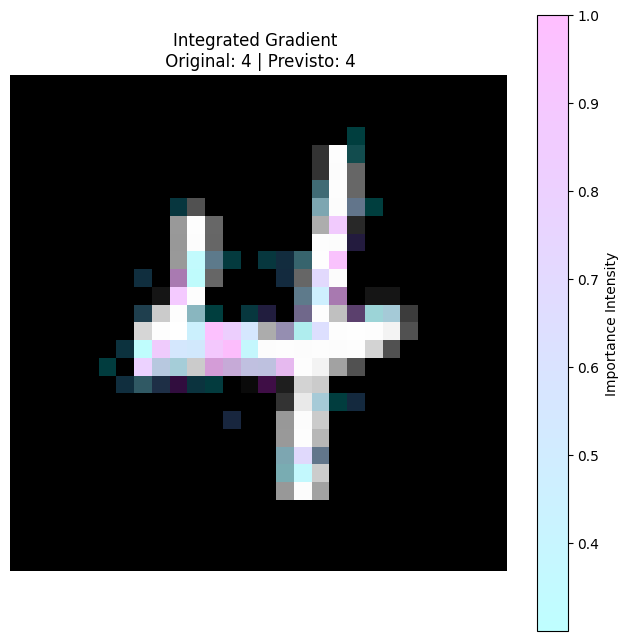

In [3]:
# Escolher imagem aleatória
num_samples = len(modelo.features)
random_idx = np.random.randint(0, num_samples)

random_image = modelo.features[random_idx][np.newaxis, ...]
actual_label = int(modelo.target[random_idx])

# Previsão
predictions = modelo.modelo.predict(random_image)
predicted_label = np.argmax(predictions, axis=1)[0]

# Explicação
explainer = IntegratedGradients()
explanation = explainer.explain(
    validation_data=(random_image, None),
    model=modelo.modelo,
    class_index=actual_label
)

# Simplificacao dos dados para visualização
explanation = np.squeeze(explanation)
original_image = np.squeeze(random_image)

explanation_norm = (explanation - explanation.min()) / (explanation.max() - explanation.min() + 1e-8)

# Mascara
threshold = 0.3
masked_explanation = np.ma.masked_where(explanation_norm < threshold, explanation_norm)

# Grafico
plt.figure(figsize=(8, 8))

plt.imshow(original_image, cmap='gray')
plt.imshow(masked_explanation, cmap='cool', alpha=0.25) 

# Updated Title with Prediction, Actual Label, and Confidence
plt.title(f"Integrated Gradient \n Original: {actual_label} | Previsto: {predicted_label}", 
          fontsize=12)

plt.axis('off')
plt.colorbar(label='Importance Intensity')
plt.show()

In [4]:
print(type(modelo.test_ds))
import numpy as np

# 1. Converter para iterador e extrair tudo
# O list() vai percorrer o dataset inteiro e criar uma lista de tuplos (X, y)
data_list = list(modelo.test_ds.as_numpy_iterator())

# 2. Separar as features e os targets usando zip
# X será uma lista de imagens, y será uma lista de labels
X_test, y_test = zip(*data_list)

# 3. Converter para arrays NumPy
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Features shape: {X_test.shape}") # Esperado: (N, 28, 28, 1)
print(f"Target shape: {y_test.shape}")     # Esperado: (N,)

<class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'>


Features shape: (7000, 28, 28, 1)
Target shape: (7000,)


In [5]:
# Garante shape (28, 28)
H, W = explanation_norm.shape

# Achata a matriz
flat_importance = explanation_norm.flatten()

# Índices ordenados do mais importante para o menos importante
sorted_indices = np.argsort(flat_importance)[::-1]

# Cria lista ordenada
ordered_pixels = [
    {
        "flat_index": int(idx),
        "row": idx // W,
        "col": idx % W,
        "importance": float(flat_importance[idx])
    }
    for idx in sorted_indices
]

# Mostrar os 20 pixels mais importantes
top_k = 30
for p in ordered_pixels[:top_k]:
    print(
        f"Pixel ({p['row']:02d}, {p['col']:02d}) | "
        f"flat_idx={p['flat_index']:03d} | "
        f"importance={p['importance']:.4f}"
    )

Pixel (15, 12) | flat_idx=432 | importance=1.0000
Pixel (14, 11) | flat_idx=403 | importance=0.9802
Pixel (16, 11) | flat_idx=459 | importance=0.9605
Pixel (10, 18) | flat_idx=298 | importance=0.9526
Pixel (17, 14) | flat_idx=490 | importance=0.9249
Pixel (12, 18) | flat_idx=354 | importance=0.9091
Pixel (11, 09) | flat_idx=317 | importance=0.9051
Pixel (16, 15) | flat_idx=463 | importance=0.9012
Pixel (15, 11) | flat_idx=431 | importance=0.8854
Pixel (12, 09) | flat_idx=345 | importance=0.8775
Pixel (08, 18) | flat_idx=242 | importance=0.8617
Pixel (15, 08) | flat_idx=428 | importance=0.8498
Pixel (17, 09) | flat_idx=485 | importance=0.8458
Pixel (14, 12) | flat_idx=404 | importance=0.8142
Pixel (16, 12) | flat_idx=460 | importance=0.8063
Pixel (13, 19) | flat_idx=383 | importance=0.7984
Pixel (16, 07) | flat_idx=455 | importance=0.7905
Pixel (11, 17) | flat_idx=325 | importance=0.6996
Pixel (13, 16) | flat_idx=380 | importance=0.6917
Pixel (09, 19) | flat_idx=271 | importance=0.6917


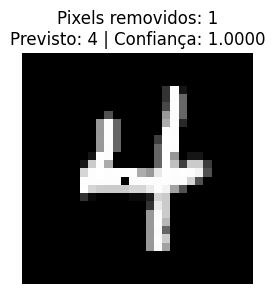

Removido pixel 1/30: (15,12) | Previsto=4 | Confiança=1.0000


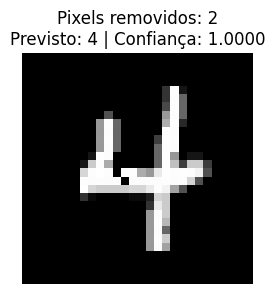

Removido pixel 2/30: (14,11) | Previsto=4 | Confiança=1.0000


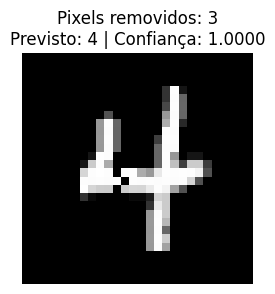

Removido pixel 3/30: (16,11) | Previsto=4 | Confiança=1.0000


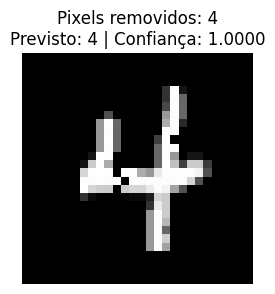

Removido pixel 4/30: (10,18) | Previsto=4 | Confiança=1.0000


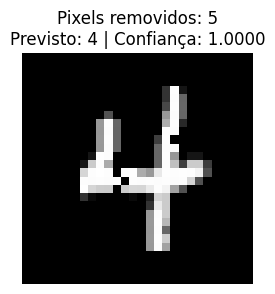

Removido pixel 5/30: (17,14) | Previsto=4 | Confiança=1.0000


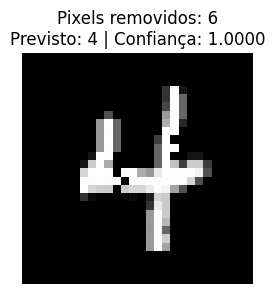

Removido pixel 6/30: (12,18) | Previsto=4 | Confiança=1.0000


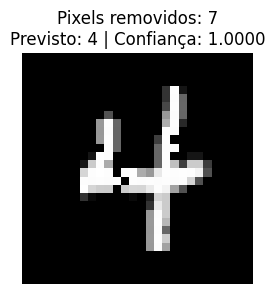

Removido pixel 7/30: (11,9) | Previsto=4 | Confiança=1.0000


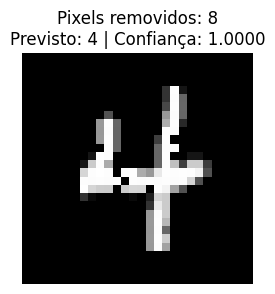

Removido pixel 8/30: (16,15) | Previsto=4 | Confiança=1.0000


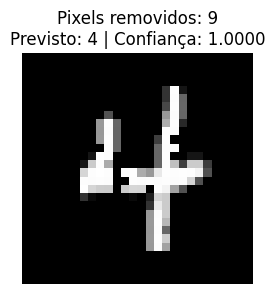

Removido pixel 9/30: (15,11) | Previsto=4 | Confiança=1.0000


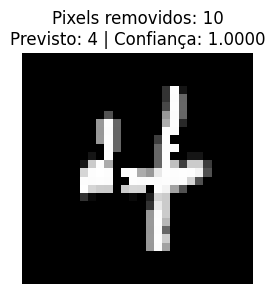

Removido pixel 10/30: (12,9) | Previsto=4 | Confiança=1.0000


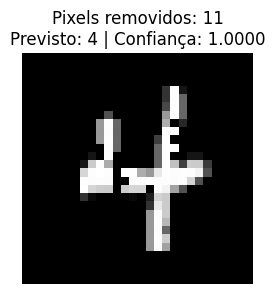

Removido pixel 11/30: (8,18) | Previsto=4 | Confiança=1.0000


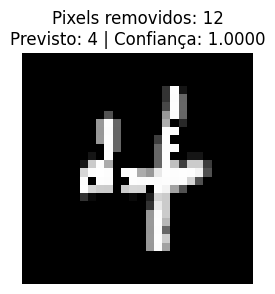

Removido pixel 12/30: (15,8) | Previsto=4 | Confiança=1.0000


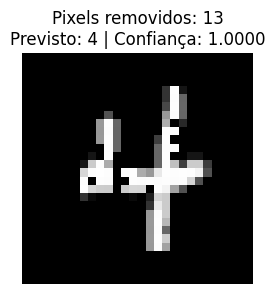

Removido pixel 13/30: (17,9) | Previsto=4 | Confiança=1.0000


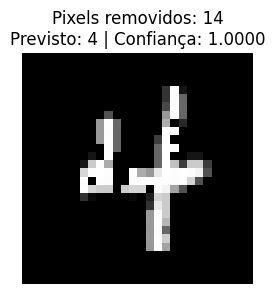

Removido pixel 14/30: (14,12) | Previsto=4 | Confiança=1.0000


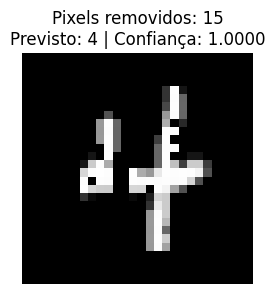

Removido pixel 15/30: (16,12) | Previsto=4 | Confiança=1.0000


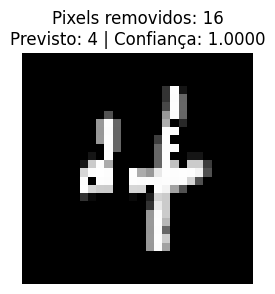

Removido pixel 16/30: (13,19) | Previsto=4 | Confiança=1.0000


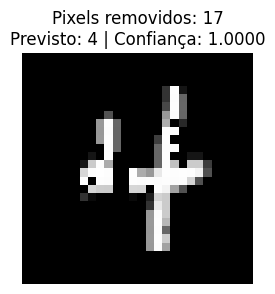

Removido pixel 17/30: (16,7) | Previsto=4 | Confiança=1.0000


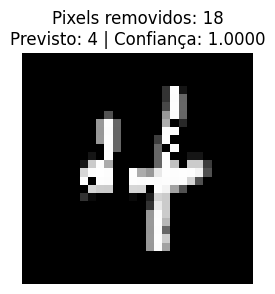

Removido pixel 18/30: (11,17) | Previsto=4 | Confiança=1.0000


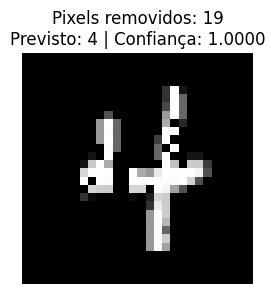

Removido pixel 19/30: (13,16) | Previsto=4 | Confiança=1.0000


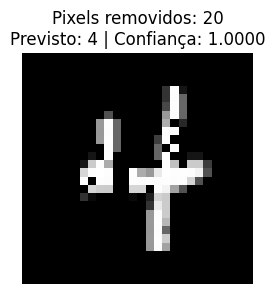

Removido pixel 20/30: (9,19) | Previsto=4 | Confiança=1.0000


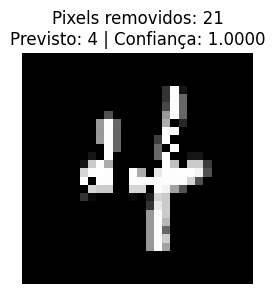

Removido pixel 21/30: (14,15) | Previsto=4 | Confiança=1.0000


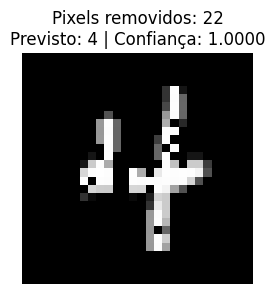

Removido pixel 22/30: (21,16) | Previsto=4 | Confiança=1.0000


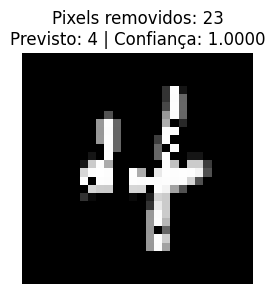

Removido pixel 23/30: (13,14) | Previsto=4 | Confiança=1.0000


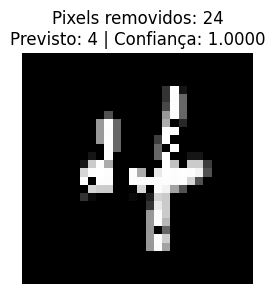

Removido pixel 24/30: (16,13) | Previsto=4 | Confiança=1.0000


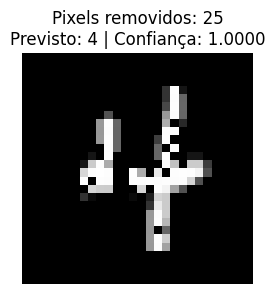

Removido pixel 25/30: (14,17) | Previsto=4 | Confiança=1.0000


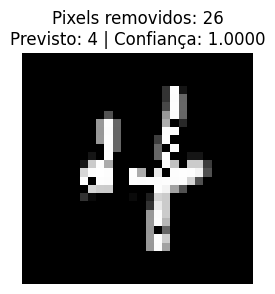

Removido pixel 26/30: (16,14) | Previsto=4 | Confiança=1.0000


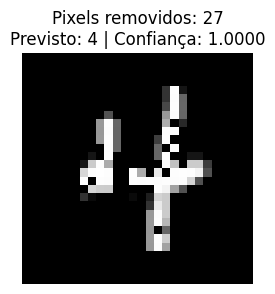

Removido pixel 27/30: (19,12) | Previsto=4 | Confiança=1.0000


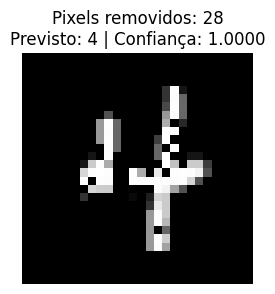

Removido pixel 28/30: (17,8) | Previsto=4 | Confiança=1.0000


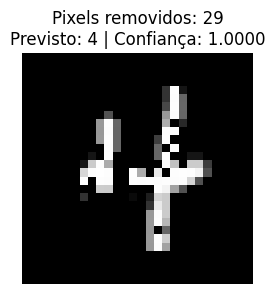

Removido pixel 29/30: (16,8) | Previsto=4 | Confiança=1.0000


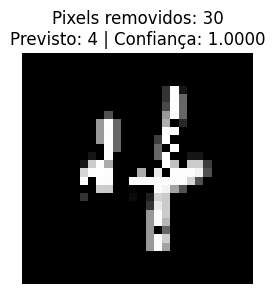

Removido pixel 30/30: (14,13) | Previsto=4 | Confiança=1.0000


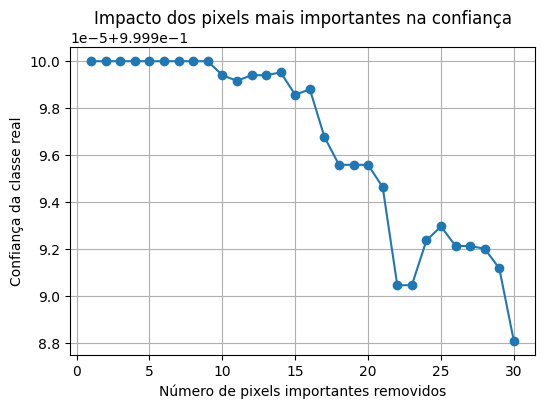

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Copia da imagem original para não alterar a original
image_to_test = original_image.copy()

# Guardar confidências
confidences = []
predicted_numbers = []  # Para armazenar o número previsto

# Top pixels que vamos remover
top_pixels = ordered_pixels[:top_k]

# Iterar sobre cada pixel
for i, p in enumerate(top_pixels):
    # Substituir pixel pelo valor mínimo da imagem (ou 0)
    image_to_test[p['row'], p['col']] = 0.0
    
    # Adapta shape para modelo (batch + canal)
    input_for_model = image_to_test[np.newaxis, ..., np.newaxis]  # MNIST: (1,28,28,1)
    
    # Previsão
    pred = modelo.modelo.predict(input_for_model, verbose=0)
    
    # Confiança da classe real
    conf_real = pred[0, actual_label]
    confidences.append(conf_real)
    
    # Número previsto
    predicted_label = np.argmax(pred[0])
    predicted_numbers.append(predicted_label)
    
    # Mostrar a imagem atualizada com o número previsto
    plt.figure(figsize=(3,3))
    plt.imshow(image_to_test, cmap='gray')
    plt.title(f"Pixels removidos: {i+1}\nPrevisto: {predicted_label} | Confiança: {conf_real:.4f}")
    plt.axis('off')
    plt.show()
    
    print(f"Removido pixel {i+1}/{top_k}: ({p['row']},{p['col']}) | "
          f"Previsto={predicted_label} | Confiança={conf_real:.4f}")

# Plotar a queda de confiança
plt.figure(figsize=(6,4))
plt.plot(range(1, top_k+1), confidences, marker='o')
plt.xlabel("Número de pixels importantes removidos")
plt.ylabel("Confiança da classe real")
plt.title("Impacto dos pixels mais importantes na confiança")
plt.grid(True)
plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tqdm import tqdm # Para barra de progresso

def analisar_sensitivity_n(model, images, labels, explainer_func, max_n=50, num_samples=20, baseline_val=0.0):
    """
    Calcula a métrica Sensitivity-n e plota a curva de degradação da confiança.
    
    Args:
        model: O modelo treinado (com método .predict).
        images: Array numpy com as imagens de teste.
        labels: Array com as labels verdadeiras.
        explainer_func: Função que recebe (imagem, label) e retorna a matriz de atribuição/explicação.
        max_n: Número máximo de pixels/features a remover.
        num_samples: Quantas imagens usar para o teste (para ser rápido, usa 20-50; para final, usa 100+).
        baseline_val: Valor para substituir os pixels (0.0 para preto, ou média).
    """
    
    # Listas para guardar dados globais para correlação
    global_sum_attributions = []
    global_conf_drops = []
    
    # Matriz para guardar curvas de confiança (num_samples x max_n)
    confidence_curves = np.zeros((num_samples, max_n))
    
    print(f"--- A iniciar Análise Sensitivity-n em {num_samples} amostras ---")
    
    # Loop pelas amostras (usa índices aleatórios ou os primeiros N)
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    for i, idx in tqdm(enumerate(indices), total=num_samples):
        # 1. Preparar imagem e label
        img = images[idx] # Shape (28, 28) ou (28, 28, 1)
        if len(img.shape) == 2: img = img[..., np.newaxis] # Garante canal
        img_input = img[np.newaxis, ...] # Batch dimension (1, 28, 28, 1)
        label = int(labels[idx])
        
        # 2. Obter Probabilidade Inicial
        preds = model.predict(img_input, verbose=0)
        initial_conf = preds[0, label]
        
        # 3. Gerar Explicação (usando a função passada como argumento)
        # A função deve retornar array 2D ou 3D com as importâncias
        attribution_map = explainer_func(img_input, label) 
        
        # Normalizar e Achatamento
        attr_norm = (attribution_map - attribution_map.min()) / (attribution_map.max() - attribution_map.min() + 1e-8)
        flat_attr = attr_norm.flatten()
        
        # 4. Ordenar índices (Do mais importante para o menos importante)
        sorted_indices = np.argsort(flat_attr)[::-1] # Decrescente
        
        # Copia para alteração
        img_perturbed = img.copy()
        H, W = img.shape[:2]
        
        current_sum_importance = 0.0
        
        # 5. Loop de Remoção (Sensitivity-n)
        for step in range(max_n):
            # Identificar pixel a remover neste passo
            pixel_idx = sorted_indices[step]
            row, col = pixel_idx // W, pixel_idx % W
            
            # Acumular importância (Eixo X da correlação)
            current_sum_importance += flat_attr[pixel_idx]
            global_sum_attributions.append(current_sum_importance)
            
            # Neutralizar pixel
            img_perturbed[row, col] = baseline_val # Substitui por 0 (preto)
            
            # Prever novamente
            pred_new = model.predict(img_perturbed[np.newaxis, ...], verbose=0)
            conf_new = pred_new[0, label]
            
            # Calcular queda (Eixo Y da correlação)
            drop = initial_conf - conf_new
            global_conf_drops.append(drop)
            
            # Guardar confiança absoluta para o gráfico
            confidence_curves[i, step] = conf_new

    # --- CÁLCULOS FINAIS ---
    
    # 1. Correlação de Pearson
    correlation, _ = pearsonr(global_sum_attributions, global_conf_drops)
    
    # 2. Média da curva de confiança
    avg_curve = np.mean(confidence_curves, axis=0)
    
    # --- VISUALIZAÇÃO ---
    plt.figure(figsize=(10, 6))
    
    # Plotar cada amostra (transparente) para ver variância
    for k in range(num_samples):
        plt.plot(range(1, max_n+1), confidence_curves[k], color='gray', alpha=0.1)
        
    # Plotar a média (linha forte)
    plt.plot(range(1, max_n+1), avg_curve, color='red', linewidth=3, label='Média da Confiança')
    
    plt.title(f"Análise Sensitivity-n (Ablação)\nCorrelação: {correlation:.4f}", fontsize=14)
    plt.xlabel("Número de Features (Pixels) Removidos", fontsize=12)
    plt.ylabel("Confiança do Modelo na Classe Real", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    
    print("="*50)
    print(f"RESULTADOS SENSITIVITY-N")
    print(f"Amostras analisadas: {num_samples}")
    print(f"Features removidas (max): {max_n}")
    print(f"Correlação de Pearson: {correlation:.4f}")
    print("="*50)
    
    return correlation

--- A iniciar Análise Sensitivity-n em 7000 amostras ---


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 1/7000 [00:01<3:23:56,  1.75s/it]

  0%|          | 2/7000 [00:03<3:23:28,  1.74s/it]

  0%|          | 3/7000 [00:05<3:12:44,  1.65s/it]

  0%|          | 4/7000 [00:06<3:08:40,  1.62s/it]

  0%|          | 5/7000 [00:08<3:13:33,  1.66s/it]

  0%|          | 6/7000 [00:10<3:16:35,  1.69s/it]

  0%|          | 7/7000 [00:11<3:11:01,  1.64s/it]

  0%|          | 8/7000 [00:13<3:14:57,  1.67s/it]

  0%|          | 9/7000 [00:14<3:10:32,  1.64s/it]

  0%|          | 10/7000 [00:16<3:07:59,  1.61s/it]

  0%|          | 11/7000 [00:18<3:06:05,  1.60s/it]

  0%|          | 12/7000 [00:19<3:04:52,  1.59s/it]

  0%|          | 13/7000 [00:21<3:03:58,  1.58s/it]

  0%|          | 14/7000 [00:22<3:03:43,  1.58s/it]

  0%|          | 15/7000 [00:24<3:09:42,  1.63s/it]

  0%|          | 16/7000 [00:26<3:06:22,  1.60s/it]

  0%|          | 17/7000 [00:27<3:11:05,  1.64s/it]

  0%|          | 18/7000 [00:29<3:07:30,  1.61s/it]

  0%|          | 19/7000 [00:30<3:05:22,  1.59s/it]

  0%|          | 20/7000 [00:32<3:03:46,  1.58s/it]

  0%|          | 21/7000 [00:34<3:10:07,  1.63s/it]

  0%|          | 22/7000 [00:35<3:07:32,  1.61s/it]

  0%|          | 23/7000 [00:37<3:17:55,  1.70s/it]

  0%|          | 24/7000 [00:39<3:16:52,  1.69s/it]

  0%|          | 25/7000 [00:41<3:20:14,  1.72s/it]

  0%|          | 26/7000 [00:42<3:14:46,  1.68s/it]

  0%|          | 27/7000 [00:44<3:11:14,  1.65s/it]

  0%|          | 28/7000 [00:45<3:08:53,  1.63s/it]

  0%|          | 29/7000 [00:47<3:07:36,  1.61s/it]

  0%|          | 30/7000 [00:48<3:06:21,  1.60s/it]

  0%|          | 31/7000 [00:50<3:06:08,  1.60s/it]

  0%|          | 32/7000 [00:52<3:05:36,  1.60s/it]

  0%|          | 33/7000 [00:53<3:05:32,  1.60s/it]

  0%|          | 34/7000 [00:55<3:05:33,  1.60s/it]

  0%|          | 35/7000 [00:56<3:05:39,  1.60s/it]

  1%|          | 36/7000 [00:58<3:06:00,  1.60s/it]

  1%|          | 37/7000 [01:00<3:05:46,  1.60s/it]

  1%|          | 38/7000 [01:01<3:06:07,  1.60s/it]

  1%|          | 39/7000 [01:03<3:06:08,  1.60s/it]

  1%|          | 40/7000 [01:04<3:06:01,  1.60s/it]

  1%|          | 41/7000 [01:06<3:06:21,  1.61s/it]

  1%|          | 42/7000 [01:08<3:06:24,  1.61s/it]

  1%|          | 43/7000 [01:09<3:06:49,  1.61s/it]

  1%|          | 44/7000 [01:11<3:06:50,  1.61s/it]

  1%|          | 45/7000 [01:13<3:06:21,  1.61s/it]

  1%|          | 46/7000 [01:14<3:07:06,  1.61s/it]

  1%|          | 47/7000 [01:16<3:06:28,  1.61s/it]

  1%|          | 48/7000 [01:17<3:06:35,  1.61s/it]

  1%|          | 49/7000 [01:19<3:06:54,  1.61s/it]

  1%|          | 50/7000 [01:21<3:07:17,  1.62s/it]

  1%|          | 51/7000 [01:22<3:08:08,  1.62s/it]

  1%|          | 52/7000 [01:24<3:08:05,  1.62s/it]

  1%|          | 53/7000 [01:26<3:08:51,  1.63s/it]

  1%|          | 54/7000 [01:27<3:08:25,  1.63s/it]

  1%|          | 55/7000 [01:29<3:08:23,  1.63s/it]

  1%|          | 56/7000 [01:30<3:08:30,  1.63s/it]

  1%|          | 57/7000 [01:32<3:08:21,  1.63s/it]

  1%|          | 58/7000 [01:34<3:09:04,  1.63s/it]

  1%|          | 59/7000 [01:35<3:07:57,  1.62s/it]

  1%|          | 60/7000 [01:37<3:08:03,  1.63s/it]

  1%|          | 61/7000 [01:39<3:07:33,  1.62s/it]

  1%|          | 62/7000 [01:40<3:07:49,  1.62s/it]

  1%|          | 63/7000 [01:42<3:08:17,  1.63s/it]

  1%|          | 64/7000 [01:43<3:08:29,  1.63s/it]

  1%|          | 65/7000 [01:45<3:08:34,  1.63s/it]

  1%|          | 66/7000 [01:47<3:07:21,  1.62s/it]

  1%|          | 67/7000 [01:48<3:07:10,  1.62s/it]

  1%|          | 68/7000 [01:50<3:07:27,  1.62s/it]

  1%|          | 69/7000 [01:52<3:07:27,  1.62s/it]

  1%|          | 70/7000 [01:53<3:07:46,  1.63s/it]

  1%|          | 71/7000 [01:55<3:07:20,  1.62s/it]

  1%|          | 72/7000 [01:56<3:08:38,  1.63s/it]

  1%|          | 73/7000 [01:58<3:11:41,  1.66s/it]

  1%|          | 74/7000 [02:00<3:16:49,  1.71s/it]

  1%|          | 75/7000 [02:02<3:18:38,  1.72s/it]

  1%|          | 76/7000 [02:04<3:20:38,  1.74s/it]

  1%|          | 77/7000 [02:05<3:20:21,  1.74s/it]

  1%|          | 78/7000 [02:07<3:16:03,  1.70s/it]

  1%|          | 79/7000 [02:08<3:13:33,  1.68s/it]

  1%|          | 80/7000 [02:10<3:11:57,  1.66s/it]

  1%|          | 81/7000 [02:12<3:10:54,  1.66s/it]

  1%|          | 82/7000 [02:13<3:09:52,  1.65s/it]

  1%|          | 83/7000 [02:15<3:14:36,  1.69s/it]

  1%|          | 84/7000 [02:17<3:16:33,  1.71s/it]

  1%|          | 85/7000 [02:19<3:13:20,  1.68s/it]

  1%|          | 86/7000 [02:20<3:11:06,  1.66s/it]

  1%|          | 87/7000 [02:22<3:09:50,  1.65s/it]

  1%|▏         | 88/7000 [02:23<3:09:07,  1.64s/it]

  1%|▏         | 89/7000 [02:25<3:08:31,  1.64s/it]

  1%|▏         | 90/7000 [02:27<3:07:05,  1.62s/it]

  1%|▏         | 91/7000 [02:28<3:06:32,  1.62s/it]

  1%|▏         | 92/7000 [02:30<3:06:09,  1.62s/it]

  1%|▏         | 93/7000 [02:31<3:06:01,  1.62s/it]

  1%|▏         | 94/7000 [02:33<3:08:36,  1.64s/it]

  1%|▏         | 95/7000 [02:35<3:06:28,  1.62s/it]

  1%|▏         | 96/7000 [02:36<3:02:10,  1.58s/it]

  1%|▏         | 97/7000 [02:38<2:58:42,  1.55s/it]

  1%|▏         | 98/7000 [02:39<2:56:38,  1.54s/it]

  1%|▏         | 99/7000 [02:41<2:55:36,  1.53s/it]

  1%|▏         | 100/7000 [02:42<2:54:47,  1.52s/it]

  1%|▏         | 101/7000 [02:44<2:53:44,  1.51s/it]

  1%|▏         | 102/7000 [02:45<3:03:13,  1.59s/it]

  1%|▏         | 103/7000 [02:47<2:59:49,  1.56s/it]

  1%|▏         | 104/7000 [02:48<2:57:04,  1.54s/it]

  2%|▏         | 105/7000 [02:50<2:55:26,  1.53s/it]

  2%|▏         | 106/7000 [02:51<2:53:47,  1.51s/it]

  2%|▏         | 107/7000 [02:53<2:52:21,  1.50s/it]

  2%|▏         | 108/7000 [02:54<2:52:39,  1.50s/it]

  2%|▏         | 109/7000 [02:56<2:52:09,  1.50s/it]

  2%|▏         | 110/7000 [02:57<2:52:05,  1.50s/it]

  2%|▏         | 111/7000 [02:59<2:51:43,  1.50s/it]

  2%|▏         | 112/7000 [03:00<2:51:08,  1.49s/it]

  2%|▏         | 113/7000 [03:02<2:50:32,  1.49s/it]

  2%|▏         | 114/7000 [03:03<2:49:59,  1.48s/it]

  2%|▏         | 115/7000 [03:05<2:50:40,  1.49s/it]

  2%|▏         | 116/7000 [03:06<2:50:29,  1.49s/it]

  2%|▏         | 117/7000 [03:08<2:50:25,  1.49s/it]

  2%|▏         | 118/7000 [03:09<2:50:10,  1.48s/it]

  2%|▏         | 119/7000 [03:11<2:49:33,  1.48s/it]

  2%|▏         | 120/7000 [03:12<2:49:41,  1.48s/it]

  2%|▏         | 121/7000 [03:14<2:54:53,  1.53s/it]

  2%|▏         | 122/7000 [03:16<3:02:31,  1.59s/it]

  2%|▏         | 123/7000 [03:17<2:57:36,  1.55s/it]

  2%|▏         | 124/7000 [03:19<2:57:48,  1.55s/it]

  2%|▏         | 125/7000 [03:20<3:01:26,  1.58s/it]

  2%|▏         | 126/7000 [03:22<3:02:57,  1.60s/it]

  2%|▏         | 127/7000 [03:24<3:07:53,  1.64s/it]

  2%|▏         | 128/7000 [03:25<3:10:41,  1.67s/it]

  2%|▏         | 129/7000 [03:27<3:08:35,  1.65s/it]

  2%|▏         | 130/7000 [03:29<3:06:58,  1.63s/it]

  2%|▏         | 131/7000 [03:30<3:05:06,  1.62s/it]

  2%|▏         | 132/7000 [03:32<3:04:25,  1.61s/it]

  2%|▏         | 133/7000 [03:33<3:04:54,  1.62s/it]

  2%|▏         | 134/7000 [03:35<3:03:51,  1.61s/it]

  2%|▏         | 135/7000 [03:37<3:04:03,  1.61s/it]

  2%|▏         | 136/7000 [03:38<3:04:17,  1.61s/it]

  2%|▏         | 137/7000 [03:40<3:04:44,  1.62s/it]

  2%|▏         | 138/7000 [03:41<3:04:49,  1.62s/it]

  2%|▏         | 139/7000 [03:43<3:05:07,  1.62s/it]

  2%|▏         | 140/7000 [03:45<3:04:35,  1.61s/it]

  2%|▏         | 141/7000 [03:46<3:05:11,  1.62s/it]

  2%|▏         | 142/7000 [03:48<3:05:18,  1.62s/it]

  2%|▏         | 143/7000 [03:50<3:05:22,  1.62s/it]

  2%|▏         | 144/7000 [03:51<3:05:35,  1.62s/it]

  2%|▏         | 145/7000 [03:53<3:05:11,  1.62s/it]

  2%|▏         | 146/7000 [03:54<3:05:43,  1.63s/it]

  2%|▏         | 147/7000 [03:56<3:04:54,  1.62s/it]

  2%|▏         | 148/7000 [03:58<3:04:47,  1.62s/it]

  2%|▏         | 149/7000 [03:59<3:05:18,  1.62s/it]

  2%|▏         | 150/7000 [04:01<3:04:59,  1.62s/it]

  2%|▏         | 151/7000 [04:03<3:05:12,  1.62s/it]

  2%|▏         | 152/7000 [04:04<3:04:57,  1.62s/it]

  2%|▏         | 153/7000 [04:06<3:05:54,  1.63s/it]

  2%|▏         | 154/7000 [04:07<3:06:01,  1.63s/it]

  2%|▏         | 155/7000 [04:09<3:07:12,  1.64s/it]

  2%|▏         | 156/7000 [04:11<3:02:25,  1.60s/it]

  2%|▏         | 157/7000 [04:12<2:58:01,  1.56s/it]

  2%|▏         | 158/7000 [04:14<2:55:18,  1.54s/it]

  2%|▏         | 159/7000 [04:15<2:54:17,  1.53s/it]

  2%|▏         | 160/7000 [04:16<2:51:40,  1.51s/it]

  2%|▏         | 161/7000 [04:18<2:50:34,  1.50s/it]

  2%|▏         | 162/7000 [04:19<2:49:40,  1.49s/it]

  2%|▏         | 163/7000 [04:21<2:49:14,  1.49s/it]

  2%|▏         | 164/7000 [04:22<2:48:28,  1.48s/it]

  2%|▏         | 165/7000 [04:24<2:48:04,  1.48s/it]

  2%|▏         | 166/7000 [04:25<2:48:21,  1.48s/it]

  2%|▏         | 167/7000 [04:27<2:48:00,  1.48s/it]

  2%|▏         | 168/7000 [04:28<2:47:52,  1.47s/it]

  2%|▏         | 169/7000 [04:30<2:47:13,  1.47s/it]

  2%|▏         | 170/7000 [04:31<2:47:44,  1.47s/it]

  2%|▏         | 171/7000 [04:33<2:47:02,  1.47s/it]

  2%|▏         | 172/7000 [04:34<2:46:26,  1.46s/it]

  2%|▏         | 173/7000 [04:36<2:46:22,  1.46s/it]

  2%|▏         | 174/7000 [04:37<2:46:24,  1.46s/it]

  2%|▎         | 175/7000 [04:39<2:46:43,  1.47s/it]

  3%|▎         | 176/7000 [04:40<2:46:21,  1.46s/it]

  3%|▎         | 177/7000 [04:41<2:46:53,  1.47s/it]

  3%|▎         | 178/7000 [04:43<2:46:42,  1.47s/it]

  3%|▎         | 179/7000 [04:44<2:46:11,  1.46s/it]

  3%|▎         | 180/7000 [04:46<2:48:35,  1.48s/it]

  3%|▎         | 181/7000 [04:47<2:48:35,  1.48s/it]

  3%|▎         | 182/7000 [04:49<2:47:34,  1.47s/it]

  3%|▎         | 183/7000 [04:50<2:46:58,  1.47s/it]

  3%|▎         | 184/7000 [04:52<3:04:14,  1.62s/it]

  3%|▎         | 185/7000 [04:54<3:05:55,  1.64s/it]

  3%|▎         | 186/7000 [04:56<3:07:30,  1.65s/it]

  3%|▎         | 187/7000 [04:57<3:09:22,  1.67s/it]

  3%|▎         | 188/7000 [04:59<3:09:35,  1.67s/it]

  3%|▎         | 189/7000 [05:01<3:09:36,  1.67s/it]

  3%|▎         | 190/7000 [05:02<3:10:26,  1.68s/it]

  3%|▎         | 191/7000 [05:04<3:10:10,  1.68s/it]

  3%|▎         | 192/7000 [05:06<3:10:03,  1.67s/it]

  3%|▎         | 193/7000 [05:07<3:10:20,  1.68s/it]

  3%|▎         | 194/7000 [05:09<3:10:37,  1.68s/it]

  3%|▎         | 195/7000 [05:11<3:10:16,  1.68s/it]

  3%|▎         | 196/7000 [05:12<3:10:35,  1.68s/it]

  3%|▎         | 197/7000 [05:14<3:09:56,  1.68s/it]

  3%|▎         | 198/7000 [05:16<3:09:40,  1.67s/it]

  3%|▎         | 199/7000 [05:17<3:09:50,  1.67s/it]

  3%|▎         | 200/7000 [05:19<3:09:28,  1.67s/it]

  3%|▎         | 201/7000 [05:21<3:09:22,  1.67s/it]

  3%|▎         | 202/7000 [05:22<3:08:45,  1.67s/it]

  3%|▎         | 203/7000 [05:24<3:08:56,  1.67s/it]

  3%|▎         | 204/7000 [05:26<3:08:48,  1.67s/it]

  3%|▎         | 205/7000 [05:27<3:07:53,  1.66s/it]

  3%|▎         | 206/7000 [05:29<3:08:26,  1.66s/it]

  3%|▎         | 207/7000 [05:31<3:07:46,  1.66s/it]

  3%|▎         | 208/7000 [05:32<3:07:41,  1.66s/it]

  3%|▎         | 209/7000 [05:34<3:07:51,  1.66s/it]

  3%|▎         | 210/7000 [05:36<3:07:23,  1.66s/it]

  3%|▎         | 211/7000 [05:37<3:06:31,  1.65s/it]

  3%|▎         | 212/7000 [05:39<3:06:39,  1.65s/it]

  3%|▎         | 213/7000 [05:41<3:06:42,  1.65s/it]

  3%|▎         | 214/7000 [05:42<3:06:57,  1.65s/it]

  3%|▎         | 215/7000 [05:44<3:07:12,  1.66s/it]

  3%|▎         | 216/7000 [05:46<3:07:05,  1.65s/it]

  3%|▎         | 217/7000 [05:47<3:06:08,  1.65s/it]

  3%|▎         | 218/7000 [05:49<3:06:53,  1.65s/it]

  3%|▎         | 219/7000 [05:51<3:06:23,  1.65s/it]

  3%|▎         | 220/7000 [05:52<3:06:01,  1.65s/it]

  3%|▎         | 221/7000 [05:54<3:05:50,  1.64s/it]

  3%|▎         | 222/7000 [05:55<3:05:34,  1.64s/it]

  3%|▎         | 223/7000 [05:57<3:05:31,  1.64s/it]

  3%|▎         | 224/7000 [05:59<3:05:18,  1.64s/it]

  3%|▎         | 225/7000 [06:00<3:05:55,  1.65s/it]

  3%|▎         | 226/7000 [06:02<3:05:47,  1.65s/it]

  3%|▎         | 227/7000 [06:04<3:05:07,  1.64s/it]

  3%|▎         | 228/7000 [06:05<3:05:24,  1.64s/it]

  3%|▎         | 229/7000 [06:07<3:05:29,  1.64s/it]

  3%|▎         | 230/7000 [06:09<3:06:11,  1.65s/it]

  3%|▎         | 231/7000 [06:10<3:05:29,  1.64s/it]

  3%|▎         | 232/7000 [06:12<3:05:14,  1.64s/it]

  3%|▎         | 233/7000 [06:14<3:05:36,  1.65s/it]

  3%|▎         | 234/7000 [06:15<3:05:54,  1.65s/it]

  3%|▎         | 235/7000 [06:17<3:05:20,  1.64s/it]

  3%|▎         | 236/7000 [06:18<3:04:45,  1.64s/it]

  3%|▎         | 237/7000 [06:20<3:05:07,  1.64s/it]

  3%|▎         | 238/7000 [06:22<3:04:48,  1.64s/it]

  3%|▎         | 239/7000 [06:23<3:04:19,  1.64s/it]

  3%|▎         | 240/7000 [06:25<3:04:31,  1.64s/it]

  3%|▎         | 241/7000 [06:27<3:04:52,  1.64s/it]

  3%|▎         | 242/7000 [06:28<3:05:34,  1.65s/it]

  3%|▎         | 243/7000 [06:30<3:04:46,  1.64s/it]

  3%|▎         | 244/7000 [06:32<3:05:00,  1.64s/it]

  4%|▎         | 245/7000 [06:33<3:05:07,  1.64s/it]

  4%|▎         | 246/7000 [06:35<3:04:27,  1.64s/it]

  4%|▎         | 247/7000 [06:37<3:04:57,  1.64s/it]

  4%|▎         | 248/7000 [06:38<3:04:13,  1.64s/it]

  4%|▎         | 249/7000 [06:40<3:04:00,  1.64s/it]

  4%|▎         | 250/7000 [06:41<3:04:04,  1.64s/it]

  4%|▎         | 251/7000 [06:43<3:04:14,  1.64s/it]

  4%|▎         | 252/7000 [06:45<3:04:40,  1.64s/it]

  4%|▎         | 253/7000 [06:46<3:04:05,  1.64s/it]

  4%|▎         | 254/7000 [06:48<3:04:07,  1.64s/it]

  4%|▎         | 255/7000 [06:50<3:03:34,  1.63s/it]

  4%|▎         | 256/7000 [06:51<3:03:09,  1.63s/it]

  4%|▎         | 257/7000 [06:53<3:03:42,  1.63s/it]

  4%|▎         | 258/7000 [06:54<3:02:44,  1.63s/it]

  4%|▎         | 259/7000 [06:56<3:02:29,  1.62s/it]

  4%|▎         | 260/7000 [06:58<3:02:36,  1.63s/it]

  4%|▎         | 261/7000 [06:59<3:03:20,  1.63s/it]

  4%|▎         | 262/7000 [07:01<3:02:44,  1.63s/it]

  4%|▍         | 263/7000 [07:03<3:02:00,  1.62s/it]

  4%|▍         | 264/7000 [07:04<3:01:36,  1.62s/it]

  4%|▍         | 265/7000 [07:06<3:01:12,  1.61s/it]

  4%|▍         | 266/7000 [07:08<3:17:00,  1.76s/it]

  4%|▍         | 267/7000 [07:10<3:16:12,  1.75s/it]

  4%|▍         | 268/7000 [07:11<3:15:07,  1.74s/it]

  4%|▍         | 269/7000 [07:13<3:15:08,  1.74s/it]

  4%|▍         | 270/7000 [07:15<3:13:47,  1.73s/it]

  4%|▍         | 271/7000 [07:17<3:13:44,  1.73s/it]

  4%|▍         | 272/7000 [07:18<3:12:52,  1.72s/it]

  4%|▍         | 273/7000 [07:20<3:12:16,  1.71s/it]

  4%|▍         | 274/7000 [07:22<3:11:40,  1.71s/it]

  4%|▍         | 275/7000 [07:23<3:11:35,  1.71s/it]

  4%|▍         | 276/7000 [07:25<3:10:45,  1.70s/it]

  4%|▍         | 277/7000 [07:27<3:10:12,  1.70s/it]

  4%|▍         | 278/7000 [07:28<3:10:52,  1.70s/it]

  4%|▍         | 279/7000 [07:30<3:10:11,  1.70s/it]

  4%|▍         | 280/7000 [07:32<3:10:00,  1.70s/it]

  4%|▍         | 281/7000 [07:33<3:09:48,  1.69s/it]

  4%|▍         | 282/7000 [07:35<3:08:52,  1.69s/it]

  4%|▍         | 283/7000 [07:37<3:08:43,  1.69s/it]

  4%|▍         | 284/7000 [07:39<3:08:16,  1.68s/it]

  4%|▍         | 285/7000 [07:40<3:08:06,  1.68s/it]

  4%|▍         | 286/7000 [07:42<3:07:58,  1.68s/it]

  4%|▍         | 287/7000 [07:44<3:07:25,  1.68s/it]

  4%|▍         | 288/7000 [07:45<3:07:11,  1.67s/it]

  4%|▍         | 289/7000 [07:47<3:06:34,  1.67s/it]

  4%|▍         | 290/7000 [07:49<3:06:32,  1.67s/it]

  4%|▍         | 291/7000 [07:50<3:06:53,  1.67s/it]

  4%|▍         | 292/7000 [07:52<3:06:46,  1.67s/it]

  4%|▍         | 293/7000 [07:54<3:06:57,  1.67s/it]

  4%|▍         | 294/7000 [07:55<3:07:12,  1.68s/it]

  4%|▍         | 295/7000 [07:57<3:06:47,  1.67s/it]

  4%|▍         | 296/7000 [07:59<3:06:23,  1.67s/it]

  4%|▍         | 297/7000 [08:00<3:07:07,  1.68s/it]

  4%|▍         | 298/7000 [08:02<3:06:26,  1.67s/it]

  4%|▍         | 299/7000 [08:04<3:05:56,  1.66s/it]

  4%|▍         | 300/7000 [08:05<3:05:57,  1.67s/it]

  4%|▍         | 301/7000 [08:07<3:05:42,  1.66s/it]

  4%|▍         | 302/7000 [08:09<3:05:35,  1.66s/it]

  4%|▍         | 303/7000 [08:10<3:05:25,  1.66s/it]

  4%|▍         | 304/7000 [08:12<3:05:18,  1.66s/it]

  4%|▍         | 305/7000 [08:14<3:04:33,  1.65s/it]

  4%|▍         | 306/7000 [08:15<3:04:52,  1.66s/it]

  4%|▍         | 307/7000 [08:17<3:04:52,  1.66s/it]

  4%|▍         | 308/7000 [08:18<3:03:54,  1.65s/it]

  4%|▍         | 309/7000 [08:20<3:03:41,  1.65s/it]

  4%|▍         | 310/7000 [08:22<3:03:39,  1.65s/it]

  4%|▍         | 311/7000 [08:23<3:03:27,  1.65s/it]

  4%|▍         | 312/7000 [08:25<3:03:55,  1.65s/it]

  4%|▍         | 313/7000 [08:27<3:04:23,  1.65s/it]

  4%|▍         | 314/7000 [08:28<3:04:03,  1.65s/it]

  4%|▍         | 315/7000 [08:30<3:03:11,  1.64s/it]

  5%|▍         | 316/7000 [08:32<3:03:18,  1.65s/it]

  5%|▍         | 317/7000 [08:33<3:03:07,  1.64s/it]

  5%|▍         | 318/7000 [08:35<3:03:32,  1.65s/it]

  5%|▍         | 319/7000 [08:37<3:03:41,  1.65s/it]

  5%|▍         | 320/7000 [08:38<3:03:02,  1.64s/it]

  5%|▍         | 321/7000 [08:40<3:03:26,  1.65s/it]

  5%|▍         | 322/7000 [08:42<3:03:28,  1.65s/it]

  5%|▍         | 323/7000 [08:43<3:03:11,  1.65s/it]

  5%|▍         | 324/7000 [08:45<3:02:53,  1.64s/it]

  5%|▍         | 325/7000 [08:46<3:03:19,  1.65s/it]

  5%|▍         | 326/7000 [08:48<3:03:00,  1.65s/it]

  5%|▍         | 327/7000 [08:50<3:02:33,  1.64s/it]

  5%|▍         | 328/7000 [08:51<3:02:35,  1.64s/it]

  5%|▍         | 329/7000 [08:53<3:03:09,  1.65s/it]

  5%|▍         | 330/7000 [08:55<3:02:14,  1.64s/it]

  5%|▍         | 331/7000 [08:56<3:02:33,  1.64s/it]

  5%|▍         | 332/7000 [08:58<3:02:49,  1.65s/it]

  5%|▍         | 333/7000 [09:00<3:02:50,  1.65s/it]

  5%|▍         | 334/7000 [09:01<3:01:51,  1.64s/it]

  5%|▍         | 335/7000 [09:03<3:02:00,  1.64s/it]

  5%|▍         | 336/7000 [09:05<3:02:19,  1.64s/it]

  5%|▍         | 337/7000 [09:06<3:01:12,  1.63s/it]

  5%|▍         | 338/7000 [09:08<3:01:57,  1.64s/it]

  5%|▍         | 339/7000 [09:09<3:01:27,  1.63s/it]

  5%|▍         | 340/7000 [09:11<3:01:17,  1.63s/it]

  5%|▍         | 341/7000 [09:13<3:01:03,  1.63s/it]

  5%|▍         | 342/7000 [09:14<3:00:57,  1.63s/it]

  5%|▍         | 343/7000 [09:16<3:00:17,  1.62s/it]

  5%|▍         | 344/7000 [09:18<3:00:06,  1.62s/it]

  5%|▍         | 345/7000 [09:19<3:01:02,  1.63s/it]

  5%|▍         | 346/7000 [09:21<3:00:24,  1.63s/it]

  5%|▍         | 347/7000 [09:23<3:12:16,  1.73s/it]

  5%|▍         | 348/7000 [09:25<3:13:45,  1.75s/it]

  5%|▍         | 349/7000 [09:26<3:13:59,  1.75s/it]

  5%|▌         | 350/7000 [09:28<3:13:20,  1.74s/it]

  5%|▌         | 351/7000 [09:30<3:13:00,  1.74s/it]

  5%|▌         | 352/7000 [09:32<3:12:37,  1.74s/it]

  5%|▌         | 353/7000 [09:33<3:11:37,  1.73s/it]

  5%|▌         | 354/7000 [09:35<3:11:37,  1.73s/it]

  5%|▌         | 355/7000 [09:37<3:10:24,  1.72s/it]

  5%|▌         | 356/7000 [09:38<3:09:43,  1.71s/it]

  5%|▌         | 357/7000 [09:40<3:09:46,  1.71s/it]

  5%|▌         | 358/7000 [09:42<3:08:12,  1.70s/it]

  5%|▌         | 359/7000 [09:43<3:08:15,  1.70s/it]

  5%|▌         | 360/7000 [09:45<3:08:20,  1.70s/it]

  5%|▌         | 361/7000 [09:47<3:07:53,  1.70s/it]

  5%|▌         | 362/7000 [09:49<3:08:17,  1.70s/it]

  5%|▌         | 363/7000 [09:50<3:08:00,  1.70s/it]

  5%|▌         | 364/7000 [09:52<3:08:28,  1.70s/it]

  5%|▌         | 365/7000 [09:54<3:08:08,  1.70s/it]

  5%|▌         | 366/7000 [09:55<3:08:14,  1.70s/it]

  5%|▌         | 367/7000 [09:57<3:07:46,  1.70s/it]

  5%|▌         | 368/7000 [09:59<3:07:18,  1.69s/it]

  5%|▌         | 369/7000 [10:00<3:07:29,  1.70s/it]

  5%|▌         | 370/7000 [10:02<3:07:04,  1.69s/it]

  5%|▌         | 371/7000 [10:04<3:06:27,  1.69s/it]

  5%|▌         | 372/7000 [10:05<3:06:24,  1.69s/it]

  5%|▌         | 373/7000 [10:07<3:05:36,  1.68s/it]

  5%|▌         | 374/7000 [10:09<3:04:48,  1.67s/it]

  5%|▌         | 375/7000 [10:10<3:04:32,  1.67s/it]

  5%|▌         | 376/7000 [10:12<3:04:35,  1.67s/it]

  5%|▌         | 377/7000 [10:14<3:04:24,  1.67s/it]

  5%|▌         | 378/7000 [10:15<3:04:35,  1.67s/it]

  5%|▌         | 379/7000 [10:17<3:04:28,  1.67s/it]

  5%|▌         | 380/7000 [10:19<3:03:44,  1.67s/it]

  5%|▌         | 381/7000 [10:20<3:04:23,  1.67s/it]

  5%|▌         | 382/7000 [10:22<3:04:20,  1.67s/it]

  5%|▌         | 383/7000 [10:24<3:04:26,  1.67s/it]

  5%|▌         | 384/7000 [10:25<3:04:18,  1.67s/it]

  6%|▌         | 385/7000 [10:27<3:04:08,  1.67s/it]

  6%|▌         | 386/7000 [10:29<3:04:06,  1.67s/it]

  6%|▌         | 387/7000 [10:30<3:03:43,  1.67s/it]

  6%|▌         | 388/7000 [10:32<3:04:04,  1.67s/it]

  6%|▌         | 389/7000 [10:34<3:03:28,  1.67s/it]

  6%|▌         | 390/7000 [10:35<3:03:35,  1.67s/it]

  6%|▌         | 391/7000 [10:37<3:03:52,  1.67s/it]

  6%|▌         | 392/7000 [10:39<3:02:48,  1.66s/it]

  6%|▌         | 393/7000 [10:40<3:02:34,  1.66s/it]

  6%|▌         | 394/7000 [10:42<3:02:32,  1.66s/it]

  6%|▌         | 395/7000 [10:44<3:02:01,  1.65s/it]

  6%|▌         | 396/7000 [10:45<3:01:31,  1.65s/it]

  6%|▌         | 397/7000 [10:47<3:01:49,  1.65s/it]

  6%|▌         | 398/7000 [10:49<3:01:58,  1.65s/it]

  6%|▌         | 399/7000 [10:50<3:01:26,  1.65s/it]

  6%|▌         | 400/7000 [10:52<3:02:02,  1.65s/it]

  6%|▌         | 401/7000 [10:54<3:01:22,  1.65s/it]

  6%|▌         | 402/7000 [10:55<3:00:58,  1.65s/it]

  6%|▌         | 403/7000 [10:57<3:01:18,  1.65s/it]

  6%|▌         | 404/7000 [10:59<3:00:49,  1.64s/it]

  6%|▌         | 405/7000 [11:00<3:01:07,  1.65s/it]

  6%|▌         | 406/7000 [11:02<3:00:37,  1.64s/it]

  6%|▌         | 407/7000 [11:04<3:00:50,  1.65s/it]

  6%|▌         | 408/7000 [11:05<3:00:37,  1.64s/it]

  6%|▌         | 409/7000 [11:07<3:00:13,  1.64s/it]

  6%|▌         | 410/7000 [11:08<3:01:09,  1.65s/it]

  6%|▌         | 411/7000 [11:10<3:01:03,  1.65s/it]

  6%|▌         | 412/7000 [11:12<3:00:56,  1.65s/it]

  6%|▌         | 413/7000 [11:13<3:01:10,  1.65s/it]

  6%|▌         | 414/7000 [11:15<3:00:55,  1.65s/it]

  6%|▌         | 415/7000 [11:17<3:00:21,  1.64s/it]

  6%|▌         | 416/7000 [11:18<3:00:15,  1.64s/it]

  6%|▌         | 417/7000 [11:20<3:00:03,  1.64s/it]

  6%|▌         | 418/7000 [11:22<2:59:25,  1.64s/it]

  6%|▌         | 419/7000 [11:23<2:59:58,  1.64s/it]

  6%|▌         | 420/7000 [11:25<2:59:30,  1.64s/it]

  6%|▌         | 421/7000 [11:26<2:58:48,  1.63s/it]

  6%|▌         | 422/7000 [11:28<2:58:19,  1.63s/it]

  6%|▌         | 423/7000 [11:30<2:58:29,  1.63s/it]

  6%|▌         | 424/7000 [11:31<2:58:28,  1.63s/it]

  6%|▌         | 425/7000 [11:33<2:58:13,  1.63s/it]

  6%|▌         | 426/7000 [11:35<2:58:47,  1.63s/it]

  6%|▌         | 427/7000 [11:36<2:58:29,  1.63s/it]

  6%|▌         | 428/7000 [11:38<2:57:46,  1.62s/it]

  6%|▌         | 429/7000 [11:40<3:12:03,  1.75s/it]

  6%|▌         | 430/7000 [11:42<3:12:44,  1.76s/it]

  6%|▌         | 431/7000 [11:43<3:12:40,  1.76s/it]

  6%|▌         | 432/7000 [11:45<3:12:31,  1.76s/it]

  6%|▌         | 433/7000 [11:47<3:11:50,  1.75s/it]

  6%|▌         | 434/7000 [11:49<3:11:18,  1.75s/it]

  6%|▌         | 435/7000 [11:50<3:10:45,  1.74s/it]

  6%|▌         | 436/7000 [11:52<3:10:04,  1.74s/it]

  6%|▌         | 437/7000 [11:54<3:09:18,  1.73s/it]

  6%|▋         | 438/7000 [11:56<3:09:18,  1.73s/it]

  6%|▋         | 439/7000 [11:57<3:08:56,  1.73s/it]

  6%|▋         | 440/7000 [11:59<3:08:12,  1.72s/it]

  6%|▋         | 441/7000 [12:01<3:07:49,  1.72s/it]

  6%|▋         | 442/7000 [12:02<3:07:15,  1.71s/it]

  6%|▋         | 443/7000 [12:04<3:07:18,  1.71s/it]

  6%|▋         | 444/7000 [12:06<3:07:23,  1.71s/it]

  6%|▋         | 445/7000 [12:08<3:07:04,  1.71s/it]

  6%|▋         | 446/7000 [12:09<3:06:26,  1.71s/it]

  6%|▋         | 447/7000 [12:11<3:06:06,  1.70s/it]

  6%|▋         | 448/7000 [12:13<3:05:55,  1.70s/it]

  6%|▋         | 449/7000 [12:14<3:05:21,  1.70s/it]

  6%|▋         | 450/7000 [12:16<3:05:25,  1.70s/it]

  6%|▋         | 451/7000 [12:18<3:04:14,  1.69s/it]

  6%|▋         | 452/7000 [12:19<3:04:18,  1.69s/it]

  6%|▋         | 453/7000 [12:21<3:04:19,  1.69s/it]

  6%|▋         | 454/7000 [12:23<3:04:35,  1.69s/it]

  6%|▋         | 455/7000 [12:24<3:05:05,  1.70s/it]

  7%|▋         | 456/7000 [12:26<3:05:13,  1.70s/it]

  7%|▋         | 457/7000 [12:28<3:05:18,  1.70s/it]

  7%|▋         | 458/7000 [12:30<3:05:07,  1.70s/it]

  7%|▋         | 459/7000 [12:31<3:04:38,  1.69s/it]

  7%|▋         | 460/7000 [12:33<3:04:42,  1.69s/it]

  7%|▋         | 461/7000 [12:35<3:04:45,  1.70s/it]

  7%|▋         | 462/7000 [12:36<3:04:06,  1.69s/it]

  7%|▋         | 463/7000 [12:38<3:03:07,  1.68s/it]

  7%|▋         | 464/7000 [12:40<3:02:20,  1.67s/it]

  7%|▋         | 465/7000 [12:41<3:02:06,  1.67s/it]

  7%|▋         | 466/7000 [12:43<3:01:40,  1.67s/it]

  7%|▋         | 467/7000 [12:45<3:02:06,  1.67s/it]

  7%|▋         | 468/7000 [12:46<3:01:45,  1.67s/it]

  7%|▋         | 469/7000 [12:48<3:01:48,  1.67s/it]

  7%|▋         | 470/7000 [12:50<3:01:32,  1.67s/it]

  7%|▋         | 471/7000 [12:51<3:00:57,  1.66s/it]

  7%|▋         | 472/7000 [12:53<3:02:02,  1.67s/it]

  7%|▋         | 473/7000 [12:55<3:01:26,  1.67s/it]

  7%|▋         | 474/7000 [12:56<3:01:24,  1.67s/it]

  7%|▋         | 475/7000 [12:58<3:01:20,  1.67s/it]

  7%|▋         | 476/7000 [13:00<3:01:14,  1.67s/it]

  7%|▋         | 477/7000 [13:01<3:01:06,  1.67s/it]

  7%|▋         | 478/7000 [13:03<3:01:02,  1.67s/it]

  7%|▋         | 479/7000 [13:05<3:01:08,  1.67s/it]

  7%|▋         | 480/7000 [13:06<3:00:24,  1.66s/it]

  7%|▋         | 481/7000 [13:08<3:00:13,  1.66s/it]

  7%|▋         | 482/7000 [13:10<2:59:58,  1.66s/it]

  7%|▋         | 483/7000 [13:11<2:58:57,  1.65s/it]

  7%|▋         | 484/7000 [13:13<2:59:42,  1.65s/it]

  7%|▋         | 485/7000 [13:15<2:59:07,  1.65s/it]

  7%|▋         | 486/7000 [13:16<2:59:01,  1.65s/it]

  7%|▋         | 487/7000 [13:18<2:59:12,  1.65s/it]

  7%|▋         | 488/7000 [13:20<2:58:50,  1.65s/it]

  7%|▋         | 489/7000 [13:21<2:59:00,  1.65s/it]

  7%|▋         | 490/7000 [13:23<2:58:32,  1.65s/it]

  7%|▋         | 491/7000 [13:24<2:59:22,  1.65s/it]

  7%|▋         | 492/7000 [13:26<2:59:14,  1.65s/it]

  7%|▋         | 493/7000 [13:28<2:59:01,  1.65s/it]

  7%|▋         | 494/7000 [13:29<2:59:22,  1.65s/it]

  7%|▋         | 495/7000 [13:31<2:59:17,  1.65s/it]

  7%|▋         | 496/7000 [13:33<2:59:08,  1.65s/it]

  7%|▋         | 497/7000 [13:34<2:58:37,  1.65s/it]

  7%|▋         | 498/7000 [13:36<2:58:04,  1.64s/it]

  7%|▋         | 499/7000 [13:38<2:58:08,  1.64s/it]

  7%|▋         | 500/7000 [13:39<2:58:20,  1.65s/it]

  7%|▋         | 501/7000 [13:41<2:58:03,  1.64s/it]

  7%|▋         | 502/7000 [13:43<2:57:10,  1.64s/it]

  7%|▋         | 503/7000 [13:44<2:57:51,  1.64s/it]

  7%|▋         | 504/7000 [13:46<2:58:05,  1.64s/it]

  7%|▋         | 505/7000 [13:47<2:57:21,  1.64s/it]

  7%|▋         | 506/7000 [13:49<2:57:12,  1.64s/it]

  7%|▋         | 507/7000 [13:51<2:56:58,  1.64s/it]

  7%|▋         | 508/7000 [13:52<2:56:58,  1.64s/it]

  7%|▋         | 509/7000 [13:54<2:56:11,  1.63s/it]

  7%|▋         | 510/7000 [13:56<2:56:58,  1.64s/it]

  7%|▋         | 511/7000 [13:58<3:11:10,  1.77s/it]

  7%|▋         | 512/7000 [14:00<3:11:53,  1.77s/it]

  7%|▋         | 513/7000 [14:01<3:12:16,  1.78s/it]

  7%|▋         | 514/7000 [14:03<3:11:37,  1.77s/it]

  7%|▋         | 515/7000 [14:05<3:11:03,  1.77s/it]

  7%|▋         | 516/7000 [14:07<3:10:39,  1.76s/it]

  7%|▋         | 517/7000 [14:08<3:09:54,  1.76s/it]

  7%|▋         | 518/7000 [14:10<3:08:54,  1.75s/it]

  7%|▋         | 519/7000 [14:12<3:08:08,  1.74s/it]

  7%|▋         | 520/7000 [14:14<3:07:40,  1.74s/it]

  7%|▋         | 521/7000 [14:15<3:07:24,  1.74s/it]

  7%|▋         | 522/7000 [14:17<3:07:46,  1.74s/it]

  7%|▋         | 523/7000 [14:19<3:07:00,  1.73s/it]

  7%|▋         | 524/7000 [14:20<3:06:16,  1.73s/it]

  8%|▊         | 525/7000 [14:22<3:05:53,  1.72s/it]

  8%|▊         | 526/7000 [14:24<3:05:24,  1.72s/it]

  8%|▊         | 527/7000 [14:26<3:05:04,  1.72s/it]

  8%|▊         | 528/7000 [14:27<3:05:23,  1.72s/it]

  8%|▊         | 529/7000 [14:29<3:04:50,  1.71s/it]

  8%|▊         | 530/7000 [14:31<3:04:35,  1.71s/it]

  8%|▊         | 531/7000 [14:32<3:04:01,  1.71s/it]

  8%|▊         | 532/7000 [14:34<3:03:40,  1.70s/it]

  8%|▊         | 533/7000 [14:36<3:02:46,  1.70s/it]

  8%|▊         | 534/7000 [14:37<3:03:17,  1.70s/it]

  8%|▊         | 535/7000 [14:39<3:02:58,  1.70s/it]

  8%|▊         | 536/7000 [14:41<3:02:38,  1.70s/it]

  8%|▊         | 537/7000 [14:43<3:03:09,  1.70s/it]

  8%|▊         | 538/7000 [14:44<3:02:30,  1.69s/it]

  8%|▊         | 539/7000 [14:46<3:02:16,  1.69s/it]

  8%|▊         | 540/7000 [14:48<3:02:22,  1.69s/it]

  8%|▊         | 541/7000 [14:49<3:02:17,  1.69s/it]

  8%|▊         | 542/7000 [14:51<3:01:48,  1.69s/it]

  8%|▊         | 543/7000 [14:53<3:01:44,  1.69s/it]

  8%|▊         | 544/7000 [14:54<3:01:18,  1.69s/it]

  8%|▊         | 545/7000 [14:56<3:01:11,  1.68s/it]

  8%|▊         | 546/7000 [14:58<3:01:38,  1.69s/it]

  8%|▊         | 547/7000 [14:59<3:01:05,  1.68s/it]

  8%|▊         | 548/7000 [15:01<3:00:51,  1.68s/it]

  8%|▊         | 549/7000 [15:03<3:01:27,  1.69s/it]

  8%|▊         | 550/7000 [15:04<3:00:39,  1.68s/it]

  8%|▊         | 551/7000 [15:06<3:00:44,  1.68s/it]

  8%|▊         | 552/7000 [15:08<3:00:29,  1.68s/it]

  8%|▊         | 553/7000 [15:09<3:00:04,  1.68s/it]

  8%|▊         | 554/7000 [15:11<2:59:21,  1.67s/it]

  8%|▊         | 555/7000 [15:13<2:59:40,  1.67s/it]

  8%|▊         | 556/7000 [15:14<3:00:06,  1.68s/it]

  8%|▊         | 557/7000 [15:16<2:59:23,  1.67s/it]

  8%|▊         | 558/7000 [15:18<2:59:29,  1.67s/it]

  8%|▊         | 559/7000 [15:19<2:59:32,  1.67s/it]

  8%|▊         | 560/7000 [15:21<2:59:12,  1.67s/it]

  8%|▊         | 561/7000 [15:23<2:59:08,  1.67s/it]

  8%|▊         | 562/7000 [15:24<2:58:56,  1.67s/it]

  8%|▊         | 563/7000 [15:26<2:58:27,  1.66s/it]

  8%|▊         | 564/7000 [15:28<2:57:43,  1.66s/it]

  8%|▊         | 565/7000 [15:29<2:58:10,  1.66s/it]

  8%|▊         | 566/7000 [15:31<2:57:51,  1.66s/it]

  8%|▊         | 567/7000 [15:33<2:57:49,  1.66s/it]

  8%|▊         | 568/7000 [15:34<2:58:13,  1.66s/it]

  8%|▊         | 569/7000 [15:36<2:57:49,  1.66s/it]

  8%|▊         | 570/7000 [15:38<2:57:43,  1.66s/it]

  8%|▊         | 571/7000 [15:39<2:57:43,  1.66s/it]

  8%|▊         | 572/7000 [15:41<2:57:37,  1.66s/it]

  8%|▊         | 573/7000 [15:43<2:57:32,  1.66s/it]

  8%|▊         | 574/7000 [15:44<2:57:13,  1.65s/it]

  8%|▊         | 575/7000 [15:46<2:56:39,  1.65s/it]

  8%|▊         | 576/7000 [15:48<2:56:19,  1.65s/it]

  8%|▊         | 577/7000 [15:49<2:56:39,  1.65s/it]

  8%|▊         | 578/7000 [15:51<2:56:50,  1.65s/it]

  8%|▊         | 579/7000 [15:53<2:56:29,  1.65s/it]

  8%|▊         | 580/7000 [15:54<2:56:53,  1.65s/it]

  8%|▊         | 581/7000 [15:56<2:56:02,  1.65s/it]

  8%|▊         | 582/7000 [15:58<2:55:55,  1.64s/it]

  8%|▊         | 583/7000 [15:59<2:55:16,  1.64s/it]

  8%|▊         | 584/7000 [16:01<2:54:59,  1.64s/it]

  8%|▊         | 585/7000 [16:02<2:54:31,  1.63s/it]

  8%|▊         | 586/7000 [16:04<2:54:02,  1.63s/it]

  8%|▊         | 587/7000 [16:06<2:54:38,  1.63s/it]

  8%|▊         | 588/7000 [16:07<2:53:51,  1.63s/it]

  8%|▊         | 589/7000 [16:09<2:54:07,  1.63s/it]

  8%|▊         | 590/7000 [16:11<2:53:56,  1.63s/it]

  8%|▊         | 591/7000 [16:12<2:53:32,  1.62s/it]

  8%|▊         | 592/7000 [16:14<3:04:14,  1.73s/it]

  8%|▊         | 593/7000 [16:16<3:07:06,  1.75s/it]

  8%|▊         | 594/7000 [16:18<3:08:42,  1.77s/it]

  8%|▊         | 595/7000 [16:20<3:09:28,  1.77s/it]

  9%|▊         | 596/7000 [16:21<3:09:41,  1.78s/it]

  9%|▊         | 597/7000 [16:23<3:09:32,  1.78s/it]

  9%|▊         | 598/7000 [16:25<3:08:53,  1.77s/it]

  9%|▊         | 599/7000 [16:27<3:08:18,  1.77s/it]

  9%|▊         | 600/7000 [16:28<3:07:02,  1.75s/it]

  9%|▊         | 601/7000 [16:30<3:06:38,  1.75s/it]

  9%|▊         | 602/7000 [16:32<3:06:16,  1.75s/it]

  9%|▊         | 603/7000 [16:34<3:05:37,  1.74s/it]

  9%|▊         | 604/7000 [16:35<3:05:33,  1.74s/it]

  9%|▊         | 605/7000 [16:37<3:05:40,  1.74s/it]

  9%|▊         | 606/7000 [16:39<3:05:14,  1.74s/it]

  9%|▊         | 607/7000 [16:40<3:04:24,  1.73s/it]

  9%|▊         | 608/7000 [16:42<3:04:00,  1.73s/it]

  9%|▊         | 609/7000 [16:44<3:03:52,  1.73s/it]

  9%|▊         | 610/7000 [16:46<3:02:20,  1.71s/it]

  9%|▊         | 611/7000 [16:47<3:02:23,  1.71s/it]

  9%|▊         | 612/7000 [16:49<3:02:02,  1.71s/it]

  9%|▉         | 613/7000 [16:51<3:02:22,  1.71s/it]

  9%|▉         | 614/7000 [16:52<3:02:45,  1.72s/it]

  9%|▉         | 615/7000 [16:54<3:01:58,  1.71s/it]

  9%|▉         | 616/7000 [16:56<3:01:38,  1.71s/it]

  9%|▉         | 617/7000 [16:58<3:00:55,  1.70s/it]

  9%|▉         | 618/7000 [16:59<3:00:58,  1.70s/it]

  9%|▉         | 619/7000 [17:01<3:00:33,  1.70s/it]

  9%|▉         | 620/7000 [17:03<3:00:34,  1.70s/it]

  9%|▉         | 621/7000 [17:04<3:00:06,  1.69s/it]

  9%|▉         | 622/7000 [17:06<3:00:07,  1.69s/it]

  9%|▉         | 623/7000 [17:08<2:59:50,  1.69s/it]

  9%|▉         | 624/7000 [17:09<2:59:30,  1.69s/it]

  9%|▉         | 625/7000 [17:11<2:59:33,  1.69s/it]

  9%|▉         | 626/7000 [17:13<2:59:09,  1.69s/it]

  9%|▉         | 627/7000 [17:14<2:59:10,  1.69s/it]

  9%|▉         | 628/7000 [17:16<2:59:00,  1.69s/it]

  9%|▉         | 629/7000 [17:18<2:58:21,  1.68s/it]

  9%|▉         | 630/7000 [17:19<2:58:37,  1.68s/it]

  9%|▉         | 631/7000 [17:21<2:58:12,  1.68s/it]

  9%|▉         | 632/7000 [17:23<2:57:40,  1.67s/it]

  9%|▉         | 633/7000 [17:24<2:57:53,  1.68s/it]

  9%|▉         | 634/7000 [17:26<2:57:45,  1.68s/it]

  9%|▉         | 635/7000 [17:28<2:57:24,  1.67s/it]

  9%|▉         | 636/7000 [17:29<2:57:03,  1.67s/it]

  9%|▉         | 637/7000 [17:31<2:57:16,  1.67s/it]

  9%|▉         | 638/7000 [17:33<2:57:51,  1.68s/it]

  9%|▉         | 639/7000 [17:35<2:57:56,  1.68s/it]

  9%|▉         | 640/7000 [17:36<2:57:42,  1.68s/it]

  9%|▉         | 641/7000 [17:38<2:57:29,  1.67s/it]

  9%|▉         | 642/7000 [17:40<2:57:45,  1.68s/it]

  9%|▉         | 643/7000 [17:41<2:57:15,  1.67s/it]

  9%|▉         | 644/7000 [17:43<2:56:58,  1.67s/it]

  9%|▉         | 645/7000 [17:45<2:56:50,  1.67s/it]

  9%|▉         | 646/7000 [17:46<2:56:24,  1.67s/it]

  9%|▉         | 647/7000 [17:48<2:56:15,  1.66s/it]

  9%|▉         | 648/7000 [17:50<2:55:50,  1.66s/it]

  9%|▉         | 649/7000 [17:51<2:55:56,  1.66s/it]

  9%|▉         | 650/7000 [17:53<2:55:55,  1.66s/it]

  9%|▉         | 651/7000 [17:55<2:55:47,  1.66s/it]

  9%|▉         | 652/7000 [17:56<2:55:37,  1.66s/it]

  9%|▉         | 653/7000 [17:58<2:54:37,  1.65s/it]

  9%|▉         | 654/7000 [17:59<2:54:49,  1.65s/it]

  9%|▉         | 655/7000 [18:01<2:55:03,  1.66s/it]

  9%|▉         | 656/7000 [18:03<2:55:23,  1.66s/it]

  9%|▉         | 657/7000 [18:04<2:55:14,  1.66s/it]

  9%|▉         | 658/7000 [18:06<2:55:15,  1.66s/it]

  9%|▉         | 659/7000 [18:08<2:55:12,  1.66s/it]

  9%|▉         | 660/7000 [18:09<2:54:37,  1.65s/it]

  9%|▉         | 661/7000 [18:11<2:55:22,  1.66s/it]

  9%|▉         | 662/7000 [18:13<2:55:04,  1.66s/it]

  9%|▉         | 663/7000 [18:14<2:54:42,  1.65s/it]

  9%|▉         | 664/7000 [18:16<2:55:00,  1.66s/it]

 10%|▉         | 665/7000 [18:18<2:54:07,  1.65s/it]

 10%|▉         | 666/7000 [18:19<2:53:40,  1.65s/it]

 10%|▉         | 667/7000 [18:21<2:53:12,  1.64s/it]

 10%|▉         | 668/7000 [18:23<2:53:11,  1.64s/it]

 10%|▉         | 669/7000 [18:24<2:52:56,  1.64s/it]

 10%|▉         | 670/7000 [18:26<2:53:09,  1.64s/it]

 10%|▉         | 671/7000 [18:27<2:52:46,  1.64s/it]

 10%|▉         | 672/7000 [18:29<2:51:56,  1.63s/it]

 10%|▉         | 673/7000 [18:31<2:51:30,  1.63s/it]

 10%|▉         | 674/7000 [18:33<3:04:48,  1.75s/it]

 10%|▉         | 675/7000 [18:35<3:06:13,  1.77s/it]

 10%|▉         | 676/7000 [18:36<3:08:19,  1.79s/it]

 10%|▉         | 677/7000 [18:38<3:09:03,  1.79s/it]

 10%|▉         | 678/7000 [18:40<3:09:33,  1.80s/it]

 10%|▉         | 679/7000 [18:42<3:09:19,  1.80s/it]

 10%|▉         | 680/7000 [18:44<3:08:01,  1.79s/it]

 10%|▉         | 681/7000 [18:45<3:07:16,  1.78s/it]

 10%|▉         | 682/7000 [18:47<3:06:56,  1.78s/it]

 10%|▉         | 683/7000 [18:49<3:06:21,  1.77s/it]

 10%|▉         | 684/7000 [18:51<3:05:35,  1.76s/it]

 10%|▉         | 685/7000 [18:52<3:05:28,  1.76s/it]

 10%|▉         | 686/7000 [18:54<3:04:28,  1.75s/it]

 10%|▉         | 687/7000 [18:56<3:04:01,  1.75s/it]

 10%|▉         | 688/7000 [18:58<3:04:32,  1.75s/it]

 10%|▉         | 689/7000 [18:59<3:03:22,  1.74s/it]

 10%|▉         | 690/7000 [19:01<3:02:30,  1.74s/it]

 10%|▉         | 691/7000 [19:03<3:01:45,  1.73s/it]

 10%|▉         | 692/7000 [19:04<3:01:24,  1.73s/it]

 10%|▉         | 693/7000 [19:06<3:01:03,  1.72s/it]

 10%|▉         | 694/7000 [19:08<3:00:28,  1.72s/it]

 10%|▉         | 695/7000 [19:10<3:00:25,  1.72s/it]

 10%|▉         | 696/7000 [19:11<3:00:29,  1.72s/it]

 10%|▉         | 697/7000 [19:13<3:01:06,  1.72s/it]

 10%|▉         | 698/7000 [19:15<3:00:42,  1.72s/it]

 10%|▉         | 699/7000 [19:16<3:00:10,  1.72s/it]

 10%|█         | 700/7000 [19:18<3:00:03,  1.71s/it]

 10%|█         | 701/7000 [19:20<2:59:28,  1.71s/it]

 10%|█         | 702/7000 [19:22<2:59:06,  1.71s/it]

 10%|█         | 703/7000 [19:23<2:58:47,  1.70s/it]

 10%|█         | 704/7000 [19:25<2:58:29,  1.70s/it]

 10%|█         | 705/7000 [19:27<2:57:56,  1.70s/it]

 10%|█         | 706/7000 [19:28<2:57:49,  1.70s/it]

 10%|█         | 707/7000 [19:30<2:57:30,  1.69s/it]

 10%|█         | 708/7000 [19:32<2:56:52,  1.69s/it]

 10%|█         | 709/7000 [19:33<2:56:57,  1.69s/it]

 10%|█         | 710/7000 [19:35<2:56:26,  1.68s/it]

 10%|█         | 711/7000 [19:37<2:56:15,  1.68s/it]

 10%|█         | 712/7000 [19:38<2:56:14,  1.68s/it]

 10%|█         | 713/7000 [19:40<2:55:58,  1.68s/it]

 10%|█         | 714/7000 [19:42<2:55:43,  1.68s/it]

 10%|█         | 715/7000 [19:43<2:54:54,  1.67s/it]

 10%|█         | 716/7000 [19:45<2:55:54,  1.68s/it]

 10%|█         | 717/7000 [19:47<2:55:16,  1.67s/it]

 10%|█         | 718/7000 [19:48<2:54:52,  1.67s/it]

 10%|█         | 719/7000 [19:50<2:54:43,  1.67s/it]

 10%|█         | 720/7000 [19:52<2:53:48,  1.66s/it]

 10%|█         | 721/7000 [19:53<2:54:36,  1.67s/it]

 10%|█         | 722/7000 [19:55<2:54:54,  1.67s/it]

 10%|█         | 723/7000 [19:57<2:54:48,  1.67s/it]

 10%|█         | 724/7000 [19:58<2:54:15,  1.67s/it]

 10%|█         | 725/7000 [20:00<2:54:39,  1.67s/it]

 10%|█         | 726/7000 [20:02<2:54:36,  1.67s/it]

 10%|█         | 727/7000 [20:03<2:53:56,  1.66s/it]

 10%|█         | 728/7000 [20:05<2:54:17,  1.67s/it]

 10%|█         | 729/7000 [20:07<2:53:34,  1.66s/it]

 10%|█         | 730/7000 [20:08<2:53:18,  1.66s/it]

 10%|█         | 731/7000 [20:10<2:53:51,  1.66s/it]

 10%|█         | 732/7000 [20:12<2:53:45,  1.66s/it]

 10%|█         | 733/7000 [20:13<2:54:02,  1.67s/it]

 10%|█         | 734/7000 [20:15<2:53:20,  1.66s/it]

 10%|█         | 735/7000 [20:17<2:53:29,  1.66s/it]

 11%|█         | 736/7000 [20:18<2:53:24,  1.66s/it]

 11%|█         | 737/7000 [20:20<2:52:45,  1.66s/it]

 11%|█         | 738/7000 [20:22<2:53:29,  1.66s/it]

 11%|█         | 739/7000 [20:23<2:52:51,  1.66s/it]

 11%|█         | 740/7000 [20:25<2:53:14,  1.66s/it]

 11%|█         | 741/7000 [20:27<2:53:20,  1.66s/it]

 11%|█         | 742/7000 [20:28<2:53:21,  1.66s/it]

 11%|█         | 743/7000 [20:30<2:52:50,  1.66s/it]

 11%|█         | 744/7000 [20:32<2:52:36,  1.66s/it]

 11%|█         | 745/7000 [20:33<2:52:55,  1.66s/it]

 11%|█         | 746/7000 [20:35<2:52:25,  1.65s/it]

 11%|█         | 747/7000 [20:37<2:52:42,  1.66s/it]

 11%|█         | 748/7000 [20:38<2:52:30,  1.66s/it]

 11%|█         | 749/7000 [20:40<2:51:57,  1.65s/it]

 11%|█         | 750/7000 [20:42<2:51:48,  1.65s/it]

 11%|█         | 751/7000 [20:43<2:51:03,  1.64s/it]

 11%|█         | 752/7000 [20:45<2:50:50,  1.64s/it]

 11%|█         | 753/7000 [20:46<2:50:09,  1.63s/it]

 11%|█         | 754/7000 [20:48<2:50:35,  1.64s/it]

 11%|█         | 755/7000 [20:50<2:50:24,  1.64s/it]

 11%|█         | 756/7000 [20:52<3:03:49,  1.77s/it]

 11%|█         | 757/7000 [20:54<3:04:48,  1.78s/it]

 11%|█         | 758/7000 [20:55<3:05:23,  1.78s/it]

 11%|█         | 759/7000 [20:57<3:05:59,  1.79s/it]

 11%|█         | 760/7000 [20:59<3:06:35,  1.79s/it]

 11%|█         | 761/7000 [21:01<3:06:29,  1.79s/it]

 11%|█         | 762/7000 [21:03<3:06:58,  1.80s/it]

 11%|█         | 763/7000 [21:04<3:06:01,  1.79s/it]

 11%|█         | 764/7000 [21:06<3:05:20,  1.78s/it]

 11%|█         | 765/7000 [21:08<3:04:46,  1.78s/it]

 11%|█         | 766/7000 [21:10<3:04:17,  1.77s/it]

 11%|█         | 767/7000 [21:11<3:03:46,  1.77s/it]

 11%|█         | 768/7000 [21:13<3:03:20,  1.77s/it]

 11%|█         | 769/7000 [21:15<3:02:42,  1.76s/it]

 11%|█         | 770/7000 [21:17<3:01:58,  1.75s/it]

 11%|█         | 771/7000 [21:18<3:02:22,  1.76s/it]

 11%|█         | 772/7000 [21:20<3:01:52,  1.75s/it]

 11%|█         | 773/7000 [21:22<3:00:59,  1.74s/it]

 11%|█         | 774/7000 [21:24<3:00:04,  1.74s/it]

 11%|█         | 775/7000 [21:25<2:58:50,  1.72s/it]

 11%|█         | 776/7000 [21:27<2:58:34,  1.72s/it]

 11%|█         | 777/7000 [21:29<2:58:00,  1.72s/it]

 11%|█         | 778/7000 [21:30<2:58:03,  1.72s/it]

 11%|█         | 779/7000 [21:32<2:58:09,  1.72s/it]

 11%|█         | 780/7000 [21:34<2:58:35,  1.72s/it]

 11%|█         | 781/7000 [21:36<2:58:21,  1.72s/it]

 11%|█         | 782/7000 [21:37<2:57:30,  1.71s/it]

 11%|█         | 783/7000 [21:39<2:58:20,  1.72s/it]

 11%|█         | 784/7000 [21:41<2:57:17,  1.71s/it]

 11%|█         | 785/7000 [21:42<2:57:13,  1.71s/it]

 11%|█         | 786/7000 [21:44<2:57:19,  1.71s/it]

 11%|█         | 787/7000 [21:46<2:56:33,  1.71s/it]

 11%|█▏        | 788/7000 [21:48<2:56:40,  1.71s/it]

 11%|█▏        | 789/7000 [21:49<2:56:27,  1.70s/it]

 11%|█▏        | 790/7000 [21:51<2:56:29,  1.71s/it]

 11%|█▏        | 791/7000 [21:53<2:55:48,  1.70s/it]

 11%|█▏        | 792/7000 [21:54<2:55:20,  1.69s/it]

 11%|█▏        | 793/7000 [21:56<2:55:37,  1.70s/it]

 11%|█▏        | 794/7000 [21:58<2:54:48,  1.69s/it]

 11%|█▏        | 795/7000 [21:59<2:54:56,  1.69s/it]

 11%|█▏        | 796/7000 [22:01<2:54:55,  1.69s/it]

 11%|█▏        | 797/7000 [22:03<2:54:29,  1.69s/it]

 11%|█▏        | 798/7000 [22:04<2:54:22,  1.69s/it]

 11%|█▏        | 799/7000 [22:06<2:53:46,  1.68s/it]

 11%|█▏        | 800/7000 [22:08<2:53:40,  1.68s/it]

 11%|█▏        | 801/7000 [22:09<2:52:42,  1.67s/it]

 11%|█▏        | 802/7000 [22:11<2:53:10,  1.68s/it]

 11%|█▏        | 803/7000 [22:13<2:52:46,  1.67s/it]

 11%|█▏        | 804/7000 [22:15<2:52:29,  1.67s/it]

 12%|█▏        | 805/7000 [22:16<2:53:14,  1.68s/it]

 12%|█▏        | 806/7000 [22:18<2:52:11,  1.67s/it]

 12%|█▏        | 807/7000 [22:20<2:51:55,  1.67s/it]

 12%|█▏        | 808/7000 [22:21<2:51:53,  1.67s/it]

 12%|█▏        | 809/7000 [22:23<2:51:44,  1.66s/it]

 12%|█▏        | 810/7000 [22:25<2:51:55,  1.67s/it]

 12%|█▏        | 811/7000 [22:26<2:51:33,  1.66s/it]

 12%|█▏        | 812/7000 [22:28<2:51:35,  1.66s/it]

 12%|█▏        | 813/7000 [22:29<2:51:19,  1.66s/it]

 12%|█▏        | 814/7000 [22:31<2:51:55,  1.67s/it]

 12%|█▏        | 815/7000 [22:33<2:51:29,  1.66s/it]

 12%|█▏        | 816/7000 [22:34<2:50:54,  1.66s/it]

 12%|█▏        | 817/7000 [22:36<2:50:59,  1.66s/it]

 12%|█▏        | 818/7000 [22:38<2:50:26,  1.65s/it]

 12%|█▏        | 819/7000 [22:39<2:50:30,  1.66s/it]

 12%|█▏        | 820/7000 [22:41<2:49:33,  1.65s/it]

 12%|█▏        | 821/7000 [22:43<2:49:58,  1.65s/it]

 12%|█▏        | 822/7000 [22:44<2:49:54,  1.65s/it]

 12%|█▏        | 823/7000 [22:46<2:49:09,  1.64s/it]

 12%|█▏        | 824/7000 [22:48<2:50:44,  1.66s/it]

 12%|█▏        | 825/7000 [22:49<2:50:07,  1.65s/it]

 12%|█▏        | 826/7000 [22:51<2:50:28,  1.66s/it]

 12%|█▏        | 827/7000 [22:53<2:50:21,  1.66s/it]

 12%|█▏        | 828/7000 [22:54<2:50:10,  1.65s/it]

 12%|█▏        | 829/7000 [22:56<2:49:47,  1.65s/it]

 12%|█▏        | 830/7000 [22:58<2:49:07,  1.64s/it]

 12%|█▏        | 831/7000 [22:59<2:49:12,  1.65s/it]

 12%|█▏        | 832/7000 [23:01<2:48:30,  1.64s/it]

 12%|█▏        | 833/7000 [23:02<2:48:36,  1.64s/it]

 12%|█▏        | 834/7000 [23:04<2:48:48,  1.64s/it]

 12%|█▏        | 835/7000 [23:06<2:48:29,  1.64s/it]

 12%|█▏        | 836/7000 [23:07<2:48:42,  1.64s/it]

 12%|█▏        | 837/7000 [23:09<2:48:04,  1.64s/it]

 12%|█▏        | 838/7000 [23:11<3:03:40,  1.79s/it]

 12%|█▏        | 839/7000 [23:13<3:04:30,  1.80s/it]

 12%|█▏        | 840/7000 [23:15<3:04:31,  1.80s/it]

 12%|█▏        | 841/7000 [23:17<3:05:09,  1.80s/it]

 12%|█▏        | 842/7000 [23:18<3:05:43,  1.81s/it]

 12%|█▏        | 843/7000 [23:20<3:05:26,  1.81s/it]

 12%|█▏        | 844/7000 [23:22<3:05:13,  1.81s/it]

 12%|█▏        | 845/7000 [23:24<3:04:25,  1.80s/it]

 12%|█▏        | 846/7000 [23:26<3:03:47,  1.79s/it]

 12%|█▏        | 847/7000 [23:27<3:02:32,  1.78s/it]

 12%|█▏        | 848/7000 [23:29<3:02:15,  1.78s/it]

 12%|█▏        | 849/7000 [23:31<3:01:19,  1.77s/it]

 12%|█▏        | 850/7000 [23:33<3:00:46,  1.76s/it]

 12%|█▏        | 851/7000 [23:34<3:01:27,  1.77s/it]

 12%|█▏        | 852/7000 [23:36<2:57:53,  1.74s/it]

 12%|█▏        | 853/7000 [23:38<2:53:11,  1.69s/it]

 12%|█▏        | 854/7000 [23:39<2:50:37,  1.67s/it]

 12%|█▏        | 855/7000 [23:41<2:48:12,  1.64s/it]

 12%|█▏        | 856/7000 [23:42<2:46:09,  1.62s/it]

 12%|█▏        | 857/7000 [23:44<2:44:58,  1.61s/it]

 12%|█▏        | 858/7000 [23:46<2:42:36,  1.59s/it]

 12%|█▏        | 859/7000 [23:47<2:40:57,  1.57s/it]

 12%|█▏        | 860/7000 [23:49<2:39:43,  1.56s/it]

 12%|█▏        | 861/7000 [23:50<2:39:00,  1.55s/it]

 12%|█▏        | 862/7000 [23:52<2:37:58,  1.54s/it]

 12%|█▏        | 863/7000 [23:53<2:37:13,  1.54s/it]

 12%|█▏        | 864/7000 [23:55<2:37:38,  1.54s/it]

 12%|█▏        | 865/7000 [23:56<2:36:54,  1.53s/it]

 12%|█▏        | 866/7000 [23:58<2:35:55,  1.53s/it]

 12%|█▏        | 867/7000 [23:59<2:35:50,  1.52s/it]

 12%|█▏        | 868/7000 [24:01<2:36:17,  1.53s/it]

 12%|█▏        | 869/7000 [24:02<2:35:56,  1.53s/it]

 12%|█▏        | 870/7000 [24:04<2:35:14,  1.52s/it]

 12%|█▏        | 871/7000 [24:05<2:35:26,  1.52s/it]

 12%|█▏        | 872/7000 [24:07<2:34:52,  1.52s/it]

 12%|█▏        | 873/7000 [24:08<2:34:13,  1.51s/it]

 12%|█▏        | 874/7000 [24:10<2:34:03,  1.51s/it]

 12%|█▎        | 875/7000 [24:11<2:34:17,  1.51s/it]

 13%|█▎        | 876/7000 [24:13<2:34:13,  1.51s/it]

 13%|█▎        | 877/7000 [24:14<2:33:51,  1.51s/it]

 13%|█▎        | 878/7000 [24:16<2:34:05,  1.51s/it]

 13%|█▎        | 879/7000 [24:17<2:33:48,  1.51s/it]

 13%|█▎        | 880/7000 [24:19<2:33:07,  1.50s/it]

 13%|█▎        | 881/7000 [24:20<2:33:07,  1.50s/it]

 13%|█▎        | 882/7000 [24:22<2:33:08,  1.50s/it]

 13%|█▎        | 883/7000 [24:23<2:32:46,  1.50s/it]

 13%|█▎        | 884/7000 [24:25<2:32:24,  1.50s/it]

 13%|█▎        | 885/7000 [24:26<2:32:40,  1.50s/it]

 13%|█▎        | 886/7000 [24:28<2:32:29,  1.50s/it]

 13%|█▎        | 887/7000 [24:29<2:32:11,  1.49s/it]

 13%|█▎        | 888/7000 [24:31<2:32:02,  1.49s/it]

 13%|█▎        | 889/7000 [24:32<2:32:20,  1.50s/it]

 13%|█▎        | 890/7000 [24:34<2:31:56,  1.49s/it]

 13%|█▎        | 891/7000 [24:35<2:31:52,  1.49s/it]

 13%|█▎        | 892/7000 [24:37<2:32:12,  1.50s/it]

 13%|█▎        | 893/7000 [24:38<2:31:50,  1.49s/it]

 13%|█▎        | 894/7000 [24:40<2:31:31,  1.49s/it]

 13%|█▎        | 895/7000 [24:41<2:31:21,  1.49s/it]

 13%|█▎        | 896/7000 [24:43<2:31:36,  1.49s/it]

 13%|█▎        | 897/7000 [24:44<2:30:49,  1.48s/it]

 13%|█▎        | 898/7000 [24:46<2:30:42,  1.48s/it]

 13%|█▎        | 899/7000 [24:47<2:31:00,  1.49s/it]

 13%|█▎        | 900/7000 [24:49<2:31:00,  1.49s/it]

 13%|█▎        | 901/7000 [24:50<2:30:50,  1.48s/it]

 13%|█▎        | 902/7000 [24:52<2:30:48,  1.48s/it]

 13%|█▎        | 903/7000 [24:53<2:31:23,  1.49s/it]

 13%|█▎        | 904/7000 [24:55<2:30:58,  1.49s/it]

 13%|█▎        | 905/7000 [24:56<2:30:36,  1.48s/it]

 13%|█▎        | 906/7000 [24:58<2:30:52,  1.49s/it]

 13%|█▎        | 907/7000 [24:59<2:30:09,  1.48s/it]

 13%|█▎        | 908/7000 [25:01<2:29:29,  1.47s/it]

 13%|█▎        | 909/7000 [25:02<2:29:07,  1.47s/it]

 13%|█▎        | 910/7000 [25:04<2:30:09,  1.48s/it]

 13%|█▎        | 911/7000 [25:05<2:29:33,  1.47s/it]

 13%|█▎        | 912/7000 [25:06<2:29:06,  1.47s/it]

 13%|█▎        | 913/7000 [25:08<2:29:25,  1.47s/it]

 13%|█▎        | 914/7000 [25:09<2:28:40,  1.47s/it]

 13%|█▎        | 915/7000 [25:11<2:28:25,  1.46s/it]

 13%|█▎        | 916/7000 [25:12<2:27:50,  1.46s/it]

 13%|█▎        | 917/7000 [25:14<2:28:44,  1.47s/it]

 13%|█▎        | 918/7000 [25:15<2:28:41,  1.47s/it]

 13%|█▎        | 919/7000 [25:17<2:38:20,  1.56s/it]

 13%|█▎        | 920/7000 [25:19<2:40:44,  1.59s/it]

 13%|█▎        | 921/7000 [25:20<2:41:54,  1.60s/it]

 13%|█▎        | 922/7000 [25:22<2:42:33,  1.60s/it]

 13%|█▎        | 923/7000 [25:24<2:44:04,  1.62s/it]

 13%|█▎        | 924/7000 [25:25<2:44:04,  1.62s/it]

 13%|█▎        | 925/7000 [25:27<2:43:52,  1.62s/it]

 13%|█▎        | 926/7000 [25:28<2:44:09,  1.62s/it]

 13%|█▎        | 927/7000 [25:30<2:43:35,  1.62s/it]

 13%|█▎        | 928/7000 [25:32<2:42:27,  1.61s/it]

 13%|█▎        | 929/7000 [25:33<2:41:50,  1.60s/it]

 13%|█▎        | 930/7000 [25:35<2:41:56,  1.60s/it]

 13%|█▎        | 931/7000 [25:36<2:40:36,  1.59s/it]

 13%|█▎        | 932/7000 [25:38<2:39:46,  1.58s/it]

 13%|█▎        | 933/7000 [25:39<2:39:33,  1.58s/it]

 13%|█▎        | 934/7000 [25:41<2:38:49,  1.57s/it]

 13%|█▎        | 935/7000 [25:43<2:37:52,  1.56s/it]

 13%|█▎        | 936/7000 [25:44<2:38:07,  1.56s/it]

 13%|█▎        | 937/7000 [25:46<2:37:38,  1.56s/it]

 13%|█▎        | 938/7000 [25:47<2:37:09,  1.56s/it]

 13%|█▎        | 939/7000 [25:49<2:36:47,  1.55s/it]

 13%|█▎        | 940/7000 [25:50<2:36:51,  1.55s/it]

 13%|█▎        | 941/7000 [25:52<2:36:05,  1.55s/it]

 13%|█▎        | 942/7000 [25:53<2:35:33,  1.54s/it]

 13%|█▎        | 943/7000 [25:55<2:35:33,  1.54s/it]

 13%|█▎        | 944/7000 [25:56<2:35:03,  1.54s/it]

 14%|█▎        | 945/7000 [25:58<2:34:48,  1.53s/it]

 14%|█▎        | 946/7000 [26:00<2:34:39,  1.53s/it]

 14%|█▎        | 947/7000 [26:01<2:34:58,  1.54s/it]

 14%|█▎        | 948/7000 [26:03<2:34:30,  1.53s/it]

 14%|█▎        | 949/7000 [26:04<2:34:05,  1.53s/it]

 14%|█▎        | 950/7000 [26:06<2:34:21,  1.53s/it]

 14%|█▎        | 951/7000 [26:07<2:33:49,  1.53s/it]

 14%|█▎        | 952/7000 [26:09<2:33:09,  1.52s/it]

 14%|█▎        | 953/7000 [26:10<2:33:51,  1.53s/it]

 14%|█▎        | 954/7000 [26:12<2:32:59,  1.52s/it]

 14%|█▎        | 955/7000 [26:13<2:32:18,  1.51s/it]

 14%|█▎        | 956/7000 [26:15<2:31:48,  1.51s/it]

 14%|█▎        | 957/7000 [26:16<2:32:38,  1.52s/it]

 14%|█▎        | 958/7000 [26:18<2:32:36,  1.52s/it]

 14%|█▎        | 959/7000 [26:19<2:31:59,  1.51s/it]

 14%|█▎        | 960/7000 [26:21<2:32:33,  1.52s/it]

 14%|█▎        | 961/7000 [26:22<2:32:25,  1.51s/it]

 14%|█▎        | 962/7000 [26:24<2:31:33,  1.51s/it]

 14%|█▍        | 963/7000 [26:25<2:31:11,  1.50s/it]

 14%|█▍        | 964/7000 [26:27<2:31:35,  1.51s/it]

 14%|█▍        | 965/7000 [26:28<2:31:04,  1.50s/it]

 14%|█▍        | 966/7000 [26:30<2:30:34,  1.50s/it]

 14%|█▍        | 967/7000 [26:31<2:31:08,  1.50s/it]

 14%|█▍        | 968/7000 [26:33<2:30:30,  1.50s/it]

 14%|█▍        | 969/7000 [26:34<2:30:24,  1.50s/it]

 14%|█▍        | 970/7000 [26:36<2:30:25,  1.50s/it]

 14%|█▍        | 971/7000 [26:37<2:30:51,  1.50s/it]

 14%|█▍        | 972/7000 [26:39<2:30:48,  1.50s/it]

 14%|█▍        | 973/7000 [26:40<2:30:01,  1.49s/it]

 14%|█▍        | 974/7000 [26:42<2:30:17,  1.50s/it]

 14%|█▍        | 975/7000 [26:43<2:30:14,  1.50s/it]

 14%|█▍        | 976/7000 [26:45<2:29:29,  1.49s/it]

 14%|█▍        | 977/7000 [26:46<2:29:18,  1.49s/it]

 14%|█▍        | 978/7000 [26:48<2:29:33,  1.49s/it]

 14%|█▍        | 979/7000 [26:49<2:29:11,  1.49s/it]

 14%|█▍        | 980/7000 [26:51<2:28:49,  1.48s/it]

 14%|█▍        | 981/7000 [26:52<2:29:02,  1.49s/it]

 14%|█▍        | 982/7000 [26:54<2:28:37,  1.48s/it]

 14%|█▍        | 983/7000 [26:55<2:28:00,  1.48s/it]

 14%|█▍        | 984/7000 [26:57<2:28:02,  1.48s/it]

 14%|█▍        | 985/7000 [26:58<2:28:58,  1.49s/it]

 14%|█▍        | 986/7000 [27:00<2:28:26,  1.48s/it]

 14%|█▍        | 987/7000 [27:01<2:28:08,  1.48s/it]

 14%|█▍        | 988/7000 [27:02<2:28:16,  1.48s/it]

 14%|█▍        | 989/7000 [27:04<2:28:11,  1.48s/it]

 14%|█▍        | 990/7000 [27:05<2:27:34,  1.47s/it]

 14%|█▍        | 991/7000 [27:07<2:27:02,  1.47s/it]

 14%|█▍        | 992/7000 [27:08<2:27:35,  1.47s/it]

 14%|█▍        | 993/7000 [27:10<2:26:41,  1.47s/it]

 14%|█▍        | 994/7000 [27:11<2:26:48,  1.47s/it]

 14%|█▍        | 995/7000 [27:13<2:27:18,  1.47s/it]

 14%|█▍        | 996/7000 [27:14<2:27:05,  1.47s/it]

 14%|█▍        | 997/7000 [27:16<2:26:38,  1.47s/it]

 14%|█▍        | 998/7000 [27:17<2:26:15,  1.46s/it]

 14%|█▍        | 999/7000 [27:19<2:26:48,  1.47s/it]

 14%|█▍        | 1000/7000 [27:20<2:26:08,  1.46s/it]

 14%|█▍        | 1001/7000 [27:22<2:37:25,  1.57s/it]

 14%|█▍        | 1002/7000 [27:24<2:39:34,  1.60s/it]

 14%|█▍        | 1003/7000 [27:25<2:40:03,  1.60s/it]

 14%|█▍        | 1004/7000 [27:27<2:41:13,  1.61s/it]

 14%|█▍        | 1005/7000 [27:28<2:42:30,  1.63s/it]

 14%|█▍        | 1006/7000 [27:30<2:42:33,  1.63s/it]

 14%|█▍        | 1007/7000 [27:32<2:41:54,  1.62s/it]

 14%|█▍        | 1008/7000 [27:33<2:41:57,  1.62s/it]

 14%|█▍        | 1009/7000 [27:35<2:41:53,  1.62s/it]

 14%|█▍        | 1010/7000 [27:37<2:40:48,  1.61s/it]

 14%|█▍        | 1011/7000 [27:38<2:39:56,  1.60s/it]

 14%|█▍        | 1012/7000 [27:40<2:39:47,  1.60s/it]

 14%|█▍        | 1013/7000 [27:41<2:38:58,  1.59s/it]

 14%|█▍        | 1014/7000 [27:43<2:37:54,  1.58s/it]

 14%|█▍        | 1015/7000 [27:44<2:37:55,  1.58s/it]

 15%|█▍        | 1016/7000 [27:46<2:37:13,  1.58s/it]

 15%|█▍        | 1017/7000 [27:48<2:36:25,  1.57s/it]

 15%|█▍        | 1018/7000 [27:49<2:36:19,  1.57s/it]

 15%|█▍        | 1019/7000 [27:51<2:35:49,  1.56s/it]

 15%|█▍        | 1020/7000 [27:52<2:35:16,  1.56s/it]

 15%|█▍        | 1021/7000 [27:54<2:34:38,  1.55s/it]

 15%|█▍        | 1022/7000 [27:55<2:35:07,  1.56s/it]

 15%|█▍        | 1023/7000 [27:57<2:34:45,  1.55s/it]

 15%|█▍        | 1024/7000 [27:58<2:34:04,  1.55s/it]

 15%|█▍        | 1025/7000 [28:00<2:34:09,  1.55s/it]

 15%|█▍        | 1026/7000 [28:01<2:33:03,  1.54s/it]

 15%|█▍        | 1027/7000 [28:03<2:32:47,  1.53s/it]

 15%|█▍        | 1028/7000 [28:05<2:32:37,  1.53s/it]

 15%|█▍        | 1029/7000 [28:06<2:33:06,  1.54s/it]

 15%|█▍        | 1030/7000 [28:08<2:32:45,  1.54s/it]

 15%|█▍        | 1031/7000 [28:09<2:31:50,  1.53s/it]

 15%|█▍        | 1032/7000 [28:11<2:31:58,  1.53s/it]

 15%|█▍        | 1033/7000 [28:12<2:31:31,  1.52s/it]

 15%|█▍        | 1034/7000 [28:14<2:31:11,  1.52s/it]

 15%|█▍        | 1035/7000 [28:15<2:31:36,  1.52s/it]

 15%|█▍        | 1036/7000 [28:17<2:31:11,  1.52s/it]

 15%|█▍        | 1037/7000 [28:18<2:30:54,  1.52s/it]

 15%|█▍        | 1038/7000 [28:20<2:30:22,  1.51s/it]

 15%|█▍        | 1039/7000 [28:21<2:30:42,  1.52s/it]

 15%|█▍        | 1040/7000 [28:23<2:30:07,  1.51s/it]

 15%|█▍        | 1041/7000 [28:24<2:29:31,  1.51s/it]

 15%|█▍        | 1042/7000 [28:26<2:30:10,  1.51s/it]

 15%|█▍        | 1043/7000 [28:27<2:29:05,  1.50s/it]

 15%|█▍        | 1044/7000 [28:29<2:28:52,  1.50s/it]

 15%|█▍        | 1045/7000 [28:30<2:28:42,  1.50s/it]

 15%|█▍        | 1046/7000 [28:32<2:29:22,  1.51s/it]

 15%|█▍        | 1047/7000 [28:33<2:28:54,  1.50s/it]

 15%|█▍        | 1048/7000 [28:35<2:28:10,  1.49s/it]

 15%|█▍        | 1049/7000 [28:36<2:29:02,  1.50s/it]

 15%|█▌        | 1050/7000 [28:38<2:28:46,  1.50s/it]

 15%|█▌        | 1051/7000 [28:39<2:28:27,  1.50s/it]

 15%|█▌        | 1052/7000 [28:41<2:27:52,  1.49s/it]

 15%|█▌        | 1053/7000 [28:42<2:28:32,  1.50s/it]

 15%|█▌        | 1054/7000 [28:44<2:28:03,  1.49s/it]

 15%|█▌        | 1055/7000 [28:45<2:27:14,  1.49s/it]

 15%|█▌        | 1056/7000 [28:47<2:28:01,  1.49s/it]

 15%|█▌        | 1057/7000 [28:48<2:27:22,  1.49s/it]

 15%|█▌        | 1058/7000 [28:50<2:27:06,  1.49s/it]

 15%|█▌        | 1059/7000 [28:51<2:26:41,  1.48s/it]

 15%|█▌        | 1060/7000 [28:53<2:27:14,  1.49s/it]

 15%|█▌        | 1061/7000 [28:54<2:27:05,  1.49s/it]

 15%|█▌        | 1062/7000 [28:56<2:26:46,  1.48s/it]

 15%|█▌        | 1063/7000 [28:57<2:27:21,  1.49s/it]

 15%|█▌        | 1064/7000 [28:59<2:26:52,  1.48s/it]

 15%|█▌        | 1065/7000 [29:00<2:26:13,  1.48s/it]

 15%|█▌        | 1066/7000 [29:01<2:25:43,  1.47s/it]

 15%|█▌        | 1067/7000 [29:03<2:26:09,  1.48s/it]

 15%|█▌        | 1068/7000 [29:04<2:25:51,  1.48s/it]

 15%|█▌        | 1069/7000 [29:06<2:25:23,  1.47s/it]

 15%|█▌        | 1070/7000 [29:07<2:25:46,  1.47s/it]

 15%|█▌        | 1071/7000 [29:09<2:25:40,  1.47s/it]

 15%|█▌        | 1072/7000 [29:10<2:25:06,  1.47s/it]

 15%|█▌        | 1073/7000 [29:12<2:24:58,  1.47s/it]

 15%|█▌        | 1074/7000 [29:13<2:25:10,  1.47s/it]

 15%|█▌        | 1075/7000 [29:15<2:24:56,  1.47s/it]

 15%|█▌        | 1076/7000 [29:16<2:24:33,  1.46s/it]

 15%|█▌        | 1077/7000 [29:18<2:24:40,  1.47s/it]

 15%|█▌        | 1078/7000 [29:19<2:25:12,  1.47s/it]

 15%|█▌        | 1079/7000 [29:21<2:24:21,  1.46s/it]

 15%|█▌        | 1080/7000 [29:22<2:24:18,  1.46s/it]

 15%|█▌        | 1081/7000 [29:24<2:24:59,  1.47s/it]

 15%|█▌        | 1082/7000 [29:25<2:24:13,  1.46s/it]

 15%|█▌        | 1083/7000 [29:27<2:37:06,  1.59s/it]

 15%|█▌        | 1084/7000 [29:28<2:38:47,  1.61s/it]

 16%|█▌        | 1085/7000 [29:30<2:39:19,  1.62s/it]

 16%|█▌        | 1086/7000 [29:32<2:39:44,  1.62s/it]

 16%|█▌        | 1087/7000 [29:33<2:40:36,  1.63s/it]

 16%|█▌        | 1088/7000 [29:35<2:40:39,  1.63s/it]

 16%|█▌        | 1089/7000 [29:37<2:40:29,  1.63s/it]

 16%|█▌        | 1090/7000 [29:38<2:40:04,  1.63s/it]

 16%|█▌        | 1091/7000 [29:40<2:40:07,  1.63s/it]

 16%|█▌        | 1092/7000 [29:41<2:38:51,  1.61s/it]

 16%|█▌        | 1093/7000 [29:43<2:38:02,  1.61s/it]

 16%|█▌        | 1094/7000 [29:45<2:37:55,  1.60s/it]

 16%|█▌        | 1095/7000 [29:46<2:37:03,  1.60s/it]

 16%|█▌        | 1096/7000 [29:48<2:36:01,  1.59s/it]

 16%|█▌        | 1097/7000 [29:49<2:36:05,  1.59s/it]

 16%|█▌        | 1098/7000 [29:51<2:34:56,  1.58s/it]

 16%|█▌        | 1099/7000 [29:53<2:34:27,  1.57s/it]

 16%|█▌        | 1100/7000 [29:54<2:34:14,  1.57s/it]

 16%|█▌        | 1101/7000 [29:56<2:34:11,  1.57s/it]

 16%|█▌        | 1102/7000 [29:57<2:33:44,  1.56s/it]

 16%|█▌        | 1103/7000 [29:59<2:33:00,  1.56s/it]

 16%|█▌        | 1104/7000 [30:00<2:33:21,  1.56s/it]

 16%|█▌        | 1105/7000 [30:02<2:32:33,  1.55s/it]

 16%|█▌        | 1106/7000 [30:03<2:31:31,  1.54s/it]

 16%|█▌        | 1107/7000 [30:05<2:31:43,  1.54s/it]

 16%|█▌        | 1108/7000 [30:06<2:31:11,  1.54s/it]

 16%|█▌        | 1109/7000 [30:08<2:30:40,  1.53s/it]

 16%|█▌        | 1110/7000 [30:09<2:30:04,  1.53s/it]

 16%|█▌        | 1111/7000 [30:11<2:31:03,  1.54s/it]

 16%|█▌        | 1112/7000 [30:13<2:30:40,  1.54s/it]

 16%|█▌        | 1113/7000 [30:14<2:30:16,  1.53s/it]

 16%|█▌        | 1114/7000 [30:16<2:30:54,  1.54s/it]

 16%|█▌        | 1115/7000 [30:17<2:30:10,  1.53s/it]

 16%|█▌        | 1116/7000 [30:19<2:29:31,  1.52s/it]

 16%|█▌        | 1117/7000 [30:20<2:29:18,  1.52s/it]

 16%|█▌        | 1118/7000 [30:22<2:29:06,  1.52s/it]

 16%|█▌        | 1119/7000 [30:23<2:28:35,  1.52s/it]

 16%|█▌        | 1120/7000 [30:25<2:28:09,  1.51s/it]

 16%|█▌        | 1121/7000 [30:26<2:28:39,  1.52s/it]

 16%|█▌        | 1122/7000 [30:28<2:27:38,  1.51s/it]

 16%|█▌        | 1123/7000 [30:29<2:27:30,  1.51s/it]

 16%|█▌        | 1124/7000 [30:31<2:27:59,  1.51s/it]

 16%|█▌        | 1125/7000 [30:32<2:27:47,  1.51s/it]

 16%|█▌        | 1126/7000 [30:34<2:27:22,  1.51s/it]

 16%|█▌        | 1127/7000 [30:35<2:26:42,  1.50s/it]

 16%|█▌        | 1128/7000 [30:37<2:27:22,  1.51s/it]

 16%|█▌        | 1129/7000 [30:38<2:26:54,  1.50s/it]

 16%|█▌        | 1130/7000 [30:40<2:26:22,  1.50s/it]

 16%|█▌        | 1131/7000 [30:41<2:26:48,  1.50s/it]

 16%|█▌        | 1132/7000 [30:43<2:26:15,  1.50s/it]

 16%|█▌        | 1133/7000 [30:44<2:26:23,  1.50s/it]

 16%|█▌        | 1134/7000 [30:46<2:25:27,  1.49s/it]

 16%|█▌        | 1135/7000 [30:47<2:26:07,  1.49s/it]

 16%|█▌        | 1136/7000 [30:49<2:25:41,  1.49s/it]

 16%|█▌        | 1137/7000 [30:50<2:25:10,  1.49s/it]

 16%|█▋        | 1138/7000 [30:52<2:26:00,  1.49s/it]

 16%|█▋        | 1139/7000 [30:53<2:25:22,  1.49s/it]

 16%|█▋        | 1140/7000 [30:55<2:25:25,  1.49s/it]

 16%|█▋        | 1141/7000 [30:56<2:25:00,  1.48s/it]

 16%|█▋        | 1142/7000 [30:58<2:25:46,  1.49s/it]

 16%|█▋        | 1143/7000 [30:59<2:25:12,  1.49s/it]

 16%|█▋        | 1144/7000 [31:01<2:24:50,  1.48s/it]

 16%|█▋        | 1145/7000 [31:02<2:25:23,  1.49s/it]

 16%|█▋        | 1146/7000 [31:04<2:24:37,  1.48s/it]

 16%|█▋        | 1147/7000 [31:05<2:24:16,  1.48s/it]

 16%|█▋        | 1148/7000 [31:06<2:24:06,  1.48s/it]

 16%|█▋        | 1149/7000 [31:08<2:24:35,  1.48s/it]

 16%|█▋        | 1150/7000 [31:09<2:24:36,  1.48s/it]

 16%|█▋        | 1151/7000 [31:11<2:23:51,  1.48s/it]

 16%|█▋        | 1152/7000 [31:12<2:24:20,  1.48s/it]

 16%|█▋        | 1153/7000 [31:14<2:23:37,  1.47s/it]

 16%|█▋        | 1154/7000 [31:15<2:23:21,  1.47s/it]

 16%|█▋        | 1155/7000 [31:17<2:23:04,  1.47s/it]

 17%|█▋        | 1156/7000 [31:18<2:23:41,  1.48s/it]

 17%|█▋        | 1157/7000 [31:20<2:23:06,  1.47s/it]

 17%|█▋        | 1158/7000 [31:21<2:22:22,  1.46s/it]

 17%|█▋        | 1159/7000 [31:23<2:22:26,  1.46s/it]

 17%|█▋        | 1160/7000 [31:24<2:22:35,  1.46s/it]

 17%|█▋        | 1161/7000 [31:26<2:22:05,  1.46s/it]

 17%|█▋        | 1162/7000 [31:27<2:21:59,  1.46s/it]

 17%|█▋        | 1163/7000 [31:29<2:22:16,  1.46s/it]

 17%|█▋        | 1164/7000 [31:30<2:31:14,  1.55s/it]

 17%|█▋        | 1165/7000 [31:32<2:33:32,  1.58s/it]

 17%|█▋        | 1166/7000 [31:34<2:35:24,  1.60s/it]

 17%|█▋        | 1167/7000 [31:35<2:36:06,  1.61s/it]

 17%|█▋        | 1168/7000 [31:37<2:36:41,  1.61s/it]

 17%|█▋        | 1169/7000 [31:38<2:37:54,  1.62s/it]

 17%|█▋        | 1170/7000 [31:40<2:38:07,  1.63s/it]

 17%|█▋        | 1171/7000 [31:42<2:38:07,  1.63s/it]

 17%|█▋        | 1172/7000 [31:43<2:37:45,  1.62s/it]

 17%|█▋        | 1173/7000 [31:45<2:37:52,  1.63s/it]

 17%|█▋        | 1174/7000 [31:47<2:36:56,  1.62s/it]

 17%|█▋        | 1175/7000 [31:48<2:35:37,  1.60s/it]

 17%|█▋        | 1176/7000 [31:50<2:35:55,  1.61s/it]

 17%|█▋        | 1177/7000 [31:51<2:34:44,  1.59s/it]

 17%|█▋        | 1178/7000 [31:53<2:34:05,  1.59s/it]

 17%|█▋        | 1179/7000 [31:54<2:34:05,  1.59s/it]

 17%|█▋        | 1180/7000 [31:56<2:33:01,  1.58s/it]

 17%|█▋        | 1181/7000 [31:58<2:32:29,  1.57s/it]

 17%|█▋        | 1182/7000 [31:59<2:31:54,  1.57s/it]

 17%|█▋        | 1183/7000 [32:01<2:32:11,  1.57s/it]

 17%|█▋        | 1184/7000 [32:02<2:31:42,  1.57s/it]

 17%|█▋        | 1185/7000 [32:04<2:31:10,  1.56s/it]

 17%|█▋        | 1186/7000 [32:05<2:31:16,  1.56s/it]

 17%|█▋        | 1187/7000 [32:07<2:30:32,  1.55s/it]

 17%|█▋        | 1188/7000 [32:08<2:30:02,  1.55s/it]

 17%|█▋        | 1189/7000 [32:10<2:30:12,  1.55s/it]

 17%|█▋        | 1190/7000 [32:12<2:29:37,  1.55s/it]

 17%|█▋        | 1191/7000 [32:13<2:28:50,  1.54s/it]

 17%|█▋        | 1192/7000 [32:15<2:27:41,  1.53s/it]

 17%|█▋        | 1193/7000 [32:16<2:28:33,  1.53s/it]

 17%|█▋        | 1194/7000 [32:18<2:28:03,  1.53s/it]

 17%|█▋        | 1195/7000 [32:19<2:28:04,  1.53s/it]

 17%|█▋        | 1196/7000 [32:21<2:28:32,  1.54s/it]

 17%|█▋        | 1197/7000 [32:22<2:27:54,  1.53s/it]

 17%|█▋        | 1198/7000 [32:24<2:27:15,  1.52s/it]

 17%|█▋        | 1199/7000 [32:25<2:27:04,  1.52s/it]

 17%|█▋        | 1200/7000 [32:27<2:26:55,  1.52s/it]

 17%|█▋        | 1201/7000 [32:28<2:26:13,  1.51s/it]

 17%|█▋        | 1202/7000 [32:30<2:25:57,  1.51s/it]

 17%|█▋        | 1203/7000 [32:31<2:26:23,  1.52s/it]

 17%|█▋        | 1204/7000 [32:33<2:25:49,  1.51s/it]

 17%|█▋        | 1205/7000 [32:34<2:25:37,  1.51s/it]

 17%|█▋        | 1206/7000 [32:36<2:25:54,  1.51s/it]

 17%|█▋        | 1207/7000 [32:37<2:25:41,  1.51s/it]

 17%|█▋        | 1208/7000 [32:39<2:24:54,  1.50s/it]

 17%|█▋        | 1209/7000 [32:40<2:24:13,  1.49s/it]

 17%|█▋        | 1210/7000 [32:42<2:24:27,  1.50s/it]

 17%|█▋        | 1211/7000 [32:43<2:24:23,  1.50s/it]

 17%|█▋        | 1212/7000 [32:45<2:23:59,  1.49s/it]

 17%|█▋        | 1213/7000 [32:46<2:24:16,  1.50s/it]

 17%|█▋        | 1214/7000 [32:48<2:24:05,  1.49s/it]

 17%|█▋        | 1215/7000 [32:49<2:23:37,  1.49s/it]

 17%|█▋        | 1216/7000 [32:51<2:23:22,  1.49s/it]

 17%|█▋        | 1217/7000 [32:52<2:24:09,  1.50s/it]

 17%|█▋        | 1218/7000 [32:54<2:23:24,  1.49s/it]

 17%|█▋        | 1219/7000 [32:55<2:23:17,  1.49s/it]

 17%|█▋        | 1220/7000 [32:57<2:23:38,  1.49s/it]

 17%|█▋        | 1221/7000 [32:58<2:23:45,  1.49s/it]

 17%|█▋        | 1222/7000 [33:00<2:23:21,  1.49s/it]

 17%|█▋        | 1223/7000 [33:01<2:22:53,  1.48s/it]

 17%|█▋        | 1224/7000 [33:03<2:23:28,  1.49s/it]

 18%|█▊        | 1225/7000 [33:04<2:22:57,  1.49s/it]

 18%|█▊        | 1226/7000 [33:06<2:22:45,  1.48s/it]

 18%|█▊        | 1227/7000 [33:07<2:23:24,  1.49s/it]

 18%|█▊        | 1228/7000 [33:09<2:22:49,  1.48s/it]

 18%|█▊        | 1229/7000 [33:10<2:22:34,  1.48s/it]

 18%|█▊        | 1230/7000 [33:12<2:21:59,  1.48s/it]

 18%|█▊        | 1231/7000 [33:13<2:22:28,  1.48s/it]

 18%|█▊        | 1232/7000 [33:14<2:21:38,  1.47s/it]

 18%|█▊        | 1233/7000 [33:16<2:21:14,  1.47s/it]

 18%|█▊        | 1234/7000 [33:17<2:21:20,  1.47s/it]

 18%|█▊        | 1235/7000 [33:19<2:21:23,  1.47s/it]

 18%|█▊        | 1236/7000 [33:20<2:21:22,  1.47s/it]

 18%|█▊        | 1237/7000 [33:22<2:20:51,  1.47s/it]

 18%|█▊        | 1238/7000 [33:23<2:21:39,  1.48s/it]

 18%|█▊        | 1239/7000 [33:25<2:21:05,  1.47s/it]

 18%|█▊        | 1240/7000 [33:26<2:20:46,  1.47s/it]

 18%|█▊        | 1241/7000 [33:28<2:20:56,  1.47s/it]

 18%|█▊        | 1242/7000 [33:29<2:21:00,  1.47s/it]

 18%|█▊        | 1243/7000 [33:31<2:20:20,  1.46s/it]

 18%|█▊        | 1244/7000 [33:32<2:20:07,  1.46s/it]

 18%|█▊        | 1245/7000 [33:34<2:20:54,  1.47s/it]

 18%|█▊        | 1246/7000 [33:35<2:31:10,  1.58s/it]

 18%|█▊        | 1247/7000 [33:37<2:32:43,  1.59s/it]

 18%|█▊        | 1248/7000 [33:39<2:34:20,  1.61s/it]

 18%|█▊        | 1249/7000 [33:40<2:34:38,  1.61s/it]

 18%|█▊        | 1250/7000 [33:42<2:35:19,  1.62s/it]

 18%|█▊        | 1251/7000 [33:44<2:36:34,  1.63s/it]

 18%|█▊        | 1252/7000 [33:45<2:36:42,  1.64s/it]

 18%|█▊        | 1253/7000 [33:47<2:36:42,  1.64s/it]

 18%|█▊        | 1254/7000 [33:48<2:35:55,  1.63s/it]

 18%|█▊        | 1255/7000 [33:50<2:36:09,  1.63s/it]

 18%|█▊        | 1256/7000 [33:52<2:34:47,  1.62s/it]

 18%|█▊        | 1257/7000 [33:53<2:33:52,  1.61s/it]

 18%|█▊        | 1258/7000 [33:55<2:33:58,  1.61s/it]

 18%|█▊        | 1259/7000 [33:56<2:32:57,  1.60s/it]

 18%|█▊        | 1260/7000 [33:58<2:32:27,  1.59s/it]

 18%|█▊        | 1261/7000 [34:00<2:32:10,  1.59s/it]

 18%|█▊        | 1262/7000 [34:01<2:31:42,  1.59s/it]

 18%|█▊        | 1263/7000 [34:03<2:30:58,  1.58s/it]

 18%|█▊        | 1264/7000 [34:04<2:30:38,  1.58s/it]

 18%|█▊        | 1265/7000 [34:06<2:30:12,  1.57s/it]

 18%|█▊        | 1266/7000 [34:07<2:29:29,  1.56s/it]

 18%|█▊        | 1267/7000 [34:09<2:29:06,  1.56s/it]

 18%|█▊        | 1268/7000 [34:11<2:29:20,  1.56s/it]

 18%|█▊        | 1269/7000 [34:12<2:28:48,  1.56s/it]

 18%|█▊        | 1270/7000 [34:14<2:27:45,  1.55s/it]

 18%|█▊        | 1271/7000 [34:15<2:28:17,  1.55s/it]

 18%|█▊        | 1272/7000 [34:17<2:27:29,  1.54s/it]

 18%|█▊        | 1273/7000 [34:18<2:26:34,  1.54s/it]

 18%|█▊        | 1274/7000 [34:20<2:26:12,  1.53s/it]

 18%|█▊        | 1275/7000 [34:21<2:26:45,  1.54s/it]

 18%|█▊        | 1276/7000 [34:23<2:26:29,  1.54s/it]

 18%|█▊        | 1277/7000 [34:24<2:26:13,  1.53s/it]

 18%|█▊        | 1278/7000 [34:26<2:26:37,  1.54s/it]

 18%|█▊        | 1279/7000 [34:27<2:26:10,  1.53s/it]

 18%|█▊        | 1280/7000 [34:29<2:25:28,  1.53s/it]

 18%|█▊        | 1281/7000 [34:30<2:25:46,  1.53s/it]

 18%|█▊        | 1282/7000 [34:32<2:25:22,  1.53s/it]

 18%|█▊        | 1283/7000 [34:34<2:25:01,  1.52s/it]

 18%|█▊        | 1284/7000 [34:35<2:24:18,  1.51s/it]

 18%|█▊        | 1285/7000 [34:37<2:24:53,  1.52s/it]

 18%|█▊        | 1286/7000 [34:38<2:24:19,  1.52s/it]

 18%|█▊        | 1287/7000 [34:40<2:23:41,  1.51s/it]

 18%|█▊        | 1288/7000 [34:41<2:24:06,  1.51s/it]

 18%|█▊        | 1289/7000 [34:43<2:23:22,  1.51s/it]

 18%|█▊        | 1290/7000 [34:44<2:23:12,  1.50s/it]

 18%|█▊        | 1291/7000 [34:46<2:23:07,  1.50s/it]

 18%|█▊        | 1292/7000 [34:47<2:23:42,  1.51s/it]

 18%|█▊        | 1293/7000 [34:49<2:23:15,  1.51s/it]

 18%|█▊        | 1294/7000 [34:50<2:22:35,  1.50s/it]

 18%|█▊        | 1295/7000 [34:52<2:23:01,  1.50s/it]

 19%|█▊        | 1296/7000 [34:53<2:22:27,  1.50s/it]

 19%|█▊        | 1297/7000 [34:55<2:22:07,  1.50s/it]

 19%|█▊        | 1298/7000 [34:56<2:21:59,  1.49s/it]

 19%|█▊        | 1299/7000 [34:58<2:22:24,  1.50s/it]

 19%|█▊        | 1300/7000 [34:59<2:22:16,  1.50s/it]

 19%|█▊        | 1301/7000 [35:01<2:21:57,  1.49s/it]

 19%|█▊        | 1302/7000 [35:02<2:22:31,  1.50s/it]

 19%|█▊        | 1303/7000 [35:04<2:21:59,  1.50s/it]

 19%|█▊        | 1304/7000 [35:05<2:21:10,  1.49s/it]

 19%|█▊        | 1305/7000 [35:07<2:21:01,  1.49s/it]

 19%|█▊        | 1306/7000 [35:08<2:21:37,  1.49s/it]

 19%|█▊        | 1307/7000 [35:09<2:21:08,  1.49s/it]

 19%|█▊        | 1308/7000 [35:11<2:20:30,  1.48s/it]

 19%|█▊        | 1309/7000 [35:12<2:20:47,  1.48s/it]

 19%|█▊        | 1310/7000 [35:14<2:20:23,  1.48s/it]

 19%|█▊        | 1311/7000 [35:15<2:20:11,  1.48s/it]

 19%|█▊        | 1312/7000 [35:17<2:19:59,  1.48s/it]

 19%|█▉        | 1313/7000 [35:18<2:20:22,  1.48s/it]

 19%|█▉        | 1314/7000 [35:20<2:19:46,  1.47s/it]

 19%|█▉        | 1315/7000 [35:21<2:19:38,  1.47s/it]

 19%|█▉        | 1316/7000 [35:23<2:19:49,  1.48s/it]

 19%|█▉        | 1317/7000 [35:24<2:19:51,  1.48s/it]

 19%|█▉        | 1318/7000 [35:26<2:19:17,  1.47s/it]

 19%|█▉        | 1319/7000 [35:27<2:19:09,  1.47s/it]

 19%|█▉        | 1320/7000 [35:29<2:19:31,  1.47s/it]

 19%|█▉        | 1321/7000 [35:30<2:18:59,  1.47s/it]

 19%|█▉        | 1322/7000 [35:32<2:18:46,  1.47s/it]

 19%|█▉        | 1323/7000 [35:33<2:18:54,  1.47s/it]

 19%|█▉        | 1324/7000 [35:35<2:19:09,  1.47s/it]

 19%|█▉        | 1325/7000 [35:36<2:18:40,  1.47s/it]

 19%|█▉        | 1326/7000 [35:37<2:18:28,  1.46s/it]

 19%|█▉        | 1327/7000 [35:39<2:19:04,  1.47s/it]

 19%|█▉        | 1328/7000 [35:41<2:29:55,  1.59s/it]

 19%|█▉        | 1329/7000 [35:42<2:31:25,  1.60s/it]

 19%|█▉        | 1330/7000 [35:44<2:32:39,  1.62s/it]

 19%|█▉        | 1331/7000 [35:46<2:32:58,  1.62s/it]

 19%|█▉        | 1332/7000 [35:47<2:33:39,  1.63s/it]

 19%|█▉        | 1333/7000 [35:49<2:34:21,  1.63s/it]

 19%|█▉        | 1334/7000 [35:51<2:34:19,  1.63s/it]

 19%|█▉        | 1335/7000 [35:52<2:34:12,  1.63s/it]

 19%|█▉        | 1336/7000 [35:54<2:34:12,  1.63s/it]

 19%|█▉        | 1337/7000 [35:56<2:34:01,  1.63s/it]

 19%|█▉        | 1338/7000 [35:57<2:32:45,  1.62s/it]

 19%|█▉        | 1339/7000 [35:59<2:31:58,  1.61s/it]

 19%|█▉        | 1340/7000 [36:00<2:31:44,  1.61s/it]

 19%|█▉        | 1341/7000 [36:02<2:30:52,  1.60s/it]

 19%|█▉        | 1342/7000 [36:03<2:30:18,  1.59s/it]

 19%|█▉        | 1343/7000 [36:05<2:30:05,  1.59s/it]

 19%|█▉        | 1344/7000 [36:07<2:29:23,  1.58s/it]

 19%|█▉        | 1345/7000 [36:08<2:28:27,  1.58s/it]

 19%|█▉        | 1346/7000 [36:10<2:28:33,  1.58s/it]

 19%|█▉        | 1347/7000 [36:11<2:27:33,  1.57s/it]

 19%|█▉        | 1348/7000 [36:13<2:27:14,  1.56s/it]

 19%|█▉        | 1349/7000 [36:14<2:27:05,  1.56s/it]

 19%|█▉        | 1350/7000 [36:16<2:27:10,  1.56s/it]

 19%|█▉        | 1351/7000 [36:18<2:26:37,  1.56s/it]

 19%|█▉        | 1352/7000 [36:19<2:25:37,  1.55s/it]

 19%|█▉        | 1353/7000 [36:21<2:25:58,  1.55s/it]

 19%|█▉        | 1354/7000 [36:22<2:25:04,  1.54s/it]

 19%|█▉        | 1355/7000 [36:24<2:24:24,  1.53s/it]

 19%|█▉        | 1356/7000 [36:25<2:24:11,  1.53s/it]

 19%|█▉        | 1357/7000 [36:27<2:24:11,  1.53s/it]

 19%|█▉        | 1358/7000 [36:28<2:23:56,  1.53s/it]

 19%|█▉        | 1359/7000 [36:30<2:23:50,  1.53s/it]

 19%|█▉        | 1360/7000 [36:31<2:24:28,  1.54s/it]

 19%|█▉        | 1361/7000 [36:33<2:23:55,  1.53s/it]

 19%|█▉        | 1362/7000 [36:34<2:23:34,  1.53s/it]

 19%|█▉        | 1363/7000 [36:36<2:23:56,  1.53s/it]

 19%|█▉        | 1364/7000 [36:37<2:23:05,  1.52s/it]

 20%|█▉        | 1365/7000 [36:39<2:22:48,  1.52s/it]

 20%|█▉        | 1366/7000 [36:40<2:22:25,  1.52s/it]

 20%|█▉        | 1367/7000 [36:42<2:22:42,  1.52s/it]

 20%|█▉        | 1368/7000 [36:43<2:21:55,  1.51s/it]

 20%|█▉        | 1369/7000 [36:45<2:21:36,  1.51s/it]

 20%|█▉        | 1370/7000 [36:46<2:21:59,  1.51s/it]

 20%|█▉        | 1371/7000 [36:48<2:21:14,  1.51s/it]

 20%|█▉        | 1372/7000 [36:49<2:20:54,  1.50s/it]

 20%|█▉        | 1373/7000 [36:51<2:20:24,  1.50s/it]

 20%|█▉        | 1374/7000 [36:52<2:21:01,  1.50s/it]

 20%|█▉        | 1375/7000 [36:54<2:20:47,  1.50s/it]

 20%|█▉        | 1376/7000 [36:55<2:20:24,  1.50s/it]

 20%|█▉        | 1377/7000 [36:57<2:20:52,  1.50s/it]

 20%|█▉        | 1378/7000 [36:58<2:20:21,  1.50s/it]

 20%|█▉        | 1379/7000 [37:00<2:20:20,  1.50s/it]

 20%|█▉        | 1380/7000 [37:01<2:19:55,  1.49s/it]

 20%|█▉        | 1381/7000 [37:03<2:20:19,  1.50s/it]

 20%|█▉        | 1382/7000 [37:04<2:19:50,  1.49s/it]

 20%|█▉        | 1383/7000 [37:06<2:19:16,  1.49s/it]

 20%|█▉        | 1384/7000 [37:07<2:20:07,  1.50s/it]

 20%|█▉        | 1385/7000 [37:09<2:19:35,  1.49s/it]

 20%|█▉        | 1386/7000 [37:10<2:19:13,  1.49s/it]

 20%|█▉        | 1387/7000 [37:12<2:19:08,  1.49s/it]

 20%|█▉        | 1388/7000 [37:13<2:19:03,  1.49s/it]

 20%|█▉        | 1389/7000 [37:15<2:18:44,  1.48s/it]

 20%|█▉        | 1390/7000 [37:16<2:18:18,  1.48s/it]

 20%|█▉        | 1391/7000 [37:18<2:18:52,  1.49s/it]

 20%|█▉        | 1392/7000 [37:19<2:18:32,  1.48s/it]

 20%|█▉        | 1393/7000 [37:21<2:18:10,  1.48s/it]

 20%|█▉        | 1394/7000 [37:22<2:17:56,  1.48s/it]

 20%|█▉        | 1395/7000 [37:24<2:18:04,  1.48s/it]

 20%|█▉        | 1396/7000 [37:25<2:17:50,  1.48s/it]

 20%|█▉        | 1397/7000 [37:27<2:17:33,  1.47s/it]

 20%|█▉        | 1398/7000 [37:28<2:18:05,  1.48s/it]

 20%|█▉        | 1399/7000 [37:30<2:17:45,  1.48s/it]

 20%|██        | 1400/7000 [37:31<2:17:20,  1.47s/it]

 20%|██        | 1401/7000 [37:32<2:17:08,  1.47s/it]

 20%|██        | 1402/7000 [37:34<2:17:21,  1.47s/it]

 20%|██        | 1403/7000 [37:35<2:16:57,  1.47s/it]

 20%|██        | 1404/7000 [37:37<2:16:49,  1.47s/it]

 20%|██        | 1405/7000 [37:38<2:17:20,  1.47s/it]

 20%|██        | 1406/7000 [37:40<2:17:01,  1.47s/it]

 20%|██        | 1407/7000 [37:41<2:16:09,  1.46s/it]

 20%|██        | 1408/7000 [37:43<2:15:59,  1.46s/it]

 20%|██        | 1409/7000 [37:45<2:24:49,  1.55s/it]

 20%|██        | 1410/7000 [37:46<2:27:10,  1.58s/it]

 20%|██        | 1411/7000 [37:48<2:28:22,  1.59s/it]

 20%|██        | 1412/7000 [37:49<2:29:41,  1.61s/it]

 20%|██        | 1413/7000 [37:51<2:30:17,  1.61s/it]

 20%|██        | 1414/7000 [37:53<2:30:40,  1.62s/it]

 20%|██        | 1415/7000 [37:54<2:31:33,  1.63s/it]

 20%|██        | 1416/7000 [37:56<2:31:40,  1.63s/it]

 20%|██        | 1417/7000 [37:58<2:31:27,  1.63s/it]

 20%|██        | 1418/7000 [37:59<2:32:10,  1.64s/it]

 20%|██        | 1419/7000 [38:01<2:31:14,  1.63s/it]

 20%|██        | 1420/7000 [38:02<2:30:10,  1.61s/it]

 20%|██        | 1421/7000 [38:04<2:29:37,  1.61s/it]

 20%|██        | 1422/7000 [38:06<2:29:15,  1.61s/it]

 20%|██        | 1423/7000 [38:07<2:28:40,  1.60s/it]

 20%|██        | 1424/7000 [38:09<2:28:01,  1.59s/it]

 20%|██        | 1425/7000 [38:10<2:27:54,  1.59s/it]

 20%|██        | 1426/7000 [38:12<2:27:14,  1.59s/it]

 20%|██        | 1427/7000 [38:14<2:26:49,  1.58s/it]

 20%|██        | 1428/7000 [38:15<2:26:50,  1.58s/it]

 20%|██        | 1429/7000 [38:17<2:25:50,  1.57s/it]

 20%|██        | 1430/7000 [38:18<2:25:17,  1.56s/it]

 20%|██        | 1431/7000 [38:20<2:24:55,  1.56s/it]

 20%|██        | 1432/7000 [38:21<2:24:38,  1.56s/it]

 20%|██        | 1433/7000 [38:23<2:24:01,  1.55s/it]

 20%|██        | 1434/7000 [38:24<2:23:19,  1.55s/it]

 20%|██        | 1435/7000 [38:26<2:23:31,  1.55s/it]

 21%|██        | 1436/7000 [38:27<2:22:53,  1.54s/it]

 21%|██        | 1437/7000 [38:29<2:22:12,  1.53s/it]

 21%|██        | 1438/7000 [38:31<2:22:35,  1.54s/it]

 21%|██        | 1439/7000 [38:32<2:22:17,  1.54s/it]

 21%|██        | 1440/7000 [38:34<2:22:04,  1.53s/it]

 21%|██        | 1441/7000 [38:35<2:21:42,  1.53s/it]

 21%|██        | 1442/7000 [38:37<2:22:21,  1.54s/it]

 21%|██        | 1443/7000 [38:38<2:21:34,  1.53s/it]

 21%|██        | 1444/7000 [38:40<2:21:07,  1.52s/it]

 21%|██        | 1445/7000 [38:41<2:21:22,  1.53s/it]

 21%|██        | 1446/7000 [38:43<2:20:36,  1.52s/it]

 21%|██        | 1447/7000 [38:44<2:20:05,  1.51s/it]

 21%|██        | 1448/7000 [38:46<2:19:59,  1.51s/it]

 21%|██        | 1449/7000 [38:47<2:20:12,  1.52s/it]

 21%|██        | 1450/7000 [38:49<2:19:34,  1.51s/it]

 21%|██        | 1451/7000 [38:50<2:19:18,  1.51s/it]

 21%|██        | 1452/7000 [38:52<2:19:39,  1.51s/it]

 21%|██        | 1453/7000 [38:53<2:19:27,  1.51s/it]

 21%|██        | 1454/7000 [38:55<2:19:02,  1.50s/it]

 21%|██        | 1455/7000 [38:56<2:19:08,  1.51s/it]

 21%|██        | 1456/7000 [38:58<2:19:14,  1.51s/it]

 21%|██        | 1457/7000 [38:59<2:18:31,  1.50s/it]

 21%|██        | 1458/7000 [39:01<2:18:15,  1.50s/it]

 21%|██        | 1459/7000 [39:02<2:18:58,  1.50s/it]

 21%|██        | 1460/7000 [39:04<2:18:26,  1.50s/it]

 21%|██        | 1461/7000 [39:05<2:18:15,  1.50s/it]

 21%|██        | 1462/7000 [39:07<2:18:20,  1.50s/it]

 21%|██        | 1463/7000 [39:08<2:18:16,  1.50s/it]

 21%|██        | 1464/7000 [39:10<2:17:47,  1.49s/it]

 21%|██        | 1465/7000 [39:11<2:17:13,  1.49s/it]

 21%|██        | 1466/7000 [39:13<2:17:48,  1.49s/it]

 21%|██        | 1467/7000 [39:14<2:17:33,  1.49s/it]

 21%|██        | 1468/7000 [39:16<2:17:22,  1.49s/it]

 21%|██        | 1469/7000 [39:17<2:17:23,  1.49s/it]

 21%|██        | 1470/7000 [39:19<2:17:12,  1.49s/it]

 21%|██        | 1471/7000 [39:20<2:16:36,  1.48s/it]

 21%|██        | 1472/7000 [39:22<2:16:05,  1.48s/it]

 21%|██        | 1473/7000 [39:23<2:16:56,  1.49s/it]

 21%|██        | 1474/7000 [39:25<2:16:10,  1.48s/it]

 21%|██        | 1475/7000 [39:26<2:16:18,  1.48s/it]

 21%|██        | 1476/7000 [39:28<2:16:09,  1.48s/it]

 21%|██        | 1477/7000 [39:29<2:15:54,  1.48s/it]

 21%|██        | 1478/7000 [39:30<2:15:27,  1.47s/it]

 21%|██        | 1479/7000 [39:32<2:15:00,  1.47s/it]

 21%|██        | 1480/7000 [39:33<2:15:34,  1.47s/it]

 21%|██        | 1481/7000 [39:35<2:15:15,  1.47s/it]

 21%|██        | 1482/7000 [39:36<2:14:38,  1.46s/it]

 21%|██        | 1483/7000 [39:38<2:14:28,  1.46s/it]

 21%|██        | 1484/7000 [39:39<2:14:50,  1.47s/it]

 21%|██        | 1485/7000 [39:41<2:14:47,  1.47s/it]

 21%|██        | 1486/7000 [39:42<2:14:17,  1.46s/it]

 21%|██        | 1487/7000 [39:44<2:14:44,  1.47s/it]

 21%|██▏       | 1488/7000 [39:45<2:14:25,  1.46s/it]

 21%|██▏       | 1489/7000 [39:47<2:13:56,  1.46s/it]

 21%|██▏       | 1490/7000 [39:48<2:13:53,  1.46s/it]

 21%|██▏       | 1491/7000 [39:50<2:23:42,  1.57s/it]

 21%|██▏       | 1492/7000 [39:51<2:25:36,  1.59s/it]

 21%|██▏       | 1493/7000 [39:53<2:26:52,  1.60s/it]

 21%|██▏       | 1494/7000 [39:55<2:28:24,  1.62s/it]

 21%|██▏       | 1495/7000 [39:56<2:28:59,  1.62s/it]

 21%|██▏       | 1496/7000 [39:58<2:28:56,  1.62s/it]

 21%|██▏       | 1497/7000 [40:00<2:30:24,  1.64s/it]

 21%|██▏       | 1498/7000 [40:01<2:30:11,  1.64s/it]

 21%|██▏       | 1499/7000 [40:03<2:29:56,  1.64s/it]

 21%|██▏       | 1500/7000 [40:05<2:30:16,  1.64s/it]

 21%|██▏       | 1501/7000 [40:06<2:29:20,  1.63s/it]

 21%|██▏       | 1502/7000 [40:08<2:28:19,  1.62s/it]

 21%|██▏       | 1503/7000 [40:09<2:28:10,  1.62s/it]

 21%|██▏       | 1504/7000 [40:11<2:27:08,  1.61s/it]

 22%|██▏       | 1505/7000 [40:13<2:26:18,  1.60s/it]

 22%|██▏       | 1506/7000 [40:14<2:25:31,  1.59s/it]

 22%|██▏       | 1507/7000 [40:16<2:25:30,  1.59s/it]

 22%|██▏       | 1508/7000 [40:17<2:24:48,  1.58s/it]

 22%|██▏       | 1509/7000 [40:19<2:24:09,  1.58s/it]

 22%|██▏       | 1510/7000 [40:20<2:24:15,  1.58s/it]

 22%|██▏       | 1511/7000 [40:22<2:23:52,  1.57s/it]

 22%|██▏       | 1512/7000 [40:24<2:23:18,  1.57s/it]

 22%|██▏       | 1513/7000 [40:25<2:23:35,  1.57s/it]

 22%|██▏       | 1514/7000 [40:27<2:22:50,  1.56s/it]

 22%|██▏       | 1515/7000 [40:28<2:22:14,  1.56s/it]

 22%|██▏       | 1516/7000 [40:30<2:21:35,  1.55s/it]

 22%|██▏       | 1517/7000 [40:31<2:21:38,  1.55s/it]

 22%|██▏       | 1518/7000 [40:33<2:20:59,  1.54s/it]

 22%|██▏       | 1519/7000 [40:34<2:20:28,  1.54s/it]

 22%|██▏       | 1520/7000 [40:36<2:20:47,  1.54s/it]

 22%|██▏       | 1521/7000 [40:37<2:20:37,  1.54s/it]

 22%|██▏       | 1522/7000 [40:39<2:20:05,  1.53s/it]

 22%|██▏       | 1523/7000 [40:40<2:20:17,  1.54s/it]

 22%|██▏       | 1524/7000 [40:42<2:20:16,  1.54s/it]

 22%|██▏       | 1525/7000 [40:44<2:19:39,  1.53s/it]

 22%|██▏       | 1526/7000 [40:45<2:18:55,  1.52s/it]

 22%|██▏       | 1527/7000 [40:47<2:19:15,  1.53s/it]

 22%|██▏       | 1528/7000 [40:48<2:18:32,  1.52s/it]

 22%|██▏       | 1529/7000 [40:50<2:17:51,  1.51s/it]

 22%|██▏       | 1530/7000 [40:51<2:18:38,  1.52s/it]

 22%|██▏       | 1531/7000 [40:53<2:18:10,  1.52s/it]

 22%|██▏       | 1532/7000 [40:54<2:17:39,  1.51s/it]

 22%|██▏       | 1533/7000 [40:56<2:17:18,  1.51s/it]

 22%|██▏       | 1534/7000 [40:57<2:17:21,  1.51s/it]

 22%|██▏       | 1535/7000 [40:59<2:16:54,  1.50s/it]

 22%|██▏       | 1536/7000 [41:00<2:16:42,  1.50s/it]

 22%|██▏       | 1537/7000 [41:02<2:17:24,  1.51s/it]

 22%|██▏       | 1538/7000 [41:03<2:16:59,  1.50s/it]

 22%|██▏       | 1539/7000 [41:05<2:16:38,  1.50s/it]

 22%|██▏       | 1540/7000 [41:06<2:16:44,  1.50s/it]

 22%|██▏       | 1541/7000 [41:08<2:17:00,  1.51s/it]

 22%|██▏       | 1542/7000 [41:09<2:16:27,  1.50s/it]

 22%|██▏       | 1543/7000 [41:11<2:15:47,  1.49s/it]

 22%|██▏       | 1544/7000 [41:12<2:16:39,  1.50s/it]

 22%|██▏       | 1545/7000 [41:14<2:16:11,  1.50s/it]

 22%|██▏       | 1546/7000 [41:15<2:15:44,  1.49s/it]

 22%|██▏       | 1547/7000 [41:17<2:15:31,  1.49s/it]

 22%|██▏       | 1548/7000 [41:18<2:16:00,  1.50s/it]

 22%|██▏       | 1549/7000 [41:20<2:15:22,  1.49s/it]

 22%|██▏       | 1550/7000 [41:21<2:15:04,  1.49s/it]

 22%|██▏       | 1551/7000 [41:23<2:15:20,  1.49s/it]

 22%|██▏       | 1552/7000 [41:24<2:14:54,  1.49s/it]

 22%|██▏       | 1553/7000 [41:25<2:14:09,  1.48s/it]

 22%|██▏       | 1554/7000 [41:27<2:14:20,  1.48s/it]

 22%|██▏       | 1555/7000 [41:28<2:14:39,  1.48s/it]

 22%|██▏       | 1556/7000 [41:30<2:14:08,  1.48s/it]

 22%|██▏       | 1557/7000 [41:31<2:13:53,  1.48s/it]

 22%|██▏       | 1558/7000 [41:33<2:14:41,  1.49s/it]

 22%|██▏       | 1559/7000 [41:34<2:14:13,  1.48s/it]

 22%|██▏       | 1560/7000 [41:36<2:13:48,  1.48s/it]

 22%|██▏       | 1561/7000 [41:37<2:13:25,  1.47s/it]

 22%|██▏       | 1562/7000 [41:39<2:13:47,  1.48s/it]

 22%|██▏       | 1563/7000 [41:40<2:13:11,  1.47s/it]

 22%|██▏       | 1564/7000 [41:42<2:12:55,  1.47s/it]

 22%|██▏       | 1565/7000 [41:43<2:13:21,  1.47s/it]

 22%|██▏       | 1566/7000 [41:45<2:13:30,  1.47s/it]

 22%|██▏       | 1567/7000 [41:46<2:13:08,  1.47s/it]

 22%|██▏       | 1568/7000 [41:48<2:12:41,  1.47s/it]

 22%|██▏       | 1569/7000 [41:49<2:13:10,  1.47s/it]

 22%|██▏       | 1570/7000 [41:51<2:12:37,  1.47s/it]

 22%|██▏       | 1571/7000 [41:52<2:12:22,  1.46s/it]

 22%|██▏       | 1572/7000 [41:53<2:12:30,  1.46s/it]

 22%|██▏       | 1573/7000 [41:55<2:23:33,  1.59s/it]

 22%|██▏       | 1574/7000 [41:57<2:24:50,  1.60s/it]

 22%|██▎       | 1575/7000 [41:59<2:25:56,  1.61s/it]

 23%|██▎       | 1576/7000 [42:00<2:26:30,  1.62s/it]

 23%|██▎       | 1577/7000 [42:02<2:27:03,  1.63s/it]

 23%|██▎       | 1578/7000 [42:04<2:27:23,  1.63s/it]

 23%|██▎       | 1579/7000 [42:05<2:28:36,  1.64s/it]

 23%|██▎       | 1580/7000 [42:07<2:28:13,  1.64s/it]

 23%|██▎       | 1581/7000 [42:08<2:27:48,  1.64s/it]

 23%|██▎       | 1582/7000 [42:10<2:28:06,  1.64s/it]

 23%|██▎       | 1583/7000 [42:12<2:27:06,  1.63s/it]

 23%|██▎       | 1584/7000 [42:13<2:26:18,  1.62s/it]

 23%|██▎       | 1585/7000 [42:15<2:26:15,  1.62s/it]

 23%|██▎       | 1586/7000 [42:17<2:25:26,  1.61s/it]

 23%|██▎       | 1587/7000 [42:18<2:24:53,  1.61s/it]

 23%|██▎       | 1588/7000 [42:20<2:24:48,  1.61s/it]

 23%|██▎       | 1589/7000 [42:21<2:23:39,  1.59s/it]

 23%|██▎       | 1590/7000 [42:23<2:23:15,  1.59s/it]

 23%|██▎       | 1591/7000 [42:24<2:22:18,  1.58s/it]

 23%|██▎       | 1592/7000 [42:26<2:22:39,  1.58s/it]

 23%|██▎       | 1593/7000 [42:28<2:21:54,  1.57s/it]

 23%|██▎       | 1594/7000 [42:29<2:21:27,  1.57s/it]

 23%|██▎       | 1595/7000 [42:31<2:21:41,  1.57s/it]

 23%|██▎       | 1596/7000 [42:32<2:21:06,  1.57s/it]

 23%|██▎       | 1597/7000 [42:34<2:20:17,  1.56s/it]

 23%|██▎       | 1598/7000 [42:35<2:20:06,  1.56s/it]

 23%|██▎       | 1599/7000 [42:37<2:19:32,  1.55s/it]

 23%|██▎       | 1600/7000 [42:38<2:18:56,  1.54s/it]

 23%|██▎       | 1601/7000 [42:40<2:18:26,  1.54s/it]

 23%|██▎       | 1602/7000 [42:41<2:18:57,  1.54s/it]

 23%|██▎       | 1603/7000 [42:43<2:18:32,  1.54s/it]

 23%|██▎       | 1604/7000 [42:45<2:18:26,  1.54s/it]

 23%|██▎       | 1605/7000 [42:46<2:19:15,  1.55s/it]

 23%|██▎       | 1606/7000 [42:48<2:18:52,  1.54s/it]

 23%|██▎       | 1607/7000 [42:49<2:18:19,  1.54s/it]

 23%|██▎       | 1608/7000 [42:51<2:17:49,  1.53s/it]

 23%|██▎       | 1609/7000 [42:52<2:17:43,  1.53s/it]

 23%|██▎       | 1610/7000 [42:54<2:16:56,  1.52s/it]

 23%|██▎       | 1611/7000 [42:55<2:16:18,  1.52s/it]

 23%|██▎       | 1612/7000 [42:57<2:16:38,  1.52s/it]

 23%|██▎       | 1613/7000 [42:58<2:16:06,  1.52s/it]

 23%|██▎       | 1614/7000 [43:00<2:15:50,  1.51s/it]

 23%|██▎       | 1615/7000 [43:01<2:15:51,  1.51s/it]

 23%|██▎       | 1616/7000 [43:03<2:15:22,  1.51s/it]

 23%|██▎       | 1617/7000 [43:04<2:14:55,  1.50s/it]

 23%|██▎       | 1618/7000 [43:06<2:14:40,  1.50s/it]

 23%|██▎       | 1619/7000 [43:07<2:15:04,  1.51s/it]

 23%|██▎       | 1620/7000 [43:09<2:14:38,  1.50s/it]

 23%|██▎       | 1621/7000 [43:10<2:14:25,  1.50s/it]

 23%|██▎       | 1622/7000 [43:12<2:14:35,  1.50s/it]

 23%|██▎       | 1623/7000 [43:13<2:14:20,  1.50s/it]

 23%|██▎       | 1624/7000 [43:15<2:14:17,  1.50s/it]

 23%|██▎       | 1625/7000 [43:16<2:14:15,  1.50s/it]

 23%|██▎       | 1626/7000 [43:18<2:14:49,  1.51s/it]

 23%|██▎       | 1627/7000 [43:19<2:14:09,  1.50s/it]

 23%|██▎       | 1628/7000 [43:21<2:13:48,  1.49s/it]

 23%|██▎       | 1629/7000 [43:22<2:14:09,  1.50s/it]

 23%|██▎       | 1630/7000 [43:24<2:13:49,  1.50s/it]

 23%|██▎       | 1631/7000 [43:25<2:13:26,  1.49s/it]

 23%|██▎       | 1632/7000 [43:27<2:12:48,  1.48s/it]

 23%|██▎       | 1633/7000 [43:28<2:13:30,  1.49s/it]

 23%|██▎       | 1634/7000 [43:30<2:12:47,  1.48s/it]

 23%|██▎       | 1635/7000 [43:31<2:12:26,  1.48s/it]

 23%|██▎       | 1636/7000 [43:33<2:12:48,  1.49s/it]

 23%|██▎       | 1637/7000 [43:34<2:12:29,  1.48s/it]

 23%|██▎       | 1638/7000 [43:36<2:12:09,  1.48s/it]

 23%|██▎       | 1639/7000 [43:37<2:11:55,  1.48s/it]

 23%|██▎       | 1640/7000 [43:39<2:12:43,  1.49s/it]

 23%|██▎       | 1641/7000 [43:40<2:12:02,  1.48s/it]

 23%|██▎       | 1642/7000 [43:42<2:11:52,  1.48s/it]

 23%|██▎       | 1643/7000 [43:43<2:12:06,  1.48s/it]

 23%|██▎       | 1644/7000 [43:44<2:11:42,  1.48s/it]

 24%|██▎       | 1645/7000 [43:46<2:11:29,  1.47s/it]

 24%|██▎       | 1646/7000 [43:47<2:11:22,  1.47s/it]

 24%|██▎       | 1647/7000 [43:49<2:11:43,  1.48s/it]

 24%|██▎       | 1648/7000 [43:50<2:11:10,  1.47s/it]

 24%|██▎       | 1649/7000 [43:52<2:10:42,  1.47s/it]

 24%|██▎       | 1650/7000 [43:53<2:10:54,  1.47s/it]

 24%|██▎       | 1651/7000 [43:55<2:10:51,  1.47s/it]

 24%|██▎       | 1652/7000 [43:56<2:10:34,  1.46s/it]

 24%|██▎       | 1653/7000 [43:58<2:10:10,  1.46s/it]

 24%|██▎       | 1654/7000 [43:59<2:10:28,  1.46s/it]

 24%|██▎       | 1655/7000 [44:01<2:22:24,  1.60s/it]

 24%|██▎       | 1656/7000 [44:03<2:23:16,  1.61s/it]

 24%|██▎       | 1657/7000 [44:04<2:24:44,  1.63s/it]

 24%|██▎       | 1658/7000 [44:06<2:24:46,  1.63s/it]

 24%|██▎       | 1659/7000 [44:08<2:24:49,  1.63s/it]

 24%|██▎       | 1660/7000 [44:09<2:25:59,  1.64s/it]

 24%|██▎       | 1661/7000 [44:11<2:25:40,  1.64s/it]

 24%|██▎       | 1662/7000 [44:13<2:25:27,  1.64s/it]

 24%|██▍       | 1663/7000 [44:14<2:25:44,  1.64s/it]

 24%|██▍       | 1664/7000 [44:16<2:25:24,  1.63s/it]

 24%|██▍       | 1665/7000 [44:17<2:24:32,  1.63s/it]

 24%|██▍       | 1666/7000 [44:19<2:23:27,  1.61s/it]

 24%|██▍       | 1667/7000 [44:21<2:23:35,  1.62s/it]

 24%|██▍       | 1668/7000 [44:22<2:22:29,  1.60s/it]

 24%|██▍       | 1669/7000 [44:24<2:21:58,  1.60s/it]

 24%|██▍       | 1670/7000 [44:25<2:21:59,  1.60s/it]

 24%|██▍       | 1671/7000 [44:27<2:21:15,  1.59s/it]

 24%|██▍       | 1672/7000 [44:29<2:20:42,  1.58s/it]

 24%|██▍       | 1673/7000 [44:30<2:20:54,  1.59s/it]

 24%|██▍       | 1674/7000 [44:32<2:20:03,  1.58s/it]

 24%|██▍       | 1675/7000 [44:33<2:19:05,  1.57s/it]

 24%|██▍       | 1676/7000 [44:35<2:18:52,  1.57s/it]

 24%|██▍       | 1677/7000 [44:36<2:19:08,  1.57s/it]

 24%|██▍       | 1678/7000 [44:38<2:18:20,  1.56s/it]

 24%|██▍       | 1679/7000 [44:39<2:18:00,  1.56s/it]

 24%|██▍       | 1680/7000 [44:41<2:17:47,  1.55s/it]

 24%|██▍       | 1681/7000 [44:43<2:16:56,  1.54s/it]

 24%|██▍       | 1682/7000 [44:44<2:16:07,  1.54s/it]

 24%|██▍       | 1683/7000 [44:46<2:16:11,  1.54s/it]

 24%|██▍       | 1684/7000 [44:47<2:15:49,  1.53s/it]

 24%|██▍       | 1685/7000 [44:49<2:15:43,  1.53s/it]

 24%|██▍       | 1686/7000 [44:50<2:15:35,  1.53s/it]

 24%|██▍       | 1687/7000 [44:52<2:16:00,  1.54s/it]

 24%|██▍       | 1688/7000 [44:53<2:15:42,  1.53s/it]

 24%|██▍       | 1689/7000 [44:55<2:15:26,  1.53s/it]

 24%|██▍       | 1690/7000 [44:56<2:15:49,  1.53s/it]

 24%|██▍       | 1691/7000 [44:58<2:15:01,  1.53s/it]

 24%|██▍       | 1692/7000 [44:59<2:14:34,  1.52s/it]

 24%|██▍       | 1693/7000 [45:01<2:14:12,  1.52s/it]

 24%|██▍       | 1694/7000 [45:02<2:14:43,  1.52s/it]

 24%|██▍       | 1695/7000 [45:04<2:14:24,  1.52s/it]

 24%|██▍       | 1696/7000 [45:05<2:14:04,  1.52s/it]

 24%|██▍       | 1697/7000 [45:07<2:14:04,  1.52s/it]

 24%|██▍       | 1698/7000 [45:08<2:13:42,  1.51s/it]

 24%|██▍       | 1699/7000 [45:10<2:12:59,  1.51s/it]

 24%|██▍       | 1700/7000 [45:11<2:12:47,  1.50s/it]

 24%|██▍       | 1701/7000 [45:13<2:12:49,  1.50s/it]

 24%|██▍       | 1702/7000 [45:14<2:12:22,  1.50s/it]

 24%|██▍       | 1703/7000 [45:16<2:12:15,  1.50s/it]

 24%|██▍       | 1704/7000 [45:17<2:12:27,  1.50s/it]

 24%|██▍       | 1705/7000 [45:19<2:12:21,  1.50s/it]

 24%|██▍       | 1706/7000 [45:20<2:11:58,  1.50s/it]

 24%|██▍       | 1707/7000 [45:22<2:11:54,  1.50s/it]

 24%|██▍       | 1708/7000 [45:23<2:12:02,  1.50s/it]

 24%|██▍       | 1709/7000 [45:25<2:11:41,  1.49s/it]

 24%|██▍       | 1710/7000 [45:26<2:11:19,  1.49s/it]

 24%|██▍       | 1711/7000 [45:28<2:11:22,  1.49s/it]

 24%|██▍       | 1712/7000 [45:29<2:11:13,  1.49s/it]

 24%|██▍       | 1713/7000 [45:31<2:10:47,  1.48s/it]

 24%|██▍       | 1714/7000 [45:32<2:10:57,  1.49s/it]

 24%|██▍       | 1715/7000 [45:34<2:11:01,  1.49s/it]

 25%|██▍       | 1716/7000 [45:35<2:10:33,  1.48s/it]

 25%|██▍       | 1717/7000 [45:37<2:10:19,  1.48s/it]

 25%|██▍       | 1718/7000 [45:38<2:10:50,  1.49s/it]

 25%|██▍       | 1719/7000 [45:40<2:10:24,  1.48s/it]

 25%|██▍       | 1720/7000 [45:41<2:10:06,  1.48s/it]

 25%|██▍       | 1721/7000 [45:43<2:10:01,  1.48s/it]

 25%|██▍       | 1722/7000 [45:44<2:10:39,  1.49s/it]

 25%|██▍       | 1723/7000 [45:46<2:10:08,  1.48s/it]

 25%|██▍       | 1724/7000 [45:47<2:09:51,  1.48s/it]

 25%|██▍       | 1725/7000 [45:49<2:10:08,  1.48s/it]

 25%|██▍       | 1726/7000 [45:50<2:09:40,  1.48s/it]

 25%|██▍       | 1727/7000 [45:51<2:09:26,  1.47s/it]

 25%|██▍       | 1728/7000 [45:53<2:08:46,  1.47s/it]

 25%|██▍       | 1729/7000 [45:54<2:09:34,  1.47s/it]

 25%|██▍       | 1730/7000 [45:56<2:08:51,  1.47s/it]

 25%|██▍       | 1731/7000 [45:57<2:08:30,  1.46s/it]

 25%|██▍       | 1732/7000 [45:59<2:08:59,  1.47s/it]

 25%|██▍       | 1733/7000 [46:00<2:08:40,  1.47s/it]

 25%|██▍       | 1734/7000 [46:02<2:08:13,  1.46s/it]

 25%|██▍       | 1735/7000 [46:03<2:08:05,  1.46s/it]

 25%|██▍       | 1736/7000 [46:05<2:17:09,  1.56s/it]

 25%|██▍       | 1737/7000 [46:07<2:19:14,  1.59s/it]

 25%|██▍       | 1738/7000 [46:08<2:20:18,  1.60s/it]

 25%|██▍       | 1739/7000 [46:10<2:21:57,  1.62s/it]

 25%|██▍       | 1740/7000 [46:12<2:22:07,  1.62s/it]

 25%|██▍       | 1741/7000 [46:13<2:22:33,  1.63s/it]

 25%|██▍       | 1742/7000 [46:15<2:23:40,  1.64s/it]

 25%|██▍       | 1743/7000 [46:16<2:23:24,  1.64s/it]

 25%|██▍       | 1744/7000 [46:18<2:23:34,  1.64s/it]

 25%|██▍       | 1745/7000 [46:20<2:23:47,  1.64s/it]

 25%|██▍       | 1746/7000 [46:21<2:22:54,  1.63s/it]

 25%|██▍       | 1747/7000 [46:23<2:22:07,  1.62s/it]

 25%|██▍       | 1748/7000 [46:25<2:21:50,  1.62s/it]

 25%|██▍       | 1749/7000 [46:26<2:21:15,  1.61s/it]

 25%|██▌       | 1750/7000 [46:28<2:20:17,  1.60s/it]

 25%|██▌       | 1751/7000 [46:29<2:19:40,  1.60s/it]

 25%|██▌       | 1752/7000 [46:31<2:19:33,  1.60s/it]

 25%|██▌       | 1753/7000 [46:33<2:18:49,  1.59s/it]

 25%|██▌       | 1754/7000 [46:34<2:18:12,  1.58s/it]

 25%|██▌       | 1755/7000 [46:36<2:18:30,  1.58s/it]

 25%|██▌       | 1756/7000 [46:37<2:17:44,  1.58s/it]

 25%|██▌       | 1757/7000 [46:39<2:17:03,  1.57s/it]

 25%|██▌       | 1758/7000 [46:40<2:17:33,  1.57s/it]

 25%|██▌       | 1759/7000 [46:42<2:16:37,  1.56s/it]

 25%|██▌       | 1760/7000 [46:43<2:16:09,  1.56s/it]

 25%|██▌       | 1761/7000 [46:45<2:15:53,  1.56s/it]

 25%|██▌       | 1762/7000 [46:47<2:15:40,  1.55s/it]

 25%|██▌       | 1763/7000 [46:48<2:15:13,  1.55s/it]

 25%|██▌       | 1764/7000 [46:50<2:14:39,  1.54s/it]

 25%|██▌       | 1765/7000 [46:51<2:15:04,  1.55s/it]

 25%|██▌       | 1766/7000 [46:53<2:14:25,  1.54s/it]

 25%|██▌       | 1767/7000 [46:54<2:14:14,  1.54s/it]

 25%|██▌       | 1768/7000 [46:56<2:14:26,  1.54s/it]

 25%|██▌       | 1769/7000 [46:57<2:14:24,  1.54s/it]

 25%|██▌       | 1770/7000 [46:59<2:13:44,  1.53s/it]

 25%|██▌       | 1771/7000 [47:00<2:13:00,  1.53s/it]

 25%|██▌       | 1772/7000 [47:02<2:13:25,  1.53s/it]

 25%|██▌       | 1773/7000 [47:03<2:12:49,  1.52s/it]

 25%|██▌       | 1774/7000 [47:05<2:12:24,  1.52s/it]

 25%|██▌       | 1775/7000 [47:06<2:12:33,  1.52s/it]

 25%|██▌       | 1776/7000 [47:08<2:11:53,  1.51s/it]

 25%|██▌       | 1777/7000 [47:09<2:11:40,  1.51s/it]

 25%|██▌       | 1778/7000 [47:11<2:11:06,  1.51s/it]

 25%|██▌       | 1779/7000 [47:12<2:11:43,  1.51s/it]

 25%|██▌       | 1780/7000 [47:14<2:11:21,  1.51s/it]

 25%|██▌       | 1781/7000 [47:15<2:10:53,  1.50s/it]

 25%|██▌       | 1782/7000 [47:17<2:11:14,  1.51s/it]

 25%|██▌       | 1783/7000 [47:18<2:10:34,  1.50s/it]

 25%|██▌       | 1784/7000 [47:20<2:10:26,  1.50s/it]

 26%|██▌       | 1785/7000 [47:21<2:09:55,  1.49s/it]

 26%|██▌       | 1786/7000 [47:23<2:10:41,  1.50s/it]

 26%|██▌       | 1787/7000 [47:24<2:10:26,  1.50s/it]

 26%|██▌       | 1788/7000 [47:26<2:10:07,  1.50s/it]

 26%|██▌       | 1789/7000 [47:27<2:10:38,  1.50s/it]

 26%|██▌       | 1790/7000 [47:29<2:10:02,  1.50s/it]

 26%|██▌       | 1791/7000 [47:30<2:09:52,  1.50s/it]

 26%|██▌       | 1792/7000 [47:32<2:09:36,  1.49s/it]

 26%|██▌       | 1793/7000 [47:33<2:09:53,  1.50s/it]

 26%|██▌       | 1794/7000 [47:35<2:09:36,  1.49s/it]

 26%|██▌       | 1795/7000 [47:36<2:08:59,  1.49s/it]

 26%|██▌       | 1796/7000 [47:38<2:09:51,  1.50s/it]

 26%|██▌       | 1797/7000 [47:39<2:09:11,  1.49s/it]

 26%|██▌       | 1798/7000 [47:41<2:08:53,  1.49s/it]

 26%|██▌       | 1799/7000 [47:42<2:08:22,  1.48s/it]

 26%|██▌       | 1800/7000 [47:44<2:08:28,  1.48s/it]

 26%|██▌       | 1801/7000 [47:45<2:08:18,  1.48s/it]

 26%|██▌       | 1802/7000 [47:47<2:07:50,  1.48s/it]

 26%|██▌       | 1803/7000 [47:48<2:08:48,  1.49s/it]

 26%|██▌       | 1804/7000 [47:50<2:08:13,  1.48s/it]

 26%|██▌       | 1805/7000 [47:51<2:07:52,  1.48s/it]

 26%|██▌       | 1806/7000 [47:53<2:07:34,  1.47s/it]

 26%|██▌       | 1807/7000 [47:54<2:07:57,  1.48s/it]

 26%|██▌       | 1808/7000 [47:56<2:07:41,  1.48s/it]

 26%|██▌       | 1809/7000 [47:57<2:07:07,  1.47s/it]

 26%|██▌       | 1810/7000 [47:59<2:07:28,  1.47s/it]

 26%|██▌       | 1811/7000 [48:00<2:07:05,  1.47s/it]

 26%|██▌       | 1812/7000 [48:02<2:06:57,  1.47s/it]

 26%|██▌       | 1813/7000 [48:03<2:06:40,  1.47s/it]

 26%|██▌       | 1814/7000 [48:04<2:06:53,  1.47s/it]

 26%|██▌       | 1815/7000 [48:06<2:06:32,  1.46s/it]

 26%|██▌       | 1816/7000 [48:07<2:06:10,  1.46s/it]

 26%|██▌       | 1817/7000 [48:09<2:06:25,  1.46s/it]

 26%|██▌       | 1818/7000 [48:11<2:16:04,  1.58s/it]

 26%|██▌       | 1819/7000 [48:12<2:17:30,  1.59s/it]

 26%|██▌       | 1820/7000 [48:14<2:18:43,  1.61s/it]

 26%|██▌       | 1821/7000 [48:16<2:19:36,  1.62s/it]

 26%|██▌       | 1822/7000 [48:17<2:19:53,  1.62s/it]

 26%|██▌       | 1823/7000 [48:19<2:20:21,  1.63s/it]

 26%|██▌       | 1824/7000 [48:20<2:21:11,  1.64s/it]

 26%|██▌       | 1825/7000 [48:22<2:21:11,  1.64s/it]

 26%|██▌       | 1826/7000 [48:24<2:21:04,  1.64s/it]

 26%|██▌       | 1827/7000 [48:25<2:21:36,  1.64s/it]

 26%|██▌       | 1828/7000 [48:27<2:20:47,  1.63s/it]

 26%|██▌       | 1829/7000 [48:29<2:19:34,  1.62s/it]

 26%|██▌       | 1830/7000 [48:30<2:19:34,  1.62s/it]

 26%|██▌       | 1831/7000 [48:32<2:18:26,  1.61s/it]

 26%|██▌       | 1832/7000 [48:33<2:17:39,  1.60s/it]

 26%|██▌       | 1833/7000 [48:35<2:17:33,  1.60s/it]

 26%|██▌       | 1834/7000 [48:37<2:16:58,  1.59s/it]

 26%|██▌       | 1835/7000 [48:38<2:16:39,  1.59s/it]

 26%|██▌       | 1836/7000 [48:40<2:15:51,  1.58s/it]

 26%|██▌       | 1837/7000 [48:41<2:15:55,  1.58s/it]

 26%|██▋       | 1838/7000 [48:43<2:14:57,  1.57s/it]

 26%|██▋       | 1839/7000 [48:44<2:14:30,  1.56s/it]

 26%|██▋       | 1840/7000 [48:46<2:14:40,  1.57s/it]

 26%|██▋       | 1841/7000 [48:48<2:14:08,  1.56s/it]

 26%|██▋       | 1842/7000 [48:49<2:13:28,  1.55s/it]

 26%|██▋       | 1843/7000 [48:51<2:13:32,  1.55s/it]

 26%|██▋       | 1844/7000 [48:52<2:12:59,  1.55s/it]

 26%|██▋       | 1845/7000 [48:54<2:12:13,  1.54s/it]

 26%|██▋       | 1846/7000 [48:55<2:11:57,  1.54s/it]

 26%|██▋       | 1847/7000 [48:57<2:12:18,  1.54s/it]

 26%|██▋       | 1848/7000 [48:58<2:12:03,  1.54s/it]

 26%|██▋       | 1849/7000 [49:00<2:11:52,  1.54s/it]

 26%|██▋       | 1850/7000 [49:01<2:12:31,  1.54s/it]

 26%|██▋       | 1851/7000 [49:03<2:11:55,  1.54s/it]

 26%|██▋       | 1852/7000 [49:04<2:11:15,  1.53s/it]

 26%|██▋       | 1853/7000 [49:06<2:10:33,  1.52s/it]

 26%|██▋       | 1854/7000 [49:07<2:11:04,  1.53s/it]

 26%|██▋       | 1855/7000 [49:09<2:10:28,  1.52s/it]

 27%|██▋       | 1856/7000 [49:10<2:10:12,  1.52s/it]

 27%|██▋       | 1857/7000 [49:12<2:10:32,  1.52s/it]

 27%|██▋       | 1858/7000 [49:13<2:10:12,  1.52s/it]

 27%|██▋       | 1859/7000 [49:15<2:09:36,  1.51s/it]

 27%|██▋       | 1860/7000 [49:17<2:09:30,  1.51s/it]

 27%|██▋       | 1861/7000 [49:18<2:09:41,  1.51s/it]

 27%|██▋       | 1862/7000 [49:20<2:09:02,  1.51s/it]

 27%|██▋       | 1863/7000 [49:21<2:08:30,  1.50s/it]

 27%|██▋       | 1864/7000 [49:23<2:08:38,  1.50s/it]

 27%|██▋       | 1865/7000 [49:24<2:08:37,  1.50s/it]

 27%|██▋       | 1866/7000 [49:26<2:08:18,  1.50s/it]

 27%|██▋       | 1867/7000 [49:27<2:08:28,  1.50s/it]

 27%|██▋       | 1868/7000 [49:29<2:08:31,  1.50s/it]

 27%|██▋       | 1869/7000 [49:30<2:07:47,  1.49s/it]

 27%|██▋       | 1870/7000 [49:31<2:07:35,  1.49s/it]

 27%|██▋       | 1871/7000 [49:33<2:07:56,  1.50s/it]

 27%|██▋       | 1872/7000 [49:34<2:07:29,  1.49s/it]

 27%|██▋       | 1873/7000 [49:36<2:07:08,  1.49s/it]

 27%|██▋       | 1874/7000 [49:37<2:06:51,  1.48s/it]

 27%|██▋       | 1875/7000 [49:39<2:07:01,  1.49s/it]

 27%|██▋       | 1876/7000 [49:40<2:06:42,  1.48s/it]

 27%|██▋       | 1877/7000 [49:42<2:06:27,  1.48s/it]

 27%|██▋       | 1878/7000 [49:43<2:06:56,  1.49s/it]

 27%|██▋       | 1879/7000 [49:45<2:06:19,  1.48s/it]

 27%|██▋       | 1880/7000 [49:46<2:06:35,  1.48s/it]

 27%|██▋       | 1881/7000 [49:48<2:06:27,  1.48s/it]

 27%|██▋       | 1882/7000 [49:49<2:06:54,  1.49s/it]

 27%|██▋       | 1883/7000 [49:51<2:06:17,  1.48s/it]

 27%|██▋       | 1884/7000 [49:52<2:06:00,  1.48s/it]

 27%|██▋       | 1885/7000 [49:54<2:06:41,  1.49s/it]

 27%|██▋       | 1886/7000 [49:55<2:05:52,  1.48s/it]

 27%|██▋       | 1887/7000 [49:57<2:05:55,  1.48s/it]

 27%|██▋       | 1888/7000 [49:58<2:05:37,  1.47s/it]

 27%|██▋       | 1889/7000 [50:00<2:06:06,  1.48s/it]

 27%|██▋       | 1890/7000 [50:01<2:05:35,  1.47s/it]

 27%|██▋       | 1891/7000 [50:03<2:05:02,  1.47s/it]

 27%|██▋       | 1892/7000 [50:04<2:05:40,  1.48s/it]

 27%|██▋       | 1893/7000 [50:06<2:05:09,  1.47s/it]

 27%|██▋       | 1894/7000 [50:07<2:04:56,  1.47s/it]

 27%|██▋       | 1895/7000 [50:08<2:04:35,  1.46s/it]

 27%|██▋       | 1896/7000 [50:10<2:04:50,  1.47s/it]

 27%|██▋       | 1897/7000 [50:11<2:04:40,  1.47s/it]

 27%|██▋       | 1898/7000 [50:13<2:04:22,  1.46s/it]

 27%|██▋       | 1899/7000 [50:14<2:04:52,  1.47s/it]

 27%|██▋       | 1900/7000 [50:16<2:15:19,  1.59s/it]

 27%|██▋       | 1901/7000 [50:18<2:16:34,  1.61s/it]

 27%|██▋       | 1902/7000 [50:19<2:17:39,  1.62s/it]

 27%|██▋       | 1903/7000 [50:21<2:17:48,  1.62s/it]

 27%|██▋       | 1904/7000 [50:23<2:18:16,  1.63s/it]

 27%|██▋       | 1905/7000 [50:24<2:18:48,  1.63s/it]

 27%|██▋       | 1906/7000 [50:26<2:19:01,  1.64s/it]

 27%|██▋       | 1907/7000 [50:28<2:18:56,  1.64s/it]

 27%|██▋       | 1908/7000 [50:29<2:19:00,  1.64s/it]

 27%|██▋       | 1909/7000 [50:31<2:19:27,  1.64s/it]

 27%|██▋       | 1910/7000 [50:33<2:18:44,  1.64s/it]

 27%|██▋       | 1911/7000 [50:34<2:17:42,  1.62s/it]

 27%|██▋       | 1912/7000 [50:36<2:17:26,  1.62s/it]

 27%|██▋       | 1913/7000 [50:37<2:16:40,  1.61s/it]

 27%|██▋       | 1914/7000 [50:39<2:15:40,  1.60s/it]

 27%|██▋       | 1915/7000 [50:41<2:15:45,  1.60s/it]

 27%|██▋       | 1916/7000 [50:42<2:15:03,  1.59s/it]

 27%|██▋       | 1917/7000 [50:44<2:14:12,  1.58s/it]

 27%|██▋       | 1918/7000 [50:45<2:14:31,  1.59s/it]

 27%|██▋       | 1919/7000 [50:47<2:13:40,  1.58s/it]

 27%|██▋       | 1920/7000 [50:48<2:13:00,  1.57s/it]

 27%|██▋       | 1921/7000 [50:50<2:12:22,  1.56s/it]

 27%|██▋       | 1922/7000 [50:52<2:12:29,  1.57s/it]

 27%|██▋       | 1923/7000 [50:53<2:11:46,  1.56s/it]

 27%|██▋       | 1924/7000 [50:55<2:11:15,  1.55s/it]

 28%|██▊       | 1925/7000 [50:56<2:11:36,  1.56s/it]

 28%|██▊       | 1926/7000 [50:58<2:10:49,  1.55s/it]

 28%|██▊       | 1927/7000 [50:59<2:10:12,  1.54s/it]

 28%|██▊       | 1928/7000 [51:01<2:10:09,  1.54s/it]

 28%|██▊       | 1929/7000 [51:02<2:09:59,  1.54s/it]

 28%|██▊       | 1930/7000 [51:04<2:09:50,  1.54s/it]

 28%|██▊       | 1931/7000 [51:05<2:09:31,  1.53s/it]

 28%|██▊       | 1932/7000 [51:07<2:09:51,  1.54s/it]

 28%|██▊       | 1933/7000 [51:08<2:08:59,  1.53s/it]

 28%|██▊       | 1934/7000 [51:10<2:08:16,  1.52s/it]

 28%|██▊       | 1935/7000 [51:11<2:08:39,  1.52s/it]

 28%|██▊       | 1936/7000 [51:13<2:08:06,  1.52s/it]

 28%|██▊       | 1937/7000 [51:14<2:07:57,  1.52s/it]

 28%|██▊       | 1938/7000 [51:16<2:07:34,  1.51s/it]

 28%|██▊       | 1939/7000 [51:17<2:08:01,  1.52s/it]

 28%|██▊       | 1940/7000 [51:19<2:07:36,  1.51s/it]

 28%|██▊       | 1941/7000 [51:20<2:07:09,  1.51s/it]

 28%|██▊       | 1942/7000 [51:22<2:07:35,  1.51s/it]

 28%|██▊       | 1943/7000 [51:24<2:07:08,  1.51s/it]

 28%|██▊       | 1944/7000 [51:25<2:06:53,  1.51s/it]

 28%|██▊       | 1945/7000 [51:26<2:06:33,  1.50s/it]

 28%|██▊       | 1946/7000 [51:28<2:06:50,  1.51s/it]

 28%|██▊       | 1947/7000 [51:30<2:06:30,  1.50s/it]

 28%|██▊       | 1948/7000 [51:31<2:06:00,  1.50s/it]

 28%|██▊       | 1949/7000 [51:33<2:06:42,  1.51s/it]

 28%|██▊       | 1950/7000 [51:34<2:06:05,  1.50s/it]

 28%|██▊       | 1951/7000 [51:35<2:05:43,  1.49s/it]

 28%|██▊       | 1952/7000 [51:37<2:05:34,  1.49s/it]

 28%|██▊       | 1953/7000 [51:38<2:05:45,  1.50s/it]

 28%|██▊       | 1954/7000 [51:40<2:05:26,  1.49s/it]

 28%|██▊       | 1955/7000 [51:41<2:04:51,  1.48s/it]

 28%|██▊       | 1956/7000 [51:43<2:05:36,  1.49s/it]

 28%|██▊       | 1957/7000 [51:44<2:05:16,  1.49s/it]

 28%|██▊       | 1958/7000 [51:46<2:04:46,  1.48s/it]

 28%|██▊       | 1959/7000 [51:47<2:04:25,  1.48s/it]

 28%|██▊       | 1960/7000 [51:49<2:04:48,  1.49s/it]

 28%|██▊       | 1961/7000 [51:50<2:04:58,  1.49s/it]

 28%|██▊       | 1962/7000 [51:52<2:04:16,  1.48s/it]

 28%|██▊       | 1963/7000 [51:53<2:04:44,  1.49s/it]

 28%|██▊       | 1964/7000 [51:55<2:04:18,  1.48s/it]

 28%|██▊       | 1965/7000 [51:56<2:03:59,  1.48s/it]

 28%|██▊       | 1966/7000 [51:58<2:03:47,  1.48s/it]

 28%|██▊       | 1967/7000 [51:59<2:04:08,  1.48s/it]

 28%|██▊       | 1968/7000 [52:01<2:04:05,  1.48s/it]

 28%|██▊       | 1969/7000 [52:02<2:03:24,  1.47s/it]

 28%|██▊       | 1970/7000 [52:04<2:03:58,  1.48s/it]

 28%|██▊       | 1971/7000 [52:05<2:03:45,  1.48s/it]

 28%|██▊       | 1972/7000 [52:07<2:02:59,  1.47s/it]

 28%|██▊       | 1973/7000 [52:08<2:03:19,  1.47s/it]

 28%|██▊       | 1974/7000 [52:10<2:03:44,  1.48s/it]

 28%|██▊       | 1975/7000 [52:11<2:03:33,  1.48s/it]

 28%|██▊       | 1976/7000 [52:12<2:03:03,  1.47s/it]

 28%|██▊       | 1977/7000 [52:14<2:02:51,  1.47s/it]

 28%|██▊       | 1978/7000 [52:15<2:03:09,  1.47s/it]

 28%|██▊       | 1979/7000 [52:17<2:02:31,  1.46s/it]

 28%|██▊       | 1980/7000 [52:18<2:02:23,  1.46s/it]

 28%|██▊       | 1981/7000 [52:20<2:10:07,  1.56s/it]

 28%|██▊       | 1982/7000 [52:22<2:12:21,  1.58s/it]

 28%|██▊       | 1983/7000 [52:23<2:13:52,  1.60s/it]

 28%|██▊       | 1984/7000 [52:25<2:15:02,  1.62s/it]

 28%|██▊       | 1985/7000 [52:27<2:15:43,  1.62s/it]

 28%|██▊       | 1986/7000 [52:28<2:16:08,  1.63s/it]

 28%|██▊       | 1987/7000 [52:30<2:16:53,  1.64s/it]

 28%|██▊       | 1988/7000 [52:32<2:16:59,  1.64s/it]

 28%|██▊       | 1989/7000 [52:33<2:16:57,  1.64s/it]

 28%|██▊       | 1990/7000 [52:35<2:17:08,  1.64s/it]

 28%|██▊       | 1991/7000 [52:37<2:16:42,  1.64s/it]

 28%|██▊       | 1992/7000 [52:38<2:16:02,  1.63s/it]

 28%|██▊       | 1993/7000 [52:40<2:15:01,  1.62s/it]

 28%|██▊       | 1994/7000 [52:41<2:14:47,  1.62s/it]

 28%|██▊       | 1995/7000 [52:43<2:13:56,  1.61s/it]

 29%|██▊       | 1996/7000 [52:44<2:13:06,  1.60s/it]

 29%|██▊       | 1997/7000 [52:46<2:13:21,  1.60s/it]

 29%|██▊       | 1998/7000 [52:48<2:12:43,  1.59s/it]

 29%|██▊       | 1999/7000 [52:49<2:11:47,  1.58s/it]

 29%|██▊       | 2000/7000 [52:51<2:11:47,  1.58s/it]

 29%|██▊       | 2001/7000 [52:52<2:10:56,  1.57s/it]

 29%|██▊       | 2002/7000 [52:54<2:10:21,  1.56s/it]

 29%|██▊       | 2003/7000 [52:55<2:09:56,  1.56s/it]

 29%|██▊       | 2004/7000 [52:57<2:10:30,  1.57s/it]

 29%|██▊       | 2005/7000 [52:59<2:09:54,  1.56s/it]

 29%|██▊       | 2006/7000 [53:00<2:09:08,  1.55s/it]

 29%|██▊       | 2007/7000 [53:02<2:09:23,  1.55s/it]

 29%|██▊       | 2008/7000 [53:03<2:08:37,  1.55s/it]

 29%|██▊       | 2009/7000 [53:05<2:08:10,  1.54s/it]

 29%|██▊       | 2010/7000 [53:06<2:07:55,  1.54s/it]

 29%|██▊       | 2011/7000 [53:08<2:07:30,  1.53s/it]

 29%|██▊       | 2012/7000 [53:09<2:07:31,  1.53s/it]

 29%|██▉       | 2013/7000 [53:11<2:07:25,  1.53s/it]

 29%|██▉       | 2014/7000 [53:12<2:07:52,  1.54s/it]

 29%|██▉       | 2015/7000 [53:14<2:07:03,  1.53s/it]

 29%|██▉       | 2016/7000 [53:15<2:06:50,  1.53s/it]

 29%|██▉       | 2017/7000 [53:17<2:07:11,  1.53s/it]

 29%|██▉       | 2018/7000 [53:18<2:06:45,  1.53s/it]

 29%|██▉       | 2019/7000 [53:20<2:06:14,  1.52s/it]

 29%|██▉       | 2020/7000 [53:21<2:05:40,  1.51s/it]

 29%|██▉       | 2021/7000 [53:23<2:05:55,  1.52s/it]

 29%|██▉       | 2022/7000 [53:25<2:05:22,  1.51s/it]

 29%|██▉       | 2023/7000 [53:26<2:05:14,  1.51s/it]

 29%|██▉       | 2024/7000 [53:28<2:05:47,  1.52s/it]

 29%|██▉       | 2025/7000 [53:29<2:05:18,  1.51s/it]

 29%|██▉       | 2026/7000 [53:31<2:04:46,  1.51s/it]

 29%|██▉       | 2027/7000 [53:32<2:04:29,  1.50s/it]

 29%|██▉       | 2028/7000 [53:34<2:04:54,  1.51s/it]

 29%|██▉       | 2029/7000 [53:35<2:04:18,  1.50s/it]

 29%|██▉       | 2030/7000 [53:37<2:03:59,  1.50s/it]

 29%|██▉       | 2031/7000 [53:38<2:04:25,  1.50s/it]

 29%|██▉       | 2032/7000 [53:40<2:03:53,  1.50s/it]

 29%|██▉       | 2033/7000 [53:41<2:03:56,  1.50s/it]

 29%|██▉       | 2034/7000 [53:43<2:03:43,  1.49s/it]

 29%|██▉       | 2035/7000 [53:44<2:04:00,  1.50s/it]

 29%|██▉       | 2036/7000 [53:46<2:03:26,  1.49s/it]

 29%|██▉       | 2037/7000 [53:47<2:03:16,  1.49s/it]

 29%|██▉       | 2038/7000 [53:49<2:03:55,  1.50s/it]

 29%|██▉       | 2039/7000 [53:50<2:03:11,  1.49s/it]

 29%|██▉       | 2040/7000 [53:51<2:02:56,  1.49s/it]

 29%|██▉       | 2041/7000 [53:53<2:02:57,  1.49s/it]

 29%|██▉       | 2042/7000 [53:54<2:03:03,  1.49s/it]

 29%|██▉       | 2043/7000 [53:56<2:02:39,  1.48s/it]

 29%|██▉       | 2044/7000 [53:57<2:01:58,  1.48s/it]

 29%|██▉       | 2045/7000 [53:59<2:02:59,  1.49s/it]

 29%|██▉       | 2046/7000 [54:00<2:02:32,  1.48s/it]

 29%|██▉       | 2047/7000 [54:02<2:02:10,  1.48s/it]

 29%|██▉       | 2048/7000 [54:03<2:01:50,  1.48s/it]

 29%|██▉       | 2049/7000 [54:05<2:02:01,  1.48s/it]

 29%|██▉       | 2050/7000 [54:06<2:01:53,  1.48s/it]

 29%|██▉       | 2051/7000 [54:08<2:01:36,  1.47s/it]

 29%|██▉       | 2052/7000 [54:09<2:02:10,  1.48s/it]

 29%|██▉       | 2053/7000 [54:11<2:01:33,  1.47s/it]

 29%|██▉       | 2054/7000 [54:12<2:01:19,  1.47s/it]

 29%|██▉       | 2055/7000 [54:14<2:01:11,  1.47s/it]

 29%|██▉       | 2056/7000 [54:15<2:01:24,  1.47s/it]

 29%|██▉       | 2057/7000 [54:17<2:01:16,  1.47s/it]

 29%|██▉       | 2058/7000 [54:18<2:01:00,  1.47s/it]

 29%|██▉       | 2059/7000 [54:20<2:01:28,  1.48s/it]

 29%|██▉       | 2060/7000 [54:21<2:00:52,  1.47s/it]

 29%|██▉       | 2061/7000 [54:22<2:00:25,  1.46s/it]

 29%|██▉       | 2062/7000 [54:24<2:00:18,  1.46s/it]

 29%|██▉       | 2063/7000 [54:26<2:09:19,  1.57s/it]

 29%|██▉       | 2064/7000 [54:27<2:11:05,  1.59s/it]

 30%|██▉       | 2065/7000 [54:29<2:12:04,  1.61s/it]

 30%|██▉       | 2066/7000 [54:31<2:13:04,  1.62s/it]

 30%|██▉       | 2067/7000 [54:32<2:13:43,  1.63s/it]

 30%|██▉       | 2068/7000 [54:34<2:13:42,  1.63s/it]

 30%|██▉       | 2069/7000 [54:36<2:14:42,  1.64s/it]

 30%|██▉       | 2070/7000 [54:37<2:14:34,  1.64s/it]

 30%|██▉       | 2071/7000 [54:39<2:14:27,  1.64s/it]

 30%|██▉       | 2072/7000 [54:41<2:14:51,  1.64s/it]

 30%|██▉       | 2073/7000 [54:42<2:14:06,  1.63s/it]

 30%|██▉       | 2074/7000 [54:44<2:13:19,  1.62s/it]

 30%|██▉       | 2075/7000 [54:45<2:13:13,  1.62s/it]

 30%|██▉       | 2076/7000 [54:47<2:12:21,  1.61s/it]

 30%|██▉       | 2077/7000 [54:49<2:11:45,  1.61s/it]

 30%|██▉       | 2078/7000 [54:50<2:11:05,  1.60s/it]

 30%|██▉       | 2079/7000 [54:52<2:11:09,  1.60s/it]

 30%|██▉       | 2080/7000 [54:53<2:10:17,  1.59s/it]

 30%|██▉       | 2081/7000 [54:55<2:09:40,  1.58s/it]

 30%|██▉       | 2082/7000 [54:56<2:09:35,  1.58s/it]

 30%|██▉       | 2083/7000 [54:58<2:09:06,  1.58s/it]

 30%|██▉       | 2084/7000 [55:00<2:08:38,  1.57s/it]

 30%|██▉       | 2085/7000 [55:01<2:08:36,  1.57s/it]

 30%|██▉       | 2086/7000 [55:03<2:08:00,  1.56s/it]

 30%|██▉       | 2087/7000 [55:04<2:07:12,  1.55s/it]

 30%|██▉       | 2088/7000 [55:06<2:06:47,  1.55s/it]

 30%|██▉       | 2089/7000 [55:07<2:07:10,  1.55s/it]

 30%|██▉       | 2090/7000 [55:09<2:06:09,  1.54s/it]

 30%|██▉       | 2091/7000 [55:10<2:05:49,  1.54s/it]

 30%|██▉       | 2092/7000 [55:12<2:05:55,  1.54s/it]

 30%|██▉       | 2093/7000 [55:13<2:05:40,  1.54s/it]

 30%|██▉       | 2094/7000 [55:15<2:05:22,  1.53s/it]

 30%|██▉       | 2095/7000 [55:16<2:06:00,  1.54s/it]

 30%|██▉       | 2096/7000 [55:18<2:05:49,  1.54s/it]

 30%|██▉       | 2097/7000 [55:20<2:05:32,  1.54s/it]

 30%|██▉       | 2098/7000 [55:21<2:05:06,  1.53s/it]

 30%|██▉       | 2099/7000 [55:23<2:05:16,  1.53s/it]

 30%|███       | 2100/7000 [55:24<2:04:36,  1.53s/it]

 30%|███       | 2101/7000 [55:26<2:03:56,  1.52s/it]

 30%|███       | 2102/7000 [55:27<2:04:24,  1.52s/it]

 30%|███       | 2103/7000 [55:29<2:03:40,  1.52s/it]

 30%|███       | 2104/7000 [55:30<2:03:19,  1.51s/it]

 30%|███       | 2105/7000 [55:32<2:03:04,  1.51s/it]

 30%|███       | 2106/7000 [55:33<2:03:21,  1.51s/it]

 30%|███       | 2107/7000 [55:35<2:02:57,  1.51s/it]

 30%|███       | 2108/7000 [55:36<2:02:41,  1.50s/it]

 30%|███       | 2109/7000 [55:38<2:03:10,  1.51s/it]

 30%|███       | 2110/7000 [55:39<2:02:43,  1.51s/it]

 30%|███       | 2111/7000 [55:41<2:02:23,  1.50s/it]

 30%|███       | 2112/7000 [55:42<2:02:05,  1.50s/it]

 30%|███       | 2113/7000 [55:44<2:02:11,  1.50s/it]

 30%|███       | 2114/7000 [55:45<2:01:54,  1.50s/it]

 30%|███       | 2115/7000 [55:47<2:01:34,  1.49s/it]

 30%|███       | 2116/7000 [55:48<2:02:01,  1.50s/it]

 30%|███       | 2117/7000 [55:50<2:01:39,  1.49s/it]

 30%|███       | 2118/7000 [55:51<2:01:06,  1.49s/it]

 30%|███       | 2119/7000 [55:53<2:01:08,  1.49s/it]

 30%|███       | 2120/7000 [55:54<2:01:32,  1.49s/it]

 30%|███       | 2121/7000 [55:56<2:01:21,  1.49s/it]

 30%|███       | 2122/7000 [55:57<2:01:05,  1.49s/it]

 30%|███       | 2123/7000 [55:59<2:01:24,  1.49s/it]

 30%|███       | 2124/7000 [56:00<2:00:57,  1.49s/it]

 30%|███       | 2125/7000 [56:02<2:00:36,  1.48s/it]

 30%|███       | 2126/7000 [56:03<2:00:17,  1.48s/it]

 30%|███       | 2127/7000 [56:05<2:00:42,  1.49s/it]

 30%|███       | 2128/7000 [56:06<2:00:17,  1.48s/it]

 30%|███       | 2129/7000 [56:07<2:00:03,  1.48s/it]

 30%|███       | 2130/7000 [56:09<2:00:19,  1.48s/it]

 30%|███       | 2131/7000 [56:10<2:00:08,  1.48s/it]

 30%|███       | 2132/7000 [56:12<1:59:46,  1.48s/it]

 30%|███       | 2133/7000 [56:13<1:59:32,  1.47s/it]

 30%|███       | 2134/7000 [56:15<2:00:05,  1.48s/it]

 30%|███       | 2135/7000 [56:16<1:59:17,  1.47s/it]

 31%|███       | 2136/7000 [56:18<1:59:11,  1.47s/it]

 31%|███       | 2137/7000 [56:19<1:59:29,  1.47s/it]

 31%|███       | 2138/7000 [56:21<1:59:12,  1.47s/it]

 31%|███       | 2139/7000 [56:22<1:58:53,  1.47s/it]

 31%|███       | 2140/7000 [56:24<1:58:38,  1.46s/it]

 31%|███       | 2141/7000 [56:25<1:59:08,  1.47s/it]

 31%|███       | 2142/7000 [56:27<1:58:26,  1.46s/it]

 31%|███       | 2143/7000 [56:28<1:58:18,  1.46s/it]

 31%|███       | 2144/7000 [56:29<1:58:14,  1.46s/it]

 31%|███       | 2145/7000 [56:31<2:08:15,  1.59s/it]

 31%|███       | 2146/7000 [56:33<2:09:38,  1.60s/it]

 31%|███       | 2147/7000 [56:35<2:10:38,  1.62s/it]

 31%|███       | 2148/7000 [56:36<2:11:13,  1.62s/it]

 31%|███       | 2149/7000 [56:38<2:11:34,  1.63s/it]

 31%|███       | 2150/7000 [56:40<2:11:50,  1.63s/it]

 31%|███       | 2151/7000 [56:41<2:12:51,  1.64s/it]

 31%|███       | 2152/7000 [56:43<2:12:40,  1.64s/it]

 31%|███       | 2153/7000 [56:44<2:12:17,  1.64s/it]

 31%|███       | 2154/7000 [56:46<2:12:41,  1.64s/it]

 31%|███       | 2155/7000 [56:48<2:12:01,  1.63s/it]

 31%|███       | 2156/7000 [56:49<2:11:02,  1.62s/it]

 31%|███       | 2157/7000 [56:51<2:10:51,  1.62s/it]

 31%|███       | 2158/7000 [56:53<2:10:07,  1.61s/it]

 31%|███       | 2159/7000 [56:54<2:09:17,  1.60s/it]

 31%|███       | 2160/7000 [56:56<2:09:24,  1.60s/it]

 31%|███       | 2161/7000 [56:57<2:08:31,  1.59s/it]

 31%|███       | 2162/7000 [56:59<2:07:50,  1.59s/it]

 31%|███       | 2163/7000 [57:00<2:07:17,  1.58s/it]

 31%|███       | 2164/7000 [57:02<2:07:14,  1.58s/it]

 31%|███       | 2165/7000 [57:04<2:06:44,  1.57s/it]

 31%|███       | 2166/7000 [57:05<2:06:09,  1.57s/it]

 31%|███       | 2167/7000 [57:07<2:06:30,  1.57s/it]

 31%|███       | 2168/7000 [57:08<2:06:01,  1.56s/it]

 31%|███       | 2169/7000 [57:10<2:05:14,  1.56s/it]

 31%|███       | 2170/7000 [57:11<2:05:20,  1.56s/it]

 31%|███       | 2171/7000 [57:13<2:04:50,  1.55s/it]

 31%|███       | 2172/7000 [57:14<2:04:08,  1.54s/it]

 31%|███       | 2173/7000 [57:16<2:03:35,  1.54s/it]

 31%|███       | 2174/7000 [57:18<2:04:08,  1.54s/it]

 31%|███       | 2175/7000 [57:19<2:03:58,  1.54s/it]

 31%|███       | 2176/7000 [57:21<2:03:45,  1.54s/it]

 31%|███       | 2177/7000 [57:22<2:04:24,  1.55s/it]

 31%|███       | 2178/7000 [57:24<2:03:25,  1.54s/it]

 31%|███       | 2179/7000 [57:25<2:02:56,  1.53s/it]

 31%|███       | 2180/7000 [57:27<2:02:39,  1.53s/it]

 31%|███       | 2181/7000 [57:28<2:02:47,  1.53s/it]

 31%|███       | 2182/7000 [57:30<2:02:09,  1.52s/it]

 31%|███       | 2183/7000 [57:31<2:01:46,  1.52s/it]

 31%|███       | 2184/7000 [57:33<2:02:12,  1.52s/it]

 31%|███       | 2185/7000 [57:34<2:01:45,  1.52s/it]

 31%|███       | 2186/7000 [57:36<2:01:22,  1.51s/it]

 31%|███       | 2187/7000 [57:37<2:01:36,  1.52s/it]

 31%|███▏      | 2188/7000 [57:39<2:01:07,  1.51s/it]

 31%|███▏      | 2189/7000 [57:40<2:00:52,  1.51s/it]

 31%|███▏      | 2190/7000 [57:42<2:00:36,  1.50s/it]

 31%|███▏      | 2191/7000 [57:43<2:01:12,  1.51s/it]

 31%|███▏      | 2192/7000 [57:45<2:00:37,  1.51s/it]

 31%|███▏      | 2193/7000 [57:46<2:00:29,  1.50s/it]

 31%|███▏      | 2194/7000 [57:48<2:00:47,  1.51s/it]

 31%|███▏      | 2195/7000 [57:49<2:00:04,  1.50s/it]

 31%|███▏      | 2196/7000 [57:51<1:59:51,  1.50s/it]

 31%|███▏      | 2197/7000 [57:52<1:59:18,  1.49s/it]

 31%|███▏      | 2198/7000 [57:54<1:59:53,  1.50s/it]

 31%|███▏      | 2199/7000 [57:55<1:59:44,  1.50s/it]

 31%|███▏      | 2200/7000 [57:57<1:59:13,  1.49s/it]

 31%|███▏      | 2201/7000 [57:58<1:59:40,  1.50s/it]

 31%|███▏      | 2202/7000 [58:00<1:59:00,  1.49s/it]

 31%|███▏      | 2203/7000 [58:01<1:58:45,  1.49s/it]

 31%|███▏      | 2204/7000 [58:03<1:58:27,  1.48s/it]

 32%|███▏      | 2205/7000 [58:04<1:59:13,  1.49s/it]

 32%|███▏      | 2206/7000 [58:06<1:58:35,  1.48s/it]

 32%|███▏      | 2207/7000 [58:07<1:58:22,  1.48s/it]

 32%|███▏      | 2208/7000 [58:09<1:58:57,  1.49s/it]

 32%|███▏      | 2209/7000 [58:10<1:58:17,  1.48s/it]

 32%|███▏      | 2210/7000 [58:12<1:57:54,  1.48s/it]

 32%|███▏      | 2211/7000 [58:13<1:57:33,  1.47s/it]

 32%|███▏      | 2212/7000 [58:15<1:58:00,  1.48s/it]

 32%|███▏      | 2213/7000 [58:16<1:57:38,  1.47s/it]

 32%|███▏      | 2214/7000 [58:17<1:57:20,  1.47s/it]

 32%|███▏      | 2215/7000 [58:19<1:57:59,  1.48s/it]

 32%|███▏      | 2216/7000 [58:20<1:57:32,  1.47s/it]

 32%|███▏      | 2217/7000 [58:22<1:57:12,  1.47s/it]

 32%|███▏      | 2218/7000 [58:23<1:57:07,  1.47s/it]

 32%|███▏      | 2219/7000 [58:25<1:57:31,  1.47s/it]

 32%|███▏      | 2220/7000 [58:26<1:57:15,  1.47s/it]

 32%|███▏      | 2221/7000 [58:28<1:56:33,  1.46s/it]

 32%|███▏      | 2222/7000 [58:29<1:56:46,  1.47s/it]

 32%|███▏      | 2223/7000 [58:31<1:56:45,  1.47s/it]

 32%|███▏      | 2224/7000 [58:32<1:56:26,  1.46s/it]

 32%|███▏      | 2225/7000 [58:34<1:56:07,  1.46s/it]

 32%|███▏      | 2226/7000 [58:35<1:56:38,  1.47s/it]

 32%|███▏      | 2227/7000 [58:37<2:07:36,  1.60s/it]

 32%|███▏      | 2228/7000 [58:39<2:08:17,  1.61s/it]

 32%|███▏      | 2229/7000 [58:40<2:09:10,  1.62s/it]

 32%|███▏      | 2230/7000 [58:42<2:09:15,  1.63s/it]

 32%|███▏      | 2231/7000 [58:44<2:09:23,  1.63s/it]

 32%|███▏      | 2232/7000 [58:45<2:10:28,  1.64s/it]

 32%|███▏      | 2233/7000 [58:47<2:10:25,  1.64s/it]

 32%|███▏      | 2234/7000 [58:49<2:10:31,  1.64s/it]

 32%|███▏      | 2235/7000 [58:50<2:10:43,  1.65s/it]

 32%|███▏      | 2236/7000 [58:52<2:10:06,  1.64s/it]

 32%|███▏      | 2237/7000 [58:53<2:09:11,  1.63s/it]

 32%|███▏      | 2238/7000 [58:55<2:08:03,  1.61s/it]

 32%|███▏      | 2239/7000 [58:57<2:08:05,  1.61s/it]

 32%|███▏      | 2240/7000 [58:58<2:07:19,  1.60s/it]

 32%|███▏      | 2241/7000 [59:00<2:06:37,  1.60s/it]

 32%|███▏      | 2242/7000 [59:01<2:06:37,  1.60s/it]

 32%|███▏      | 2243/7000 [59:03<2:05:52,  1.59s/it]

 32%|███▏      | 2244/7000 [59:04<2:05:20,  1.58s/it]

 32%|███▏      | 2245/7000 [59:06<2:05:20,  1.58s/it]

 32%|███▏      | 2246/7000 [59:08<2:05:03,  1.58s/it]

 32%|███▏      | 2247/7000 [59:09<2:04:29,  1.57s/it]

 32%|███▏      | 2248/7000 [59:11<2:04:08,  1.57s/it]

 32%|███▏      | 2249/7000 [59:12<2:04:11,  1.57s/it]

 32%|███▏      | 2250/7000 [59:14<2:03:27,  1.56s/it]

 32%|███▏      | 2251/7000 [59:15<2:02:53,  1.55s/it]

 32%|███▏      | 2252/7000 [59:17<2:02:55,  1.55s/it]

 32%|███▏      | 2253/7000 [59:19<2:02:47,  1.55s/it]

 32%|███▏      | 2254/7000 [59:20<2:02:02,  1.54s/it]

 32%|███▏      | 2255/7000 [59:22<2:02:04,  1.54s/it]

 32%|███▏      | 2256/7000 [59:23<2:01:33,  1.54s/it]

 32%|███▏      | 2257/7000 [59:25<2:01:19,  1.53s/it]

 32%|███▏      | 2258/7000 [59:26<2:01:15,  1.53s/it]

 32%|███▏      | 2259/7000 [59:28<2:01:46,  1.54s/it]

 32%|███▏      | 2260/7000 [59:29<2:01:23,  1.54s/it]

 32%|███▏      | 2261/7000 [59:31<2:00:54,  1.53s/it]

 32%|███▏      | 2262/7000 [59:32<2:01:04,  1.53s/it]

 32%|███▏      | 2263/7000 [59:34<2:00:41,  1.53s/it]

 32%|███▏      | 2264/7000 [59:35<1:59:59,  1.52s/it]

 32%|███▏      | 2265/7000 [59:37<1:59:45,  1.52s/it]

 32%|███▏      | 2266/7000 [59:38<2:00:02,  1.52s/it]

 32%|███▏      | 2267/7000 [59:40<1:59:25,  1.51s/it]

 32%|███▏      | 2268/7000 [59:41<1:59:03,  1.51s/it]

 32%|███▏      | 2269/7000 [59:43<1:59:13,  1.51s/it]

 32%|███▏      | 2270/7000 [59:44<1:59:05,  1.51s/it]

 32%|███▏      | 2271/7000 [59:46<1:58:39,  1.51s/it]

 32%|███▏      | 2272/7000 [59:47<1:58:35,  1.50s/it]

 32%|███▏      | 2273/7000 [59:49<1:58:47,  1.51s/it]

 32%|███▏      | 2274/7000 [59:50<1:58:28,  1.50s/it]

 32%|███▎      | 2275/7000 [59:52<1:58:14,  1.50s/it]

 33%|███▎      | 2276/7000 [59:53<1:58:26,  1.50s/it]

 33%|███▎      | 2277/7000 [59:55<1:58:12,  1.50s/it]

 33%|███▎      | 2278/7000 [59:56<1:57:53,  1.50s/it]

 33%|███▎      | 2279/7000 [59:58<1:57:40,  1.50s/it]

 33%|███▎      | 2280/7000 [59:59<1:57:49,  1.50s/it]

 33%|███▎      | 2281/7000 [1:00:01<1:57:31,  1.49s/it]

 33%|███▎      | 2282/7000 [1:00:02<1:57:24,  1.49s/it]

 33%|███▎      | 2283/7000 [1:00:04<1:57:52,  1.50s/it]

 33%|███▎      | 2284/7000 [1:00:05<1:57:25,  1.49s/it]

 33%|███▎      | 2285/7000 [1:00:07<1:57:04,  1.49s/it]

 33%|███▎      | 2286/7000 [1:00:08<1:57:10,  1.49s/it]

 33%|███▎      | 2287/7000 [1:00:10<1:57:20,  1.49s/it]

 33%|███▎      | 2288/7000 [1:00:11<1:56:43,  1.49s/it]

 33%|███▎      | 2289/7000 [1:00:13<1:56:33,  1.48s/it]

 33%|███▎      | 2290/7000 [1:00:14<1:56:55,  1.49s/it]

 33%|███▎      | 2291/7000 [1:00:16<1:56:21,  1.48s/it]

 33%|███▎      | 2292/7000 [1:00:17<1:56:11,  1.48s/it]

 33%|███▎      | 2293/7000 [1:00:19<1:55:54,  1.48s/it]

 33%|███▎      | 2294/7000 [1:00:20<1:56:06,  1.48s/it]

 33%|███▎      | 2295/7000 [1:00:22<1:55:39,  1.47s/it]

 33%|███▎      | 2296/7000 [1:00:23<1:55:35,  1.47s/it]

 33%|███▎      | 2297/7000 [1:00:25<1:55:57,  1.48s/it]

 33%|███▎      | 2298/7000 [1:00:26<1:55:19,  1.47s/it]

 33%|███▎      | 2299/7000 [1:00:28<1:55:12,  1.47s/it]

 33%|███▎      | 2300/7000 [1:00:29<1:54:42,  1.46s/it]

 33%|███▎      | 2301/7000 [1:00:30<1:55:17,  1.47s/it]

 33%|███▎      | 2302/7000 [1:00:32<1:54:46,  1.47s/it]

 33%|███▎      | 2303/7000 [1:00:33<1:54:27,  1.46s/it]

 33%|███▎      | 2304/7000 [1:00:35<1:54:49,  1.47s/it]

 33%|███▎      | 2305/7000 [1:00:36<1:54:15,  1.46s/it]

 33%|███▎      | 2306/7000 [1:00:38<1:54:04,  1.46s/it]

 33%|███▎      | 2307/7000 [1:00:39<1:53:50,  1.46s/it]

 33%|███▎      | 2308/7000 [1:00:41<2:02:03,  1.56s/it]

 33%|███▎      | 2309/7000 [1:00:43<2:04:07,  1.59s/it]

 33%|███▎      | 2310/7000 [1:00:44<2:05:07,  1.60s/it]

 33%|███▎      | 2311/7000 [1:00:46<2:06:22,  1.62s/it]

 33%|███▎      | 2312/7000 [1:00:48<2:06:48,  1.62s/it]

 33%|███▎      | 2313/7000 [1:00:49<2:07:12,  1.63s/it]

 33%|███▎      | 2314/7000 [1:00:51<2:08:13,  1.64s/it]

 33%|███▎      | 2315/7000 [1:00:53<2:08:03,  1.64s/it]

 33%|███▎      | 2316/7000 [1:00:54<2:08:10,  1.64s/it]

 33%|███▎      | 2317/7000 [1:00:56<2:08:34,  1.65s/it]

 33%|███▎      | 2318/7000 [1:00:57<2:07:39,  1.64s/it]

 33%|███▎      | 2319/7000 [1:00:59<2:06:51,  1.63s/it]

 33%|███▎      | 2320/7000 [1:01:01<2:06:49,  1.63s/it]

 33%|███▎      | 2321/7000 [1:01:02<2:05:58,  1.62s/it]

 33%|███▎      | 2322/7000 [1:01:04<2:05:04,  1.60s/it]

 33%|███▎      | 2323/7000 [1:01:05<2:04:22,  1.60s/it]

 33%|███▎      | 2324/7000 [1:01:07<2:04:20,  1.60s/it]

 33%|███▎      | 2325/7000 [1:01:09<2:03:41,  1.59s/it]

 33%|███▎      | 2326/7000 [1:01:10<2:03:04,  1.58s/it]

 33%|███▎      | 2327/7000 [1:01:12<2:03:12,  1.58s/it]

 33%|███▎      | 2328/7000 [1:01:13<2:02:46,  1.58s/it]

 33%|███▎      | 2329/7000 [1:01:15<2:02:14,  1.57s/it]

 33%|███▎      | 2330/7000 [1:01:16<2:02:20,  1.57s/it]

 33%|███▎      | 2331/7000 [1:01:18<2:01:22,  1.56s/it]

 33%|███▎      | 2332/7000 [1:01:19<2:00:52,  1.55s/it]

 33%|███▎      | 2333/7000 [1:01:21<2:00:03,  1.54s/it]

 33%|███▎      | 2334/7000 [1:01:23<2:00:22,  1.55s/it]

 33%|███▎      | 2335/7000 [1:01:24<1:59:57,  1.54s/it]

 33%|███▎      | 2336/7000 [1:01:26<1:59:22,  1.54s/it]

 33%|███▎      | 2337/7000 [1:01:27<1:59:45,  1.54s/it]

 33%|███▎      | 2338/7000 [1:01:29<1:59:36,  1.54s/it]

 33%|███▎      | 2339/7000 [1:01:30<1:59:25,  1.54s/it]

 33%|███▎      | 2340/7000 [1:01:32<1:59:31,  1.54s/it]

 33%|███▎      | 2341/7000 [1:01:33<1:59:25,  1.54s/it]

 33%|███▎      | 2342/7000 [1:01:35<1:58:51,  1.53s/it]

 33%|███▎      | 2343/7000 [1:01:36<1:58:13,  1.52s/it]

 33%|███▎      | 2344/7000 [1:01:38<1:58:44,  1.53s/it]

 34%|███▎      | 2345/7000 [1:01:39<1:58:15,  1.52s/it]

 34%|███▎      | 2346/7000 [1:01:41<1:58:03,  1.52s/it]

 34%|███▎      | 2347/7000 [1:01:42<1:58:13,  1.52s/it]

 34%|███▎      | 2348/7000 [1:01:44<1:57:33,  1.52s/it]

 34%|███▎      | 2349/7000 [1:01:45<1:57:15,  1.51s/it]

 34%|███▎      | 2350/7000 [1:01:47<1:56:45,  1.51s/it]

 34%|███▎      | 2351/7000 [1:01:48<1:57:13,  1.51s/it]

 34%|███▎      | 2352/7000 [1:01:50<1:56:43,  1.51s/it]

 34%|███▎      | 2353/7000 [1:01:51<1:56:22,  1.50s/it]

 34%|███▎      | 2354/7000 [1:01:53<1:56:35,  1.51s/it]

 34%|███▎      | 2355/7000 [1:01:54<1:55:56,  1.50s/it]

 34%|███▎      | 2356/7000 [1:01:56<1:55:50,  1.50s/it]

 34%|███▎      | 2357/7000 [1:01:57<1:55:29,  1.49s/it]

 34%|███▎      | 2358/7000 [1:01:59<1:55:47,  1.50s/it]

 34%|███▎      | 2359/7000 [1:02:00<1:55:44,  1.50s/it]

 34%|███▎      | 2360/7000 [1:02:02<1:55:26,  1.49s/it]

 34%|███▎      | 2361/7000 [1:02:03<1:55:53,  1.50s/it]

 34%|███▎      | 2362/7000 [1:02:05<1:55:24,  1.49s/it]

 34%|███▍      | 2363/7000 [1:02:06<1:55:00,  1.49s/it]

 34%|███▍      | 2364/7000 [1:02:08<1:54:49,  1.49s/it]

 34%|███▍      | 2365/7000 [1:02:09<1:55:09,  1.49s/it]

 34%|███▍      | 2366/7000 [1:02:11<1:54:34,  1.48s/it]

 34%|███▍      | 2367/7000 [1:02:12<1:54:11,  1.48s/it]

 34%|███▍      | 2368/7000 [1:02:14<1:54:58,  1.49s/it]

 34%|███▍      | 2369/7000 [1:02:15<1:54:43,  1.49s/it]

 34%|███▍      | 2370/7000 [1:02:17<1:54:18,  1.48s/it]

 34%|███▍      | 2371/7000 [1:02:18<1:53:56,  1.48s/it]

 34%|███▍      | 2372/7000 [1:02:20<1:54:23,  1.48s/it]

 34%|███▍      | 2373/7000 [1:02:21<1:54:18,  1.48s/it]

 34%|███▍      | 2374/7000 [1:02:23<1:53:39,  1.47s/it]

 34%|███▍      | 2375/7000 [1:02:24<1:54:05,  1.48s/it]

 34%|███▍      | 2376/7000 [1:02:26<1:53:41,  1.48s/it]

 34%|███▍      | 2377/7000 [1:02:27<1:53:36,  1.47s/it]

 34%|███▍      | 2378/7000 [1:02:29<1:53:06,  1.47s/it]

 34%|███▍      | 2379/7000 [1:02:30<1:53:24,  1.47s/it]

 34%|███▍      | 2380/7000 [1:02:31<1:53:22,  1.47s/it]

 34%|███▍      | 2381/7000 [1:02:33<1:53:04,  1.47s/it]

 34%|███▍      | 2382/7000 [1:02:34<1:53:12,  1.47s/it]

 34%|███▍      | 2383/7000 [1:02:36<1:53:13,  1.47s/it]

 34%|███▍      | 2384/7000 [1:02:37<1:52:35,  1.46s/it]

 34%|███▍      | 2385/7000 [1:02:39<1:52:17,  1.46s/it]

 34%|███▍      | 2386/7000 [1:02:40<1:52:28,  1.46s/it]

 34%|███▍      | 2387/7000 [1:02:42<1:52:23,  1.46s/it]

 34%|███▍      | 2388/7000 [1:02:43<1:52:03,  1.46s/it]

 34%|███▍      | 2389/7000 [1:02:45<1:52:00,  1.46s/it]

 34%|███▍      | 2390/7000 [1:02:46<2:01:15,  1.58s/it]

 34%|███▍      | 2391/7000 [1:02:48<2:02:28,  1.59s/it]

 34%|███▍      | 2392/7000 [1:02:50<2:03:25,  1.61s/it]

 34%|███▍      | 2393/7000 [1:02:51<2:04:28,  1.62s/it]

 34%|███▍      | 2394/7000 [1:02:53<2:04:38,  1.62s/it]

 34%|███▍      | 2395/7000 [1:02:55<2:05:04,  1.63s/it]

 34%|███▍      | 2396/7000 [1:02:56<2:05:52,  1.64s/it]

 34%|███▍      | 2397/7000 [1:02:58<2:05:44,  1.64s/it]

 34%|███▍      | 2398/7000 [1:03:00<2:05:31,  1.64s/it]

 34%|███▍      | 2399/7000 [1:03:01<2:06:00,  1.64s/it]

 34%|███▍      | 2400/7000 [1:03:03<2:05:05,  1.63s/it]

 34%|███▍      | 2401/7000 [1:03:04<2:04:03,  1.62s/it]

 34%|███▍      | 2402/7000 [1:03:06<2:03:54,  1.62s/it]

 34%|███▍      | 2403/7000 [1:03:08<2:03:15,  1.61s/it]

 34%|███▍      | 2404/7000 [1:03:09<2:02:44,  1.60s/it]

 34%|███▍      | 2405/7000 [1:03:11<2:02:24,  1.60s/it]

 34%|███▍      | 2406/7000 [1:03:12<2:01:48,  1.59s/it]

 34%|███▍      | 2407/7000 [1:03:14<2:00:51,  1.58s/it]

 34%|███▍      | 2408/7000 [1:03:16<2:00:05,  1.57s/it]

 34%|███▍      | 2409/7000 [1:03:17<2:00:11,  1.57s/it]

 34%|███▍      | 2410/7000 [1:03:19<1:59:28,  1.56s/it]

 34%|███▍      | 2411/7000 [1:03:20<1:59:06,  1.56s/it]

 34%|███▍      | 2412/7000 [1:03:22<1:59:38,  1.56s/it]

 34%|███▍      | 2413/7000 [1:03:23<1:59:07,  1.56s/it]

 34%|███▍      | 2414/7000 [1:03:25<1:58:41,  1.55s/it]

 34%|███▍      | 2415/7000 [1:03:26<1:58:21,  1.55s/it]

 35%|███▍      | 2416/7000 [1:03:28<1:58:15,  1.55s/it]

 35%|███▍      | 2417/7000 [1:03:29<1:57:39,  1.54s/it]

 35%|███▍      | 2418/7000 [1:03:31<1:57:05,  1.53s/it]

 35%|███▍      | 2419/7000 [1:03:33<1:57:30,  1.54s/it]

 35%|███▍      | 2420/7000 [1:03:34<1:57:16,  1.54s/it]

 35%|███▍      | 2421/7000 [1:03:36<1:57:02,  1.53s/it]

 35%|███▍      | 2422/7000 [1:03:37<1:57:23,  1.54s/it]

 35%|███▍      | 2423/7000 [1:03:39<1:57:10,  1.54s/it]

 35%|███▍      | 2424/7000 [1:03:40<1:56:27,  1.53s/it]

 35%|███▍      | 2425/7000 [1:03:42<1:55:57,  1.52s/it]

 35%|███▍      | 2426/7000 [1:03:43<1:56:19,  1.53s/it]

 35%|███▍      | 2427/7000 [1:03:45<1:55:37,  1.52s/it]

 35%|███▍      | 2428/7000 [1:03:46<1:55:35,  1.52s/it]

 35%|███▍      | 2429/7000 [1:03:48<1:55:51,  1.52s/it]

 35%|███▍      | 2430/7000 [1:03:49<1:55:24,  1.52s/it]

 35%|███▍      | 2431/7000 [1:03:51<1:54:50,  1.51s/it]

 35%|███▍      | 2432/7000 [1:03:52<1:54:40,  1.51s/it]

 35%|███▍      | 2433/7000 [1:03:54<1:55:19,  1.52s/it]

 35%|███▍      | 2434/7000 [1:03:55<1:54:36,  1.51s/it]

 35%|███▍      | 2435/7000 [1:03:57<1:54:31,  1.51s/it]

 35%|███▍      | 2436/7000 [1:03:58<1:54:48,  1.51s/it]

 35%|███▍      | 2437/7000 [1:04:00<1:54:25,  1.50s/it]

 35%|███▍      | 2438/7000 [1:04:01<1:54:06,  1.50s/it]

 35%|███▍      | 2439/7000 [1:04:03<1:53:35,  1.49s/it]

 35%|███▍      | 2440/7000 [1:04:04<1:54:09,  1.50s/it]

 35%|███▍      | 2441/7000 [1:04:06<1:53:29,  1.49s/it]

 35%|███▍      | 2442/7000 [1:04:07<1:53:18,  1.49s/it]

 35%|███▍      | 2443/7000 [1:04:09<1:53:53,  1.50s/it]

 35%|███▍      | 2444/7000 [1:04:10<1:53:18,  1.49s/it]

 35%|███▍      | 2445/7000 [1:04:12<1:53:04,  1.49s/it]

 35%|███▍      | 2446/7000 [1:04:13<1:52:52,  1.49s/it]

 35%|███▍      | 2447/7000 [1:04:15<1:53:35,  1.50s/it]

 35%|███▍      | 2448/7000 [1:04:16<1:52:56,  1.49s/it]

 35%|███▍      | 2449/7000 [1:04:18<1:52:48,  1.49s/it]

 35%|███▌      | 2450/7000 [1:04:19<1:52:44,  1.49s/it]

 35%|███▌      | 2451/7000 [1:04:21<1:52:43,  1.49s/it]

 35%|███▌      | 2452/7000 [1:04:22<1:52:30,  1.48s/it]

 35%|███▌      | 2453/7000 [1:04:24<1:52:23,  1.48s/it]

 35%|███▌      | 2454/7000 [1:04:25<1:52:50,  1.49s/it]

 35%|███▌      | 2455/7000 [1:04:27<1:52:20,  1.48s/it]

 35%|███▌      | 2456/7000 [1:04:28<1:52:12,  1.48s/it]

 35%|███▌      | 2457/7000 [1:04:30<1:51:54,  1.48s/it]

 35%|███▌      | 2458/7000 [1:04:31<1:52:05,  1.48s/it]

 35%|███▌      | 2459/7000 [1:04:32<1:51:54,  1.48s/it]

 35%|███▌      | 2460/7000 [1:04:34<1:51:18,  1.47s/it]

 35%|███▌      | 2461/7000 [1:04:35<1:51:47,  1.48s/it]

 35%|███▌      | 2462/7000 [1:04:37<1:51:20,  1.47s/it]

 35%|███▌      | 2463/7000 [1:04:38<1:50:52,  1.47s/it]

 35%|███▌      | 2464/7000 [1:04:40<1:50:51,  1.47s/it]

 35%|███▌      | 2465/7000 [1:04:41<1:50:59,  1.47s/it]

 35%|███▌      | 2466/7000 [1:04:43<1:50:38,  1.46s/it]

 35%|███▌      | 2467/7000 [1:04:44<1:50:19,  1.46s/it]

 35%|███▌      | 2468/7000 [1:04:46<1:50:49,  1.47s/it]

 35%|███▌      | 2469/7000 [1:04:47<1:50:17,  1.46s/it]

 35%|███▌      | 2470/7000 [1:04:49<1:49:58,  1.46s/it]

 35%|███▌      | 2471/7000 [1:04:50<1:50:05,  1.46s/it]

 35%|███▌      | 2472/7000 [1:04:52<2:00:39,  1.60s/it]

 35%|███▌      | 2473/7000 [1:04:54<2:01:24,  1.61s/it]

 35%|███▌      | 2474/7000 [1:04:55<2:02:05,  1.62s/it]

 35%|███▌      | 2475/7000 [1:04:57<2:02:44,  1.63s/it]

 35%|███▌      | 2476/7000 [1:04:59<2:03:06,  1.63s/it]

 35%|███▌      | 2477/7000 [1:05:00<2:03:25,  1.64s/it]

 35%|███▌      | 2478/7000 [1:05:02<2:04:06,  1.65s/it]

 35%|███▌      | 2479/7000 [1:05:03<2:03:50,  1.64s/it]

 35%|███▌      | 2480/7000 [1:05:05<2:03:24,  1.64s/it]

 35%|███▌      | 2481/7000 [1:05:07<2:03:44,  1.64s/it]

 35%|███▌      | 2482/7000 [1:05:08<2:02:44,  1.63s/it]

 35%|███▌      | 2483/7000 [1:05:10<2:01:58,  1.62s/it]

 35%|███▌      | 2484/7000 [1:05:12<2:01:44,  1.62s/it]

 36%|███▌      | 2485/7000 [1:05:13<2:01:04,  1.61s/it]

 36%|███▌      | 2486/7000 [1:05:15<2:00:28,  1.60s/it]

 36%|███▌      | 2487/7000 [1:05:16<1:59:50,  1.59s/it]

 36%|███▌      | 2488/7000 [1:05:18<1:59:49,  1.59s/it]

 36%|███▌      | 2489/7000 [1:05:19<1:59:13,  1.59s/it]

 36%|███▌      | 2490/7000 [1:05:21<1:58:38,  1.58s/it]

 36%|███▌      | 2491/7000 [1:05:23<1:58:41,  1.58s/it]

 36%|███▌      | 2492/7000 [1:05:24<1:57:59,  1.57s/it]

 36%|███▌      | 2493/7000 [1:05:26<1:57:47,  1.57s/it]

 36%|███▌      | 2494/7000 [1:05:27<1:57:46,  1.57s/it]

 36%|███▌      | 2495/7000 [1:05:29<1:57:23,  1.56s/it]

 36%|███▌      | 2496/7000 [1:05:30<1:56:38,  1.55s/it]

 36%|███▌      | 2497/7000 [1:05:32<1:56:13,  1.55s/it]

 36%|███▌      | 2498/7000 [1:05:33<1:56:48,  1.56s/it]

 36%|███▌      | 2499/7000 [1:05:35<1:55:57,  1.55s/it]

 36%|███▌      | 2500/7000 [1:05:37<1:55:28,  1.54s/it]

 36%|███▌      | 2501/7000 [1:05:38<1:55:50,  1.54s/it]

 36%|███▌      | 2502/7000 [1:05:40<1:55:44,  1.54s/it]

 36%|███▌      | 2503/7000 [1:05:41<1:55:20,  1.54s/it]

 36%|███▌      | 2504/7000 [1:05:43<1:55:21,  1.54s/it]

 36%|███▌      | 2505/7000 [1:05:44<1:55:14,  1.54s/it]

 36%|███▌      | 2506/7000 [1:05:46<1:54:32,  1.53s/it]

 36%|███▌      | 2507/7000 [1:05:47<1:54:10,  1.52s/it]

 36%|███▌      | 2508/7000 [1:05:49<1:54:12,  1.53s/it]

 36%|███▌      | 2509/7000 [1:05:50<1:53:49,  1.52s/it]

 36%|███▌      | 2510/7000 [1:05:52<1:53:31,  1.52s/it]

 36%|███▌      | 2511/7000 [1:05:53<1:53:44,  1.52s/it]

 36%|███▌      | 2512/7000 [1:05:55<1:53:24,  1.52s/it]

 36%|███▌      | 2513/7000 [1:05:56<1:53:00,  1.51s/it]

 36%|███▌      | 2514/7000 [1:05:58<1:52:59,  1.51s/it]

 36%|███▌      | 2515/7000 [1:05:59<1:53:16,  1.52s/it]

 36%|███▌      | 2516/7000 [1:06:01<1:52:47,  1.51s/it]

 36%|███▌      | 2517/7000 [1:06:02<1:52:37,  1.51s/it]

 36%|███▌      | 2518/7000 [1:06:04<1:52:40,  1.51s/it]

 36%|███▌      | 2519/7000 [1:06:05<1:52:13,  1.50s/it]

 36%|███▌      | 2520/7000 [1:06:07<1:51:48,  1.50s/it]

 36%|███▌      | 2521/7000 [1:06:08<1:51:30,  1.49s/it]

 36%|███▌      | 2522/7000 [1:06:10<1:52:04,  1.50s/it]

 36%|███▌      | 2523/7000 [1:06:11<1:51:41,  1.50s/it]

 36%|███▌      | 2524/7000 [1:06:13<1:51:27,  1.49s/it]

 36%|███▌      | 2525/7000 [1:06:14<1:51:37,  1.50s/it]

 36%|███▌      | 2526/7000 [1:06:16<1:51:24,  1.49s/it]

 36%|███▌      | 2527/7000 [1:06:17<1:51:04,  1.49s/it]

 36%|███▌      | 2528/7000 [1:06:19<1:50:56,  1.49s/it]

 36%|███▌      | 2529/7000 [1:06:20<1:51:24,  1.50s/it]

 36%|███▌      | 2530/7000 [1:06:22<1:50:55,  1.49s/it]

 36%|███▌      | 2531/7000 [1:06:23<1:51:02,  1.49s/it]

 36%|███▌      | 2532/7000 [1:06:25<1:51:11,  1.49s/it]

 36%|███▌      | 2533/7000 [1:06:26<1:50:55,  1.49s/it]

 36%|███▌      | 2534/7000 [1:06:28<1:50:34,  1.49s/it]

 36%|███▌      | 2535/7000 [1:06:29<1:49:57,  1.48s/it]

 36%|███▌      | 2536/7000 [1:06:31<1:50:22,  1.48s/it]

 36%|███▌      | 2537/7000 [1:06:32<1:49:57,  1.48s/it]

 36%|███▋      | 2538/7000 [1:06:34<1:50:18,  1.48s/it]

 36%|███▋      | 2539/7000 [1:06:35<1:50:35,  1.49s/it]

 36%|███▋      | 2540/7000 [1:06:37<1:50:07,  1.48s/it]

 36%|███▋      | 2541/7000 [1:06:38<1:49:41,  1.48s/it]

 36%|███▋      | 2542/7000 [1:06:40<1:49:26,  1.47s/it]

 36%|███▋      | 2543/7000 [1:06:41<1:49:55,  1.48s/it]

 36%|███▋      | 2544/7000 [1:06:42<1:49:25,  1.47s/it]

 36%|███▋      | 2545/7000 [1:06:44<1:49:13,  1.47s/it]

 36%|███▋      | 2546/7000 [1:06:45<1:49:38,  1.48s/it]

 36%|███▋      | 2547/7000 [1:06:47<1:49:12,  1.47s/it]

 36%|███▋      | 2548/7000 [1:06:48<1:49:06,  1.47s/it]

 36%|███▋      | 2549/7000 [1:06:50<1:48:42,  1.47s/it]

 36%|███▋      | 2550/7000 [1:06:51<1:49:22,  1.47s/it]

 36%|███▋      | 2551/7000 [1:06:53<1:48:56,  1.47s/it]

 36%|███▋      | 2552/7000 [1:06:54<1:48:30,  1.46s/it]

 36%|███▋      | 2553/7000 [1:06:56<1:55:29,  1.56s/it]

 36%|███▋      | 2554/7000 [1:06:58<1:57:24,  1.58s/it]

 36%|███▋      | 2555/7000 [1:06:59<1:58:35,  1.60s/it]

 37%|███▋      | 2556/7000 [1:07:01<1:59:20,  1.61s/it]

 37%|███▋      | 2557/7000 [1:07:03<2:00:13,  1.62s/it]

 37%|███▋      | 2558/7000 [1:07:04<2:00:25,  1.63s/it]

 37%|███▋      | 2559/7000 [1:07:06<2:00:35,  1.63s/it]

 37%|███▋      | 2560/7000 [1:07:08<2:01:35,  1.64s/it]

 37%|███▋      | 2561/7000 [1:07:09<2:01:29,  1.64s/it]

 37%|███▋      | 2562/7000 [1:07:11<2:01:13,  1.64s/it]

 37%|███▋      | 2563/7000 [1:07:12<2:01:16,  1.64s/it]

 37%|███▋      | 2564/7000 [1:07:14<2:00:30,  1.63s/it]

 37%|███▋      | 2565/7000 [1:07:16<1:59:37,  1.62s/it]

 37%|███▋      | 2566/7000 [1:07:17<1:59:24,  1.62s/it]

 37%|███▋      | 2567/7000 [1:07:19<1:58:43,  1.61s/it]

 37%|███▋      | 2568/7000 [1:07:20<1:57:59,  1.60s/it]

 37%|███▋      | 2569/7000 [1:07:22<1:58:03,  1.60s/it]

 37%|███▋      | 2570/7000 [1:07:24<1:57:08,  1.59s/it]

 37%|███▋      | 2571/7000 [1:07:25<1:56:32,  1.58s/it]

 37%|███▋      | 2572/7000 [1:07:27<1:56:07,  1.57s/it]

 37%|███▋      | 2573/7000 [1:07:28<1:56:18,  1.58s/it]

 37%|███▋      | 2574/7000 [1:07:30<1:55:47,  1.57s/it]

 37%|███▋      | 2575/7000 [1:07:31<1:55:10,  1.56s/it]

 37%|███▋      | 2576/7000 [1:07:33<1:55:09,  1.56s/it]

 37%|███▋      | 2577/7000 [1:07:34<1:54:40,  1.56s/it]

 37%|███▋      | 2578/7000 [1:07:36<1:54:10,  1.55s/it]

 37%|███▋      | 2579/7000 [1:07:38<1:54:28,  1.55s/it]

 37%|███▋      | 2580/7000 [1:07:39<1:53:43,  1.54s/it]

 37%|███▋      | 2581/7000 [1:07:41<1:53:26,  1.54s/it]

 37%|███▋      | 2582/7000 [1:07:42<1:53:02,  1.54s/it]

 37%|███▋      | 2583/7000 [1:07:44<1:53:19,  1.54s/it]

 37%|███▋      | 2584/7000 [1:07:45<1:53:15,  1.54s/it]

 37%|███▋      | 2585/7000 [1:07:47<1:52:57,  1.54s/it]

 37%|███▋      | 2586/7000 [1:07:48<1:53:30,  1.54s/it]

 37%|███▋      | 2587/7000 [1:07:50<1:52:53,  1.53s/it]

 37%|███▋      | 2588/7000 [1:07:51<1:52:31,  1.53s/it]

 37%|███▋      | 2589/7000 [1:07:53<1:51:57,  1.52s/it]

 37%|███▋      | 2590/7000 [1:07:54<1:52:02,  1.52s/it]

 37%|███▋      | 2591/7000 [1:07:56<1:51:47,  1.52s/it]

 37%|███▋      | 2592/7000 [1:07:57<1:51:09,  1.51s/it]

 37%|███▋      | 2593/7000 [1:07:59<1:51:41,  1.52s/it]

 37%|███▋      | 2594/7000 [1:08:00<1:51:15,  1.52s/it]

 37%|███▋      | 2595/7000 [1:08:02<1:50:49,  1.51s/it]

 37%|███▋      | 2596/7000 [1:08:03<1:50:58,  1.51s/it]

 37%|███▋      | 2597/7000 [1:08:05<1:51:01,  1.51s/it]

 37%|███▋      | 2598/7000 [1:08:06<1:50:45,  1.51s/it]

 37%|███▋      | 2599/7000 [1:08:08<1:50:24,  1.51s/it]

 37%|███▋      | 2600/7000 [1:08:09<1:50:47,  1.51s/it]

 37%|███▋      | 2601/7000 [1:08:11<1:50:17,  1.50s/it]

 37%|███▋      | 2602/7000 [1:08:12<1:49:52,  1.50s/it]

 37%|███▋      | 2603/7000 [1:08:14<1:50:04,  1.50s/it]

 37%|███▋      | 2604/7000 [1:08:15<1:49:43,  1.50s/it]

 37%|███▋      | 2605/7000 [1:08:17<1:49:33,  1.50s/it]

 37%|███▋      | 2606/7000 [1:08:18<1:49:18,  1.49s/it]

 37%|███▋      | 2607/7000 [1:08:20<1:49:41,  1.50s/it]

 37%|███▋      | 2608/7000 [1:08:21<1:49:10,  1.49s/it]

 37%|███▋      | 2609/7000 [1:08:23<1:48:38,  1.48s/it]

 37%|███▋      | 2610/7000 [1:08:24<1:48:57,  1.49s/it]

 37%|███▋      | 2611/7000 [1:08:26<1:48:40,  1.49s/it]

 37%|███▋      | 2612/7000 [1:08:27<1:48:42,  1.49s/it]

 37%|███▋      | 2613/7000 [1:08:29<1:48:20,  1.48s/it]

 37%|███▋      | 2614/7000 [1:08:30<1:48:43,  1.49s/it]

 37%|███▋      | 2615/7000 [1:08:32<1:48:44,  1.49s/it]

 37%|███▋      | 2616/7000 [1:08:33<1:48:01,  1.48s/it]

 37%|███▋      | 2617/7000 [1:08:35<1:48:25,  1.48s/it]

 37%|███▋      | 2618/7000 [1:08:36<1:48:13,  1.48s/it]

 37%|███▋      | 2619/7000 [1:08:38<1:47:57,  1.48s/it]

 37%|███▋      | 2620/7000 [1:08:39<1:47:50,  1.48s/it]

 37%|███▋      | 2621/7000 [1:08:41<1:47:54,  1.48s/it]

 37%|███▋      | 2622/7000 [1:08:42<1:47:55,  1.48s/it]

 37%|███▋      | 2623/7000 [1:08:44<1:47:14,  1.47s/it]

 37%|███▋      | 2624/7000 [1:08:45<1:47:18,  1.47s/it]

 38%|███▊      | 2625/7000 [1:08:47<1:47:22,  1.47s/it]

 38%|███▊      | 2626/7000 [1:08:48<1:47:14,  1.47s/it]

 38%|███▊      | 2627/7000 [1:08:49<1:47:07,  1.47s/it]

 38%|███▊      | 2628/7000 [1:08:51<1:47:11,  1.47s/it]

 38%|███▊      | 2629/7000 [1:08:52<1:46:54,  1.47s/it]

 38%|███▊      | 2630/7000 [1:08:54<1:46:52,  1.47s/it]

 38%|███▊      | 2631/7000 [1:08:55<1:46:43,  1.47s/it]

 38%|███▊      | 2632/7000 [1:08:57<1:47:08,  1.47s/it]

 38%|███▊      | 2633/7000 [1:08:58<1:46:43,  1.47s/it]

 38%|███▊      | 2634/7000 [1:09:00<1:46:22,  1.46s/it]

 38%|███▊      | 2635/7000 [1:09:02<1:54:40,  1.58s/it]

 38%|███▊      | 2636/7000 [1:09:03<1:56:10,  1.60s/it]

 38%|███▊      | 2637/7000 [1:09:05<1:56:54,  1.61s/it]

 38%|███▊      | 2638/7000 [1:09:07<1:57:41,  1.62s/it]

 38%|███▊      | 2639/7000 [1:09:08<1:58:15,  1.63s/it]

 38%|███▊      | 2640/7000 [1:09:10<1:58:26,  1.63s/it]

 38%|███▊      | 2641/7000 [1:09:11<1:59:19,  1.64s/it]

 38%|███▊      | 2642/7000 [1:09:13<1:59:10,  1.64s/it]

 38%|███▊      | 2643/7000 [1:09:15<1:59:05,  1.64s/it]

 38%|███▊      | 2644/7000 [1:09:16<1:59:02,  1.64s/it]

 38%|███▊      | 2645/7000 [1:09:18<1:58:38,  1.63s/it]

 38%|███▊      | 2646/7000 [1:09:20<1:57:53,  1.62s/it]

 38%|███▊      | 2647/7000 [1:09:21<1:56:57,  1.61s/it]

 38%|███▊      | 2648/7000 [1:09:23<1:57:03,  1.61s/it]

 38%|███▊      | 2649/7000 [1:09:24<1:56:26,  1.61s/it]

 38%|███▊      | 2650/7000 [1:09:26<1:55:46,  1.60s/it]

 38%|███▊      | 2651/7000 [1:09:28<1:55:50,  1.60s/it]

 38%|███▊      | 2652/7000 [1:09:29<1:55:00,  1.59s/it]

 38%|███▊      | 2653/7000 [1:09:31<1:54:25,  1.58s/it]

 38%|███▊      | 2654/7000 [1:09:32<1:54:34,  1.58s/it]

 38%|███▊      | 2655/7000 [1:09:34<1:54:02,  1.57s/it]

 38%|███▊      | 2656/7000 [1:09:35<1:53:26,  1.57s/it]

 38%|███▊      | 2657/7000 [1:09:37<1:52:51,  1.56s/it]

 38%|███▊      | 2658/7000 [1:09:39<1:53:10,  1.56s/it]

 38%|███▊      | 2659/7000 [1:09:40<1:52:35,  1.56s/it]

 38%|███▊      | 2660/7000 [1:09:42<1:52:09,  1.55s/it]

 38%|███▊      | 2661/7000 [1:09:43<1:52:22,  1.55s/it]

 38%|███▊      | 2662/7000 [1:09:45<1:51:46,  1.55s/it]

 38%|███▊      | 2663/7000 [1:09:46<1:51:18,  1.54s/it]

 38%|███▊      | 2664/7000 [1:09:48<1:51:07,  1.54s/it]

 38%|███▊      | 2665/7000 [1:09:49<1:51:11,  1.54s/it]

 38%|███▊      | 2666/7000 [1:09:51<1:50:51,  1.53s/it]

 38%|███▊      | 2667/7000 [1:09:52<1:50:52,  1.54s/it]

 38%|███▊      | 2668/7000 [1:09:54<1:51:02,  1.54s/it]

 38%|███▊      | 2669/7000 [1:09:55<1:50:26,  1.53s/it]

 38%|███▊      | 2670/7000 [1:09:57<1:50:03,  1.52s/it]

 38%|███▊      | 2671/7000 [1:09:58<1:50:02,  1.53s/it]

 38%|███▊      | 2672/7000 [1:10:00<1:49:30,  1.52s/it]

 38%|███▊      | 2673/7000 [1:10:01<1:49:00,  1.51s/it]

 38%|███▊      | 2674/7000 [1:10:03<1:48:55,  1.51s/it]

 38%|███▊      | 2675/7000 [1:10:04<1:49:29,  1.52s/it]

 38%|███▊      | 2676/7000 [1:10:06<1:48:56,  1.51s/it]

 38%|███▊      | 2677/7000 [1:10:07<1:48:49,  1.51s/it]

 38%|███▊      | 2678/7000 [1:10:09<1:49:17,  1.52s/it]

 38%|███▊      | 2679/7000 [1:10:10<1:48:43,  1.51s/it]

 38%|███▊      | 2680/7000 [1:10:12<1:48:19,  1.50s/it]

 38%|███▊      | 2681/7000 [1:10:13<1:47:59,  1.50s/it]

 38%|███▊      | 2682/7000 [1:10:15<1:48:27,  1.51s/it]

 38%|███▊      | 2683/7000 [1:10:16<1:47:59,  1.50s/it]

 38%|███▊      | 2684/7000 [1:10:18<1:47:47,  1.50s/it]

 38%|███▊      | 2685/7000 [1:10:19<1:47:59,  1.50s/it]

 38%|███▊      | 2686/7000 [1:10:21<1:47:30,  1.50s/it]

 38%|███▊      | 2687/7000 [1:10:22<1:47:16,  1.49s/it]

 38%|███▊      | 2688/7000 [1:10:24<1:46:56,  1.49s/it]

 38%|███▊      | 2689/7000 [1:10:25<1:47:29,  1.50s/it]

 38%|███▊      | 2690/7000 [1:10:27<1:46:57,  1.49s/it]

 38%|███▊      | 2691/7000 [1:10:28<1:46:44,  1.49s/it]

 38%|███▊      | 2692/7000 [1:10:30<1:47:07,  1.49s/it]

 38%|███▊      | 2693/7000 [1:10:31<1:46:43,  1.49s/it]

 38%|███▊      | 2694/7000 [1:10:33<1:46:12,  1.48s/it]

 38%|███▊      | 2695/7000 [1:10:34<1:45:55,  1.48s/it]

 39%|███▊      | 2696/7000 [1:10:36<1:46:47,  1.49s/it]

 39%|███▊      | 2697/7000 [1:10:37<1:46:21,  1.48s/it]

 39%|███▊      | 2698/7000 [1:10:39<1:46:14,  1.48s/it]

 39%|███▊      | 2699/7000 [1:10:40<1:46:35,  1.49s/it]

 39%|███▊      | 2700/7000 [1:10:42<1:46:13,  1.48s/it]

 39%|███▊      | 2701/7000 [1:10:43<1:46:20,  1.48s/it]

 39%|███▊      | 2702/7000 [1:10:45<1:45:48,  1.48s/it]

 39%|███▊      | 2703/7000 [1:10:46<1:46:06,  1.48s/it]

 39%|███▊      | 2704/7000 [1:10:48<1:45:43,  1.48s/it]

 39%|███▊      | 2705/7000 [1:10:49<1:45:17,  1.47s/it]

 39%|███▊      | 2706/7000 [1:10:51<1:45:51,  1.48s/it]

 39%|███▊      | 2707/7000 [1:10:52<1:45:17,  1.47s/it]

 39%|███▊      | 2708/7000 [1:10:54<1:45:08,  1.47s/it]

 39%|███▊      | 2709/7000 [1:10:55<1:44:45,  1.46s/it]

 39%|███▊      | 2710/7000 [1:10:56<1:45:16,  1.47s/it]

 39%|███▊      | 2711/7000 [1:10:58<1:44:43,  1.46s/it]

 39%|███▊      | 2712/7000 [1:10:59<1:44:28,  1.46s/it]

 39%|███▉      | 2713/7000 [1:11:01<1:44:55,  1.47s/it]

 39%|███▉      | 2714/7000 [1:11:02<1:45:05,  1.47s/it]

 39%|███▉      | 2715/7000 [1:11:04<1:44:35,  1.46s/it]

 39%|███▉      | 2716/7000 [1:11:05<1:44:12,  1.46s/it]

 39%|███▉      | 2717/7000 [1:11:07<1:53:19,  1.59s/it]

 39%|███▉      | 2718/7000 [1:11:09<1:54:21,  1.60s/it]

 39%|███▉      | 2719/7000 [1:11:10<1:54:33,  1.61s/it]

 39%|███▉      | 2720/7000 [1:11:12<1:55:22,  1.62s/it]

 39%|███▉      | 2721/7000 [1:11:14<1:55:48,  1.62s/it]

 39%|███▉      | 2722/7000 [1:11:15<1:55:50,  1.62s/it]

 39%|███▉      | 2723/7000 [1:11:17<1:56:43,  1.64s/it]

 39%|███▉      | 2724/7000 [1:11:19<1:56:33,  1.64s/it]

 39%|███▉      | 2725/7000 [1:11:20<1:56:20,  1.63s/it]

 39%|███▉      | 2726/7000 [1:11:22<1:56:33,  1.64s/it]

 39%|███▉      | 2727/7000 [1:11:23<1:55:43,  1.62s/it]

 39%|███▉      | 2728/7000 [1:11:25<1:55:13,  1.62s/it]

 39%|███▉      | 2729/7000 [1:11:27<1:54:45,  1.61s/it]

 39%|███▉      | 2730/7000 [1:11:28<1:54:34,  1.61s/it]

 39%|███▉      | 2731/7000 [1:11:30<1:53:58,  1.60s/it]

 39%|███▉      | 2732/7000 [1:11:31<1:53:37,  1.60s/it]

 39%|███▉      | 2733/7000 [1:11:33<1:53:29,  1.60s/it]

 39%|███▉      | 2734/7000 [1:11:35<1:52:50,  1.59s/it]

 39%|███▉      | 2735/7000 [1:11:36<1:52:12,  1.58s/it]

 39%|███▉      | 2736/7000 [1:11:38<1:52:16,  1.58s/it]

 39%|███▉      | 2737/7000 [1:11:39<1:51:47,  1.57s/it]

 39%|███▉      | 2738/7000 [1:11:41<1:51:18,  1.57s/it]

 39%|███▉      | 2739/7000 [1:11:42<1:51:15,  1.57s/it]

 39%|███▉      | 2740/7000 [1:11:44<1:50:57,  1.56s/it]

 39%|███▉      | 2741/7000 [1:11:46<1:50:44,  1.56s/it]

 39%|███▉      | 2742/7000 [1:11:47<1:50:03,  1.55s/it]

 39%|███▉      | 2743/7000 [1:11:49<1:50:02,  1.55s/it]

 39%|███▉      | 2744/7000 [1:11:50<1:49:25,  1.54s/it]

 39%|███▉      | 2745/7000 [1:11:52<1:48:52,  1.54s/it]

 39%|███▉      | 2746/7000 [1:11:53<1:49:10,  1.54s/it]

 39%|███▉      | 2747/7000 [1:11:55<1:49:04,  1.54s/it]

 39%|███▉      | 2748/7000 [1:11:56<1:48:51,  1.54s/it]

 39%|███▉      | 2749/7000 [1:11:58<1:48:55,  1.54s/it]

 39%|███▉      | 2750/7000 [1:11:59<1:49:04,  1.54s/it]

 39%|███▉      | 2751/7000 [1:12:01<1:48:39,  1.53s/it]

 39%|███▉      | 2752/7000 [1:12:02<1:48:09,  1.53s/it]

 39%|███▉      | 2753/7000 [1:12:04<1:48:21,  1.53s/it]

 39%|███▉      | 2754/7000 [1:12:05<1:47:45,  1.52s/it]

 39%|███▉      | 2755/7000 [1:12:07<1:47:17,  1.52s/it]

 39%|███▉      | 2756/7000 [1:12:08<1:47:12,  1.52s/it]

 39%|███▉      | 2757/7000 [1:12:10<1:47:05,  1.51s/it]

 39%|███▉      | 2758/7000 [1:12:11<1:46:52,  1.51s/it]

 39%|███▉      | 2759/7000 [1:12:13<1:46:29,  1.51s/it]

 39%|███▉      | 2760/7000 [1:12:14<1:46:39,  1.51s/it]

 39%|███▉      | 2761/7000 [1:12:16<1:46:20,  1.51s/it]

 39%|███▉      | 2762/7000 [1:12:17<1:45:57,  1.50s/it]

 39%|███▉      | 2763/7000 [1:12:19<1:46:21,  1.51s/it]

 39%|███▉      | 2764/7000 [1:12:20<1:46:05,  1.50s/it]

 40%|███▉      | 2765/7000 [1:12:22<1:45:54,  1.50s/it]

 40%|███▉      | 2766/7000 [1:12:23<1:45:36,  1.50s/it]

 40%|███▉      | 2767/7000 [1:12:25<1:45:56,  1.50s/it]

 40%|███▉      | 2768/7000 [1:12:26<1:45:43,  1.50s/it]

 40%|███▉      | 2769/7000 [1:12:28<1:45:15,  1.49s/it]

 40%|███▉      | 2770/7000 [1:12:29<1:45:37,  1.50s/it]

 40%|███▉      | 2771/7000 [1:12:31<1:45:16,  1.49s/it]

 40%|███▉      | 2772/7000 [1:12:32<1:44:57,  1.49s/it]

 40%|███▉      | 2773/7000 [1:12:34<1:44:46,  1.49s/it]

 40%|███▉      | 2774/7000 [1:12:35<1:45:02,  1.49s/it]

 40%|███▉      | 2775/7000 [1:12:37<1:45:15,  1.49s/it]

 40%|███▉      | 2776/7000 [1:12:38<1:44:55,  1.49s/it]

 40%|███▉      | 2777/7000 [1:12:40<1:45:09,  1.49s/it]

 40%|███▉      | 2778/7000 [1:12:41<1:44:47,  1.49s/it]

 40%|███▉      | 2779/7000 [1:12:43<1:44:13,  1.48s/it]

 40%|███▉      | 2780/7000 [1:12:44<1:44:19,  1.48s/it]

 40%|███▉      | 2781/7000 [1:12:46<1:44:34,  1.49s/it]

 40%|███▉      | 2782/7000 [1:12:47<1:44:14,  1.48s/it]

 40%|███▉      | 2783/7000 [1:12:49<1:43:47,  1.48s/it]

 40%|███▉      | 2784/7000 [1:12:50<1:43:50,  1.48s/it]

 40%|███▉      | 2785/7000 [1:12:52<1:44:05,  1.48s/it]

 40%|███▉      | 2786/7000 [1:12:53<1:43:29,  1.47s/it]

 40%|███▉      | 2787/7000 [1:12:55<1:43:29,  1.47s/it]

 40%|███▉      | 2788/7000 [1:12:56<1:43:33,  1.48s/it]

 40%|███▉      | 2789/7000 [1:12:58<1:43:14,  1.47s/it]

 40%|███▉      | 2790/7000 [1:12:59<1:43:02,  1.47s/it]

 40%|███▉      | 2791/7000 [1:13:00<1:42:55,  1.47s/it]

 40%|███▉      | 2792/7000 [1:13:02<1:43:23,  1.47s/it]

 40%|███▉      | 2793/7000 [1:13:03<1:42:51,  1.47s/it]

 40%|███▉      | 2794/7000 [1:13:05<1:42:39,  1.46s/it]

 40%|███▉      | 2795/7000 [1:13:06<1:43:20,  1.47s/it]

 40%|███▉      | 2796/7000 [1:13:08<1:42:49,  1.47s/it]

 40%|███▉      | 2797/7000 [1:13:09<1:42:31,  1.46s/it]

 40%|███▉      | 2798/7000 [1:13:11<1:42:09,  1.46s/it]

 40%|███▉      | 2799/7000 [1:13:13<1:52:25,  1.61s/it]

 40%|████      | 2800/7000 [1:13:14<1:53:10,  1.62s/it]

 40%|████      | 2801/7000 [1:13:16<1:53:15,  1.62s/it]

 40%|████      | 2802/7000 [1:13:18<1:54:08,  1.63s/it]

 40%|████      | 2803/7000 [1:13:19<1:54:06,  1.63s/it]

 40%|████      | 2804/7000 [1:13:21<1:54:23,  1.64s/it]

 40%|████      | 2805/7000 [1:13:23<1:55:06,  1.65s/it]

 40%|████      | 2806/7000 [1:13:24<1:54:51,  1.64s/it]

 40%|████      | 2807/7000 [1:13:26<1:54:43,  1.64s/it]

 40%|████      | 2808/7000 [1:13:27<1:55:08,  1.65s/it]

 40%|████      | 2809/7000 [1:13:29<1:54:18,  1.64s/it]

 40%|████      | 2810/7000 [1:13:31<1:53:12,  1.62s/it]

 40%|████      | 2811/7000 [1:13:32<1:53:03,  1.62s/it]

 40%|████      | 2812/7000 [1:13:34<1:52:25,  1.61s/it]

 40%|████      | 2813/7000 [1:13:35<1:51:48,  1.60s/it]

 40%|████      | 2814/7000 [1:13:37<1:51:36,  1.60s/it]

 40%|████      | 2815/7000 [1:13:39<1:50:58,  1.59s/it]

 40%|████      | 2816/7000 [1:13:40<1:50:26,  1.58s/it]

 40%|████      | 2817/7000 [1:13:42<1:49:53,  1.58s/it]

 40%|████      | 2818/7000 [1:13:43<1:50:10,  1.58s/it]

 40%|████      | 2819/7000 [1:13:45<1:49:42,  1.57s/it]

 40%|████      | 2820/7000 [1:13:46<1:49:06,  1.57s/it]

 40%|████      | 2821/7000 [1:13:48<1:49:21,  1.57s/it]

 40%|████      | 2822/7000 [1:13:50<1:48:42,  1.56s/it]

 40%|████      | 2823/7000 [1:13:51<1:48:18,  1.56s/it]

 40%|████      | 2824/7000 [1:13:53<1:47:44,  1.55s/it]

 40%|████      | 2825/7000 [1:13:54<1:47:54,  1.55s/it]

 40%|████      | 2826/7000 [1:13:56<1:47:08,  1.54s/it]

 40%|████      | 2827/7000 [1:13:57<1:46:43,  1.53s/it]

 40%|████      | 2828/7000 [1:13:59<1:47:00,  1.54s/it]

 40%|████      | 2829/7000 [1:14:00<1:46:42,  1.54s/it]

 40%|████      | 2830/7000 [1:14:02<1:46:54,  1.54s/it]

 40%|████      | 2831/7000 [1:14:03<1:47:06,  1.54s/it]

 40%|████      | 2832/7000 [1:14:05<1:46:43,  1.54s/it]

 40%|████      | 2833/7000 [1:14:06<1:46:30,  1.53s/it]

 40%|████      | 2834/7000 [1:14:08<1:46:07,  1.53s/it]

 40%|████      | 2835/7000 [1:14:10<1:46:18,  1.53s/it]

 41%|████      | 2836/7000 [1:14:11<1:45:43,  1.52s/it]

 41%|████      | 2837/7000 [1:14:13<1:45:33,  1.52s/it]

 41%|████      | 2838/7000 [1:14:14<1:45:44,  1.52s/it]

 41%|████      | 2839/7000 [1:14:16<1:45:15,  1.52s/it]

 41%|████      | 2840/7000 [1:14:17<1:45:05,  1.52s/it]

 41%|████      | 2841/7000 [1:14:19<1:44:36,  1.51s/it]

 41%|████      | 2842/7000 [1:14:20<1:45:09,  1.52s/it]

 41%|████      | 2843/7000 [1:14:22<1:44:37,  1.51s/it]

 41%|████      | 2844/7000 [1:14:23<1:44:12,  1.50s/it]

 41%|████      | 2845/7000 [1:14:25<1:44:28,  1.51s/it]

 41%|████      | 2846/7000 [1:14:26<1:44:00,  1.50s/it]

 41%|████      | 2847/7000 [1:14:28<1:43:46,  1.50s/it]

 41%|████      | 2848/7000 [1:14:29<1:43:22,  1.49s/it]

 41%|████      | 2849/7000 [1:14:31<1:43:56,  1.50s/it]

 41%|████      | 2850/7000 [1:14:32<1:43:35,  1.50s/it]

 41%|████      | 2851/7000 [1:14:34<1:43:11,  1.49s/it]

 41%|████      | 2852/7000 [1:14:35<1:43:40,  1.50s/it]

 41%|████      | 2853/7000 [1:14:37<1:43:04,  1.49s/it]

 41%|████      | 2854/7000 [1:14:38<1:43:07,  1.49s/it]

 41%|████      | 2855/7000 [1:14:40<1:42:57,  1.49s/it]

 41%|████      | 2856/7000 [1:14:41<1:43:16,  1.50s/it]

 41%|████      | 2857/7000 [1:14:43<1:42:48,  1.49s/it]

 41%|████      | 2858/7000 [1:14:44<1:42:28,  1.48s/it]

 41%|████      | 2859/7000 [1:14:46<1:43:00,  1.49s/it]

 41%|████      | 2860/7000 [1:14:47<1:42:25,  1.48s/it]

 41%|████      | 2861/7000 [1:14:48<1:42:13,  1.48s/it]

 41%|████      | 2862/7000 [1:14:50<1:42:22,  1.48s/it]

 41%|████      | 2863/7000 [1:14:51<1:42:53,  1.49s/it]

 41%|████      | 2864/7000 [1:14:53<1:42:27,  1.49s/it]

 41%|████      | 2865/7000 [1:14:54<1:41:52,  1.48s/it]

 41%|████      | 2866/7000 [1:14:56<1:42:21,  1.49s/it]

 41%|████      | 2867/7000 [1:14:57<1:42:03,  1.48s/it]

 41%|████      | 2868/7000 [1:14:59<1:41:36,  1.48s/it]

 41%|████      | 2869/7000 [1:15:00<1:41:33,  1.48s/it]

 41%|████      | 2870/7000 [1:15:02<1:41:37,  1.48s/it]

 41%|████      | 2871/7000 [1:15:03<1:41:13,  1.47s/it]

 41%|████      | 2872/7000 [1:15:05<1:40:51,  1.47s/it]

 41%|████      | 2873/7000 [1:15:06<1:41:13,  1.47s/it]

 41%|████      | 2874/7000 [1:15:08<1:40:52,  1.47s/it]

 41%|████      | 2875/7000 [1:15:09<1:40:28,  1.46s/it]

 41%|████      | 2876/7000 [1:15:11<1:40:20,  1.46s/it]

 41%|████      | 2877/7000 [1:15:12<1:40:33,  1.46s/it]

 41%|████      | 2878/7000 [1:15:13<1:40:36,  1.46s/it]

 41%|████      | 2879/7000 [1:15:15<1:40:18,  1.46s/it]

 41%|████      | 2880/7000 [1:15:17<1:47:30,  1.57s/it]

 41%|████      | 2881/7000 [1:15:18<1:49:07,  1.59s/it]

 41%|████      | 2882/7000 [1:15:20<1:49:58,  1.60s/it]

 41%|████      | 2883/7000 [1:15:22<1:51:19,  1.62s/it]

 41%|████      | 2884/7000 [1:15:23<1:51:34,  1.63s/it]

 41%|████      | 2885/7000 [1:15:25<1:51:43,  1.63s/it]

 41%|████      | 2886/7000 [1:15:27<1:52:05,  1.63s/it]

 41%|████      | 2887/7000 [1:15:28<1:52:22,  1.64s/it]

 41%|████▏     | 2888/7000 [1:15:30<1:52:19,  1.64s/it]

 41%|████▏     | 2889/7000 [1:15:32<1:52:08,  1.64s/it]

 41%|████▏     | 2890/7000 [1:15:33<1:52:25,  1.64s/it]

 41%|████▏     | 2891/7000 [1:15:35<1:51:41,  1.63s/it]

 41%|████▏     | 2892/7000 [1:15:36<1:50:44,  1.62s/it]

 41%|████▏     | 2893/7000 [1:15:38<1:50:54,  1.62s/it]

 41%|████▏     | 2894/7000 [1:15:40<1:50:05,  1.61s/it]

 41%|████▏     | 2895/7000 [1:15:41<1:49:26,  1.60s/it]

 41%|████▏     | 2896/7000 [1:15:43<1:49:18,  1.60s/it]

 41%|████▏     | 2897/7000 [1:15:44<1:48:34,  1.59s/it]

 41%|████▏     | 2898/7000 [1:15:46<1:47:54,  1.58s/it]

 41%|████▏     | 2899/7000 [1:15:47<1:47:33,  1.57s/it]

 41%|████▏     | 2900/7000 [1:15:49<1:47:54,  1.58s/it]

 41%|████▏     | 2901/7000 [1:15:51<1:47:19,  1.57s/it]

 41%|████▏     | 2902/7000 [1:15:52<1:47:01,  1.57s/it]

 41%|████▏     | 2903/7000 [1:15:54<1:46:59,  1.57s/it]

 41%|████▏     | 2904/7000 [1:15:55<1:46:18,  1.56s/it]

 42%|████▏     | 2905/7000 [1:15:57<1:45:56,  1.55s/it]

 42%|████▏     | 2906/7000 [1:15:58<1:46:01,  1.55s/it]

 42%|████▏     | 2907/7000 [1:16:00<1:45:30,  1.55s/it]

 42%|████▏     | 2908/7000 [1:16:01<1:44:51,  1.54s/it]

 42%|████▏     | 2909/7000 [1:16:03<1:44:33,  1.53s/it]

 42%|████▏     | 2910/7000 [1:16:04<1:44:50,  1.54s/it]

 42%|████▏     | 2911/7000 [1:16:06<1:44:41,  1.54s/it]

 42%|████▏     | 2912/7000 [1:16:08<1:44:31,  1.53s/it]

 42%|████▏     | 2913/7000 [1:16:09<1:44:48,  1.54s/it]

 42%|████▏     | 2914/7000 [1:16:11<1:44:25,  1.53s/it]

 42%|████▏     | 2915/7000 [1:16:12<1:44:13,  1.53s/it]

 42%|████▏     | 2916/7000 [1:16:14<1:44:18,  1.53s/it]

 42%|████▏     | 2917/7000 [1:16:15<1:43:58,  1.53s/it]

 42%|████▏     | 2918/7000 [1:16:17<1:43:29,  1.52s/it]

 42%|████▏     | 2919/7000 [1:16:18<1:43:13,  1.52s/it]

 42%|████▏     | 2920/7000 [1:16:20<1:43:24,  1.52s/it]

 42%|████▏     | 2921/7000 [1:16:21<1:43:06,  1.52s/it]

 42%|████▏     | 2922/7000 [1:16:23<1:42:45,  1.51s/it]

 42%|████▏     | 2923/7000 [1:16:24<1:42:59,  1.52s/it]

 42%|████▏     | 2924/7000 [1:16:26<1:42:43,  1.51s/it]

 42%|████▏     | 2925/7000 [1:16:27<1:42:15,  1.51s/it]

 42%|████▏     | 2926/7000 [1:16:29<1:41:50,  1.50s/it]

 42%|████▏     | 2927/7000 [1:16:30<1:42:29,  1.51s/it]

 42%|████▏     | 2928/7000 [1:16:32<1:42:08,  1.51s/it]

 42%|████▏     | 2929/7000 [1:16:33<1:41:54,  1.50s/it]

 42%|████▏     | 2930/7000 [1:16:35<1:42:13,  1.51s/it]

 42%|████▏     | 2931/7000 [1:16:36<1:41:53,  1.50s/it]

 42%|████▏     | 2932/7000 [1:16:38<1:41:13,  1.49s/it]

 42%|████▏     | 2933/7000 [1:16:39<1:40:53,  1.49s/it]

 42%|████▏     | 2934/7000 [1:16:41<1:41:18,  1.49s/it]

 42%|████▏     | 2935/7000 [1:16:42<1:41:02,  1.49s/it]

 42%|████▏     | 2936/7000 [1:16:44<1:40:57,  1.49s/it]

 42%|████▏     | 2937/7000 [1:16:45<1:40:59,  1.49s/it]

 42%|████▏     | 2938/7000 [1:16:47<1:40:41,  1.49s/it]

 42%|████▏     | 2939/7000 [1:16:48<1:40:49,  1.49s/it]

 42%|████▏     | 2940/7000 [1:16:50<1:40:38,  1.49s/it]

 42%|████▏     | 2941/7000 [1:16:51<1:40:59,  1.49s/it]

 42%|████▏     | 2942/7000 [1:16:53<1:40:26,  1.49s/it]

 42%|████▏     | 2943/7000 [1:16:54<1:40:15,  1.48s/it]

 42%|████▏     | 2944/7000 [1:16:56<1:40:21,  1.48s/it]

 42%|████▏     | 2945/7000 [1:16:57<1:40:15,  1.48s/it]

 42%|████▏     | 2946/7000 [1:16:59<1:40:00,  1.48s/it]

 42%|████▏     | 2947/7000 [1:17:00<1:39:39,  1.48s/it]

 42%|████▏     | 2948/7000 [1:17:01<1:40:00,  1.48s/it]

 42%|████▏     | 2949/7000 [1:17:03<1:39:40,  1.48s/it]

 42%|████▏     | 2950/7000 [1:17:04<1:39:34,  1.48s/it]

 42%|████▏     | 2951/7000 [1:17:06<1:39:49,  1.48s/it]

 42%|████▏     | 2952/7000 [1:17:07<1:39:45,  1.48s/it]

 42%|████▏     | 2953/7000 [1:17:09<1:39:22,  1.47s/it]

 42%|████▏     | 2954/7000 [1:17:10<1:38:53,  1.47s/it]

 42%|████▏     | 2955/7000 [1:17:12<1:39:15,  1.47s/it]

 42%|████▏     | 2956/7000 [1:17:13<1:38:49,  1.47s/it]

 42%|████▏     | 2957/7000 [1:17:15<1:38:53,  1.47s/it]

 42%|████▏     | 2958/7000 [1:17:16<1:39:04,  1.47s/it]

 42%|████▏     | 2959/7000 [1:17:18<1:38:55,  1.47s/it]

 42%|████▏     | 2960/7000 [1:17:19<1:38:41,  1.47s/it]

 42%|████▏     | 2961/7000 [1:17:21<1:38:13,  1.46s/it]

 42%|████▏     | 2962/7000 [1:17:22<1:46:28,  1.58s/it]

 42%|████▏     | 2963/7000 [1:17:24<1:47:37,  1.60s/it]

 42%|████▏     | 2964/7000 [1:17:26<1:48:18,  1.61s/it]

 42%|████▏     | 2965/7000 [1:17:27<1:49:14,  1.62s/it]

 42%|████▏     | 2966/7000 [1:17:29<1:49:29,  1.63s/it]

 42%|████▏     | 2967/7000 [1:17:31<1:49:47,  1.63s/it]

 42%|████▏     | 2968/7000 [1:17:32<1:50:33,  1.65s/it]

 42%|████▏     | 2969/7000 [1:17:34<1:50:23,  1.64s/it]

 42%|████▏     | 2970/7000 [1:17:36<1:50:20,  1.64s/it]

 42%|████▏     | 2971/7000 [1:17:37<1:50:27,  1.65s/it]

 42%|████▏     | 2972/7000 [1:17:39<1:49:50,  1.64s/it]

 42%|████▏     | 2973/7000 [1:17:40<1:49:01,  1.62s/it]

 42%|████▏     | 2974/7000 [1:17:42<1:48:21,  1.61s/it]

 42%|████▎     | 2975/7000 [1:17:44<1:48:16,  1.61s/it]

 43%|████▎     | 2976/7000 [1:17:45<1:47:43,  1.61s/it]

 43%|████▎     | 2977/7000 [1:17:47<1:47:17,  1.60s/it]

 43%|████▎     | 2978/7000 [1:17:48<1:47:15,  1.60s/it]

 43%|████▎     | 2979/7000 [1:17:50<1:46:39,  1.59s/it]

 43%|████▎     | 2980/7000 [1:17:52<1:46:06,  1.58s/it]

 43%|████▎     | 2981/7000 [1:17:53<1:46:17,  1.59s/it]

 43%|████▎     | 2982/7000 [1:17:55<1:45:33,  1.58s/it]

 43%|████▎     | 2983/7000 [1:17:56<1:45:07,  1.57s/it]

 43%|████▎     | 2984/7000 [1:17:58<1:44:59,  1.57s/it]

 43%|████▎     | 2985/7000 [1:17:59<1:44:56,  1.57s/it]

 43%|████▎     | 2986/7000 [1:18:01<1:44:20,  1.56s/it]

 43%|████▎     | 2987/7000 [1:18:02<1:43:46,  1.55s/it]

 43%|████▎     | 2988/7000 [1:18:04<1:43:50,  1.55s/it]

 43%|████▎     | 2989/7000 [1:18:06<1:43:32,  1.55s/it]

 43%|████▎     | 2990/7000 [1:18:07<1:43:08,  1.54s/it]

 43%|████▎     | 2991/7000 [1:18:09<1:43:18,  1.55s/it]

 43%|████▎     | 2992/7000 [1:18:10<1:43:01,  1.54s/it]

 43%|████▎     | 2993/7000 [1:18:12<1:42:50,  1.54s/it]

 43%|████▎     | 2994/7000 [1:18:13<1:42:38,  1.54s/it]

 43%|████▎     | 2995/7000 [1:18:15<1:42:46,  1.54s/it]

 43%|████▎     | 2996/7000 [1:18:16<1:42:17,  1.53s/it]

 43%|████▎     | 2997/7000 [1:18:18<1:41:53,  1.53s/it]

 43%|████▎     | 2998/7000 [1:18:19<1:42:00,  1.53s/it]

 43%|████▎     | 2999/7000 [1:18:21<1:41:42,  1.53s/it]

 43%|████▎     | 3000/7000 [1:18:22<1:41:26,  1.52s/it]

 43%|████▎     | 3001/7000 [1:18:24<1:41:21,  1.52s/it]

 43%|████▎     | 3002/7000 [1:18:25<1:41:30,  1.52s/it]

 43%|████▎     | 3003/7000 [1:18:27<1:41:10,  1.52s/it]

 43%|████▎     | 3004/7000 [1:18:28<1:40:44,  1.51s/it]

 43%|████▎     | 3005/7000 [1:18:30<1:41:07,  1.52s/it]

 43%|████▎     | 3006/7000 [1:18:31<1:40:40,  1.51s/it]

 43%|████▎     | 3007/7000 [1:18:33<1:40:14,  1.51s/it]

 43%|████▎     | 3008/7000 [1:18:34<1:40:27,  1.51s/it]

 43%|████▎     | 3009/7000 [1:18:36<1:40:17,  1.51s/it]

 43%|████▎     | 3010/7000 [1:18:37<1:39:55,  1.50s/it]

 43%|████▎     | 3011/7000 [1:18:39<1:39:28,  1.50s/it]

 43%|████▎     | 3012/7000 [1:18:40<1:39:55,  1.50s/it]

 43%|████▎     | 3013/7000 [1:18:42<1:39:38,  1.50s/it]

 43%|████▎     | 3014/7000 [1:18:43<1:39:19,  1.50s/it]

 43%|████▎     | 3015/7000 [1:18:45<1:39:43,  1.50s/it]

 43%|████▎     | 3016/7000 [1:18:46<1:39:20,  1.50s/it]

 43%|████▎     | 3017/7000 [1:18:48<1:39:16,  1.50s/it]

 43%|████▎     | 3018/7000 [1:18:49<1:38:54,  1.49s/it]

 43%|████▎     | 3019/7000 [1:18:51<1:39:16,  1.50s/it]

 43%|████▎     | 3020/7000 [1:18:52<1:39:11,  1.50s/it]

 43%|████▎     | 3021/7000 [1:18:54<1:38:47,  1.49s/it]

 43%|████▎     | 3022/7000 [1:18:55<1:39:00,  1.49s/it]

 43%|████▎     | 3023/7000 [1:18:57<1:38:48,  1.49s/it]

 43%|████▎     | 3024/7000 [1:18:58<1:38:33,  1.49s/it]

 43%|████▎     | 3025/7000 [1:19:00<1:38:00,  1.48s/it]

 43%|████▎     | 3026/7000 [1:19:01<1:38:30,  1.49s/it]

 43%|████▎     | 3027/7000 [1:19:03<1:38:09,  1.48s/it]

 43%|████▎     | 3028/7000 [1:19:04<1:37:43,  1.48s/it]

 43%|████▎     | 3029/7000 [1:19:06<1:37:57,  1.48s/it]

 43%|████▎     | 3030/7000 [1:19:07<1:37:49,  1.48s/it]

 43%|████▎     | 3031/7000 [1:19:09<1:37:42,  1.48s/it]

 43%|████▎     | 3032/7000 [1:19:10<1:37:14,  1.47s/it]

 43%|████▎     | 3033/7000 [1:19:12<1:37:24,  1.47s/it]

 43%|████▎     | 3034/7000 [1:19:13<1:37:19,  1.47s/it]

 43%|████▎     | 3035/7000 [1:19:15<1:37:06,  1.47s/it]

 43%|████▎     | 3036/7000 [1:19:16<1:36:58,  1.47s/it]

 43%|████▎     | 3037/7000 [1:19:18<1:37:13,  1.47s/it]

 43%|████▎     | 3038/7000 [1:19:19<1:36:55,  1.47s/it]

 43%|████▎     | 3039/7000 [1:19:20<1:36:30,  1.46s/it]

 43%|████▎     | 3040/7000 [1:19:22<1:36:54,  1.47s/it]

 43%|████▎     | 3041/7000 [1:19:23<1:36:54,  1.47s/it]

 43%|████▎     | 3042/7000 [1:19:25<1:36:43,  1.47s/it]

 43%|████▎     | 3043/7000 [1:19:26<1:36:34,  1.46s/it]

 43%|████▎     | 3044/7000 [1:19:28<1:45:34,  1.60s/it]

 44%|████▎     | 3045/7000 [1:19:30<1:46:05,  1.61s/it]

 44%|████▎     | 3046/7000 [1:19:31<1:46:35,  1.62s/it]

 44%|████▎     | 3047/7000 [1:19:33<1:47:25,  1.63s/it]

 44%|████▎     | 3048/7000 [1:19:35<1:47:34,  1.63s/it]

 44%|████▎     | 3049/7000 [1:19:36<1:47:46,  1.64s/it]

 44%|████▎     | 3050/7000 [1:19:38<1:48:30,  1.65s/it]

 44%|████▎     | 3051/7000 [1:19:40<1:48:30,  1.65s/it]

 44%|████▎     | 3052/7000 [1:19:41<1:48:13,  1.64s/it]

 44%|████▎     | 3053/7000 [1:19:43<1:48:24,  1.65s/it]

 44%|████▎     | 3054/7000 [1:19:45<1:47:27,  1.63s/it]

 44%|████▎     | 3055/7000 [1:19:46<1:46:46,  1.62s/it]

 44%|████▎     | 3056/7000 [1:19:48<1:46:41,  1.62s/it]

 44%|████▎     | 3057/7000 [1:19:49<1:45:51,  1.61s/it]

 44%|████▎     | 3058/7000 [1:19:51<1:45:10,  1.60s/it]

 44%|████▎     | 3059/7000 [1:19:53<1:44:51,  1.60s/it]

 44%|████▎     | 3060/7000 [1:19:54<1:44:43,  1.59s/it]

 44%|████▎     | 3061/7000 [1:19:56<1:44:16,  1.59s/it]

 44%|████▎     | 3062/7000 [1:19:57<1:43:43,  1.58s/it]

 44%|████▍     | 3063/7000 [1:19:59<1:43:51,  1.58s/it]

 44%|████▍     | 3064/7000 [1:20:00<1:43:14,  1.57s/it]

 44%|████▍     | 3065/7000 [1:20:02<1:42:38,  1.57s/it]

 44%|████▍     | 3066/7000 [1:20:04<1:42:42,  1.57s/it]

 44%|████▍     | 3067/7000 [1:20:05<1:42:35,  1.57s/it]

 44%|████▍     | 3068/7000 [1:20:07<1:42:07,  1.56s/it]

 44%|████▍     | 3069/7000 [1:20:08<1:41:46,  1.55s/it]

 44%|████▍     | 3070/7000 [1:20:10<1:41:37,  1.55s/it]

 44%|████▍     | 3071/7000 [1:20:11<1:40:54,  1.54s/it]

 44%|████▍     | 3072/7000 [1:20:13<1:40:33,  1.54s/it]

 44%|████▍     | 3073/7000 [1:20:14<1:40:49,  1.54s/it]

 44%|████▍     | 3074/7000 [1:20:16<1:40:35,  1.54s/it]

 44%|████▍     | 3075/7000 [1:20:17<1:40:40,  1.54s/it]

 44%|████▍     | 3076/7000 [1:20:19<1:41:04,  1.55s/it]

 44%|████▍     | 3077/7000 [1:20:21<1:40:38,  1.54s/it]

 44%|████▍     | 3078/7000 [1:20:22<1:39:55,  1.53s/it]

 44%|████▍     | 3079/7000 [1:20:24<1:39:39,  1.52s/it]

 44%|████▍     | 3080/7000 [1:20:25<1:39:51,  1.53s/it]

 44%|████▍     | 3081/7000 [1:20:27<1:39:26,  1.52s/it]

 44%|████▍     | 3082/7000 [1:20:28<1:39:12,  1.52s/it]

 44%|████▍     | 3083/7000 [1:20:30<1:39:20,  1.52s/it]

 44%|████▍     | 3084/7000 [1:20:31<1:39:04,  1.52s/it]

 44%|████▍     | 3085/7000 [1:20:33<1:38:41,  1.51s/it]

 44%|████▍     | 3086/7000 [1:20:34<1:38:30,  1.51s/it]

 44%|████▍     | 3087/7000 [1:20:36<1:38:51,  1.52s/it]

 44%|████▍     | 3088/7000 [1:20:37<1:38:20,  1.51s/it]

 44%|████▍     | 3089/7000 [1:20:39<1:38:01,  1.50s/it]

 44%|████▍     | 3090/7000 [1:20:40<1:38:08,  1.51s/it]

 44%|████▍     | 3091/7000 [1:20:42<1:38:00,  1.50s/it]

 44%|████▍     | 3092/7000 [1:20:43<1:37:41,  1.50s/it]

 44%|████▍     | 3093/7000 [1:20:45<1:37:35,  1.50s/it]

 44%|████▍     | 3094/7000 [1:20:46<1:37:52,  1.50s/it]

 44%|████▍     | 3095/7000 [1:20:48<1:37:25,  1.50s/it]

 44%|████▍     | 3096/7000 [1:20:49<1:37:05,  1.49s/it]

 44%|████▍     | 3097/7000 [1:20:51<1:37:13,  1.49s/it]

 44%|████▍     | 3098/7000 [1:20:52<1:36:55,  1.49s/it]

 44%|████▍     | 3099/7000 [1:20:54<1:36:30,  1.48s/it]

 44%|████▍     | 3100/7000 [1:20:55<1:36:24,  1.48s/it]

 44%|████▍     | 3101/7000 [1:20:57<1:36:46,  1.49s/it]

 44%|████▍     | 3102/7000 [1:20:58<1:36:19,  1.48s/it]

 44%|████▍     | 3103/7000 [1:21:00<1:36:14,  1.48s/it]

 44%|████▍     | 3104/7000 [1:21:01<1:36:36,  1.49s/it]

 44%|████▍     | 3105/7000 [1:21:03<1:36:12,  1.48s/it]

 44%|████▍     | 3106/7000 [1:21:04<1:35:57,  1.48s/it]

 44%|████▍     | 3107/7000 [1:21:05<1:35:41,  1.47s/it]

 44%|████▍     | 3108/7000 [1:21:07<1:36:16,  1.48s/it]

 44%|████▍     | 3109/7000 [1:21:08<1:35:56,  1.48s/it]

 44%|████▍     | 3110/7000 [1:21:10<1:35:38,  1.48s/it]

 44%|████▍     | 3111/7000 [1:21:11<1:36:01,  1.48s/it]

 44%|████▍     | 3112/7000 [1:21:13<1:35:37,  1.48s/it]

 44%|████▍     | 3113/7000 [1:21:14<1:35:18,  1.47s/it]

 44%|████▍     | 3114/7000 [1:21:16<1:34:59,  1.47s/it]

 44%|████▍     | 3115/7000 [1:21:17<1:35:24,  1.47s/it]

 45%|████▍     | 3116/7000 [1:21:19<1:35:09,  1.47s/it]

 45%|████▍     | 3117/7000 [1:21:20<1:34:53,  1.47s/it]

 45%|████▍     | 3118/7000 [1:21:22<1:35:07,  1.47s/it]

 45%|████▍     | 3119/7000 [1:21:23<1:34:48,  1.47s/it]

 45%|████▍     | 3120/7000 [1:21:25<1:34:48,  1.47s/it]

 45%|████▍     | 3121/7000 [1:21:26<1:34:29,  1.46s/it]

 45%|████▍     | 3122/7000 [1:21:28<1:35:00,  1.47s/it]

 45%|████▍     | 3123/7000 [1:21:29<1:34:46,  1.47s/it]

 45%|████▍     | 3124/7000 [1:21:30<1:34:34,  1.46s/it]

 45%|████▍     | 3125/7000 [1:21:32<1:40:31,  1.56s/it]

 45%|████▍     | 3126/7000 [1:21:34<1:42:13,  1.58s/it]

 45%|████▍     | 3127/7000 [1:21:35<1:43:18,  1.60s/it]

 45%|████▍     | 3128/7000 [1:21:37<1:44:16,  1.62s/it]

 45%|████▍     | 3129/7000 [1:21:39<1:44:28,  1.62s/it]

 45%|████▍     | 3130/7000 [1:21:40<1:44:52,  1.63s/it]

 45%|████▍     | 3131/7000 [1:21:42<1:45:13,  1.63s/it]

 45%|████▍     | 3132/7000 [1:21:44<1:45:47,  1.64s/it]

 45%|████▍     | 3133/7000 [1:21:45<1:45:45,  1.64s/it]

 45%|████▍     | 3134/7000 [1:21:47<1:45:19,  1.63s/it]

 45%|████▍     | 3135/7000 [1:21:49<1:45:40,  1.64s/it]

 45%|████▍     | 3136/7000 [1:21:50<1:44:49,  1.63s/it]

 45%|████▍     | 3137/7000 [1:21:52<1:43:57,  1.61s/it]

 45%|████▍     | 3138/7000 [1:21:53<1:43:53,  1.61s/it]

 45%|████▍     | 3139/7000 [1:21:55<1:43:24,  1.61s/it]

 45%|████▍     | 3140/7000 [1:21:57<1:43:04,  1.60s/it]

 45%|████▍     | 3141/7000 [1:21:58<1:42:54,  1.60s/it]

 45%|████▍     | 3142/7000 [1:22:00<1:42:24,  1.59s/it]

 45%|████▍     | 3143/7000 [1:22:01<1:41:45,  1.58s/it]

 45%|████▍     | 3144/7000 [1:22:03<1:41:18,  1.58s/it]

 45%|████▍     | 3145/7000 [1:22:04<1:41:09,  1.57s/it]

 45%|████▍     | 3146/7000 [1:22:06<1:40:46,  1.57s/it]

 45%|████▍     | 3147/7000 [1:22:08<1:40:25,  1.56s/it]

 45%|████▍     | 3148/7000 [1:22:09<1:40:40,  1.57s/it]

 45%|████▍     | 3149/7000 [1:22:11<1:40:08,  1.56s/it]

 45%|████▌     | 3150/7000 [1:22:12<1:39:30,  1.55s/it]

 45%|████▌     | 3151/7000 [1:22:14<1:39:50,  1.56s/it]

 45%|████▌     | 3152/7000 [1:22:15<1:39:17,  1.55s/it]

 45%|████▌     | 3153/7000 [1:22:17<1:38:52,  1.54s/it]

 45%|████▌     | 3154/7000 [1:22:18<1:38:26,  1.54s/it]

 45%|████▌     | 3155/7000 [1:22:20<1:38:23,  1.54s/it]

 45%|████▌     | 3156/7000 [1:22:21<1:38:17,  1.53s/it]

 45%|████▌     | 3157/7000 [1:22:23<1:38:11,  1.53s/it]

 45%|████▌     | 3158/7000 [1:22:25<1:38:48,  1.54s/it]

 45%|████▌     | 3159/7000 [1:22:26<1:38:22,  1.54s/it]

 45%|████▌     | 3160/7000 [1:22:28<1:37:53,  1.53s/it]

 45%|████▌     | 3161/7000 [1:22:29<1:37:58,  1.53s/it]

 45%|████▌     | 3162/7000 [1:22:31<1:37:29,  1.52s/it]

 45%|████▌     | 3163/7000 [1:22:32<1:37:19,  1.52s/it]

 45%|████▌     | 3164/7000 [1:22:34<1:36:45,  1.51s/it]

 45%|████▌     | 3165/7000 [1:22:35<1:37:13,  1.52s/it]

 45%|████▌     | 3166/7000 [1:22:37<1:36:42,  1.51s/it]

 45%|████▌     | 3167/7000 [1:22:38<1:36:21,  1.51s/it]

 45%|████▌     | 3168/7000 [1:22:40<1:36:38,  1.51s/it]

 45%|████▌     | 3169/7000 [1:22:41<1:36:06,  1.51s/it]

 45%|████▌     | 3170/7000 [1:22:43<1:35:56,  1.50s/it]

 45%|████▌     | 3171/7000 [1:22:44<1:35:28,  1.50s/it]

 45%|████▌     | 3172/7000 [1:22:46<1:35:53,  1.50s/it]

 45%|████▌     | 3173/7000 [1:22:47<1:35:35,  1.50s/it]

 45%|████▌     | 3174/7000 [1:22:49<1:35:09,  1.49s/it]

 45%|████▌     | 3175/7000 [1:22:50<1:35:41,  1.50s/it]

 45%|████▌     | 3176/7000 [1:22:52<1:35:27,  1.50s/it]

 45%|████▌     | 3177/7000 [1:22:53<1:35:25,  1.50s/it]

 45%|████▌     | 3178/7000 [1:22:55<1:35:07,  1.49s/it]

 45%|████▌     | 3179/7000 [1:22:56<1:35:21,  1.50s/it]

 45%|████▌     | 3180/7000 [1:22:58<1:35:02,  1.49s/it]

 45%|████▌     | 3181/7000 [1:22:59<1:34:34,  1.49s/it]

 45%|████▌     | 3182/7000 [1:23:01<1:35:23,  1.50s/it]

 45%|████▌     | 3183/7000 [1:23:02<1:34:51,  1.49s/it]

 45%|████▌     | 3184/7000 [1:23:04<1:34:34,  1.49s/it]

 46%|████▌     | 3185/7000 [1:23:05<1:34:16,  1.48s/it]

 46%|████▌     | 3186/7000 [1:23:07<1:34:36,  1.49s/it]

 46%|████▌     | 3187/7000 [1:23:08<1:34:19,  1.48s/it]

 46%|████▌     | 3188/7000 [1:23:09<1:34:02,  1.48s/it]

 46%|████▌     | 3189/7000 [1:23:11<1:34:15,  1.48s/it]

 46%|████▌     | 3190/7000 [1:23:12<1:33:42,  1.48s/it]

 46%|████▌     | 3191/7000 [1:23:14<1:33:34,  1.47s/it]

 46%|████▌     | 3192/7000 [1:23:15<1:33:24,  1.47s/it]

 46%|████▌     | 3193/7000 [1:23:17<1:33:45,  1.48s/it]

 46%|████▌     | 3194/7000 [1:23:18<1:33:25,  1.47s/it]

 46%|████▌     | 3195/7000 [1:23:20<1:33:04,  1.47s/it]

 46%|████▌     | 3196/7000 [1:23:21<1:33:06,  1.47s/it]

 46%|████▌     | 3197/7000 [1:23:23<1:33:08,  1.47s/it]

 46%|████▌     | 3198/7000 [1:23:24<1:32:51,  1.47s/it]

 46%|████▌     | 3199/7000 [1:23:26<1:32:43,  1.46s/it]

 46%|████▌     | 3200/7000 [1:23:27<1:32:52,  1.47s/it]

 46%|████▌     | 3201/7000 [1:23:29<1:32:40,  1.46s/it]

 46%|████▌     | 3202/7000 [1:23:30<1:32:23,  1.46s/it]

 46%|████▌     | 3203/7000 [1:23:31<1:32:10,  1.46s/it]

 46%|████▌     | 3204/7000 [1:23:33<1:32:46,  1.47s/it]

 46%|████▌     | 3205/7000 [1:23:34<1:32:40,  1.47s/it]

 46%|████▌     | 3206/7000 [1:23:36<1:32:38,  1.47s/it]

 46%|████▌     | 3207/7000 [1:23:38<1:39:50,  1.58s/it]

 46%|████▌     | 3208/7000 [1:23:39<1:41:00,  1.60s/it]

 46%|████▌     | 3209/7000 [1:23:41<1:41:31,  1.61s/it]

 46%|████▌     | 3210/7000 [1:23:43<1:42:11,  1.62s/it]

 46%|████▌     | 3211/7000 [1:23:44<1:42:37,  1.62s/it]

 46%|████▌     | 3212/7000 [1:23:46<1:42:56,  1.63s/it]

 46%|████▌     | 3213/7000 [1:23:48<1:43:44,  1.64s/it]

 46%|████▌     | 3214/7000 [1:23:49<1:43:55,  1.65s/it]

 46%|████▌     | 3215/7000 [1:23:51<1:43:43,  1.64s/it]

 46%|████▌     | 3216/7000 [1:23:53<1:43:48,  1.65s/it]

 46%|████▌     | 3217/7000 [1:23:54<1:43:34,  1.64s/it]

 46%|████▌     | 3218/7000 [1:23:56<1:42:36,  1.63s/it]

 46%|████▌     | 3219/7000 [1:23:57<1:41:48,  1.62s/it]

 46%|████▌     | 3220/7000 [1:23:59<1:41:37,  1.61s/it]

 46%|████▌     | 3221/7000 [1:24:01<1:41:10,  1.61s/it]

 46%|████▌     | 3222/7000 [1:24:02<1:40:49,  1.60s/it]

 46%|████▌     | 3223/7000 [1:24:04<1:40:38,  1.60s/it]

 46%|████▌     | 3224/7000 [1:24:05<1:40:01,  1.59s/it]

 46%|████▌     | 3225/7000 [1:24:07<1:39:41,  1.58s/it]

 46%|████▌     | 3226/7000 [1:24:08<1:39:40,  1.58s/it]

 46%|████▌     | 3227/7000 [1:24:10<1:39:07,  1.58s/it]

 46%|████▌     | 3228/7000 [1:24:12<1:38:43,  1.57s/it]

 46%|████▌     | 3229/7000 [1:24:13<1:38:07,  1.56s/it]

 46%|████▌     | 3230/7000 [1:24:15<1:38:18,  1.56s/it]

 46%|████▌     | 3231/7000 [1:24:16<1:37:41,  1.56s/it]

 46%|████▌     | 3232/7000 [1:24:18<1:37:20,  1.55s/it]

 46%|████▌     | 3233/7000 [1:24:19<1:37:41,  1.56s/it]

 46%|████▌     | 3234/7000 [1:24:21<1:36:58,  1.54s/it]

 46%|████▌     | 3235/7000 [1:24:22<1:36:36,  1.54s/it]

 46%|████▌     | 3236/7000 [1:24:24<1:36:42,  1.54s/it]

 46%|████▌     | 3237/7000 [1:24:25<1:36:34,  1.54s/it]

 46%|████▋     | 3238/7000 [1:24:27<1:36:31,  1.54s/it]

 46%|████▋     | 3239/7000 [1:24:29<1:36:29,  1.54s/it]

 46%|████▋     | 3240/7000 [1:24:30<1:36:47,  1.54s/it]

 46%|████▋     | 3241/7000 [1:24:32<1:36:17,  1.54s/it]

 46%|████▋     | 3242/7000 [1:24:33<1:36:00,  1.53s/it]

 46%|████▋     | 3243/7000 [1:24:35<1:35:54,  1.53s/it]

 46%|████▋     | 3244/7000 [1:24:36<1:35:21,  1.52s/it]

 46%|████▋     | 3245/7000 [1:24:38<1:34:56,  1.52s/it]

 46%|████▋     | 3246/7000 [1:24:39<1:34:37,  1.51s/it]

 46%|████▋     | 3247/7000 [1:24:41<1:35:06,  1.52s/it]

 46%|████▋     | 3248/7000 [1:24:42<1:34:20,  1.51s/it]

 46%|████▋     | 3249/7000 [1:24:44<1:34:14,  1.51s/it]

 46%|████▋     | 3250/7000 [1:24:45<1:34:33,  1.51s/it]

 46%|████▋     | 3251/7000 [1:24:47<1:34:22,  1.51s/it]

 46%|████▋     | 3252/7000 [1:24:48<1:34:07,  1.51s/it]

 46%|████▋     | 3253/7000 [1:24:50<1:33:52,  1.50s/it]

 46%|████▋     | 3254/7000 [1:24:51<1:34:01,  1.51s/it]

 46%|████▋     | 3255/7000 [1:24:53<1:33:47,  1.50s/it]

 47%|████▋     | 3256/7000 [1:24:54<1:33:30,  1.50s/it]

 47%|████▋     | 3257/7000 [1:24:56<1:33:45,  1.50s/it]

 47%|████▋     | 3258/7000 [1:24:57<1:33:15,  1.50s/it]

 47%|████▋     | 3259/7000 [1:24:59<1:33:05,  1.49s/it]

 47%|████▋     | 3260/7000 [1:25:00<1:32:48,  1.49s/it]

 47%|████▋     | 3261/7000 [1:25:02<1:33:31,  1.50s/it]

 47%|████▋     | 3262/7000 [1:25:03<1:33:02,  1.49s/it]

 47%|████▋     | 3263/7000 [1:25:05<1:32:49,  1.49s/it]

 47%|████▋     | 3264/7000 [1:25:06<1:33:11,  1.50s/it]

 47%|████▋     | 3265/7000 [1:25:08<1:32:48,  1.49s/it]

 47%|████▋     | 3266/7000 [1:25:09<1:32:27,  1.49s/it]

 47%|████▋     | 3267/7000 [1:25:11<1:32:14,  1.48s/it]

 47%|████▋     | 3268/7000 [1:25:12<1:32:39,  1.49s/it]

 47%|████▋     | 3269/7000 [1:25:14<1:32:20,  1.48s/it]

 47%|████▋     | 3270/7000 [1:25:15<1:32:02,  1.48s/it]

 47%|████▋     | 3271/7000 [1:25:17<1:32:31,  1.49s/it]

 47%|████▋     | 3272/7000 [1:25:18<1:32:03,  1.48s/it]

 47%|████▋     | 3273/7000 [1:25:19<1:32:01,  1.48s/it]

 47%|████▋     | 3274/7000 [1:25:21<1:31:44,  1.48s/it]

 47%|████▋     | 3275/7000 [1:25:22<1:31:58,  1.48s/it]

 47%|████▋     | 3276/7000 [1:25:24<1:31:43,  1.48s/it]

 47%|████▋     | 3277/7000 [1:25:25<1:31:25,  1.47s/it]

 47%|████▋     | 3278/7000 [1:25:27<1:31:45,  1.48s/it]

 47%|████▋     | 3279/7000 [1:25:28<1:31:09,  1.47s/it]

 47%|████▋     | 3280/7000 [1:25:30<1:31:10,  1.47s/it]

 47%|████▋     | 3281/7000 [1:25:31<1:30:54,  1.47s/it]

 47%|████▋     | 3282/7000 [1:25:33<1:31:08,  1.47s/it]

 47%|████▋     | 3283/7000 [1:25:34<1:30:53,  1.47s/it]

 47%|████▋     | 3284/7000 [1:25:36<1:30:24,  1.46s/it]

 47%|████▋     | 3285/7000 [1:25:37<1:30:51,  1.47s/it]

 47%|████▋     | 3286/7000 [1:25:39<1:30:32,  1.46s/it]

 47%|████▋     | 3287/7000 [1:25:40<1:30:25,  1.46s/it]

 47%|████▋     | 3288/7000 [1:25:41<1:30:19,  1.46s/it]

 47%|████▋     | 3289/7000 [1:25:43<1:38:23,  1.59s/it]

 47%|████▋     | 3290/7000 [1:25:45<1:39:24,  1.61s/it]

 47%|████▋     | 3291/7000 [1:25:47<1:39:49,  1.61s/it]

 47%|████▋     | 3292/7000 [1:25:48<1:40:40,  1.63s/it]

 47%|████▋     | 3293/7000 [1:25:50<1:40:52,  1.63s/it]

 47%|████▋     | 3294/7000 [1:25:52<1:41:01,  1.64s/it]

 47%|████▋     | 3295/7000 [1:25:53<1:41:40,  1.65s/it]

 47%|████▋     | 3296/7000 [1:25:55<1:41:32,  1.64s/it]

 47%|████▋     | 3297/7000 [1:25:57<1:41:17,  1.64s/it]

 47%|████▋     | 3298/7000 [1:25:58<1:41:35,  1.65s/it]

 47%|████▋     | 3299/7000 [1:26:00<1:41:01,  1.64s/it]

 47%|████▋     | 3300/7000 [1:26:01<1:40:13,  1.63s/it]

 47%|████▋     | 3301/7000 [1:26:03<1:39:56,  1.62s/it]

 47%|████▋     | 3302/7000 [1:26:05<1:39:13,  1.61s/it]

 47%|████▋     | 3303/7000 [1:26:06<1:39:06,  1.61s/it]

 47%|████▋     | 3304/7000 [1:26:08<1:38:48,  1.60s/it]

 47%|████▋     | 3305/7000 [1:26:09<1:38:43,  1.60s/it]

 47%|████▋     | 3306/7000 [1:26:11<1:37:59,  1.59s/it]

 47%|████▋     | 3307/7000 [1:26:13<1:37:19,  1.58s/it]

 47%|████▋     | 3308/7000 [1:26:14<1:37:16,  1.58s/it]

 47%|████▋     | 3309/7000 [1:26:16<1:36:41,  1.57s/it]

 47%|████▋     | 3310/7000 [1:26:17<1:36:17,  1.57s/it]

 47%|████▋     | 3311/7000 [1:26:19<1:36:25,  1.57s/it]

 47%|████▋     | 3312/7000 [1:26:20<1:35:55,  1.56s/it]

 47%|████▋     | 3313/7000 [1:26:22<1:35:10,  1.55s/it]

 47%|████▋     | 3314/7000 [1:26:23<1:34:51,  1.54s/it]

 47%|████▋     | 3315/7000 [1:26:25<1:34:51,  1.54s/it]

 47%|████▋     | 3316/7000 [1:26:26<1:34:32,  1.54s/it]

 47%|████▋     | 3317/7000 [1:26:28<1:34:09,  1.53s/it]

 47%|████▋     | 3318/7000 [1:26:30<1:34:16,  1.54s/it]

 47%|████▋     | 3319/7000 [1:26:31<1:34:13,  1.54s/it]

 47%|████▋     | 3320/7000 [1:26:33<1:34:04,  1.53s/it]

 47%|████▋     | 3321/7000 [1:26:34<1:34:08,  1.54s/it]

 47%|████▋     | 3322/7000 [1:26:36<1:34:12,  1.54s/it]

 47%|████▋     | 3323/7000 [1:26:37<1:34:03,  1.53s/it]

 47%|████▋     | 3324/7000 [1:26:39<1:33:42,  1.53s/it]

 48%|████▊     | 3325/7000 [1:26:40<1:33:44,  1.53s/it]

 48%|████▊     | 3326/7000 [1:26:42<1:33:20,  1.52s/it]

 48%|████▊     | 3327/7000 [1:26:43<1:33:00,  1.52s/it]

 48%|████▊     | 3328/7000 [1:26:45<1:33:12,  1.52s/it]

 48%|████▊     | 3329/7000 [1:26:46<1:32:46,  1.52s/it]

 48%|████▊     | 3330/7000 [1:26:48<1:32:14,  1.51s/it]

 48%|████▊     | 3331/7000 [1:26:49<1:31:52,  1.50s/it]

 48%|████▊     | 3332/7000 [1:26:51<1:32:02,  1.51s/it]

 48%|████▊     | 3333/7000 [1:26:52<1:31:44,  1.50s/it]

 48%|████▊     | 3334/7000 [1:26:54<1:31:30,  1.50s/it]

 48%|████▊     | 3335/7000 [1:26:55<1:31:48,  1.50s/it]

 48%|████▊     | 3336/7000 [1:26:57<1:31:39,  1.50s/it]

 48%|████▊     | 3337/7000 [1:26:58<1:31:20,  1.50s/it]

 48%|████▊     | 3338/7000 [1:27:00<1:31:13,  1.49s/it]

 48%|████▊     | 3339/7000 [1:27:01<1:31:39,  1.50s/it]

 48%|████▊     | 3340/7000 [1:27:03<1:31:28,  1.50s/it]

 48%|████▊     | 3341/7000 [1:27:04<1:31:06,  1.49s/it]

 48%|████▊     | 3342/7000 [1:27:06<1:31:26,  1.50s/it]

 48%|████▊     | 3343/7000 [1:27:07<1:31:01,  1.49s/it]

 48%|████▊     | 3344/7000 [1:27:09<1:30:42,  1.49s/it]

 48%|████▊     | 3345/7000 [1:27:10<1:30:39,  1.49s/it]

 48%|████▊     | 3346/7000 [1:27:12<1:30:57,  1.49s/it]

 48%|████▊     | 3347/7000 [1:27:13<1:30:39,  1.49s/it]

 48%|████▊     | 3348/7000 [1:27:15<1:30:15,  1.48s/it]

 48%|████▊     | 3349/7000 [1:27:16<1:30:48,  1.49s/it]

 48%|████▊     | 3350/7000 [1:27:18<1:30:35,  1.49s/it]

 48%|████▊     | 3351/7000 [1:27:19<1:30:20,  1.49s/it]

 48%|████▊     | 3352/7000 [1:27:21<1:30:12,  1.48s/it]

 48%|████▊     | 3353/7000 [1:27:22<1:30:24,  1.49s/it]

 48%|████▊     | 3354/7000 [1:27:24<1:29:53,  1.48s/it]

 48%|████▊     | 3355/7000 [1:27:25<1:29:41,  1.48s/it]

 48%|████▊     | 3356/7000 [1:27:27<1:30:00,  1.48s/it]

 48%|████▊     | 3357/7000 [1:27:28<1:29:47,  1.48s/it]

 48%|████▊     | 3358/7000 [1:27:29<1:29:20,  1.47s/it]

 48%|████▊     | 3359/7000 [1:27:31<1:29:08,  1.47s/it]

 48%|████▊     | 3360/7000 [1:27:32<1:29:23,  1.47s/it]

 48%|████▊     | 3361/7000 [1:27:34<1:28:54,  1.47s/it]

 48%|████▊     | 3362/7000 [1:27:35<1:28:49,  1.46s/it]

 48%|████▊     | 3363/7000 [1:27:37<1:28:50,  1.47s/it]

 48%|████▊     | 3364/7000 [1:27:38<1:28:55,  1.47s/it]

 48%|████▊     | 3365/7000 [1:27:40<1:28:41,  1.46s/it]

 48%|████▊     | 3366/7000 [1:27:41<1:28:20,  1.46s/it]

 48%|████▊     | 3367/7000 [1:27:43<1:28:42,  1.47s/it]

 48%|████▊     | 3368/7000 [1:27:44<1:28:14,  1.46s/it]

 48%|████▊     | 3369/7000 [1:27:46<1:28:01,  1.45s/it]

 48%|████▊     | 3370/7000 [1:27:47<1:27:48,  1.45s/it]

 48%|████▊     | 3371/7000 [1:27:49<1:36:54,  1.60s/it]

 48%|████▊     | 3372/7000 [1:27:51<1:37:38,  1.61s/it]

 48%|████▊     | 3373/7000 [1:27:52<1:37:43,  1.62s/it]

 48%|████▊     | 3374/7000 [1:27:54<1:38:36,  1.63s/it]

 48%|████▊     | 3375/7000 [1:27:56<1:38:39,  1.63s/it]

 48%|████▊     | 3376/7000 [1:27:57<1:38:49,  1.64s/it]

 48%|████▊     | 3377/7000 [1:27:59<1:39:21,  1.65s/it]

 48%|████▊     | 3378/7000 [1:28:00<1:39:08,  1.64s/it]

 48%|████▊     | 3379/7000 [1:28:02<1:38:49,  1.64s/it]

 48%|████▊     | 3380/7000 [1:28:04<1:39:04,  1.64s/it]

 48%|████▊     | 3381/7000 [1:28:05<1:38:26,  1.63s/it]

 48%|████▊     | 3382/7000 [1:28:07<1:37:40,  1.62s/it]

 48%|████▊     | 3383/7000 [1:28:09<1:37:38,  1.62s/it]

 48%|████▊     | 3384/7000 [1:28:10<1:36:59,  1.61s/it]

 48%|████▊     | 3385/7000 [1:28:12<1:36:29,  1.60s/it]

 48%|████▊     | 3386/7000 [1:28:13<1:36:16,  1.60s/it]

 48%|████▊     | 3387/7000 [1:28:15<1:35:56,  1.59s/it]

 48%|████▊     | 3388/7000 [1:28:16<1:35:39,  1.59s/it]

 48%|████▊     | 3389/7000 [1:28:18<1:35:10,  1.58s/it]

 48%|████▊     | 3390/7000 [1:28:20<1:35:11,  1.58s/it]

 48%|████▊     | 3391/7000 [1:28:21<1:34:44,  1.58s/it]

 48%|████▊     | 3392/7000 [1:28:23<1:34:22,  1.57s/it]

 48%|████▊     | 3393/7000 [1:28:24<1:34:33,  1.57s/it]

 48%|████▊     | 3394/7000 [1:28:26<1:33:48,  1.56s/it]

 48%|████▊     | 3395/7000 [1:28:27<1:33:34,  1.56s/it]

 49%|████▊     | 3396/7000 [1:28:29<1:33:22,  1.55s/it]

 49%|████▊     | 3397/7000 [1:28:30<1:32:51,  1.55s/it]

 49%|████▊     | 3398/7000 [1:28:32<1:32:35,  1.54s/it]

 49%|████▊     | 3399/7000 [1:28:34<1:32:15,  1.54s/it]

 49%|████▊     | 3400/7000 [1:28:35<1:32:23,  1.54s/it]

 49%|████▊     | 3401/7000 [1:28:37<1:32:22,  1.54s/it]

 49%|████▊     | 3402/7000 [1:28:38<1:32:13,  1.54s/it]

 49%|████▊     | 3403/7000 [1:28:40<1:32:29,  1.54s/it]

 49%|████▊     | 3404/7000 [1:28:41<1:32:09,  1.54s/it]

 49%|████▊     | 3405/7000 [1:28:43<1:31:46,  1.53s/it]

 49%|████▊     | 3406/7000 [1:28:44<1:31:12,  1.52s/it]

 49%|████▊     | 3407/7000 [1:28:46<1:31:30,  1.53s/it]

 49%|████▊     | 3408/7000 [1:28:47<1:30:56,  1.52s/it]

 49%|████▊     | 3409/7000 [1:28:49<1:30:37,  1.51s/it]

 49%|████▊     | 3410/7000 [1:28:50<1:31:03,  1.52s/it]

 49%|████▊     | 3411/7000 [1:28:52<1:30:42,  1.52s/it]

 49%|████▊     | 3412/7000 [1:28:53<1:30:30,  1.51s/it]

 49%|████▉     | 3413/7000 [1:28:55<1:30:16,  1.51s/it]

 49%|████▉     | 3414/7000 [1:28:56<1:30:23,  1.51s/it]

 49%|████▉     | 3415/7000 [1:28:58<1:30:07,  1.51s/it]

 49%|████▉     | 3416/7000 [1:28:59<1:29:47,  1.50s/it]

 49%|████▉     | 3417/7000 [1:29:01<1:30:16,  1.51s/it]

 49%|████▉     | 3418/7000 [1:29:02<1:29:49,  1.50s/it]

 49%|████▉     | 3419/7000 [1:29:04<1:29:31,  1.50s/it]

 49%|████▉     | 3420/7000 [1:29:05<1:29:34,  1.50s/it]

 49%|████▉     | 3421/7000 [1:29:07<1:29:35,  1.50s/it]

 49%|████▉     | 3422/7000 [1:29:08<1:29:16,  1.50s/it]

 49%|████▉     | 3423/7000 [1:29:10<1:28:52,  1.49s/it]

 49%|████▉     | 3424/7000 [1:29:11<1:29:30,  1.50s/it]

 49%|████▉     | 3425/7000 [1:29:13<1:28:58,  1.49s/it]

 49%|████▉     | 3426/7000 [1:29:14<1:28:44,  1.49s/it]

 49%|████▉     | 3427/7000 [1:29:16<1:28:47,  1.49s/it]

 49%|████▉     | 3428/7000 [1:29:17<1:28:51,  1.49s/it]

 49%|████▉     | 3429/7000 [1:29:19<1:28:37,  1.49s/it]

 49%|████▉     | 3430/7000 [1:29:20<1:28:15,  1.48s/it]

 49%|████▉     | 3431/7000 [1:29:22<1:28:47,  1.49s/it]

 49%|████▉     | 3432/7000 [1:29:23<1:28:16,  1.48s/it]

 49%|████▉     | 3433/7000 [1:29:25<1:28:15,  1.48s/it]

 49%|████▉     | 3434/7000 [1:29:26<1:28:08,  1.48s/it]

 49%|████▉     | 3435/7000 [1:29:28<1:27:56,  1.48s/it]

 49%|████▉     | 3436/7000 [1:29:29<1:27:51,  1.48s/it]

 49%|████▉     | 3437/7000 [1:29:31<1:27:33,  1.47s/it]

 49%|████▉     | 3438/7000 [1:29:32<1:27:59,  1.48s/it]

 49%|████▉     | 3439/7000 [1:29:34<1:27:32,  1.48s/it]

 49%|████▉     | 3440/7000 [1:29:35<1:27:21,  1.47s/it]

 49%|████▉     | 3441/7000 [1:29:36<1:27:09,  1.47s/it]

 49%|████▉     | 3442/7000 [1:29:38<1:27:10,  1.47s/it]

 49%|████▉     | 3443/7000 [1:29:39<1:27:05,  1.47s/it]

 49%|████▉     | 3444/7000 [1:29:41<1:26:48,  1.46s/it]

 49%|████▉     | 3445/7000 [1:29:42<1:27:18,  1.47s/it]

 49%|████▉     | 3446/7000 [1:29:44<1:26:55,  1.47s/it]

 49%|████▉     | 3447/7000 [1:29:45<1:26:39,  1.46s/it]

 49%|████▉     | 3448/7000 [1:29:47<1:26:29,  1.46s/it]

 49%|████▉     | 3449/7000 [1:29:48<1:26:52,  1.47s/it]

 49%|████▉     | 3450/7000 [1:29:50<1:26:43,  1.47s/it]

 49%|████▉     | 3451/7000 [1:29:51<1:26:35,  1.46s/it]

 49%|████▉     | 3452/7000 [1:29:53<1:32:49,  1.57s/it]

 49%|████▉     | 3453/7000 [1:29:55<1:34:03,  1.59s/it]

 49%|████▉     | 3454/7000 [1:29:56<1:34:49,  1.60s/it]

 49%|████▉     | 3455/7000 [1:29:58<1:35:39,  1.62s/it]

 49%|████▉     | 3456/7000 [1:30:00<1:36:00,  1.63s/it]

 49%|████▉     | 3457/7000 [1:30:01<1:36:04,  1.63s/it]

 49%|████▉     | 3458/7000 [1:30:03<1:36:46,  1.64s/it]

 49%|████▉     | 3459/7000 [1:30:04<1:36:56,  1.64s/it]

 49%|████▉     | 3460/7000 [1:30:06<1:37:08,  1.65s/it]

 49%|████▉     | 3461/7000 [1:30:08<1:37:03,  1.65s/it]

 49%|████▉     | 3462/7000 [1:30:09<1:37:00,  1.65s/it]

 49%|████▉     | 3463/7000 [1:30:11<1:36:21,  1.63s/it]

 49%|████▉     | 3464/7000 [1:30:13<1:35:36,  1.62s/it]

 50%|████▉     | 3465/7000 [1:30:14<1:35:28,  1.62s/it]

 50%|████▉     | 3466/7000 [1:30:16<1:34:38,  1.61s/it]

 50%|████▉     | 3467/7000 [1:30:17<1:34:05,  1.60s/it]

 50%|████▉     | 3468/7000 [1:30:19<1:34:09,  1.60s/it]

 50%|████▉     | 3469/7000 [1:30:21<1:33:41,  1.59s/it]

 50%|████▉     | 3470/7000 [1:30:22<1:33:09,  1.58s/it]

 50%|████▉     | 3471/7000 [1:30:24<1:33:13,  1.59s/it]

 50%|████▉     | 3472/7000 [1:30:25<1:32:55,  1.58s/it]

 50%|████▉     | 3473/7000 [1:30:27<1:32:15,  1.57s/it]

 50%|████▉     | 3474/7000 [1:30:28<1:31:57,  1.56s/it]

 50%|████▉     | 3475/7000 [1:30:30<1:32:00,  1.57s/it]

 50%|████▉     | 3476/7000 [1:30:32<1:31:46,  1.56s/it]

 50%|████▉     | 3477/7000 [1:30:33<1:31:17,  1.55s/it]

 50%|████▉     | 3478/7000 [1:30:35<1:31:10,  1.55s/it]

 50%|████▉     | 3479/7000 [1:30:36<1:30:51,  1.55s/it]

 50%|████▉     | 3480/7000 [1:30:38<1:30:16,  1.54s/it]

 50%|████▉     | 3481/7000 [1:30:39<1:30:09,  1.54s/it]

 50%|████▉     | 3482/7000 [1:30:41<1:30:12,  1.54s/it]

 50%|████▉     | 3483/7000 [1:30:42<1:29:53,  1.53s/it]

 50%|████▉     | 3484/7000 [1:30:44<1:29:52,  1.53s/it]

 50%|████▉     | 3485/7000 [1:30:45<1:30:11,  1.54s/it]

 50%|████▉     | 3486/7000 [1:30:47<1:29:51,  1.53s/it]

 50%|████▉     | 3487/7000 [1:30:48<1:29:19,  1.53s/it]

 50%|████▉     | 3488/7000 [1:30:50<1:29:37,  1.53s/it]

 50%|████▉     | 3489/7000 [1:30:51<1:29:05,  1.52s/it]

 50%|████▉     | 3490/7000 [1:30:53<1:28:52,  1.52s/it]

 50%|████▉     | 3491/7000 [1:30:54<1:28:36,  1.52s/it]

 50%|████▉     | 3492/7000 [1:30:56<1:28:43,  1.52s/it]

 50%|████▉     | 3493/7000 [1:30:57<1:28:25,  1.51s/it]

 50%|████▉     | 3494/7000 [1:30:59<1:28:11,  1.51s/it]

 50%|████▉     | 3495/7000 [1:31:00<1:28:30,  1.52s/it]

 50%|████▉     | 3496/7000 [1:31:02<1:28:16,  1.51s/it]

 50%|████▉     | 3497/7000 [1:31:03<1:27:44,  1.50s/it]

 50%|████▉     | 3498/7000 [1:31:05<1:27:41,  1.50s/it]

 50%|████▉     | 3499/7000 [1:31:06<1:27:58,  1.51s/it]

 50%|█████     | 3500/7000 [1:31:08<1:27:36,  1.50s/it]

 50%|█████     | 3501/7000 [1:31:09<1:27:27,  1.50s/it]

 50%|█████     | 3502/7000 [1:31:11<1:27:45,  1.51s/it]

 50%|█████     | 3503/7000 [1:31:12<1:27:25,  1.50s/it]

 50%|█████     | 3504/7000 [1:31:14<1:27:14,  1.50s/it]

 50%|█████     | 3505/7000 [1:31:15<1:26:50,  1.49s/it]

 50%|█████     | 3506/7000 [1:31:17<1:27:18,  1.50s/it]

 50%|█████     | 3507/7000 [1:31:18<1:27:05,  1.50s/it]

 50%|█████     | 3508/7000 [1:31:20<1:26:56,  1.49s/it]

 50%|█████     | 3509/7000 [1:31:21<1:26:59,  1.50s/it]

 50%|█████     | 3510/7000 [1:31:23<1:26:53,  1.49s/it]

 50%|█████     | 3511/7000 [1:31:24<1:26:34,  1.49s/it]

 50%|█████     | 3512/7000 [1:31:26<1:26:12,  1.48s/it]

 50%|█████     | 3513/7000 [1:31:27<1:26:19,  1.49s/it]

 50%|█████     | 3514/7000 [1:31:29<1:26:01,  1.48s/it]

 50%|█████     | 3515/7000 [1:31:30<1:26:00,  1.48s/it]

 50%|█████     | 3516/7000 [1:31:32<1:26:11,  1.48s/it]

 50%|█████     | 3517/7000 [1:31:33<1:25:47,  1.48s/it]

 50%|█████     | 3518/7000 [1:31:35<1:25:45,  1.48s/it]

 50%|█████     | 3519/7000 [1:31:36<1:25:21,  1.47s/it]

 50%|█████     | 3520/7000 [1:31:38<1:25:53,  1.48s/it]

 50%|█████     | 3521/7000 [1:31:39<1:25:33,  1.48s/it]

 50%|█████     | 3522/7000 [1:31:41<1:25:30,  1.48s/it]

 50%|█████     | 3523/7000 [1:31:42<1:25:45,  1.48s/it]

 50%|█████     | 3524/7000 [1:31:44<1:25:27,  1.48s/it]

 50%|█████     | 3525/7000 [1:31:45<1:25:09,  1.47s/it]

 50%|█████     | 3526/7000 [1:31:47<1:24:56,  1.47s/it]

 50%|█████     | 3527/7000 [1:31:48<1:25:16,  1.47s/it]

 50%|█████     | 3528/7000 [1:31:49<1:24:55,  1.47s/it]

 50%|█████     | 3529/7000 [1:31:51<1:24:45,  1.47s/it]

 50%|█████     | 3530/7000 [1:31:52<1:24:54,  1.47s/it]

 50%|█████     | 3531/7000 [1:31:54<1:24:39,  1.46s/it]

 50%|█████     | 3532/7000 [1:31:55<1:24:38,  1.46s/it]

 50%|█████     | 3533/7000 [1:31:57<1:24:15,  1.46s/it]

 50%|█████     | 3534/7000 [1:31:59<1:31:29,  1.58s/it]

 50%|█████     | 3535/7000 [1:32:00<1:32:28,  1.60s/it]

 51%|█████     | 3536/7000 [1:32:02<1:33:01,  1.61s/it]

 51%|█████     | 3537/7000 [1:32:04<1:33:38,  1.62s/it]

 51%|█████     | 3538/7000 [1:32:05<1:33:39,  1.62s/it]

 51%|█████     | 3539/7000 [1:32:07<1:34:01,  1.63s/it]

 51%|█████     | 3540/7000 [1:32:09<1:34:43,  1.64s/it]

 51%|█████     | 3541/7000 [1:32:10<1:34:39,  1.64s/it]

 51%|█████     | 3542/7000 [1:32:12<1:34:40,  1.64s/it]

 51%|█████     | 3543/7000 [1:32:13<1:34:48,  1.65s/it]

 51%|█████     | 3544/7000 [1:32:15<1:34:06,  1.63s/it]

 51%|█████     | 3545/7000 [1:32:17<1:33:39,  1.63s/it]

 51%|█████     | 3546/7000 [1:32:18<1:33:17,  1.62s/it]

 51%|█████     | 3547/7000 [1:32:20<1:33:02,  1.62s/it]

 51%|█████     | 3548/7000 [1:32:21<1:32:24,  1.61s/it]

 51%|█████     | 3549/7000 [1:32:23<1:32:05,  1.60s/it]

 51%|█████     | 3550/7000 [1:32:25<1:31:50,  1.60s/it]

 51%|█████     | 3551/7000 [1:32:26<1:31:24,  1.59s/it]

 51%|█████     | 3552/7000 [1:32:28<1:30:55,  1.58s/it]

 51%|█████     | 3553/7000 [1:32:29<1:30:50,  1.58s/it]

 51%|█████     | 3554/7000 [1:32:31<1:30:23,  1.57s/it]

 51%|█████     | 3555/7000 [1:32:32<1:29:54,  1.57s/it]

 51%|█████     | 3556/7000 [1:32:34<1:30:13,  1.57s/it]

 51%|█████     | 3557/7000 [1:32:36<1:29:47,  1.56s/it]

 51%|█████     | 3558/7000 [1:32:37<1:29:29,  1.56s/it]

 51%|█████     | 3559/7000 [1:32:39<1:28:51,  1.55s/it]

 51%|█████     | 3560/7000 [1:32:40<1:28:57,  1.55s/it]

 51%|█████     | 3561/7000 [1:32:42<1:28:35,  1.55s/it]

 51%|█████     | 3562/7000 [1:32:43<1:28:15,  1.54s/it]

 51%|█████     | 3563/7000 [1:32:45<1:28:27,  1.54s/it]

 51%|█████     | 3564/7000 [1:32:46<1:28:15,  1.54s/it]

 51%|█████     | 3565/7000 [1:32:48<1:28:12,  1.54s/it]

 51%|█████     | 3566/7000 [1:32:49<1:28:01,  1.54s/it]

 51%|█████     | 3567/7000 [1:32:51<1:28:22,  1.54s/it]

 51%|█████     | 3568/7000 [1:32:53<1:27:51,  1.54s/it]

 51%|█████     | 3569/7000 [1:32:54<1:27:14,  1.53s/it]

 51%|█████     | 3570/7000 [1:32:56<1:27:32,  1.53s/it]

 51%|█████     | 3571/7000 [1:32:57<1:27:07,  1.52s/it]

 51%|█████     | 3572/7000 [1:32:59<1:26:51,  1.52s/it]

 51%|█████     | 3573/7000 [1:33:00<1:26:57,  1.52s/it]

 51%|█████     | 3574/7000 [1:33:02<1:26:39,  1.52s/it]

 51%|█████     | 3575/7000 [1:33:03<1:26:29,  1.52s/it]

 51%|█████     | 3576/7000 [1:33:05<1:26:07,  1.51s/it]

 51%|█████     | 3577/7000 [1:33:06<1:26:34,  1.52s/it]

 51%|█████     | 3578/7000 [1:33:08<1:25:58,  1.51s/it]

 51%|█████     | 3579/7000 [1:33:09<1:25:41,  1.50s/it]

 51%|█████     | 3580/7000 [1:33:11<1:25:52,  1.51s/it]

 51%|█████     | 3581/7000 [1:33:12<1:25:25,  1.50s/it]

 51%|█████     | 3582/7000 [1:33:14<1:25:15,  1.50s/it]

 51%|█████     | 3583/7000 [1:33:15<1:24:55,  1.49s/it]

 51%|█████     | 3584/7000 [1:33:17<1:25:30,  1.50s/it]

 51%|█████     | 3585/7000 [1:33:18<1:25:18,  1.50s/it]

 51%|█████     | 3586/7000 [1:33:20<1:25:02,  1.49s/it]

 51%|█████     | 3587/7000 [1:33:21<1:25:21,  1.50s/it]

 51%|█████▏    | 3588/7000 [1:33:23<1:24:43,  1.49s/it]

 51%|█████▏    | 3589/7000 [1:33:24<1:24:40,  1.49s/it]

 51%|█████▏    | 3590/7000 [1:33:26<1:24:30,  1.49s/it]

 51%|█████▏    | 3591/7000 [1:33:27<1:24:50,  1.49s/it]

 51%|█████▏    | 3592/7000 [1:33:29<1:24:33,  1.49s/it]

 51%|█████▏    | 3593/7000 [1:33:30<1:24:12,  1.48s/it]

 51%|█████▏    | 3594/7000 [1:33:32<1:24:31,  1.49s/it]

 51%|█████▏    | 3595/7000 [1:33:33<1:24:07,  1.48s/it]

 51%|█████▏    | 3596/7000 [1:33:34<1:24:04,  1.48s/it]

 51%|█████▏    | 3597/7000 [1:33:36<1:23:55,  1.48s/it]

 51%|█████▏    | 3598/7000 [1:33:37<1:24:09,  1.48s/it]

 51%|█████▏    | 3599/7000 [1:33:39<1:23:57,  1.48s/it]

 51%|█████▏    | 3600/7000 [1:33:40<1:23:41,  1.48s/it]

 51%|█████▏    | 3601/7000 [1:33:42<1:24:15,  1.49s/it]

 51%|█████▏    | 3602/7000 [1:33:43<1:23:48,  1.48s/it]

 51%|█████▏    | 3603/7000 [1:33:45<1:23:34,  1.48s/it]

 51%|█████▏    | 3604/7000 [1:33:46<1:23:26,  1.47s/it]

 52%|█████▏    | 3605/7000 [1:33:48<1:23:46,  1.48s/it]

 52%|█████▏    | 3606/7000 [1:33:49<1:23:32,  1.48s/it]

 52%|█████▏    | 3607/7000 [1:33:51<1:23:09,  1.47s/it]

 52%|█████▏    | 3608/7000 [1:33:52<1:23:19,  1.47s/it]

 52%|█████▏    | 3609/7000 [1:33:54<1:23:06,  1.47s/it]

 52%|█████▏    | 3610/7000 [1:33:55<1:22:53,  1.47s/it]

 52%|█████▏    | 3611/7000 [1:33:57<1:22:39,  1.46s/it]

 52%|█████▏    | 3612/7000 [1:33:58<1:22:40,  1.46s/it]

 52%|█████▏    | 3613/7000 [1:33:59<1:22:33,  1.46s/it]

 52%|█████▏    | 3614/7000 [1:34:01<1:22:28,  1.46s/it]

 52%|█████▏    | 3615/7000 [1:34:02<1:22:19,  1.46s/it]

 52%|█████▏    | 3616/7000 [1:34:04<1:30:11,  1.60s/it]

 52%|█████▏    | 3617/7000 [1:34:06<1:30:47,  1.61s/it]

 52%|█████▏    | 3618/7000 [1:34:08<1:31:06,  1.62s/it]

 52%|█████▏    | 3619/7000 [1:34:09<1:31:49,  1.63s/it]

 52%|█████▏    | 3620/7000 [1:34:11<1:31:52,  1.63s/it]

 52%|█████▏    | 3621/7000 [1:34:13<1:32:00,  1.63s/it]

 52%|█████▏    | 3622/7000 [1:34:14<1:32:23,  1.64s/it]

 52%|█████▏    | 3623/7000 [1:34:16<1:32:24,  1.64s/it]

 52%|█████▏    | 3624/7000 [1:34:17<1:32:04,  1.64s/it]

 52%|█████▏    | 3625/7000 [1:34:19<1:32:14,  1.64s/it]

 52%|█████▏    | 3626/7000 [1:34:21<1:31:39,  1.63s/it]

 52%|█████▏    | 3627/7000 [1:34:22<1:30:52,  1.62s/it]

 52%|█████▏    | 3628/7000 [1:34:24<1:30:55,  1.62s/it]

 52%|█████▏    | 3629/7000 [1:34:25<1:30:14,  1.61s/it]

 52%|█████▏    | 3630/7000 [1:34:27<1:29:56,  1.60s/it]

 52%|█████▏    | 3631/7000 [1:34:29<1:29:36,  1.60s/it]

 52%|█████▏    | 3632/7000 [1:34:30<1:29:21,  1.59s/it]

 52%|█████▏    | 3633/7000 [1:34:32<1:28:54,  1.58s/it]

 52%|█████▏    | 3634/7000 [1:34:33<1:28:29,  1.58s/it]

 52%|█████▏    | 3635/7000 [1:34:35<1:28:42,  1.58s/it]

 52%|█████▏    | 3636/7000 [1:34:37<1:28:13,  1.57s/it]

 52%|█████▏    | 3637/7000 [1:34:38<1:27:50,  1.57s/it]

 52%|█████▏    | 3638/7000 [1:34:40<1:27:57,  1.57s/it]

 52%|█████▏    | 3639/7000 [1:34:41<1:27:33,  1.56s/it]

 52%|█████▏    | 3640/7000 [1:34:43<1:27:25,  1.56s/it]

 52%|█████▏    | 3641/7000 [1:34:44<1:27:07,  1.56s/it]

 52%|█████▏    | 3642/7000 [1:34:46<1:26:57,  1.55s/it]

 52%|█████▏    | 3643/7000 [1:34:47<1:26:24,  1.54s/it]

 52%|█████▏    | 3644/7000 [1:34:49<1:26:04,  1.54s/it]

 52%|█████▏    | 3645/7000 [1:34:50<1:26:10,  1.54s/it]

 52%|█████▏    | 3646/7000 [1:34:52<1:26:13,  1.54s/it]

 52%|█████▏    | 3647/7000 [1:34:54<1:26:03,  1.54s/it]

 52%|█████▏    | 3648/7000 [1:34:55<1:26:05,  1.54s/it]

 52%|█████▏    | 3649/7000 [1:34:57<1:25:44,  1.54s/it]

 52%|█████▏    | 3650/7000 [1:34:58<1:25:26,  1.53s/it]

 52%|█████▏    | 3651/7000 [1:35:00<1:25:04,  1.52s/it]

 52%|█████▏    | 3652/7000 [1:35:01<1:25:20,  1.53s/it]

 52%|█████▏    | 3653/7000 [1:35:03<1:24:48,  1.52s/it]

 52%|█████▏    | 3654/7000 [1:35:04<1:24:35,  1.52s/it]

 52%|█████▏    | 3655/7000 [1:35:06<1:24:42,  1.52s/it]

 52%|█████▏    | 3656/7000 [1:35:07<1:24:29,  1.52s/it]

 52%|█████▏    | 3657/7000 [1:35:09<1:24:10,  1.51s/it]

 52%|█████▏    | 3658/7000 [1:35:10<1:23:55,  1.51s/it]

 52%|█████▏    | 3659/7000 [1:35:12<1:24:07,  1.51s/it]

 52%|█████▏    | 3660/7000 [1:35:13<1:23:44,  1.50s/it]

 52%|█████▏    | 3661/7000 [1:35:15<1:23:28,  1.50s/it]

 52%|█████▏    | 3662/7000 [1:35:16<1:23:42,  1.50s/it]

 52%|█████▏    | 3663/7000 [1:35:18<1:23:27,  1.50s/it]

 52%|█████▏    | 3664/7000 [1:35:19<1:23:09,  1.50s/it]

 52%|█████▏    | 3665/7000 [1:35:21<1:22:56,  1.49s/it]

 52%|█████▏    | 3666/7000 [1:35:22<1:23:07,  1.50s/it]

 52%|█████▏    | 3667/7000 [1:35:24<1:22:44,  1.49s/it]

 52%|█████▏    | 3668/7000 [1:35:25<1:22:40,  1.49s/it]

 52%|█████▏    | 3669/7000 [1:35:27<1:22:51,  1.49s/it]

 52%|█████▏    | 3670/7000 [1:35:28<1:22:37,  1.49s/it]

 52%|█████▏    | 3671/7000 [1:35:30<1:22:21,  1.48s/it]

 52%|█████▏    | 3672/7000 [1:35:31<1:22:17,  1.48s/it]

 52%|█████▏    | 3673/7000 [1:35:33<1:22:43,  1.49s/it]

 52%|█████▏    | 3674/7000 [1:35:34<1:22:20,  1.49s/it]

 52%|█████▎    | 3675/7000 [1:35:36<1:22:18,  1.49s/it]

 53%|█████▎    | 3676/7000 [1:35:37<1:22:41,  1.49s/it]

 53%|█████▎    | 3677/7000 [1:35:39<1:22:21,  1.49s/it]

 53%|█████▎    | 3678/7000 [1:35:40<1:22:04,  1.48s/it]

 53%|█████▎    | 3679/7000 [1:35:41<1:21:49,  1.48s/it]

 53%|█████▎    | 3680/7000 [1:35:43<1:22:05,  1.48s/it]

 53%|█████▎    | 3681/7000 [1:35:44<1:21:51,  1.48s/it]

 53%|█████▎    | 3682/7000 [1:35:46<1:21:42,  1.48s/it]

 53%|█████▎    | 3683/7000 [1:35:47<1:22:02,  1.48s/it]

 53%|█████▎    | 3684/7000 [1:35:49<1:21:35,  1.48s/it]

 53%|█████▎    | 3685/7000 [1:35:50<1:21:29,  1.48s/it]

 53%|█████▎    | 3686/7000 [1:35:52<1:21:19,  1.47s/it]

 53%|█████▎    | 3687/7000 [1:35:53<1:21:43,  1.48s/it]

 53%|█████▎    | 3688/7000 [1:35:55<1:21:18,  1.47s/it]

 53%|█████▎    | 3689/7000 [1:35:56<1:21:00,  1.47s/it]

 53%|█████▎    | 3690/7000 [1:35:58<1:21:11,  1.47s/it]

 53%|█████▎    | 3691/7000 [1:35:59<1:20:45,  1.46s/it]

 53%|█████▎    | 3692/7000 [1:36:01<1:20:44,  1.46s/it]

 53%|█████▎    | 3693/7000 [1:36:02<1:20:38,  1.46s/it]

 53%|█████▎    | 3694/7000 [1:36:04<1:21:04,  1.47s/it]

 53%|█████▎    | 3695/7000 [1:36:05<1:20:44,  1.47s/it]

 53%|█████▎    | 3696/7000 [1:36:06<1:20:26,  1.46s/it]

 53%|█████▎    | 3697/7000 [1:36:08<1:25:56,  1.56s/it]

 53%|█████▎    | 3698/7000 [1:36:10<1:27:14,  1.59s/it]

 53%|█████▎    | 3699/7000 [1:36:12<1:28:08,  1.60s/it]

 53%|█████▎    | 3700/7000 [1:36:13<1:28:55,  1.62s/it]

 53%|█████▎    | 3701/7000 [1:36:15<1:29:19,  1.62s/it]

 53%|█████▎    | 3702/7000 [1:36:16<1:29:37,  1.63s/it]

 53%|█████▎    | 3703/7000 [1:36:18<1:30:07,  1.64s/it]

 53%|█████▎    | 3704/7000 [1:36:20<1:30:18,  1.64s/it]

 53%|█████▎    | 3705/7000 [1:36:21<1:30:10,  1.64s/it]

 53%|█████▎    | 3706/7000 [1:36:23<1:29:56,  1.64s/it]

 53%|█████▎    | 3707/7000 [1:36:25<1:30:07,  1.64s/it]

 53%|█████▎    | 3708/7000 [1:36:26<1:29:18,  1.63s/it]

 53%|█████▎    | 3709/7000 [1:36:28<1:28:39,  1.62s/it]

 53%|█████▎    | 3710/7000 [1:36:30<1:28:40,  1.62s/it]

 53%|█████▎    | 3711/7000 [1:36:31<1:28:10,  1.61s/it]

 53%|█████▎    | 3712/7000 [1:36:33<1:27:40,  1.60s/it]

 53%|█████▎    | 3713/7000 [1:36:34<1:27:33,  1.60s/it]

 53%|█████▎    | 3714/7000 [1:36:36<1:27:02,  1.59s/it]

 53%|█████▎    | 3715/7000 [1:36:37<1:26:44,  1.58s/it]

 53%|█████▎    | 3716/7000 [1:36:39<1:26:42,  1.58s/it]

 53%|█████▎    | 3717/7000 [1:36:41<1:26:14,  1.58s/it]

 53%|█████▎    | 3718/7000 [1:36:42<1:25:57,  1.57s/it]

 53%|█████▎    | 3719/7000 [1:36:44<1:25:35,  1.57s/it]

 53%|█████▎    | 3720/7000 [1:36:45<1:25:38,  1.57s/it]

 53%|█████▎    | 3721/7000 [1:36:47<1:25:14,  1.56s/it]

 53%|█████▎    | 3722/7000 [1:36:48<1:24:46,  1.55s/it]

 53%|█████▎    | 3723/7000 [1:36:50<1:24:50,  1.55s/it]

 53%|█████▎    | 3724/7000 [1:36:51<1:24:18,  1.54s/it]

 53%|█████▎    | 3725/7000 [1:36:53<1:24:02,  1.54s/it]

 53%|█████▎    | 3726/7000 [1:36:54<1:23:51,  1.54s/it]

 53%|█████▎    | 3727/7000 [1:36:56<1:24:01,  1.54s/it]

 53%|█████▎    | 3728/7000 [1:36:58<1:24:01,  1.54s/it]

 53%|█████▎    | 3729/7000 [1:36:59<1:23:46,  1.54s/it]

 53%|█████▎    | 3730/7000 [1:37:01<1:24:01,  1.54s/it]

 53%|█████▎    | 3731/7000 [1:37:02<1:23:45,  1.54s/it]

 53%|█████▎    | 3732/7000 [1:37:04<1:23:26,  1.53s/it]

 53%|█████▎    | 3733/7000 [1:37:05<1:23:29,  1.53s/it]

 53%|█████▎    | 3734/7000 [1:37:07<1:23:05,  1.53s/it]

 53%|█████▎    | 3735/7000 [1:37:08<1:22:49,  1.52s/it]

 53%|█████▎    | 3736/7000 [1:37:10<1:22:32,  1.52s/it]

 53%|█████▎    | 3737/7000 [1:37:11<1:22:43,  1.52s/it]

 53%|█████▎    | 3738/7000 [1:37:13<1:22:22,  1.52s/it]

 53%|█████▎    | 3739/7000 [1:37:14<1:22:11,  1.51s/it]

 53%|█████▎    | 3740/7000 [1:37:16<1:22:41,  1.52s/it]

 53%|█████▎    | 3741/7000 [1:37:17<1:22:09,  1.51s/it]

 53%|█████▎    | 3742/7000 [1:37:19<1:21:56,  1.51s/it]

 53%|█████▎    | 3743/7000 [1:37:20<1:21:40,  1.50s/it]

 53%|█████▎    | 3744/7000 [1:37:22<1:21:52,  1.51s/it]

 54%|█████▎    | 3745/7000 [1:37:23<1:21:40,  1.51s/it]

 54%|█████▎    | 3746/7000 [1:37:25<1:21:31,  1.50s/it]

 54%|█████▎    | 3747/7000 [1:37:26<1:21:47,  1.51s/it]

 54%|█████▎    | 3748/7000 [1:37:28<1:21:32,  1.50s/it]

 54%|█████▎    | 3749/7000 [1:37:29<1:21:18,  1.50s/it]

 54%|█████▎    | 3750/7000 [1:37:31<1:21:03,  1.50s/it]

 54%|█████▎    | 3751/7000 [1:37:32<1:21:10,  1.50s/it]

 54%|█████▎    | 3752/7000 [1:37:34<1:20:53,  1.49s/it]

 54%|█████▎    | 3753/7000 [1:37:35<1:20:35,  1.49s/it]

 54%|█████▎    | 3754/7000 [1:37:37<1:20:37,  1.49s/it]

 54%|█████▎    | 3755/7000 [1:37:38<1:20:21,  1.49s/it]

 54%|█████▎    | 3756/7000 [1:37:40<1:20:04,  1.48s/it]

 54%|█████▎    | 3757/7000 [1:37:41<1:20:03,  1.48s/it]

 54%|█████▎    | 3758/7000 [1:37:43<1:20:16,  1.49s/it]

 54%|█████▎    | 3759/7000 [1:37:44<1:20:20,  1.49s/it]

 54%|█████▎    | 3760/7000 [1:37:46<1:20:07,  1.48s/it]

 54%|█████▎    | 3761/7000 [1:37:47<1:20:18,  1.49s/it]

 54%|█████▎    | 3762/7000 [1:37:49<1:19:56,  1.48s/it]

 54%|█████▍    | 3763/7000 [1:37:50<1:19:40,  1.48s/it]

 54%|█████▍    | 3764/7000 [1:37:52<1:19:44,  1.48s/it]

 54%|█████▍    | 3765/7000 [1:37:53<1:19:59,  1.48s/it]

 54%|█████▍    | 3766/7000 [1:37:55<1:19:45,  1.48s/it]

 54%|█████▍    | 3767/7000 [1:37:56<1:19:29,  1.48s/it]

 54%|█████▍    | 3768/7000 [1:37:58<1:19:58,  1.48s/it]

 54%|█████▍    | 3769/7000 [1:37:59<1:19:38,  1.48s/it]

 54%|█████▍    | 3770/7000 [1:38:00<1:19:22,  1.47s/it]

 54%|█████▍    | 3771/7000 [1:38:02<1:19:07,  1.47s/it]

 54%|█████▍    | 3772/7000 [1:38:03<1:19:18,  1.47s/it]

 54%|█████▍    | 3773/7000 [1:38:05<1:19:01,  1.47s/it]

 54%|█████▍    | 3774/7000 [1:38:06<1:18:49,  1.47s/it]

 54%|█████▍    | 3775/7000 [1:38:08<1:18:54,  1.47s/it]

 54%|█████▍    | 3776/7000 [1:38:09<1:18:47,  1.47s/it]

 54%|█████▍    | 3777/7000 [1:38:11<1:18:23,  1.46s/it]

 54%|█████▍    | 3778/7000 [1:38:12<1:18:12,  1.46s/it]

 54%|█████▍    | 3779/7000 [1:38:14<1:24:28,  1.57s/it]

 54%|█████▍    | 3780/7000 [1:38:16<1:25:34,  1.59s/it]

 54%|█████▍    | 3781/7000 [1:38:17<1:26:17,  1.61s/it]

 54%|█████▍    | 3782/7000 [1:38:19<1:26:57,  1.62s/it]

 54%|█████▍    | 3783/7000 [1:38:21<1:27:10,  1.63s/it]

 54%|█████▍    | 3784/7000 [1:38:22<1:27:28,  1.63s/it]

 54%|█████▍    | 3785/7000 [1:38:24<1:27:55,  1.64s/it]

 54%|█████▍    | 3786/7000 [1:38:25<1:28:00,  1.64s/it]

 54%|█████▍    | 3787/7000 [1:38:27<1:27:55,  1.64s/it]

 54%|█████▍    | 3788/7000 [1:38:29<1:28:18,  1.65s/it]

 54%|█████▍    | 3789/7000 [1:38:30<1:27:35,  1.64s/it]

 54%|█████▍    | 3790/7000 [1:38:32<1:26:56,  1.63s/it]

 54%|█████▍    | 3791/7000 [1:38:34<1:26:38,  1.62s/it]

 54%|█████▍    | 3792/7000 [1:38:35<1:26:14,  1.61s/it]

 54%|█████▍    | 3793/7000 [1:38:37<1:25:45,  1.60s/it]

 54%|█████▍    | 3794/7000 [1:38:38<1:25:16,  1.60s/it]

 54%|█████▍    | 3795/7000 [1:38:40<1:25:13,  1.60s/it]

 54%|█████▍    | 3796/7000 [1:38:42<1:24:45,  1.59s/it]

 54%|█████▍    | 3797/7000 [1:38:43<1:24:23,  1.58s/it]

 54%|█████▍    | 3798/7000 [1:38:45<1:24:21,  1.58s/it]

 54%|█████▍    | 3799/7000 [1:38:46<1:23:57,  1.57s/it]

 54%|█████▍    | 3800/7000 [1:38:48<1:23:32,  1.57s/it]

 54%|█████▍    | 3801/7000 [1:38:49<1:23:29,  1.57s/it]

 54%|█████▍    | 3802/7000 [1:38:51<1:23:15,  1.56s/it]

 54%|█████▍    | 3803/7000 [1:38:52<1:22:48,  1.55s/it]

 54%|█████▍    | 3804/7000 [1:38:54<1:22:26,  1.55s/it]

 54%|█████▍    | 3805/7000 [1:38:56<1:22:37,  1.55s/it]

 54%|█████▍    | 3806/7000 [1:38:57<1:22:03,  1.54s/it]

 54%|█████▍    | 3807/7000 [1:38:59<1:21:40,  1.53s/it]

 54%|█████▍    | 3808/7000 [1:39:00<1:21:56,  1.54s/it]

 54%|█████▍    | 3809/7000 [1:39:02<1:21:38,  1.54s/it]

 54%|█████▍    | 3810/7000 [1:39:03<1:21:39,  1.54s/it]

 54%|█████▍    | 3811/7000 [1:39:05<1:21:28,  1.53s/it]

 54%|█████▍    | 3812/7000 [1:39:06<1:21:50,  1.54s/it]

 54%|█████▍    | 3813/7000 [1:39:08<1:21:20,  1.53s/it]

 54%|█████▍    | 3814/7000 [1:39:09<1:21:10,  1.53s/it]

 55%|█████▍    | 3815/7000 [1:39:11<1:21:10,  1.53s/it]

 55%|█████▍    | 3816/7000 [1:39:12<1:20:52,  1.52s/it]

 55%|█████▍    | 3817/7000 [1:39:14<1:20:33,  1.52s/it]

 55%|█████▍    | 3818/7000 [1:39:15<1:20:29,  1.52s/it]

 55%|█████▍    | 3819/7000 [1:39:17<1:20:22,  1.52s/it]

 55%|█████▍    | 3820/7000 [1:39:18<1:20:15,  1.51s/it]

 55%|█████▍    | 3821/7000 [1:39:20<1:19:54,  1.51s/it]

 55%|█████▍    | 3822/7000 [1:39:21<1:20:05,  1.51s/it]

 55%|█████▍    | 3823/7000 [1:39:23<1:19:50,  1.51s/it]

 55%|█████▍    | 3824/7000 [1:39:24<1:19:38,  1.50s/it]

 55%|█████▍    | 3825/7000 [1:39:26<1:19:41,  1.51s/it]

 55%|█████▍    | 3826/7000 [1:39:27<1:19:34,  1.50s/it]

 55%|█████▍    | 3827/7000 [1:39:29<1:19:24,  1.50s/it]

 55%|█████▍    | 3828/7000 [1:39:30<1:19:15,  1.50s/it]

 55%|█████▍    | 3829/7000 [1:39:32<1:19:40,  1.51s/it]

 55%|█████▍    | 3830/7000 [1:39:33<1:19:13,  1.50s/it]

 55%|█████▍    | 3831/7000 [1:39:35<1:19:05,  1.50s/it]

 55%|█████▍    | 3832/7000 [1:39:36<1:19:08,  1.50s/it]

 55%|█████▍    | 3833/7000 [1:39:38<1:18:53,  1.49s/it]

 55%|█████▍    | 3834/7000 [1:39:39<1:18:39,  1.49s/it]

 55%|█████▍    | 3835/7000 [1:39:41<1:18:25,  1.49s/it]

 55%|█████▍    | 3836/7000 [1:39:42<1:18:38,  1.49s/it]

 55%|█████▍    | 3837/7000 [1:39:44<1:18:12,  1.48s/it]

 55%|█████▍    | 3838/7000 [1:39:45<1:18:08,  1.48s/it]

 55%|█████▍    | 3839/7000 [1:39:47<1:18:24,  1.49s/it]

 55%|█████▍    | 3840/7000 [1:39:48<1:18:07,  1.48s/it]

 55%|█████▍    | 3841/7000 [1:39:50<1:17:51,  1.48s/it]

 55%|█████▍    | 3842/7000 [1:39:51<1:17:41,  1.48s/it]

 55%|█████▍    | 3843/7000 [1:39:53<1:18:00,  1.48s/it]

 55%|█████▍    | 3844/7000 [1:39:54<1:17:39,  1.48s/it]

 55%|█████▍    | 3845/7000 [1:39:56<1:17:27,  1.47s/it]

 55%|█████▍    | 3846/7000 [1:39:57<1:17:35,  1.48s/it]

 55%|█████▍    | 3847/7000 [1:39:59<1:17:33,  1.48s/it]

 55%|█████▍    | 3848/7000 [1:40:00<1:17:24,  1.47s/it]

 55%|█████▍    | 3849/7000 [1:40:02<1:17:23,  1.47s/it]

 55%|█████▌    | 3850/7000 [1:40:03<1:17:44,  1.48s/it]

 55%|█████▌    | 3851/7000 [1:40:04<1:17:27,  1.48s/it]

 55%|█████▌    | 3852/7000 [1:40:06<1:17:09,  1.47s/it]

 55%|█████▌    | 3853/7000 [1:40:07<1:17:16,  1.47s/it]

 55%|█████▌    | 3854/7000 [1:40:09<1:17:08,  1.47s/it]

 55%|█████▌    | 3855/7000 [1:40:10<1:16:48,  1.47s/it]

 55%|█████▌    | 3856/7000 [1:40:12<1:16:34,  1.46s/it]

 55%|█████▌    | 3857/7000 [1:40:13<1:16:49,  1.47s/it]

 55%|█████▌    | 3858/7000 [1:40:15<1:16:32,  1.46s/it]

 55%|█████▌    | 3859/7000 [1:40:16<1:16:22,  1.46s/it]

 55%|█████▌    | 3860/7000 [1:40:18<1:16:10,  1.46s/it]

 55%|█████▌    | 3861/7000 [1:40:20<1:22:58,  1.59s/it]

 55%|█████▌    | 3862/7000 [1:40:21<1:23:50,  1.60s/it]

 55%|█████▌    | 3863/7000 [1:40:23<1:24:10,  1.61s/it]

 55%|█████▌    | 3864/7000 [1:40:24<1:24:54,  1.62s/it]

 55%|█████▌    | 3865/7000 [1:40:26<1:25:13,  1.63s/it]

 55%|█████▌    | 3866/7000 [1:40:28<1:25:17,  1.63s/it]

 55%|█████▌    | 3867/7000 [1:40:29<1:25:44,  1.64s/it]

 55%|█████▌    | 3868/7000 [1:40:31<1:25:46,  1.64s/it]

 55%|█████▌    | 3869/7000 [1:40:33<1:25:50,  1.65s/it]

 55%|█████▌    | 3870/7000 [1:40:34<1:26:08,  1.65s/it]

 55%|█████▌    | 3871/7000 [1:40:36<1:25:28,  1.64s/it]

 55%|█████▌    | 3872/7000 [1:40:38<1:24:54,  1.63s/it]

 55%|█████▌    | 3873/7000 [1:40:39<1:24:33,  1.62s/it]

 55%|█████▌    | 3874/7000 [1:40:41<1:24:05,  1.61s/it]

 55%|█████▌    | 3875/7000 [1:40:42<1:23:37,  1.61s/it]

 55%|█████▌    | 3876/7000 [1:40:44<1:23:18,  1.60s/it]

 55%|█████▌    | 3877/7000 [1:40:46<1:23:13,  1.60s/it]

 55%|█████▌    | 3878/7000 [1:40:47<1:22:31,  1.59s/it]

 55%|█████▌    | 3879/7000 [1:40:49<1:22:15,  1.58s/it]

 55%|█████▌    | 3880/7000 [1:40:50<1:22:09,  1.58s/it]

 55%|█████▌    | 3881/7000 [1:40:52<1:21:45,  1.57s/it]

 55%|█████▌    | 3882/7000 [1:40:53<1:21:18,  1.56s/it]

 55%|█████▌    | 3883/7000 [1:40:55<1:21:30,  1.57s/it]

 55%|█████▌    | 3884/7000 [1:40:56<1:21:11,  1.56s/it]

 56%|█████▌    | 3885/7000 [1:40:58<1:20:53,  1.56s/it]

 56%|█████▌    | 3886/7000 [1:41:00<1:20:42,  1.56s/it]

 56%|█████▌    | 3887/7000 [1:41:01<1:20:25,  1.55s/it]

 56%|█████▌    | 3888/7000 [1:41:03<1:20:05,  1.54s/it]

 56%|█████▌    | 3889/7000 [1:41:04<1:19:50,  1.54s/it]

 56%|█████▌    | 3890/7000 [1:41:06<1:20:00,  1.54s/it]

 56%|█████▌    | 3891/7000 [1:41:07<1:19:40,  1.54s/it]

 56%|█████▌    | 3892/7000 [1:41:09<1:19:27,  1.53s/it]

 56%|█████▌    | 3893/7000 [1:41:10<1:19:43,  1.54s/it]

 56%|█████▌    | 3894/7000 [1:41:12<1:19:26,  1.53s/it]

 56%|█████▌    | 3895/7000 [1:41:13<1:19:04,  1.53s/it]

 56%|█████▌    | 3896/7000 [1:41:15<1:18:45,  1.52s/it]

 56%|█████▌    | 3897/7000 [1:41:16<1:18:53,  1.53s/it]

 56%|█████▌    | 3898/7000 [1:41:18<1:18:33,  1.52s/it]

 56%|█████▌    | 3899/7000 [1:41:19<1:18:12,  1.51s/it]

 56%|█████▌    | 3900/7000 [1:41:21<1:18:20,  1.52s/it]

 56%|█████▌    | 3901/7000 [1:41:22<1:18:07,  1.51s/it]

 56%|█████▌    | 3902/7000 [1:41:24<1:17:54,  1.51s/it]

 56%|█████▌    | 3903/7000 [1:41:25<1:17:46,  1.51s/it]

 56%|█████▌    | 3904/7000 [1:41:27<1:17:58,  1.51s/it]

 56%|█████▌    | 3905/7000 [1:41:28<1:17:50,  1.51s/it]

 56%|█████▌    | 3906/7000 [1:41:30<1:17:44,  1.51s/it]

 56%|█████▌    | 3907/7000 [1:41:31<1:17:56,  1.51s/it]

 56%|█████▌    | 3908/7000 [1:41:33<1:17:30,  1.50s/it]

 56%|█████▌    | 3909/7000 [1:41:34<1:17:36,  1.51s/it]

 56%|█████▌    | 3910/7000 [1:41:36<1:17:22,  1.50s/it]

 56%|█████▌    | 3911/7000 [1:41:37<1:17:27,  1.50s/it]

 56%|█████▌    | 3912/7000 [1:41:39<1:17:09,  1.50s/it]

 56%|█████▌    | 3913/7000 [1:41:40<1:16:54,  1.49s/it]

 56%|█████▌    | 3914/7000 [1:41:42<1:17:08,  1.50s/it]

 56%|█████▌    | 3915/7000 [1:41:43<1:16:49,  1.49s/it]

 56%|█████▌    | 3916/7000 [1:41:45<1:16:33,  1.49s/it]

 56%|█████▌    | 3917/7000 [1:41:46<1:16:36,  1.49s/it]

 56%|█████▌    | 3918/7000 [1:41:48<1:16:50,  1.50s/it]

 56%|█████▌    | 3919/7000 [1:41:49<1:16:44,  1.49s/it]

 56%|█████▌    | 3920/7000 [1:41:51<1:16:23,  1.49s/it]

 56%|█████▌    | 3921/7000 [1:41:52<1:16:32,  1.49s/it]

 56%|█████▌    | 3922/7000 [1:41:54<1:16:24,  1.49s/it]

 56%|█████▌    | 3923/7000 [1:41:55<1:15:56,  1.48s/it]

 56%|█████▌    | 3924/7000 [1:41:57<1:15:55,  1.48s/it]

 56%|█████▌    | 3925/7000 [1:41:58<1:16:01,  1.48s/it]

 56%|█████▌    | 3926/7000 [1:42:00<1:15:41,  1.48s/it]

 56%|█████▌    | 3927/7000 [1:42:01<1:15:36,  1.48s/it]

 56%|█████▌    | 3928/7000 [1:42:03<1:15:46,  1.48s/it]

 56%|█████▌    | 3929/7000 [1:42:04<1:15:40,  1.48s/it]

 56%|█████▌    | 3930/7000 [1:42:06<1:15:32,  1.48s/it]

 56%|█████▌    | 3931/7000 [1:42:07<1:15:17,  1.47s/it]

 56%|█████▌    | 3932/7000 [1:42:09<1:15:34,  1.48s/it]

 56%|█████▌    | 3933/7000 [1:42:10<1:15:12,  1.47s/it]

 56%|█████▌    | 3934/7000 [1:42:12<1:15:08,  1.47s/it]

 56%|█████▌    | 3935/7000 [1:42:13<1:15:22,  1.48s/it]

 56%|█████▌    | 3936/7000 [1:42:14<1:15:01,  1.47s/it]

 56%|█████▌    | 3937/7000 [1:42:16<1:14:42,  1.46s/it]

 56%|█████▋    | 3938/7000 [1:42:17<1:14:28,  1.46s/it]

 56%|█████▋    | 3939/7000 [1:42:19<1:14:40,  1.46s/it]

 56%|█████▋    | 3940/7000 [1:42:20<1:14:18,  1.46s/it]

 56%|█████▋    | 3941/7000 [1:42:22<1:14:16,  1.46s/it]

 56%|█████▋    | 3942/7000 [1:42:24<1:19:00,  1.55s/it]

 56%|█████▋    | 3943/7000 [1:42:25<1:20:24,  1.58s/it]

 56%|█████▋    | 3944/7000 [1:42:27<1:21:24,  1.60s/it]

 56%|█████▋    | 3945/7000 [1:42:28<1:22:21,  1.62s/it]

 56%|█████▋    | 3946/7000 [1:42:30<1:22:36,  1.62s/it]

 56%|█████▋    | 3947/7000 [1:42:32<1:22:53,  1.63s/it]

 56%|█████▋    | 3948/7000 [1:42:33<1:23:14,  1.64s/it]

 56%|█████▋    | 3949/7000 [1:42:35<1:23:36,  1.64s/it]

 56%|█████▋    | 3950/7000 [1:42:37<1:23:35,  1.64s/it]

 56%|█████▋    | 3951/7000 [1:42:38<1:23:24,  1.64s/it]

 56%|█████▋    | 3952/7000 [1:42:40<1:23:32,  1.64s/it]

 56%|█████▋    | 3953/7000 [1:42:42<1:22:59,  1.63s/it]

 56%|█████▋    | 3954/7000 [1:42:43<1:22:19,  1.62s/it]

 56%|█████▋    | 3955/7000 [1:42:45<1:22:16,  1.62s/it]

 57%|█████▋    | 3956/7000 [1:42:46<1:21:42,  1.61s/it]

 57%|█████▋    | 3957/7000 [1:42:48<1:21:12,  1.60s/it]

 57%|█████▋    | 3958/7000 [1:42:50<1:21:13,  1.60s/it]

 57%|█████▋    | 3959/7000 [1:42:51<1:20:44,  1.59s/it]

 57%|█████▋    | 3960/7000 [1:42:53<1:20:26,  1.59s/it]

 57%|█████▋    | 3961/7000 [1:42:54<1:20:21,  1.59s/it]

 57%|█████▋    | 3962/7000 [1:42:56<1:20:01,  1.58s/it]

 57%|█████▋    | 3963/7000 [1:42:57<1:19:41,  1.57s/it]

 57%|█████▋    | 3964/7000 [1:42:59<1:19:09,  1.56s/it]

 57%|█████▋    | 3965/7000 [1:43:01<1:19:24,  1.57s/it]

 57%|█████▋    | 3966/7000 [1:43:02<1:18:52,  1.56s/it]

 57%|█████▋    | 3967/7000 [1:43:04<1:18:32,  1.55s/it]

 57%|█████▋    | 3968/7000 [1:43:05<1:18:39,  1.56s/it]

 57%|█████▋    | 3969/7000 [1:43:07<1:18:07,  1.55s/it]

 57%|█████▋    | 3970/7000 [1:43:08<1:17:54,  1.54s/it]

 57%|█████▋    | 3971/7000 [1:43:10<1:17:27,  1.53s/it]

 57%|█████▋    | 3972/7000 [1:43:11<1:17:45,  1.54s/it]

 57%|█████▋    | 3973/7000 [1:43:13<1:17:38,  1.54s/it]

 57%|█████▋    | 3974/7000 [1:43:14<1:17:25,  1.54s/it]

 57%|█████▋    | 3975/7000 [1:43:16<1:17:37,  1.54s/it]

 57%|█████▋    | 3976/7000 [1:43:17<1:17:16,  1.53s/it]

 57%|█████▋    | 3977/7000 [1:43:19<1:16:47,  1.52s/it]

 57%|█████▋    | 3978/7000 [1:43:21<1:16:49,  1.53s/it]

 57%|█████▋    | 3979/7000 [1:43:22<1:16:33,  1.52s/it]

 57%|█████▋    | 3980/7000 [1:43:24<1:16:21,  1.52s/it]

 57%|█████▋    | 3981/7000 [1:43:25<1:16:04,  1.51s/it]

 57%|█████▋    | 3982/7000 [1:43:27<1:16:13,  1.52s/it]

 57%|█████▋    | 3983/7000 [1:43:28<1:15:50,  1.51s/it]

 57%|█████▋    | 3984/7000 [1:43:30<1:15:47,  1.51s/it]

 57%|█████▋    | 3985/7000 [1:43:31<1:15:57,  1.51s/it]

 57%|█████▋    | 3986/7000 [1:43:33<1:15:35,  1.50s/it]

 57%|█████▋    | 3987/7000 [1:43:34<1:15:22,  1.50s/it]

 57%|█████▋    | 3988/7000 [1:43:36<1:15:08,  1.50s/it]

 57%|█████▋    | 3989/7000 [1:43:37<1:15:24,  1.50s/it]

 57%|█████▋    | 3990/7000 [1:43:39<1:15:15,  1.50s/it]

 57%|█████▋    | 3991/7000 [1:43:40<1:15:04,  1.50s/it]

 57%|█████▋    | 3992/7000 [1:43:42<1:15:21,  1.50s/it]

 57%|█████▋    | 3993/7000 [1:43:43<1:14:57,  1.50s/it]

 57%|█████▋    | 3994/7000 [1:43:45<1:14:46,  1.49s/it]

 57%|█████▋    | 3995/7000 [1:43:46<1:14:34,  1.49s/it]

 57%|█████▋    | 3996/7000 [1:43:48<1:14:58,  1.50s/it]

 57%|█████▋    | 3997/7000 [1:43:49<1:14:42,  1.49s/it]

 57%|█████▋    | 3998/7000 [1:43:50<1:14:30,  1.49s/it]

 57%|█████▋    | 3999/7000 [1:43:52<1:14:47,  1.50s/it]

 57%|█████▋    | 4000/7000 [1:43:53<1:14:27,  1.49s/it]

 57%|█████▋    | 4001/7000 [1:43:55<1:14:21,  1.49s/it]

 57%|█████▋    | 4002/7000 [1:43:56<1:14:09,  1.48s/it]

 57%|█████▋    | 4003/7000 [1:43:58<1:14:26,  1.49s/it]

 57%|█████▋    | 4004/7000 [1:43:59<1:14:07,  1.48s/it]

 57%|█████▋    | 4005/7000 [1:44:01<1:13:51,  1.48s/it]

 57%|█████▋    | 4006/7000 [1:44:02<1:14:05,  1.48s/it]

 57%|█████▋    | 4007/7000 [1:44:04<1:13:42,  1.48s/it]

 57%|█████▋    | 4008/7000 [1:44:05<1:13:33,  1.48s/it]

 57%|█████▋    | 4009/7000 [1:44:07<1:13:20,  1.47s/it]

 57%|█████▋    | 4010/7000 [1:44:08<1:13:38,  1.48s/it]

 57%|█████▋    | 4011/7000 [1:44:10<1:13:38,  1.48s/it]

 57%|█████▋    | 4012/7000 [1:44:11<1:13:21,  1.47s/it]

 57%|█████▋    | 4013/7000 [1:44:13<1:13:28,  1.48s/it]

 57%|█████▋    | 4014/7000 [1:44:14<1:13:16,  1.47s/it]

 57%|█████▋    | 4015/7000 [1:44:16<1:13:10,  1.47s/it]

 57%|█████▋    | 4016/7000 [1:44:17<1:12:57,  1.47s/it]

 57%|█████▋    | 4017/7000 [1:44:19<1:13:11,  1.47s/it]

 57%|█████▋    | 4018/7000 [1:44:20<1:12:59,  1.47s/it]

 57%|█████▋    | 4019/7000 [1:44:21<1:12:36,  1.46s/it]

 57%|█████▋    | 4020/7000 [1:44:23<1:12:41,  1.46s/it]

 57%|█████▋    | 4021/7000 [1:44:24<1:12:47,  1.47s/it]

 57%|█████▋    | 4022/7000 [1:44:26<1:12:33,  1.46s/it]

 57%|█████▋    | 4023/7000 [1:44:27<1:12:24,  1.46s/it]

 57%|█████▋    | 4024/7000 [1:44:29<1:17:45,  1.57s/it]

 57%|█████▊    | 4025/7000 [1:44:31<1:18:52,  1.59s/it]

 58%|█████▊    | 4026/7000 [1:44:32<1:19:35,  1.61s/it]

 58%|█████▊    | 4027/7000 [1:44:34<1:20:17,  1.62s/it]

 58%|█████▊    | 4028/7000 [1:44:36<1:20:27,  1.62s/it]

 58%|█████▊    | 4029/7000 [1:44:37<1:20:41,  1.63s/it]

 58%|█████▊    | 4030/7000 [1:44:39<1:21:16,  1.64s/it]

 58%|█████▊    | 4031/7000 [1:44:41<1:21:19,  1.64s/it]

 58%|█████▊    | 4032/7000 [1:44:42<1:21:06,  1.64s/it]

 58%|█████▊    | 4033/7000 [1:44:44<1:21:21,  1.65s/it]

 58%|█████▊    | 4034/7000 [1:44:46<1:21:03,  1.64s/it]

 58%|█████▊    | 4035/7000 [1:44:47<1:20:32,  1.63s/it]

 58%|█████▊    | 4036/7000 [1:44:49<1:19:54,  1.62s/it]

 58%|█████▊    | 4037/7000 [1:44:50<1:19:54,  1.62s/it]

 58%|█████▊    | 4038/7000 [1:44:52<1:19:24,  1.61s/it]

 58%|█████▊    | 4039/7000 [1:44:54<1:18:58,  1.60s/it]

 58%|█████▊    | 4040/7000 [1:44:55<1:18:58,  1.60s/it]

 58%|█████▊    | 4041/7000 [1:44:57<1:18:23,  1.59s/it]

 58%|█████▊    | 4042/7000 [1:44:58<1:18:04,  1.58s/it]

 58%|█████▊    | 4043/7000 [1:45:00<1:18:03,  1.58s/it]

 58%|█████▊    | 4044/7000 [1:45:01<1:17:33,  1.57s/it]

 58%|█████▊    | 4045/7000 [1:45:03<1:17:10,  1.57s/it]

 58%|█████▊    | 4046/7000 [1:45:05<1:17:06,  1.57s/it]

 58%|█████▊    | 4047/7000 [1:45:06<1:17:13,  1.57s/it]

 58%|█████▊    | 4048/7000 [1:45:08<1:16:46,  1.56s/it]

 58%|█████▊    | 4049/7000 [1:45:09<1:16:24,  1.55s/it]

 58%|█████▊    | 4050/7000 [1:45:11<1:16:27,  1.56s/it]

 58%|█████▊    | 4051/7000 [1:45:12<1:16:04,  1.55s/it]

 58%|█████▊    | 4052/7000 [1:45:14<1:15:42,  1.54s/it]

 58%|█████▊    | 4053/7000 [1:45:15<1:15:46,  1.54s/it]

 58%|█████▊    | 4054/7000 [1:45:17<1:15:29,  1.54s/it]

 58%|█████▊    | 4055/7000 [1:45:18<1:15:31,  1.54s/it]

 58%|█████▊    | 4056/7000 [1:45:20<1:15:37,  1.54s/it]

 58%|█████▊    | 4057/7000 [1:45:22<1:15:51,  1.55s/it]

 58%|█████▊    | 4058/7000 [1:45:23<1:15:32,  1.54s/it]

 58%|█████▊    | 4059/7000 [1:45:25<1:15:09,  1.53s/it]

 58%|█████▊    | 4060/7000 [1:45:26<1:15:08,  1.53s/it]

 58%|█████▊    | 4061/7000 [1:45:28<1:14:41,  1.52s/it]

 58%|█████▊    | 4062/7000 [1:45:29<1:14:16,  1.52s/it]

 58%|█████▊    | 4063/7000 [1:45:31<1:14:08,  1.51s/it]

 58%|█████▊    | 4064/7000 [1:45:32<1:14:09,  1.52s/it]

 58%|█████▊    | 4065/7000 [1:45:34<1:14:00,  1.51s/it]

 58%|█████▊    | 4066/7000 [1:45:35<1:13:39,  1.51s/it]

 58%|█████▊    | 4067/7000 [1:45:37<1:13:48,  1.51s/it]

 58%|█████▊    | 4068/7000 [1:45:38<1:13:46,  1.51s/it]

 58%|█████▊    | 4069/7000 [1:45:40<1:13:19,  1.50s/it]

 58%|█████▊    | 4070/7000 [1:45:41<1:13:31,  1.51s/it]

 58%|█████▊    | 4071/7000 [1:45:43<1:13:26,  1.50s/it]

 58%|█████▊    | 4072/7000 [1:45:44<1:13:01,  1.50s/it]

 58%|█████▊    | 4073/7000 [1:45:46<1:12:59,  1.50s/it]

 58%|█████▊    | 4074/7000 [1:45:47<1:13:00,  1.50s/it]

 58%|█████▊    | 4075/7000 [1:45:49<1:12:54,  1.50s/it]

 58%|█████▊    | 4076/7000 [1:45:50<1:12:47,  1.49s/it]

 58%|█████▊    | 4077/7000 [1:45:52<1:12:53,  1.50s/it]

 58%|█████▊    | 4078/7000 [1:45:53<1:12:46,  1.49s/it]

 58%|█████▊    | 4079/7000 [1:45:55<1:12:20,  1.49s/it]

 58%|█████▊    | 4080/7000 [1:45:56<1:12:17,  1.49s/it]

 58%|█████▊    | 4081/7000 [1:45:58<1:12:22,  1.49s/it]

 58%|█████▊    | 4082/7000 [1:45:59<1:12:20,  1.49s/it]

 58%|█████▊    | 4083/7000 [1:46:01<1:12:11,  1.48s/it]

 58%|█████▊    | 4084/7000 [1:46:02<1:12:05,  1.48s/it]

 58%|█████▊    | 4085/7000 [1:46:03<1:12:18,  1.49s/it]

 58%|█████▊    | 4086/7000 [1:46:05<1:11:57,  1.48s/it]

 58%|█████▊    | 4087/7000 [1:46:06<1:11:49,  1.48s/it]

 58%|█████▊    | 4088/7000 [1:46:08<1:12:03,  1.48s/it]

 58%|█████▊    | 4089/7000 [1:46:09<1:11:46,  1.48s/it]

 58%|█████▊    | 4090/7000 [1:46:11<1:11:32,  1.48s/it]

 58%|█████▊    | 4091/7000 [1:46:12<1:11:41,  1.48s/it]

 58%|█████▊    | 4092/7000 [1:46:14<1:11:51,  1.48s/it]

 58%|█████▊    | 4093/7000 [1:46:15<1:11:39,  1.48s/it]

 58%|█████▊    | 4094/7000 [1:46:17<1:11:22,  1.47s/it]

 58%|█████▊    | 4095/7000 [1:46:18<1:11:41,  1.48s/it]

 59%|█████▊    | 4096/7000 [1:46:20<1:11:21,  1.47s/it]

 59%|█████▊    | 4097/7000 [1:46:21<1:11:12,  1.47s/it]

 59%|█████▊    | 4098/7000 [1:46:23<1:10:52,  1.47s/it]

 59%|█████▊    | 4099/7000 [1:46:24<1:11:14,  1.47s/it]

 59%|█████▊    | 4100/7000 [1:46:26<1:10:48,  1.47s/it]

 59%|█████▊    | 4101/7000 [1:46:27<1:10:37,  1.46s/it]

 59%|█████▊    | 4102/7000 [1:46:29<1:10:54,  1.47s/it]

 59%|█████▊    | 4103/7000 [1:46:30<1:10:32,  1.46s/it]

 59%|█████▊    | 4104/7000 [1:46:31<1:10:29,  1.46s/it]

 59%|█████▊    | 4105/7000 [1:46:33<1:10:19,  1.46s/it]

 59%|█████▊    | 4106/7000 [1:46:35<1:16:31,  1.59s/it]

 59%|█████▊    | 4107/7000 [1:46:36<1:17:26,  1.61s/it]

 59%|█████▊    | 4108/7000 [1:46:38<1:17:56,  1.62s/it]

 59%|█████▊    | 4109/7000 [1:46:40<1:18:25,  1.63s/it]

 59%|█████▊    | 4110/7000 [1:46:41<1:18:26,  1.63s/it]

 59%|█████▊    | 4111/7000 [1:46:43<1:18:51,  1.64s/it]

 59%|█████▊    | 4112/7000 [1:46:45<1:19:23,  1.65s/it]

 59%|█████▉    | 4113/7000 [1:46:46<1:19:11,  1.65s/it]

 59%|█████▉    | 4114/7000 [1:46:48<1:19:05,  1.64s/it]

 59%|█████▉    | 4115/7000 [1:46:50<1:19:19,  1.65s/it]

 59%|█████▉    | 4116/7000 [1:46:51<1:18:48,  1.64s/it]

 59%|█████▉    | 4117/7000 [1:46:53<1:18:14,  1.63s/it]

 59%|█████▉    | 4118/7000 [1:46:54<1:18:13,  1.63s/it]

 59%|█████▉    | 4119/7000 [1:46:56<1:17:35,  1.62s/it]

 59%|█████▉    | 4120/7000 [1:46:58<1:17:02,  1.61s/it]

 59%|█████▉    | 4121/7000 [1:46:59<1:16:43,  1.60s/it]

 59%|█████▉    | 4122/7000 [1:47:01<1:16:43,  1.60s/it]

 59%|█████▉    | 4123/7000 [1:47:02<1:16:15,  1.59s/it]

 59%|█████▉    | 4124/7000 [1:47:04<1:15:51,  1.58s/it]

 59%|█████▉    | 4125/7000 [1:47:06<1:15:59,  1.59s/it]

 59%|█████▉    | 4126/7000 [1:47:07<1:15:29,  1.58s/it]

 59%|█████▉    | 4127/7000 [1:47:09<1:15:06,  1.57s/it]

 59%|█████▉    | 4128/7000 [1:47:10<1:15:22,  1.57s/it]

 59%|█████▉    | 4129/7000 [1:47:12<1:14:52,  1.56s/it]

 59%|█████▉    | 4130/7000 [1:47:13<1:14:34,  1.56s/it]

 59%|█████▉    | 4131/7000 [1:47:15<1:14:28,  1.56s/it]

 59%|█████▉    | 4132/7000 [1:47:16<1:14:28,  1.56s/it]

 59%|█████▉    | 4133/7000 [1:47:18<1:14:03,  1.55s/it]

 59%|█████▉    | 4134/7000 [1:47:19<1:13:37,  1.54s/it]

 59%|█████▉    | 4135/7000 [1:47:21<1:13:50,  1.55s/it]

 59%|█████▉    | 4136/7000 [1:47:23<1:13:26,  1.54s/it]

 59%|█████▉    | 4137/7000 [1:47:24<1:13:22,  1.54s/it]

 59%|█████▉    | 4138/7000 [1:47:26<1:13:30,  1.54s/it]

 59%|█████▉    | 4139/7000 [1:47:27<1:13:10,  1.53s/it]

 59%|█████▉    | 4140/7000 [1:47:29<1:12:52,  1.53s/it]

 59%|█████▉    | 4141/7000 [1:47:30<1:12:37,  1.52s/it]

 59%|█████▉    | 4142/7000 [1:47:32<1:12:44,  1.53s/it]

 59%|█████▉    | 4143/7000 [1:47:33<1:12:25,  1.52s/it]

 59%|█████▉    | 4144/7000 [1:47:35<1:12:07,  1.52s/it]

 59%|█████▉    | 4145/7000 [1:47:36<1:12:17,  1.52s/it]

 59%|█████▉    | 4146/7000 [1:47:38<1:12:07,  1.52s/it]

 59%|█████▉    | 4147/7000 [1:47:39<1:12:00,  1.51s/it]

 59%|█████▉    | 4148/7000 [1:47:41<1:11:47,  1.51s/it]

 59%|█████▉    | 4149/7000 [1:47:42<1:11:55,  1.51s/it]

 59%|█████▉    | 4150/7000 [1:47:44<1:11:36,  1.51s/it]

 59%|█████▉    | 4151/7000 [1:47:45<1:11:23,  1.50s/it]

 59%|█████▉    | 4152/7000 [1:47:47<1:11:33,  1.51s/it]

 59%|█████▉    | 4153/7000 [1:47:48<1:11:09,  1.50s/it]

 59%|█████▉    | 4154/7000 [1:47:50<1:11:05,  1.50s/it]

 59%|█████▉    | 4155/7000 [1:47:51<1:10:59,  1.50s/it]

 59%|█████▉    | 4156/7000 [1:47:53<1:11:10,  1.50s/it]

 59%|█████▉    | 4157/7000 [1:47:54<1:10:59,  1.50s/it]

 59%|█████▉    | 4158/7000 [1:47:56<1:10:45,  1.49s/it]

 59%|█████▉    | 4159/7000 [1:47:57<1:11:04,  1.50s/it]

 59%|█████▉    | 4160/7000 [1:47:59<1:10:47,  1.50s/it]

 59%|█████▉    | 4161/7000 [1:48:00<1:10:45,  1.50s/it]

 59%|█████▉    | 4162/7000 [1:48:02<1:10:34,  1.49s/it]

 59%|█████▉    | 4163/7000 [1:48:03<1:10:41,  1.50s/it]

 59%|█████▉    | 4164/7000 [1:48:05<1:10:25,  1.49s/it]

 60%|█████▉    | 4165/7000 [1:48:06<1:10:17,  1.49s/it]

 60%|█████▉    | 4166/7000 [1:48:08<1:10:36,  1.50s/it]

 60%|█████▉    | 4167/7000 [1:48:09<1:10:16,  1.49s/it]

 60%|█████▉    | 4168/7000 [1:48:11<1:09:59,  1.48s/it]

 60%|█████▉    | 4169/7000 [1:48:12<1:09:42,  1.48s/it]

 60%|█████▉    | 4170/7000 [1:48:14<1:09:56,  1.48s/it]

 60%|█████▉    | 4171/7000 [1:48:15<1:09:57,  1.48s/it]

 60%|█████▉    | 4172/7000 [1:48:17<1:09:50,  1.48s/it]

 60%|█████▉    | 4173/7000 [1:48:18<1:09:54,  1.48s/it]

 60%|█████▉    | 4174/7000 [1:48:20<1:09:39,  1.48s/it]

 60%|█████▉    | 4175/7000 [1:48:21<1:09:22,  1.47s/it]

 60%|█████▉    | 4176/7000 [1:48:22<1:09:16,  1.47s/it]

 60%|█████▉    | 4177/7000 [1:48:24<1:09:23,  1.48s/it]

 60%|█████▉    | 4178/7000 [1:48:25<1:09:21,  1.47s/it]

 60%|█████▉    | 4179/7000 [1:48:27<1:09:00,  1.47s/it]

 60%|█████▉    | 4180/7000 [1:48:28<1:09:14,  1.47s/it]

 60%|█████▉    | 4181/7000 [1:48:30<1:09:07,  1.47s/it]

 60%|█████▉    | 4182/7000 [1:48:31<1:08:50,  1.47s/it]

 60%|█████▉    | 4183/7000 [1:48:33<1:08:40,  1.46s/it]

 60%|█████▉    | 4184/7000 [1:48:34<1:09:03,  1.47s/it]

 60%|█████▉    | 4185/7000 [1:48:36<1:08:49,  1.47s/it]

 60%|█████▉    | 4186/7000 [1:48:37<1:08:43,  1.47s/it]

 60%|█████▉    | 4187/7000 [1:48:39<1:09:04,  1.47s/it]

 60%|█████▉    | 4188/7000 [1:48:41<1:15:21,  1.61s/it]

 60%|█████▉    | 4189/7000 [1:48:42<1:15:53,  1.62s/it]

 60%|█████▉    | 4190/7000 [1:48:44<1:16:25,  1.63s/it]

 60%|█████▉    | 4191/7000 [1:48:46<1:16:39,  1.64s/it]

 60%|█████▉    | 4192/7000 [1:48:47<1:16:37,  1.64s/it]

 60%|█████▉    | 4193/7000 [1:48:49<1:17:01,  1.65s/it]

 60%|█████▉    | 4194/7000 [1:48:50<1:17:03,  1.65s/it]

 60%|█████▉    | 4195/7000 [1:48:52<1:17:00,  1.65s/it]

 60%|█████▉    | 4196/7000 [1:48:54<1:16:47,  1.64s/it]

 60%|█████▉    | 4197/7000 [1:48:55<1:16:52,  1.65s/it]

 60%|█████▉    | 4198/7000 [1:48:57<1:16:27,  1.64s/it]

 60%|█████▉    | 4199/7000 [1:48:59<1:16:02,  1.63s/it]

 60%|██████    | 4200/7000 [1:49:00<1:15:51,  1.63s/it]

 60%|██████    | 4201/7000 [1:49:02<1:15:08,  1.61s/it]

 60%|██████    | 4202/7000 [1:49:03<1:14:50,  1.61s/it]

 60%|██████    | 4203/7000 [1:49:05<1:14:55,  1.61s/it]

 60%|██████    | 4204/7000 [1:49:07<1:14:20,  1.60s/it]

 60%|██████    | 4205/7000 [1:49:08<1:13:55,  1.59s/it]

 60%|██████    | 4206/7000 [1:49:10<1:13:42,  1.58s/it]

 60%|██████    | 4207/7000 [1:49:11<1:13:36,  1.58s/it]

 60%|██████    | 4208/7000 [1:49:13<1:13:12,  1.57s/it]

 60%|██████    | 4209/7000 [1:49:14<1:12:53,  1.57s/it]

 60%|██████    | 4210/7000 [1:49:16<1:13:20,  1.58s/it]

 60%|██████    | 4211/7000 [1:49:18<1:12:52,  1.57s/it]

 60%|██████    | 4212/7000 [1:49:19<1:12:28,  1.56s/it]

 60%|██████    | 4213/7000 [1:49:21<1:12:27,  1.56s/it]

 60%|██████    | 4214/7000 [1:49:22<1:11:58,  1.55s/it]

 60%|██████    | 4215/7000 [1:49:24<1:11:38,  1.54s/it]

 60%|██████    | 4216/7000 [1:49:25<1:11:30,  1.54s/it]

 60%|██████    | 4217/7000 [1:49:27<1:11:28,  1.54s/it]

 60%|██████    | 4218/7000 [1:49:28<1:11:17,  1.54s/it]

 60%|██████    | 4219/7000 [1:49:30<1:11:10,  1.54s/it]

 60%|██████    | 4220/7000 [1:49:31<1:11:20,  1.54s/it]

 60%|██████    | 4221/7000 [1:49:33<1:11:11,  1.54s/it]

 60%|██████    | 4222/7000 [1:49:34<1:10:52,  1.53s/it]

 60%|██████    | 4223/7000 [1:49:36<1:10:53,  1.53s/it]

 60%|██████    | 4224/7000 [1:49:38<1:10:39,  1.53s/it]

 60%|██████    | 4225/7000 [1:49:39<1:10:14,  1.52s/it]

 60%|██████    | 4226/7000 [1:49:41<1:10:05,  1.52s/it]

 60%|██████    | 4227/7000 [1:49:42<1:10:20,  1.52s/it]

 60%|██████    | 4228/7000 [1:49:44<1:10:16,  1.52s/it]

 60%|██████    | 4229/7000 [1:49:45<1:09:52,  1.51s/it]

 60%|██████    | 4230/7000 [1:49:47<1:10:07,  1.52s/it]

 60%|██████    | 4231/7000 [1:49:48<1:09:50,  1.51s/it]

 60%|██████    | 4232/7000 [1:49:50<1:09:29,  1.51s/it]

 60%|██████    | 4233/7000 [1:49:51<1:09:18,  1.50s/it]

 60%|██████    | 4234/7000 [1:49:53<1:09:31,  1.51s/it]

 60%|██████    | 4235/7000 [1:49:54<1:09:24,  1.51s/it]

 61%|██████    | 4236/7000 [1:49:56<1:09:09,  1.50s/it]

 61%|██████    | 4237/7000 [1:49:57<1:09:18,  1.50s/it]

 61%|██████    | 4238/7000 [1:49:59<1:09:04,  1.50s/it]

 61%|██████    | 4239/7000 [1:50:00<1:08:47,  1.49s/it]

 61%|██████    | 4240/7000 [1:50:02<1:08:41,  1.49s/it]

 61%|██████    | 4241/7000 [1:50:03<1:09:00,  1.50s/it]

 61%|██████    | 4242/7000 [1:50:05<1:08:42,  1.49s/it]

 61%|██████    | 4243/7000 [1:50:06<1:08:25,  1.49s/it]

 61%|██████    | 4244/7000 [1:50:08<1:08:26,  1.49s/it]

 61%|██████    | 4245/7000 [1:50:09<1:08:25,  1.49s/it]

 61%|██████    | 4246/7000 [1:50:11<1:08:12,  1.49s/it]

 61%|██████    | 4247/7000 [1:50:12<1:08:05,  1.48s/it]

 61%|██████    | 4248/7000 [1:50:14<1:08:19,  1.49s/it]

 61%|██████    | 4249/7000 [1:50:15<1:08:04,  1.48s/it]

 61%|██████    | 4250/7000 [1:50:16<1:08:00,  1.48s/it]

 61%|██████    | 4251/7000 [1:50:18<1:08:15,  1.49s/it]

 61%|██████    | 4252/7000 [1:50:19<1:08:06,  1.49s/it]

 61%|██████    | 4253/7000 [1:50:21<1:07:50,  1.48s/it]

 61%|██████    | 4254/7000 [1:50:22<1:07:34,  1.48s/it]

 61%|██████    | 4255/7000 [1:50:24<1:07:49,  1.48s/it]

 61%|██████    | 4256/7000 [1:50:25<1:07:38,  1.48s/it]

 61%|██████    | 4257/7000 [1:50:27<1:07:29,  1.48s/it]

 61%|██████    | 4258/7000 [1:50:28<1:07:37,  1.48s/it]

 61%|██████    | 4259/7000 [1:50:30<1:07:18,  1.47s/it]

 61%|██████    | 4260/7000 [1:50:31<1:07:10,  1.47s/it]

 61%|██████    | 4261/7000 [1:50:33<1:06:50,  1.46s/it]

 61%|██████    | 4262/7000 [1:50:34<1:07:13,  1.47s/it]

 61%|██████    | 4263/7000 [1:50:36<1:06:59,  1.47s/it]

 61%|██████    | 4264/7000 [1:50:37<1:06:47,  1.46s/it]

 61%|██████    | 4265/7000 [1:50:39<1:06:47,  1.47s/it]

 61%|██████    | 4266/7000 [1:50:40<1:06:45,  1.46s/it]

 61%|██████    | 4267/7000 [1:50:41<1:06:44,  1.47s/it]

 61%|██████    | 4268/7000 [1:50:43<1:06:28,  1.46s/it]

 61%|██████    | 4269/7000 [1:50:45<1:11:18,  1.57s/it]

 61%|██████    | 4270/7000 [1:50:46<1:12:22,  1.59s/it]

 61%|██████    | 4271/7000 [1:50:48<1:13:00,  1.61s/it]

 61%|██████    | 4272/7000 [1:50:50<1:13:46,  1.62s/it]

 61%|██████    | 4273/7000 [1:50:51<1:14:00,  1.63s/it]

 61%|██████    | 4274/7000 [1:50:53<1:14:10,  1.63s/it]

 61%|██████    | 4275/7000 [1:50:55<1:14:38,  1.64s/it]

 61%|██████    | 4276/7000 [1:50:56<1:14:35,  1.64s/it]

 61%|██████    | 4277/7000 [1:50:58<1:14:30,  1.64s/it]

 61%|██████    | 4278/7000 [1:51:00<1:14:45,  1.65s/it]

 61%|██████    | 4279/7000 [1:51:01<1:14:28,  1.64s/it]

 61%|██████    | 4280/7000 [1:51:03<1:13:48,  1.63s/it]

 61%|██████    | 4281/7000 [1:51:04<1:13:25,  1.62s/it]

 61%|██████    | 4282/7000 [1:51:06<1:13:27,  1.62s/it]

 61%|██████    | 4283/7000 [1:51:08<1:12:58,  1.61s/it]

 61%|██████    | 4284/7000 [1:51:09<1:12:31,  1.60s/it]

 61%|██████    | 4285/7000 [1:51:11<1:12:28,  1.60s/it]

 61%|██████    | 4286/7000 [1:51:12<1:12:02,  1.59s/it]

 61%|██████    | 4287/7000 [1:51:14<1:11:36,  1.58s/it]

 61%|██████▏   | 4288/7000 [1:51:16<1:11:41,  1.59s/it]

 61%|██████▏   | 4289/7000 [1:51:17<1:11:14,  1.58s/it]

 61%|██████▏   | 4290/7000 [1:51:19<1:10:49,  1.57s/it]

 61%|██████▏   | 4291/7000 [1:51:20<1:10:55,  1.57s/it]

 61%|██████▏   | 4292/7000 [1:51:22<1:10:47,  1.57s/it]

 61%|██████▏   | 4293/7000 [1:51:23<1:10:34,  1.56s/it]

 61%|██████▏   | 4294/7000 [1:51:25<1:10:16,  1.56s/it]

 61%|██████▏   | 4295/7000 [1:51:26<1:10:21,  1.56s/it]

 61%|██████▏   | 4296/7000 [1:51:28<1:09:51,  1.55s/it]

 61%|██████▏   | 4297/7000 [1:51:29<1:09:29,  1.54s/it]

 61%|██████▏   | 4298/7000 [1:51:31<1:09:59,  1.55s/it]

 61%|██████▏   | 4299/7000 [1:51:33<1:09:41,  1.55s/it]

 61%|██████▏   | 4300/7000 [1:51:34<1:09:34,  1.55s/it]

 61%|██████▏   | 4301/7000 [1:51:36<1:09:28,  1.54s/it]

 61%|██████▏   | 4302/7000 [1:51:37<1:09:37,  1.55s/it]

 61%|██████▏   | 4303/7000 [1:51:39<1:09:12,  1.54s/it]

 61%|██████▏   | 4304/7000 [1:51:40<1:08:47,  1.53s/it]

 62%|██████▏   | 4305/7000 [1:51:42<1:08:59,  1.54s/it]

 62%|██████▏   | 4306/7000 [1:51:43<1:08:37,  1.53s/it]

 62%|██████▏   | 4307/7000 [1:51:45<1:08:13,  1.52s/it]

 62%|██████▏   | 4308/7000 [1:51:46<1:08:12,  1.52s/it]

 62%|██████▏   | 4309/7000 [1:51:48<1:07:53,  1.51s/it]

 62%|██████▏   | 4310/7000 [1:51:49<1:07:42,  1.51s/it]

 62%|██████▏   | 4311/7000 [1:51:51<1:07:33,  1.51s/it]

 62%|██████▏   | 4312/7000 [1:51:52<1:07:51,  1.51s/it]

 62%|██████▏   | 4313/7000 [1:51:54<1:07:33,  1.51s/it]

 62%|██████▏   | 4314/7000 [1:51:55<1:07:28,  1.51s/it]

 62%|██████▏   | 4315/7000 [1:51:57<1:07:34,  1.51s/it]

 62%|██████▏   | 4316/7000 [1:51:58<1:07:14,  1.50s/it]

 62%|██████▏   | 4317/7000 [1:52:00<1:07:05,  1.50s/it]

 62%|██████▏   | 4318/7000 [1:52:01<1:06:48,  1.49s/it]

 62%|██████▏   | 4319/7000 [1:52:03<1:07:05,  1.50s/it]

 62%|██████▏   | 4320/7000 [1:52:04<1:06:50,  1.50s/it]

 62%|██████▏   | 4321/7000 [1:52:06<1:06:40,  1.49s/it]

 62%|██████▏   | 4322/7000 [1:52:07<1:06:59,  1.50s/it]

 62%|██████▏   | 4323/7000 [1:52:09<1:06:37,  1.49s/it]

 62%|██████▏   | 4324/7000 [1:52:10<1:06:38,  1.49s/it]

 62%|██████▏   | 4325/7000 [1:52:12<1:06:26,  1.49s/it]

 62%|██████▏   | 4326/7000 [1:52:13<1:06:40,  1.50s/it]

 62%|██████▏   | 4327/7000 [1:52:15<1:06:21,  1.49s/it]

 62%|██████▏   | 4328/7000 [1:52:16<1:06:07,  1.48s/it]

 62%|██████▏   | 4329/7000 [1:52:18<1:06:19,  1.49s/it]

 62%|██████▏   | 4330/7000 [1:52:19<1:06:05,  1.49s/it]

 62%|██████▏   | 4331/7000 [1:52:21<1:05:52,  1.48s/it]

 62%|██████▏   | 4332/7000 [1:52:22<1:05:52,  1.48s/it]

 62%|██████▏   | 4333/7000 [1:52:24<1:06:02,  1.49s/it]

 62%|██████▏   | 4334/7000 [1:52:25<1:05:47,  1.48s/it]

 62%|██████▏   | 4335/7000 [1:52:27<1:05:33,  1.48s/it]

 62%|██████▏   | 4336/7000 [1:52:28<1:05:52,  1.48s/it]

 62%|██████▏   | 4337/7000 [1:52:30<1:05:37,  1.48s/it]

 62%|██████▏   | 4338/7000 [1:52:31<1:05:26,  1.47s/it]

 62%|██████▏   | 4339/7000 [1:52:33<1:05:21,  1.47s/it]

 62%|██████▏   | 4340/7000 [1:52:34<1:05:38,  1.48s/it]

 62%|██████▏   | 4341/7000 [1:52:36<1:05:22,  1.48s/it]

 62%|██████▏   | 4342/7000 [1:52:37<1:05:15,  1.47s/it]

 62%|██████▏   | 4343/7000 [1:52:38<1:05:25,  1.48s/it]

 62%|██████▏   | 4344/7000 [1:52:40<1:05:13,  1.47s/it]

 62%|██████▏   | 4345/7000 [1:52:41<1:04:58,  1.47s/it]

 62%|██████▏   | 4346/7000 [1:52:43<1:04:53,  1.47s/it]

 62%|██████▏   | 4347/7000 [1:52:44<1:04:49,  1.47s/it]

 62%|██████▏   | 4348/7000 [1:52:46<1:04:46,  1.47s/it]

 62%|██████▏   | 4349/7000 [1:52:47<1:04:35,  1.46s/it]

 62%|██████▏   | 4350/7000 [1:52:49<1:04:31,  1.46s/it]

 62%|██████▏   | 4351/7000 [1:52:51<1:09:41,  1.58s/it]

 62%|██████▏   | 4352/7000 [1:52:52<1:10:33,  1.60s/it]

 62%|██████▏   | 4353/7000 [1:52:54<1:11:14,  1.61s/it]

 62%|██████▏   | 4354/7000 [1:52:55<1:11:45,  1.63s/it]

 62%|██████▏   | 4355/7000 [1:52:57<1:11:50,  1.63s/it]

 62%|██████▏   | 4356/7000 [1:52:59<1:11:59,  1.63s/it]

 62%|██████▏   | 4357/7000 [1:53:00<1:12:19,  1.64s/it]

 62%|██████▏   | 4358/7000 [1:53:02<1:12:18,  1.64s/it]

 62%|██████▏   | 4359/7000 [1:53:04<1:12:17,  1.64s/it]

 62%|██████▏   | 4360/7000 [1:53:05<1:12:25,  1.65s/it]

 62%|██████▏   | 4361/7000 [1:53:07<1:12:01,  1.64s/it]

 62%|██████▏   | 4362/7000 [1:53:09<1:11:38,  1.63s/it]

 62%|██████▏   | 4363/7000 [1:53:10<1:11:26,  1.63s/it]

 62%|██████▏   | 4364/7000 [1:53:12<1:10:49,  1.61s/it]

 62%|██████▏   | 4365/7000 [1:53:13<1:10:38,  1.61s/it]

 62%|██████▏   | 4366/7000 [1:53:15<1:10:33,  1.61s/it]

 62%|██████▏   | 4367/7000 [1:53:17<1:10:13,  1.60s/it]

 62%|██████▏   | 4368/7000 [1:53:18<1:09:45,  1.59s/it]

 62%|██████▏   | 4369/7000 [1:53:20<1:09:25,  1.58s/it]

 62%|██████▏   | 4370/7000 [1:53:21<1:09:24,  1.58s/it]

 62%|██████▏   | 4371/7000 [1:53:23<1:08:54,  1.57s/it]

 62%|██████▏   | 4372/7000 [1:53:24<1:08:40,  1.57s/it]

 62%|██████▏   | 4373/7000 [1:53:26<1:08:44,  1.57s/it]

 62%|██████▏   | 4374/7000 [1:53:28<1:08:27,  1.56s/it]

 62%|██████▎   | 4375/7000 [1:53:29<1:08:10,  1.56s/it]

 63%|██████▎   | 4376/7000 [1:53:31<1:08:01,  1.56s/it]

 63%|██████▎   | 4377/7000 [1:53:32<1:07:47,  1.55s/it]

 63%|██████▎   | 4378/7000 [1:53:34<1:07:29,  1.54s/it]

 63%|██████▎   | 4379/7000 [1:53:35<1:07:18,  1.54s/it]

 63%|██████▎   | 4380/7000 [1:53:37<1:07:27,  1.54s/it]

 63%|██████▎   | 4381/7000 [1:53:38<1:07:05,  1.54s/it]

 63%|██████▎   | 4382/7000 [1:53:40<1:07:10,  1.54s/it]

 63%|██████▎   | 4383/7000 [1:53:41<1:07:22,  1.54s/it]

 63%|██████▎   | 4384/7000 [1:53:43<1:07:07,  1.54s/it]

 63%|██████▎   | 4385/7000 [1:53:44<1:06:49,  1.53s/it]

 63%|██████▎   | 4386/7000 [1:53:46<1:06:34,  1.53s/it]

 63%|██████▎   | 4387/7000 [1:53:47<1:06:31,  1.53s/it]

 63%|██████▎   | 4388/7000 [1:53:49<1:06:09,  1.52s/it]

 63%|██████▎   | 4389/7000 [1:53:51<1:06:08,  1.52s/it]

 63%|██████▎   | 4390/7000 [1:53:52<1:06:07,  1.52s/it]

 63%|██████▎   | 4391/7000 [1:53:54<1:05:56,  1.52s/it]

 63%|██████▎   | 4392/7000 [1:53:55<1:05:45,  1.51s/it]

 63%|██████▎   | 4393/7000 [1:53:57<1:05:39,  1.51s/it]

 63%|██████▎   | 4394/7000 [1:53:58<1:05:43,  1.51s/it]

 63%|██████▎   | 4395/7000 [1:54:00<1:05:24,  1.51s/it]

 63%|██████▎   | 4396/7000 [1:54:01<1:05:19,  1.51s/it]

 63%|██████▎   | 4397/7000 [1:54:03<1:05:20,  1.51s/it]

 63%|██████▎   | 4398/7000 [1:54:04<1:05:10,  1.50s/it]

 63%|██████▎   | 4399/7000 [1:54:06<1:05:03,  1.50s/it]

 63%|██████▎   | 4400/7000 [1:54:07<1:05:03,  1.50s/it]

 63%|██████▎   | 4401/7000 [1:54:09<1:05:02,  1.50s/it]

 63%|██████▎   | 4402/7000 [1:54:10<1:04:39,  1.49s/it]

 63%|██████▎   | 4403/7000 [1:54:12<1:04:33,  1.49s/it]

 63%|██████▎   | 4404/7000 [1:54:13<1:04:40,  1.49s/it]

 63%|██████▎   | 4405/7000 [1:54:15<1:04:33,  1.49s/it]

 63%|██████▎   | 4406/7000 [1:54:16<1:04:21,  1.49s/it]

 63%|██████▎   | 4407/7000 [1:54:18<1:04:27,  1.49s/it]

 63%|██████▎   | 4408/7000 [1:54:19<1:04:34,  1.49s/it]

 63%|██████▎   | 4409/7000 [1:54:20<1:04:27,  1.49s/it]

 63%|██████▎   | 4410/7000 [1:54:22<1:04:15,  1.49s/it]

 63%|██████▎   | 4411/7000 [1:54:23<1:04:22,  1.49s/it]

 63%|██████▎   | 4412/7000 [1:54:25<1:04:06,  1.49s/it]

 63%|██████▎   | 4413/7000 [1:54:26<1:04:10,  1.49s/it]

 63%|██████▎   | 4414/7000 [1:54:28<1:04:02,  1.49s/it]

 63%|██████▎   | 4415/7000 [1:54:29<1:04:03,  1.49s/it]

 63%|██████▎   | 4416/7000 [1:54:31<1:03:39,  1.48s/it]

 63%|██████▎   | 4417/7000 [1:54:32<1:03:33,  1.48s/it]

 63%|██████▎   | 4418/7000 [1:54:34<1:03:49,  1.48s/it]

 63%|██████▎   | 4419/7000 [1:54:35<1:03:35,  1.48s/it]

 63%|██████▎   | 4420/7000 [1:54:37<1:03:27,  1.48s/it]

 63%|██████▎   | 4421/7000 [1:54:38<1:03:15,  1.47s/it]

 63%|██████▎   | 4422/7000 [1:54:40<1:03:21,  1.47s/it]

 63%|██████▎   | 4423/7000 [1:54:41<1:03:17,  1.47s/it]

 63%|██████▎   | 4424/7000 [1:54:43<1:03:02,  1.47s/it]

 63%|██████▎   | 4425/7000 [1:54:44<1:03:27,  1.48s/it]

 63%|██████▎   | 4426/7000 [1:54:46<1:03:00,  1.47s/it]

 63%|██████▎   | 4427/7000 [1:54:47<1:02:51,  1.47s/it]

 63%|██████▎   | 4428/7000 [1:54:49<1:02:43,  1.46s/it]

 63%|██████▎   | 4429/7000 [1:54:50<1:03:00,  1.47s/it]

 63%|██████▎   | 4430/7000 [1:54:51<1:02:51,  1.47s/it]

 63%|██████▎   | 4431/7000 [1:54:53<1:02:39,  1.46s/it]

 63%|██████▎   | 4432/7000 [1:54:54<1:02:52,  1.47s/it]

 63%|██████▎   | 4433/7000 [1:54:56<1:08:10,  1.59s/it]

 63%|██████▎   | 4434/7000 [1:54:58<1:08:52,  1.61s/it]

 63%|██████▎   | 4435/7000 [1:55:00<1:09:26,  1.62s/it]

 63%|██████▎   | 4436/7000 [1:55:01<1:09:27,  1.63s/it]

 63%|██████▎   | 4437/7000 [1:55:03<1:09:36,  1.63s/it]

 63%|██████▎   | 4438/7000 [1:55:05<1:09:54,  1.64s/it]

 63%|██████▎   | 4439/7000 [1:55:06<1:10:01,  1.64s/it]

 63%|██████▎   | 4440/7000 [1:55:08<1:10:09,  1.64s/it]

 63%|██████▎   | 4441/7000 [1:55:09<1:10:11,  1.65s/it]

 63%|██████▎   | 4442/7000 [1:55:11<1:10:18,  1.65s/it]

 63%|██████▎   | 4443/7000 [1:55:13<1:09:55,  1.64s/it]

 63%|██████▎   | 4444/7000 [1:55:14<1:09:18,  1.63s/it]

 64%|██████▎   | 4445/7000 [1:55:16<1:09:16,  1.63s/it]

 64%|██████▎   | 4446/7000 [1:55:18<1:08:48,  1.62s/it]

 64%|██████▎   | 4447/7000 [1:55:19<1:08:27,  1.61s/it]

 64%|██████▎   | 4448/7000 [1:55:21<1:08:14,  1.60s/it]

 64%|██████▎   | 4449/7000 [1:55:22<1:07:49,  1.60s/it]

 64%|██████▎   | 4450/7000 [1:55:24<1:07:30,  1.59s/it]

 64%|██████▎   | 4451/7000 [1:55:25<1:07:33,  1.59s/it]

 64%|██████▎   | 4452/7000 [1:55:27<1:07:14,  1.58s/it]

 64%|██████▎   | 4453/7000 [1:55:29<1:06:57,  1.58s/it]

 64%|██████▎   | 4454/7000 [1:55:30<1:06:39,  1.57s/it]

 64%|██████▎   | 4455/7000 [1:55:32<1:06:44,  1.57s/it]

 64%|██████▎   | 4456/7000 [1:55:33<1:06:27,  1.57s/it]

 64%|██████▎   | 4457/7000 [1:55:35<1:05:59,  1.56s/it]

 64%|██████▎   | 4458/7000 [1:55:36<1:06:05,  1.56s/it]

 64%|██████▎   | 4459/7000 [1:55:38<1:05:35,  1.55s/it]

 64%|██████▎   | 4460/7000 [1:55:39<1:05:22,  1.54s/it]

 64%|██████▎   | 4461/7000 [1:55:41<1:05:24,  1.55s/it]

 64%|██████▎   | 4462/7000 [1:55:43<1:05:00,  1.54s/it]

 64%|██████▍   | 4463/7000 [1:55:44<1:04:54,  1.54s/it]

 64%|██████▍   | 4464/7000 [1:55:46<1:04:59,  1.54s/it]

 64%|██████▍   | 4465/7000 [1:55:47<1:05:16,  1.54s/it]

 64%|██████▍   | 4466/7000 [1:55:49<1:05:03,  1.54s/it]

 64%|██████▍   | 4467/7000 [1:55:50<1:04:44,  1.53s/it]

 64%|██████▍   | 4468/7000 [1:55:52<1:04:51,  1.54s/it]

 64%|██████▍   | 4469/7000 [1:55:53<1:04:23,  1.53s/it]

 64%|██████▍   | 4470/7000 [1:55:55<1:04:08,  1.52s/it]

 64%|██████▍   | 4471/7000 [1:55:56<1:03:53,  1.52s/it]

 64%|██████▍   | 4472/7000 [1:55:58<1:03:56,  1.52s/it]

 64%|██████▍   | 4473/7000 [1:55:59<1:03:50,  1.52s/it]

 64%|██████▍   | 4474/7000 [1:56:01<1:03:33,  1.51s/it]

 64%|██████▍   | 4475/7000 [1:56:02<1:03:56,  1.52s/it]

 64%|██████▍   | 4476/7000 [1:56:04<1:03:33,  1.51s/it]

 64%|██████▍   | 4477/7000 [1:56:05<1:03:23,  1.51s/it]

 64%|██████▍   | 4478/7000 [1:56:07<1:03:20,  1.51s/it]

 64%|██████▍   | 4479/7000 [1:56:08<1:03:15,  1.51s/it]

 64%|██████▍   | 4480/7000 [1:56:10<1:02:59,  1.50s/it]

 64%|██████▍   | 4481/7000 [1:56:11<1:02:55,  1.50s/it]

 64%|██████▍   | 4482/7000 [1:56:13<1:03:18,  1.51s/it]

 64%|██████▍   | 4483/7000 [1:56:14<1:02:56,  1.50s/it]

 64%|██████▍   | 4484/7000 [1:56:16<1:02:49,  1.50s/it]

 64%|██████▍   | 4485/7000 [1:56:17<1:02:53,  1.50s/it]

 64%|██████▍   | 4486/7000 [1:56:19<1:02:49,  1.50s/it]

 64%|██████▍   | 4487/7000 [1:56:20<1:02:41,  1.50s/it]

 64%|██████▍   | 4488/7000 [1:56:22<1:02:27,  1.49s/it]

 64%|██████▍   | 4489/7000 [1:56:23<1:02:38,  1.50s/it]

 64%|██████▍   | 4490/7000 [1:56:25<1:02:21,  1.49s/it]

 64%|██████▍   | 4491/7000 [1:56:26<1:02:05,  1.48s/it]

 64%|██████▍   | 4492/7000 [1:56:28<1:02:11,  1.49s/it]

 64%|██████▍   | 4493/7000 [1:56:29<1:02:08,  1.49s/it]

 64%|██████▍   | 4494/7000 [1:56:31<1:02:11,  1.49s/it]

 64%|██████▍   | 4495/7000 [1:56:32<1:02:01,  1.49s/it]

 64%|██████▍   | 4496/7000 [1:56:34<1:02:16,  1.49s/it]

 64%|██████▍   | 4497/7000 [1:56:35<1:01:59,  1.49s/it]

 64%|██████▍   | 4498/7000 [1:56:37<1:01:45,  1.48s/it]

 64%|██████▍   | 4499/7000 [1:56:38<1:01:46,  1.48s/it]

 64%|██████▍   | 4500/7000 [1:56:40<1:01:34,  1.48s/it]

 64%|██████▍   | 4501/7000 [1:56:41<1:01:28,  1.48s/it]

 64%|██████▍   | 4502/7000 [1:56:43<1:01:18,  1.47s/it]

 64%|██████▍   | 4503/7000 [1:56:44<1:01:35,  1.48s/it]

 64%|██████▍   | 4504/7000 [1:56:45<1:01:24,  1.48s/it]

 64%|██████▍   | 4505/7000 [1:56:47<1:01:01,  1.47s/it]

 64%|██████▍   | 4506/7000 [1:56:48<1:00:56,  1.47s/it]

 64%|██████▍   | 4507/7000 [1:56:50<1:01:06,  1.47s/it]

 64%|██████▍   | 4508/7000 [1:56:51<1:01:02,  1.47s/it]

 64%|██████▍   | 4509/7000 [1:56:53<1:00:48,  1.46s/it]

 64%|██████▍   | 4510/7000 [1:56:54<1:01:02,  1.47s/it]

 64%|██████▍   | 4511/7000 [1:56:56<1:00:51,  1.47s/it]

 64%|██████▍   | 4512/7000 [1:56:57<1:00:39,  1.46s/it]

 64%|██████▍   | 4513/7000 [1:56:59<1:00:43,  1.46s/it]

 64%|██████▍   | 4514/7000 [1:57:00<1:04:40,  1.56s/it]

 64%|██████▍   | 4515/7000 [1:57:02<1:05:47,  1.59s/it]

 65%|██████▍   | 4516/7000 [1:57:04<1:06:32,  1.61s/it]

 65%|██████▍   | 4517/7000 [1:57:05<1:07:08,  1.62s/it]

 65%|██████▍   | 4518/7000 [1:57:07<1:07:20,  1.63s/it]

 65%|██████▍   | 4519/7000 [1:57:09<1:07:28,  1.63s/it]

 65%|██████▍   | 4520/7000 [1:57:10<1:07:53,  1.64s/it]

 65%|██████▍   | 4521/7000 [1:57:12<1:07:53,  1.64s/it]

 65%|██████▍   | 4522/7000 [1:57:14<1:07:53,  1.64s/it]

 65%|██████▍   | 4523/7000 [1:57:15<1:08:13,  1.65s/it]

 65%|██████▍   | 4524/7000 [1:57:17<1:07:52,  1.64s/it]

 65%|██████▍   | 4525/7000 [1:57:19<1:07:28,  1.64s/it]

 65%|██████▍   | 4526/7000 [1:57:20<1:07:27,  1.64s/it]

 65%|██████▍   | 4527/7000 [1:57:22<1:06:53,  1.62s/it]

 65%|██████▍   | 4528/7000 [1:57:23<1:06:32,  1.62s/it]

 65%|██████▍   | 4529/7000 [1:57:25<1:06:07,  1.61s/it]

 65%|██████▍   | 4530/7000 [1:57:27<1:06:03,  1.60s/it]

 65%|██████▍   | 4531/7000 [1:57:28<1:05:39,  1.60s/it]

 65%|██████▍   | 4532/7000 [1:57:30<1:05:13,  1.59s/it]

 65%|██████▍   | 4533/7000 [1:57:31<1:05:08,  1.58s/it]

 65%|██████▍   | 4534/7000 [1:57:33<1:04:51,  1.58s/it]

 65%|██████▍   | 4535/7000 [1:57:34<1:04:38,  1.57s/it]

 65%|██████▍   | 4536/7000 [1:57:36<1:04:34,  1.57s/it]

 65%|██████▍   | 4537/7000 [1:57:38<1:04:16,  1.57s/it]

 65%|██████▍   | 4538/7000 [1:57:39<1:03:57,  1.56s/it]

 65%|██████▍   | 4539/7000 [1:57:41<1:03:45,  1.55s/it]

 65%|██████▍   | 4540/7000 [1:57:42<1:03:53,  1.56s/it]

 65%|██████▍   | 4541/7000 [1:57:44<1:03:26,  1.55s/it]

 65%|██████▍   | 4542/7000 [1:57:45<1:03:03,  1.54s/it]

 65%|██████▍   | 4543/7000 [1:57:47<1:03:02,  1.54s/it]

 65%|██████▍   | 4544/7000 [1:57:48<1:02:50,  1.54s/it]

 65%|██████▍   | 4545/7000 [1:57:50<1:02:54,  1.54s/it]

 65%|██████▍   | 4546/7000 [1:57:51<1:03:09,  1.54s/it]

 65%|██████▍   | 4547/7000 [1:57:53<1:02:57,  1.54s/it]

 65%|██████▍   | 4548/7000 [1:57:54<1:02:46,  1.54s/it]

 65%|██████▍   | 4549/7000 [1:57:56<1:02:40,  1.53s/it]

 65%|██████▌   | 4550/7000 [1:57:58<1:02:44,  1.54s/it]

 65%|██████▌   | 4551/7000 [1:57:59<1:02:23,  1.53s/it]

 65%|██████▌   | 4552/7000 [1:58:01<1:02:19,  1.53s/it]

 65%|██████▌   | 4553/7000 [1:58:02<1:02:21,  1.53s/it]

 65%|██████▌   | 4554/7000 [1:58:04<1:02:10,  1.53s/it]

 65%|██████▌   | 4555/7000 [1:58:05<1:01:50,  1.52s/it]

 65%|██████▌   | 4556/7000 [1:58:07<1:01:45,  1.52s/it]

 65%|██████▌   | 4557/7000 [1:58:08<1:01:47,  1.52s/it]

 65%|██████▌   | 4558/7000 [1:58:10<1:01:36,  1.51s/it]

 65%|██████▌   | 4559/7000 [1:58:11<1:01:24,  1.51s/it]

 65%|██████▌   | 4560/7000 [1:58:13<1:01:27,  1.51s/it]

 65%|██████▌   | 4561/7000 [1:58:14<1:01:17,  1.51s/it]

 65%|██████▌   | 4562/7000 [1:58:16<1:01:03,  1.50s/it]

 65%|██████▌   | 4563/7000 [1:58:17<1:00:59,  1.50s/it]

 65%|██████▌   | 4564/7000 [1:58:19<1:01:04,  1.50s/it]

 65%|██████▌   | 4565/7000 [1:58:20<1:00:46,  1.50s/it]

 65%|██████▌   | 4566/7000 [1:58:22<1:00:42,  1.50s/it]

 65%|██████▌   | 4567/7000 [1:58:23<1:00:45,  1.50s/it]

 65%|██████▌   | 4568/7000 [1:58:25<1:00:32,  1.49s/it]

 65%|██████▌   | 4569/7000 [1:58:26<1:00:25,  1.49s/it]

 65%|██████▌   | 4570/7000 [1:58:28<1:00:25,  1.49s/it]

 65%|██████▌   | 4571/7000 [1:58:29<1:00:29,  1.49s/it]

 65%|██████▌   | 4572/7000 [1:58:31<1:00:14,  1.49s/it]

 65%|██████▌   | 4573/7000 [1:58:32<1:00:15,  1.49s/it]

 65%|██████▌   | 4574/7000 [1:58:34<1:00:27,  1.50s/it]

 65%|██████▌   | 4575/7000 [1:58:35<1:00:19,  1.49s/it]

 65%|██████▌   | 4576/7000 [1:58:37<1:00:04,  1.49s/it]

 65%|██████▌   | 4577/7000 [1:58:38<59:56,  1.48s/it]  

 65%|██████▌   | 4578/7000 [1:58:40<1:00:05,  1.49s/it]

 65%|██████▌   | 4579/7000 [1:58:41<59:40,  1.48s/it]  

 65%|██████▌   | 4580/7000 [1:58:42<59:31,  1.48s/it]

 65%|██████▌   | 4581/7000 [1:58:44<59:47,  1.48s/it]

 65%|██████▌   | 4582/7000 [1:58:45<59:34,  1.48s/it]

 65%|██████▌   | 4583/7000 [1:58:47<59:23,  1.47s/it]

 65%|██████▌   | 4584/7000 [1:58:48<59:16,  1.47s/it]

 66%|██████▌   | 4585/7000 [1:58:50<59:31,  1.48s/it]

 66%|██████▌   | 4586/7000 [1:58:51<59:19,  1.47s/it]

 66%|██████▌   | 4587/7000 [1:58:53<59:11,  1.47s/it]

 66%|██████▌   | 4588/7000 [1:58:54<59:23,  1.48s/it]

 66%|██████▌   | 4589/7000 [1:58:56<58:59,  1.47s/it]

 66%|██████▌   | 4590/7000 [1:58:57<58:47,  1.46s/it]

 66%|██████▌   | 4591/7000 [1:58:59<58:41,  1.46s/it]

 66%|██████▌   | 4592/7000 [1:59:00<59:00,  1.47s/it]

 66%|██████▌   | 4593/7000 [1:59:02<58:53,  1.47s/it]

 66%|██████▌   | 4594/7000 [1:59:03<58:33,  1.46s/it]

 66%|██████▌   | 4595/7000 [1:59:05<58:51,  1.47s/it]

 66%|██████▌   | 4596/7000 [1:59:06<1:03:04,  1.57s/it]

 66%|██████▌   | 4597/7000 [1:59:08<1:03:59,  1.60s/it]

 66%|██████▌   | 4598/7000 [1:59:10<1:04:43,  1.62s/it]

 66%|██████▌   | 4599/7000 [1:59:11<1:04:50,  1.62s/it]

 66%|██████▌   | 4600/7000 [1:59:13<1:05:05,  1.63s/it]

 66%|██████▌   | 4601/7000 [1:59:15<1:05:17,  1.63s/it]

 66%|██████▌   | 4602/7000 [1:59:16<1:05:32,  1.64s/it]

 66%|██████▌   | 4603/7000 [1:59:18<1:05:35,  1.64s/it]

 66%|██████▌   | 4604/7000 [1:59:20<1:05:27,  1.64s/it]

 66%|██████▌   | 4605/7000 [1:59:21<1:05:50,  1.65s/it]

 66%|██████▌   | 4606/7000 [1:59:23<1:05:25,  1.64s/it]

 66%|██████▌   | 4607/7000 [1:59:24<1:04:53,  1.63s/it]

 66%|██████▌   | 4608/7000 [1:59:26<1:04:49,  1.63s/it]

 66%|██████▌   | 4609/7000 [1:59:28<1:04:21,  1.61s/it]

 66%|██████▌   | 4610/7000 [1:59:29<1:04:03,  1.61s/it]

 66%|██████▌   | 4611/7000 [1:59:31<1:04:00,  1.61s/it]

 66%|██████▌   | 4612/7000 [1:59:32<1:03:35,  1.60s/it]

 66%|██████▌   | 4613/7000 [1:59:34<1:03:07,  1.59s/it]

 66%|██████▌   | 4614/7000 [1:59:36<1:03:13,  1.59s/it]

 66%|██████▌   | 4615/7000 [1:59:37<1:03:09,  1.59s/it]

 66%|██████▌   | 4616/7000 [1:59:39<1:02:48,  1.58s/it]

 66%|██████▌   | 4617/7000 [1:59:40<1:02:25,  1.57s/it]

 66%|██████▌   | 4618/7000 [1:59:42<1:02:28,  1.57s/it]

 66%|██████▌   | 4619/7000 [1:59:43<1:02:07,  1.57s/it]

 66%|██████▌   | 4620/7000 [1:59:45<1:01:48,  1.56s/it]

 66%|██████▌   | 4621/7000 [1:59:46<1:01:51,  1.56s/it]

 66%|██████▌   | 4622/7000 [1:59:48<1:01:27,  1.55s/it]

 66%|██████▌   | 4623/7000 [1:59:50<1:01:15,  1.55s/it]

 66%|██████▌   | 4624/7000 [1:59:51<1:01:12,  1.55s/it]

 66%|██████▌   | 4625/7000 [1:59:53<1:01:00,  1.54s/it]

 66%|██████▌   | 4626/7000 [1:59:54<1:00:51,  1.54s/it]

 66%|██████▌   | 4627/7000 [1:59:56<1:00:51,  1.54s/it]

 66%|██████▌   | 4628/7000 [1:59:57<1:01:14,  1.55s/it]

 66%|██████▌   | 4629/7000 [1:59:59<1:01:06,  1.55s/it]

 66%|██████▌   | 4630/7000 [2:00:00<1:00:44,  1.54s/it]

 66%|██████▌   | 4631/7000 [2:00:02<1:00:41,  1.54s/it]

 66%|██████▌   | 4632/7000 [2:00:03<1:00:25,  1.53s/it]

 66%|██████▌   | 4633/7000 [2:00:05<1:00:15,  1.53s/it]

 66%|██████▌   | 4634/7000 [2:00:06<1:00:01,  1.52s/it]

 66%|██████▌   | 4635/7000 [2:00:08<1:00:11,  1.53s/it]

 66%|██████▌   | 4636/7000 [2:00:09<59:52,  1.52s/it]  

 66%|██████▌   | 4637/7000 [2:00:11<59:43,  1.52s/it]

 66%|██████▋   | 4638/7000 [2:00:12<59:56,  1.52s/it]

 66%|██████▋   | 4639/7000 [2:00:14<59:32,  1.51s/it]

 66%|██████▋   | 4640/7000 [2:00:15<59:17,  1.51s/it]

 66%|██████▋   | 4641/7000 [2:00:17<59:02,  1.50s/it]

 66%|██████▋   | 4642/7000 [2:00:18<59:15,  1.51s/it]

 66%|██████▋   | 4643/7000 [2:00:20<59:03,  1.50s/it]

 66%|██████▋   | 4644/7000 [2:00:21<58:43,  1.50s/it]

 66%|██████▋   | 4645/7000 [2:00:23<58:57,  1.50s/it]

 66%|██████▋   | 4646/7000 [2:00:24<58:46,  1.50s/it]

 66%|██████▋   | 4647/7000 [2:00:26<58:41,  1.50s/it]

 66%|██████▋   | 4648/7000 [2:00:27<58:36,  1.49s/it]

 66%|██████▋   | 4649/7000 [2:00:29<58:32,  1.49s/it]

 66%|██████▋   | 4650/7000 [2:00:30<58:33,  1.50s/it]

 66%|██████▋   | 4651/7000 [2:00:32<58:14,  1.49s/it]

 66%|██████▋   | 4652/7000 [2:00:33<58:32,  1.50s/it]

 66%|██████▋   | 4653/7000 [2:00:35<58:23,  1.49s/it]

 66%|██████▋   | 4654/7000 [2:00:36<58:09,  1.49s/it]

 66%|██████▋   | 4655/7000 [2:00:38<58:04,  1.49s/it]

 67%|██████▋   | 4656/7000 [2:00:39<58:18,  1.49s/it]

 67%|██████▋   | 4657/7000 [2:00:41<58:07,  1.49s/it]

 67%|██████▋   | 4658/7000 [2:00:42<57:52,  1.48s/it]

 67%|██████▋   | 4659/7000 [2:00:44<58:01,  1.49s/it]

 67%|██████▋   | 4660/7000 [2:00:45<57:47,  1.48s/it]

 67%|██████▋   | 4661/7000 [2:00:47<57:37,  1.48s/it]

 67%|██████▋   | 4662/7000 [2:00:48<57:33,  1.48s/it]

 67%|██████▋   | 4663/7000 [2:00:50<57:35,  1.48s/it]

 67%|██████▋   | 4664/7000 [2:00:51<57:31,  1.48s/it]

 67%|██████▋   | 4665/7000 [2:00:53<57:15,  1.47s/it]

 67%|██████▋   | 4666/7000 [2:00:54<57:33,  1.48s/it]

 67%|██████▋   | 4667/7000 [2:00:56<57:21,  1.48s/it]

 67%|██████▋   | 4668/7000 [2:00:57<57:05,  1.47s/it]

 67%|██████▋   | 4669/7000 [2:00:59<57:03,  1.47s/it]

 67%|██████▋   | 4670/7000 [2:01:00<57:20,  1.48s/it]

 67%|██████▋   | 4671/7000 [2:01:01<57:09,  1.47s/it]

 67%|██████▋   | 4672/7000 [2:01:03<56:49,  1.46s/it]

 67%|██████▋   | 4673/7000 [2:01:04<56:56,  1.47s/it]

 67%|██████▋   | 4674/7000 [2:01:06<56:47,  1.47s/it]

 67%|██████▋   | 4675/7000 [2:01:07<56:31,  1.46s/it]

 67%|██████▋   | 4676/7000 [2:01:09<56:38,  1.46s/it]

 67%|██████▋   | 4677/7000 [2:01:10<56:57,  1.47s/it]

 67%|██████▋   | 4678/7000 [2:01:12<1:01:24,  1.59s/it]

 67%|██████▋   | 4679/7000 [2:01:14<1:01:59,  1.60s/it]

 67%|██████▋   | 4680/7000 [2:01:15<1:02:34,  1.62s/it]

 67%|██████▋   | 4681/7000 [2:01:17<1:02:42,  1.62s/it]

 67%|██████▋   | 4682/7000 [2:01:19<1:02:49,  1.63s/it]

 67%|██████▋   | 4683/7000 [2:01:20<1:03:17,  1.64s/it]

 67%|██████▋   | 4684/7000 [2:01:22<1:03:20,  1.64s/it]

 67%|██████▋   | 4685/7000 [2:01:24<1:03:23,  1.64s/it]

 67%|██████▋   | 4686/7000 [2:01:25<1:03:42,  1.65s/it]

 67%|██████▋   | 4687/7000 [2:01:27<1:03:22,  1.64s/it]

 67%|██████▋   | 4688/7000 [2:01:29<1:03:02,  1.64s/it]

 67%|██████▋   | 4689/7000 [2:01:30<1:02:53,  1.63s/it]

 67%|██████▋   | 4690/7000 [2:01:32<1:02:25,  1.62s/it]

 67%|██████▋   | 4691/7000 [2:01:33<1:02:12,  1.62s/it]

 67%|██████▋   | 4692/7000 [2:01:35<1:01:47,  1.61s/it]

 67%|██████▋   | 4693/7000 [2:01:37<1:01:48,  1.61s/it]

 67%|██████▋   | 4694/7000 [2:01:38<1:01:17,  1.59s/it]

 67%|██████▋   | 4695/7000 [2:01:40<1:01:09,  1.59s/it]

 67%|██████▋   | 4696/7000 [2:01:41<1:01:11,  1.59s/it]

 67%|██████▋   | 4697/7000 [2:01:43<1:00:47,  1.58s/it]

 67%|██████▋   | 4698/7000 [2:01:44<1:00:34,  1.58s/it]

 67%|██████▋   | 4699/7000 [2:01:46<1:00:32,  1.58s/it]

 67%|██████▋   | 4700/7000 [2:01:48<1:00:10,  1.57s/it]

 67%|██████▋   | 4701/7000 [2:01:49<59:47,  1.56s/it]  

 67%|██████▋   | 4702/7000 [2:01:51<59:30,  1.55s/it]

 67%|██████▋   | 4703/7000 [2:01:52<59:43,  1.56s/it]

 67%|██████▋   | 4704/7000 [2:01:54<59:22,  1.55s/it]

 67%|██████▋   | 4705/7000 [2:01:55<59:04,  1.54s/it]

 67%|██████▋   | 4706/7000 [2:01:57<59:01,  1.54s/it]

 67%|██████▋   | 4707/7000 [2:01:58<58:53,  1.54s/it]

 67%|██████▋   | 4708/7000 [2:02:00<58:43,  1.54s/it]

 67%|██████▋   | 4709/7000 [2:02:01<58:51,  1.54s/it]

 67%|██████▋   | 4710/7000 [2:02:03<58:51,  1.54s/it]

 67%|██████▋   | 4711/7000 [2:02:05<58:43,  1.54s/it]

 67%|██████▋   | 4712/7000 [2:02:06<58:30,  1.53s/it]

 67%|██████▋   | 4713/7000 [2:02:08<58:39,  1.54s/it]

 67%|██████▋   | 4714/7000 [2:02:09<58:21,  1.53s/it]

 67%|██████▋   | 4715/7000 [2:02:11<58:03,  1.52s/it]

 67%|██████▋   | 4716/7000 [2:02:12<58:14,  1.53s/it]

 67%|██████▋   | 4717/7000 [2:02:14<57:59,  1.52s/it]

 67%|██████▋   | 4718/7000 [2:02:15<57:40,  1.52s/it]

 67%|██████▋   | 4719/7000 [2:02:17<57:33,  1.51s/it]

 67%|██████▋   | 4720/7000 [2:02:18<57:42,  1.52s/it]

 67%|██████▋   | 4721/7000 [2:02:20<57:27,  1.51s/it]

 67%|██████▋   | 4722/7000 [2:02:21<57:29,  1.51s/it]

 67%|██████▋   | 4723/7000 [2:02:23<57:29,  1.51s/it]

 67%|██████▋   | 4724/7000 [2:02:24<57:13,  1.51s/it]

 68%|██████▊   | 4725/7000 [2:02:26<56:49,  1.50s/it]

 68%|██████▊   | 4726/7000 [2:02:27<56:49,  1.50s/it]

 68%|██████▊   | 4727/7000 [2:02:29<57:09,  1.51s/it]

 68%|██████▊   | 4728/7000 [2:02:30<56:51,  1.50s/it]

 68%|██████▊   | 4729/7000 [2:02:32<56:44,  1.50s/it]

 68%|██████▊   | 4730/7000 [2:02:33<56:53,  1.50s/it]

 68%|██████▊   | 4731/7000 [2:02:35<56:35,  1.50s/it]

 68%|██████▊   | 4732/7000 [2:02:36<56:11,  1.49s/it]

 68%|██████▊   | 4733/7000 [2:02:38<56:06,  1.49s/it]

 68%|██████▊   | 4734/7000 [2:02:39<56:23,  1.49s/it]

 68%|██████▊   | 4735/7000 [2:02:41<56:11,  1.49s/it]

 68%|██████▊   | 4736/7000 [2:02:42<56:05,  1.49s/it]

 68%|██████▊   | 4737/7000 [2:02:44<56:20,  1.49s/it]

 68%|██████▊   | 4738/7000 [2:02:45<56:02,  1.49s/it]

 68%|██████▊   | 4739/7000 [2:02:47<55:47,  1.48s/it]

 68%|██████▊   | 4740/7000 [2:02:48<55:40,  1.48s/it]

 68%|██████▊   | 4741/7000 [2:02:50<56:02,  1.49s/it]

 68%|██████▊   | 4742/7000 [2:02:51<55:45,  1.48s/it]

 68%|██████▊   | 4743/7000 [2:02:53<55:41,  1.48s/it]

 68%|██████▊   | 4744/7000 [2:02:54<55:46,  1.48s/it]

 68%|██████▊   | 4745/7000 [2:02:55<55:33,  1.48s/it]

 68%|██████▊   | 4746/7000 [2:02:57<55:28,  1.48s/it]

 68%|██████▊   | 4747/7000 [2:02:58<55:20,  1.47s/it]

 68%|██████▊   | 4748/7000 [2:03:00<55:31,  1.48s/it]

 68%|██████▊   | 4749/7000 [2:03:01<55:22,  1.48s/it]

 68%|██████▊   | 4750/7000 [2:03:03<55:14,  1.47s/it]

 68%|██████▊   | 4751/7000 [2:03:04<55:21,  1.48s/it]

 68%|██████▊   | 4752/7000 [2:03:06<55:07,  1.47s/it]

 68%|██████▊   | 4753/7000 [2:03:07<54:57,  1.47s/it]

 68%|██████▊   | 4754/7000 [2:03:09<54:48,  1.46s/it]

 68%|██████▊   | 4755/7000 [2:03:10<55:12,  1.48s/it]

 68%|██████▊   | 4756/7000 [2:03:12<54:55,  1.47s/it]

 68%|██████▊   | 4757/7000 [2:03:13<54:45,  1.46s/it]

 68%|██████▊   | 4758/7000 [2:03:15<55:01,  1.47s/it]

 68%|██████▊   | 4759/7000 [2:03:16<54:43,  1.47s/it]

 68%|██████▊   | 4760/7000 [2:03:18<59:51,  1.60s/it]

 68%|██████▊   | 4761/7000 [2:03:20<1:00:17,  1.62s/it]

 68%|██████▊   | 4762/7000 [2:03:21<1:00:37,  1.63s/it]

 68%|██████▊   | 4763/7000 [2:03:23<1:00:45,  1.63s/it]

 68%|██████▊   | 4764/7000 [2:03:25<1:00:48,  1.63s/it]

 68%|██████▊   | 4765/7000 [2:03:26<1:01:15,  1.64s/it]

 68%|██████▊   | 4766/7000 [2:03:28<1:01:20,  1.65s/it]

 68%|██████▊   | 4767/7000 [2:03:30<1:01:21,  1.65s/it]

 68%|██████▊   | 4768/7000 [2:03:31<1:01:41,  1.66s/it]

 68%|██████▊   | 4769/7000 [2:03:33<1:01:20,  1.65s/it]

 68%|██████▊   | 4770/7000 [2:03:34<1:00:51,  1.64s/it]

 68%|██████▊   | 4771/7000 [2:03:36<1:00:47,  1.64s/it]

 68%|██████▊   | 4772/7000 [2:03:38<1:00:16,  1.62s/it]

 68%|██████▊   | 4773/7000 [2:03:39<59:51,  1.61s/it]  

 68%|██████▊   | 4774/7000 [2:03:41<59:53,  1.61s/it]

 68%|██████▊   | 4775/7000 [2:03:42<59:21,  1.60s/it]

 68%|██████▊   | 4776/7000 [2:03:44<58:53,  1.59s/it]

 68%|██████▊   | 4777/7000 [2:03:46<58:49,  1.59s/it]

 68%|██████▊   | 4778/7000 [2:03:47<58:42,  1.59s/it]

 68%|██████▊   | 4779/7000 [2:03:49<58:27,  1.58s/it]

 68%|██████▊   | 4780/7000 [2:03:50<58:08,  1.57s/it]

 68%|██████▊   | 4781/7000 [2:03:52<58:15,  1.58s/it]

 68%|██████▊   | 4782/7000 [2:03:53<57:59,  1.57s/it]

 68%|██████▊   | 4783/7000 [2:03:55<57:36,  1.56s/it]

 68%|██████▊   | 4784/7000 [2:03:57<57:38,  1.56s/it]

 68%|██████▊   | 4785/7000 [2:03:58<57:16,  1.55s/it]

 68%|██████▊   | 4786/7000 [2:04:00<57:02,  1.55s/it]

 68%|██████▊   | 4787/7000 [2:04:01<56:48,  1.54s/it]

 68%|██████▊   | 4788/7000 [2:04:03<56:56,  1.54s/it]

 68%|██████▊   | 4789/7000 [2:04:04<56:39,  1.54s/it]

 68%|██████▊   | 4790/7000 [2:04:06<56:37,  1.54s/it]

 68%|██████▊   | 4791/7000 [2:04:07<57:01,  1.55s/it]

 68%|██████▊   | 4792/7000 [2:04:09<56:44,  1.54s/it]

 68%|██████▊   | 4793/7000 [2:04:10<56:31,  1.54s/it]

 68%|██████▊   | 4794/7000 [2:04:12<56:31,  1.54s/it]

 68%|██████▊   | 4795/7000 [2:04:13<56:13,  1.53s/it]

 69%|██████▊   | 4796/7000 [2:04:15<56:01,  1.52s/it]

 69%|██████▊   | 4797/7000 [2:04:16<55:52,  1.52s/it]

 69%|██████▊   | 4798/7000 [2:04:18<56:05,  1.53s/it]

 69%|██████▊   | 4799/7000 [2:04:19<55:51,  1.52s/it]

 69%|██████▊   | 4800/7000 [2:04:21<55:37,  1.52s/it]

 69%|██████▊   | 4801/7000 [2:04:23<55:40,  1.52s/it]

 69%|██████▊   | 4802/7000 [2:04:24<55:26,  1.51s/it]

 69%|██████▊   | 4803/7000 [2:04:25<55:14,  1.51s/it]

 69%|██████▊   | 4804/7000 [2:04:27<55:06,  1.51s/it]

 69%|██████▊   | 4805/7000 [2:04:29<55:18,  1.51s/it]

 69%|██████▊   | 4806/7000 [2:04:30<55:11,  1.51s/it]

 69%|██████▊   | 4807/7000 [2:04:32<54:59,  1.50s/it]

 69%|██████▊   | 4808/7000 [2:04:33<55:10,  1.51s/it]

 69%|██████▊   | 4809/7000 [2:04:35<54:57,  1.50s/it]

 69%|██████▊   | 4810/7000 [2:04:36<54:56,  1.51s/it]

 69%|██████▊   | 4811/7000 [2:04:38<54:46,  1.50s/it]

 69%|██████▊   | 4812/7000 [2:04:39<54:56,  1.51s/it]

 69%|██████▉   | 4813/7000 [2:04:41<54:40,  1.50s/it]

 69%|██████▉   | 4814/7000 [2:04:42<54:27,  1.49s/it]

 69%|██████▉   | 4815/7000 [2:04:44<54:34,  1.50s/it]

 69%|██████▉   | 4816/7000 [2:04:45<54:17,  1.49s/it]

 69%|██████▉   | 4817/7000 [2:04:46<54:17,  1.49s/it]

 69%|██████▉   | 4818/7000 [2:04:48<54:15,  1.49s/it]

 69%|██████▉   | 4819/7000 [2:04:49<54:20,  1.49s/it]

 69%|██████▉   | 4820/7000 [2:04:51<54:12,  1.49s/it]

 69%|██████▉   | 4821/7000 [2:04:52<53:57,  1.49s/it]

 69%|██████▉   | 4822/7000 [2:04:54<54:06,  1.49s/it]

 69%|██████▉   | 4823/7000 [2:04:55<53:51,  1.48s/it]

 69%|██████▉   | 4824/7000 [2:04:57<53:42,  1.48s/it]

 69%|██████▉   | 4825/7000 [2:04:58<53:36,  1.48s/it]

 69%|██████▉   | 4826/7000 [2:05:00<53:40,  1.48s/it]

 69%|██████▉   | 4827/7000 [2:05:01<53:33,  1.48s/it]

 69%|██████▉   | 4828/7000 [2:05:03<53:22,  1.47s/it]

 69%|██████▉   | 4829/7000 [2:05:04<53:35,  1.48s/it]

 69%|██████▉   | 4830/7000 [2:05:06<53:21,  1.48s/it]

 69%|██████▉   | 4831/7000 [2:05:07<53:13,  1.47s/it]

 69%|██████▉   | 4832/7000 [2:05:09<53:07,  1.47s/it]

 69%|██████▉   | 4833/7000 [2:05:10<53:13,  1.47s/it]

 69%|██████▉   | 4834/7000 [2:05:12<53:08,  1.47s/it]

 69%|██████▉   | 4835/7000 [2:05:13<52:55,  1.47s/it]

 69%|██████▉   | 4836/7000 [2:05:15<53:06,  1.47s/it]

 69%|██████▉   | 4837/7000 [2:05:16<52:50,  1.47s/it]

 69%|██████▉   | 4838/7000 [2:05:17<52:41,  1.46s/it]

 69%|██████▉   | 4839/7000 [2:05:19<52:45,  1.46s/it]

 69%|██████▉   | 4840/7000 [2:05:20<52:56,  1.47s/it]

 69%|██████▉   | 4841/7000 [2:05:22<56:19,  1.57s/it]

 69%|██████▉   | 4842/7000 [2:05:24<57:07,  1.59s/it]

 69%|██████▉   | 4843/7000 [2:05:26<57:57,  1.61s/it]

 69%|██████▉   | 4844/7000 [2:05:27<58:11,  1.62s/it]

 69%|██████▉   | 4845/7000 [2:05:29<58:25,  1.63s/it]

 69%|██████▉   | 4846/7000 [2:05:30<58:49,  1.64s/it]

 69%|██████▉   | 4847/7000 [2:05:32<58:55,  1.64s/it]

 69%|██████▉   | 4848/7000 [2:05:34<58:56,  1.64s/it]

 69%|██████▉   | 4849/7000 [2:05:35<59:13,  1.65s/it]

 69%|██████▉   | 4850/7000 [2:05:37<58:57,  1.65s/it]

 69%|██████▉   | 4851/7000 [2:05:39<58:40,  1.64s/it]

 69%|██████▉   | 4852/7000 [2:05:40<58:21,  1.63s/it]

 69%|██████▉   | 4853/7000 [2:05:42<58:15,  1.63s/it]

 69%|██████▉   | 4854/7000 [2:05:44<57:50,  1.62s/it]

 69%|██████▉   | 4855/7000 [2:05:45<57:26,  1.61s/it]

 69%|██████▉   | 4856/7000 [2:05:47<57:30,  1.61s/it]

 69%|██████▉   | 4857/7000 [2:05:48<57:04,  1.60s/it]

 69%|██████▉   | 4858/7000 [2:05:50<56:56,  1.59s/it]

 69%|██████▉   | 4859/7000 [2:05:51<56:54,  1.59s/it]

 69%|██████▉   | 4860/7000 [2:05:53<56:34,  1.59s/it]

 69%|██████▉   | 4861/7000 [2:05:55<56:15,  1.58s/it]

 69%|██████▉   | 4862/7000 [2:05:56<56:13,  1.58s/it]

 69%|██████▉   | 4863/7000 [2:05:58<56:00,  1.57s/it]

 69%|██████▉   | 4864/7000 [2:05:59<55:33,  1.56s/it]

 70%|██████▉   | 4865/7000 [2:06:01<55:19,  1.55s/it]

 70%|██████▉   | 4866/7000 [2:06:02<55:24,  1.56s/it]

 70%|██████▉   | 4867/7000 [2:06:04<55:03,  1.55s/it]

 70%|██████▉   | 4868/7000 [2:06:05<54:43,  1.54s/it]

 70%|██████▉   | 4869/7000 [2:06:07<54:46,  1.54s/it]

 70%|██████▉   | 4870/7000 [2:06:08<54:31,  1.54s/it]

 70%|██████▉   | 4871/7000 [2:06:10<54:26,  1.53s/it]

 70%|██████▉   | 4872/7000 [2:06:12<54:26,  1.53s/it]

 70%|██████▉   | 4873/7000 [2:06:13<54:36,  1.54s/it]

 70%|██████▉   | 4874/7000 [2:06:15<54:30,  1.54s/it]

 70%|██████▉   | 4875/7000 [2:06:16<54:17,  1.53s/it]

 70%|██████▉   | 4876/7000 [2:06:18<54:11,  1.53s/it]

 70%|██████▉   | 4877/7000 [2:06:19<54:01,  1.53s/it]

 70%|██████▉   | 4878/7000 [2:06:21<53:54,  1.52s/it]

 70%|██████▉   | 4879/7000 [2:06:22<53:56,  1.53s/it]

 70%|██████▉   | 4880/7000 [2:06:24<53:40,  1.52s/it]

 70%|██████▉   | 4881/7000 [2:06:25<53:28,  1.51s/it]

 70%|██████▉   | 4882/7000 [2:06:27<53:26,  1.51s/it]

 70%|██████▉   | 4883/7000 [2:06:28<53:32,  1.52s/it]

 70%|██████▉   | 4884/7000 [2:06:30<53:20,  1.51s/it]

 70%|██████▉   | 4885/7000 [2:06:31<53:06,  1.51s/it]

 70%|██████▉   | 4886/7000 [2:06:33<53:18,  1.51s/it]

 70%|██████▉   | 4887/7000 [2:06:34<53:04,  1.51s/it]

 70%|██████▉   | 4888/7000 [2:06:36<52:46,  1.50s/it]

 70%|██████▉   | 4889/7000 [2:06:37<52:55,  1.50s/it]

 70%|██████▉   | 4890/7000 [2:06:39<52:58,  1.51s/it]

 70%|██████▉   | 4891/7000 [2:06:40<52:44,  1.50s/it]

 70%|██████▉   | 4892/7000 [2:06:42<52:33,  1.50s/it]

 70%|██████▉   | 4893/7000 [2:06:43<52:43,  1.50s/it]

 70%|██████▉   | 4894/7000 [2:06:45<52:39,  1.50s/it]

 70%|██████▉   | 4895/7000 [2:06:46<52:33,  1.50s/it]

 70%|██████▉   | 4896/7000 [2:06:48<52:26,  1.50s/it]

 70%|██████▉   | 4897/7000 [2:06:49<52:35,  1.50s/it]

 70%|██████▉   | 4898/7000 [2:06:51<52:22,  1.49s/it]

 70%|██████▉   | 4899/7000 [2:06:52<52:19,  1.49s/it]

 70%|███████   | 4900/7000 [2:06:54<52:18,  1.49s/it]

 70%|███████   | 4901/7000 [2:06:55<52:13,  1.49s/it]

 70%|███████   | 4902/7000 [2:06:57<51:59,  1.49s/it]

 70%|███████   | 4903/7000 [2:06:58<51:47,  1.48s/it]

 70%|███████   | 4904/7000 [2:07:00<52:04,  1.49s/it]

 70%|███████   | 4905/7000 [2:07:01<51:50,  1.48s/it]

 70%|███████   | 4906/7000 [2:07:03<51:43,  1.48s/it]

 70%|███████   | 4907/7000 [2:07:04<51:48,  1.49s/it]

 70%|███████   | 4908/7000 [2:07:06<51:43,  1.48s/it]

 70%|███████   | 4909/7000 [2:07:07<51:30,  1.48s/it]

 70%|███████   | 4910/7000 [2:07:09<51:19,  1.47s/it]

 70%|███████   | 4911/7000 [2:07:10<51:35,  1.48s/it]

 70%|███████   | 4912/7000 [2:07:12<51:15,  1.47s/it]

 70%|███████   | 4913/7000 [2:07:13<51:10,  1.47s/it]

 70%|███████   | 4914/7000 [2:07:14<51:15,  1.47s/it]

 70%|███████   | 4915/7000 [2:07:16<51:17,  1.48s/it]

 70%|███████   | 4916/7000 [2:07:17<51:03,  1.47s/it]

 70%|███████   | 4917/7000 [2:07:19<50:54,  1.47s/it]

 70%|███████   | 4918/7000 [2:07:20<51:05,  1.47s/it]

 70%|███████   | 4919/7000 [2:07:22<50:53,  1.47s/it]

 70%|███████   | 4920/7000 [2:07:23<50:46,  1.46s/it]

 70%|███████   | 4921/7000 [2:07:25<50:39,  1.46s/it]

 70%|███████   | 4922/7000 [2:07:26<50:38,  1.46s/it]

 70%|███████   | 4923/7000 [2:07:28<54:36,  1.58s/it]

 70%|███████   | 4924/7000 [2:07:30<55:15,  1.60s/it]

 70%|███████   | 4925/7000 [2:07:31<55:57,  1.62s/it]

 70%|███████   | 4926/7000 [2:07:33<56:09,  1.62s/it]

 70%|███████   | 4927/7000 [2:07:35<56:18,  1.63s/it]

 70%|███████   | 4928/7000 [2:07:36<56:48,  1.64s/it]

 70%|███████   | 4929/7000 [2:07:38<56:52,  1.65s/it]

 70%|███████   | 4930/7000 [2:07:40<57:07,  1.66s/it]

 70%|███████   | 4931/7000 [2:07:41<57:16,  1.66s/it]

 70%|███████   | 4932/7000 [2:07:43<56:57,  1.65s/it]

 70%|███████   | 4933/7000 [2:07:45<56:35,  1.64s/it]

 70%|███████   | 4934/7000 [2:07:46<56:18,  1.64s/it]

 70%|███████   | 4935/7000 [2:07:48<55:49,  1.62s/it]

 71%|███████   | 4936/7000 [2:07:49<55:25,  1.61s/it]

 71%|███████   | 4937/7000 [2:07:51<55:21,  1.61s/it]

 71%|███████   | 4938/7000 [2:07:53<55:10,  1.61s/it]

 71%|███████   | 4939/7000 [2:07:54<54:53,  1.60s/it]

 71%|███████   | 4940/7000 [2:07:56<54:32,  1.59s/it]

 71%|███████   | 4941/7000 [2:07:57<54:34,  1.59s/it]

 71%|███████   | 4942/7000 [2:07:59<54:17,  1.58s/it]

 71%|███████   | 4943/7000 [2:08:00<53:58,  1.57s/it]

 71%|███████   | 4944/7000 [2:08:02<54:01,  1.58s/it]

 71%|███████   | 4945/7000 [2:08:04<53:44,  1.57s/it]

 71%|███████   | 4946/7000 [2:08:05<53:33,  1.56s/it]

 71%|███████   | 4947/7000 [2:08:07<53:33,  1.57s/it]

 71%|███████   | 4948/7000 [2:08:08<53:13,  1.56s/it]

 71%|███████   | 4949/7000 [2:08:10<52:57,  1.55s/it]

 71%|███████   | 4950/7000 [2:08:11<52:39,  1.54s/it]

 71%|███████   | 4951/7000 [2:08:13<52:45,  1.54s/it]

 71%|███████   | 4952/7000 [2:08:14<52:33,  1.54s/it]

 71%|███████   | 4953/7000 [2:08:16<52:23,  1.54s/it]

 71%|███████   | 4954/7000 [2:08:17<52:44,  1.55s/it]

 71%|███████   | 4955/7000 [2:08:19<52:24,  1.54s/it]

 71%|███████   | 4956/7000 [2:08:20<52:19,  1.54s/it]

 71%|███████   | 4957/7000 [2:08:22<52:05,  1.53s/it]

 71%|███████   | 4958/7000 [2:08:24<52:10,  1.53s/it]

 71%|███████   | 4959/7000 [2:08:25<52:00,  1.53s/it]

 71%|███████   | 4960/7000 [2:08:27<51:45,  1.52s/it]

 71%|███████   | 4961/7000 [2:08:28<52:03,  1.53s/it]

 71%|███████   | 4962/7000 [2:08:30<51:47,  1.52s/it]

 71%|███████   | 4963/7000 [2:08:31<51:34,  1.52s/it]

 71%|███████   | 4964/7000 [2:08:33<51:37,  1.52s/it]

 71%|███████   | 4965/7000 [2:08:34<51:34,  1.52s/it]

 71%|███████   | 4966/7000 [2:08:36<51:22,  1.52s/it]

 71%|███████   | 4967/7000 [2:08:37<51:09,  1.51s/it]

 71%|███████   | 4968/7000 [2:08:39<51:24,  1.52s/it]

 71%|███████   | 4969/7000 [2:08:40<51:11,  1.51s/it]

 71%|███████   | 4970/7000 [2:08:42<51:02,  1.51s/it]

 71%|███████   | 4971/7000 [2:08:43<51:08,  1.51s/it]

 71%|███████   | 4972/7000 [2:08:45<50:47,  1.50s/it]

 71%|███████   | 4973/7000 [2:08:46<50:38,  1.50s/it]

 71%|███████   | 4974/7000 [2:08:48<50:30,  1.50s/it]

 71%|███████   | 4975/7000 [2:08:49<50:46,  1.50s/it]

 71%|███████   | 4976/7000 [2:08:51<50:32,  1.50s/it]

 71%|███████   | 4977/7000 [2:08:52<50:17,  1.49s/it]

 71%|███████   | 4978/7000 [2:08:54<50:26,  1.50s/it]

 71%|███████   | 4979/7000 [2:08:55<50:12,  1.49s/it]

 71%|███████   | 4980/7000 [2:08:57<50:26,  1.50s/it]

 71%|███████   | 4981/7000 [2:08:58<50:15,  1.49s/it]

 71%|███████   | 4982/7000 [2:09:00<50:26,  1.50s/it]

 71%|███████   | 4983/7000 [2:09:01<50:15,  1.49s/it]

 71%|███████   | 4984/7000 [2:09:03<50:04,  1.49s/it]

 71%|███████   | 4985/7000 [2:09:04<50:17,  1.50s/it]

 71%|███████   | 4986/7000 [2:09:06<49:57,  1.49s/it]

 71%|███████   | 4987/7000 [2:09:07<49:45,  1.48s/it]

 71%|███████▏  | 4988/7000 [2:09:09<49:38,  1.48s/it]

 71%|███████▏  | 4989/7000 [2:09:10<49:49,  1.49s/it]

 71%|███████▏  | 4990/7000 [2:09:12<49:40,  1.48s/it]

 71%|███████▏  | 4991/7000 [2:09:13<49:22,  1.47s/it]

 71%|███████▏  | 4992/7000 [2:09:14<49:34,  1.48s/it]

 71%|███████▏  | 4993/7000 [2:09:16<49:21,  1.48s/it]

 71%|███████▏  | 4994/7000 [2:09:17<49:10,  1.47s/it]

 71%|███████▏  | 4995/7000 [2:09:19<48:54,  1.46s/it]

 71%|███████▏  | 4996/7000 [2:09:20<48:58,  1.47s/it]

 71%|███████▏  | 4997/7000 [2:09:22<48:52,  1.46s/it]

 71%|███████▏  | 4998/7000 [2:09:23<48:41,  1.46s/it]

 71%|███████▏  | 4999/7000 [2:09:25<48:45,  1.46s/it]

 71%|███████▏  | 5000/7000 [2:09:26<48:50,  1.47s/it]

 71%|███████▏  | 5001/7000 [2:09:28<48:51,  1.47s/it]

 71%|███████▏  | 5002/7000 [2:09:29<48:45,  1.46s/it]

 71%|███████▏  | 5003/7000 [2:09:31<48:47,  1.47s/it]

 71%|███████▏  | 5004/7000 [2:09:32<48:42,  1.46s/it]

 72%|███████▏  | 5005/7000 [2:09:34<52:56,  1.59s/it]

 72%|███████▏  | 5006/7000 [2:09:36<53:37,  1.61s/it]

 72%|███████▏  | 5007/7000 [2:09:37<53:47,  1.62s/it]

 72%|███████▏  | 5008/7000 [2:09:39<53:51,  1.62s/it]

 72%|███████▏  | 5009/7000 [2:09:41<54:15,  1.64s/it]

 72%|███████▏  | 5010/7000 [2:09:42<54:23,  1.64s/it]

 72%|███████▏  | 5011/7000 [2:09:44<54:25,  1.64s/it]

 72%|███████▏  | 5012/7000 [2:09:45<54:25,  1.64s/it]

 72%|███████▏  | 5013/7000 [2:09:47<54:35,  1.65s/it]

 72%|███████▏  | 5014/7000 [2:09:49<54:18,  1.64s/it]

 72%|███████▏  | 5015/7000 [2:09:50<54:05,  1.64s/it]

 72%|███████▏  | 5016/7000 [2:09:52<53:56,  1.63s/it]

 72%|███████▏  | 5017/7000 [2:09:54<53:27,  1.62s/it]

 72%|███████▏  | 5018/7000 [2:09:55<53:07,  1.61s/it]

 72%|███████▏  | 5019/7000 [2:09:57<53:08,  1.61s/it]

 72%|███████▏  | 5020/7000 [2:09:58<52:52,  1.60s/it]

 72%|███████▏  | 5021/7000 [2:10:00<52:32,  1.59s/it]

 72%|███████▏  | 5022/7000 [2:10:02<52:33,  1.59s/it]

 72%|███████▏  | 5023/7000 [2:10:03<52:15,  1.59s/it]

 72%|███████▏  | 5024/7000 [2:10:05<52:07,  1.58s/it]

 72%|███████▏  | 5025/7000 [2:10:06<51:55,  1.58s/it]

 72%|███████▏  | 5026/7000 [2:10:08<51:55,  1.58s/it]

 72%|███████▏  | 5027/7000 [2:10:09<51:36,  1.57s/it]

 72%|███████▏  | 5028/7000 [2:10:11<51:22,  1.56s/it]

 72%|███████▏  | 5029/7000 [2:10:12<51:20,  1.56s/it]

 72%|███████▏  | 5030/7000 [2:10:14<51:04,  1.56s/it]

 72%|███████▏  | 5031/7000 [2:10:16<50:49,  1.55s/it]

 72%|███████▏  | 5032/7000 [2:10:17<50:50,  1.55s/it]

 72%|███████▏  | 5033/7000 [2:10:19<50:35,  1.54s/it]

 72%|███████▏  | 5034/7000 [2:10:20<50:18,  1.54s/it]

 72%|███████▏  | 5035/7000 [2:10:22<50:22,  1.54s/it]

 72%|███████▏  | 5036/7000 [2:10:23<50:34,  1.54s/it]

 72%|███████▏  | 5037/7000 [2:10:25<50:23,  1.54s/it]

 72%|███████▏  | 5038/7000 [2:10:26<50:15,  1.54s/it]

 72%|███████▏  | 5039/7000 [2:10:28<50:12,  1.54s/it]

 72%|███████▏  | 5040/7000 [2:10:29<50:04,  1.53s/it]

 72%|███████▏  | 5041/7000 [2:10:31<49:48,  1.53s/it]

 72%|███████▏  | 5042/7000 [2:10:32<49:44,  1.52s/it]

 72%|███████▏  | 5043/7000 [2:10:34<49:43,  1.52s/it]

 72%|███████▏  | 5044/7000 [2:10:35<49:32,  1.52s/it]

 72%|███████▏  | 5045/7000 [2:10:37<49:26,  1.52s/it]

 72%|███████▏  | 5046/7000 [2:10:38<49:20,  1.52s/it]

 72%|███████▏  | 5047/7000 [2:10:40<49:12,  1.51s/it]

 72%|███████▏  | 5048/7000 [2:10:41<49:00,  1.51s/it]

 72%|███████▏  | 5049/7000 [2:10:43<49:01,  1.51s/it]

 72%|███████▏  | 5050/7000 [2:10:44<49:03,  1.51s/it]

 72%|███████▏  | 5051/7000 [2:10:46<48:50,  1.50s/it]

 72%|███████▏  | 5052/7000 [2:10:47<48:44,  1.50s/it]

 72%|███████▏  | 5053/7000 [2:10:49<48:50,  1.51s/it]

 72%|███████▏  | 5054/7000 [2:10:50<48:41,  1.50s/it]

 72%|███████▏  | 5055/7000 [2:10:52<48:30,  1.50s/it]

 72%|███████▏  | 5056/7000 [2:10:53<48:38,  1.50s/it]

 72%|███████▏  | 5057/7000 [2:10:55<48:32,  1.50s/it]

 72%|███████▏  | 5058/7000 [2:10:56<48:25,  1.50s/it]

 72%|███████▏  | 5059/7000 [2:10:58<48:17,  1.49s/it]

 72%|███████▏  | 5060/7000 [2:10:59<48:23,  1.50s/it]

 72%|███████▏  | 5061/7000 [2:11:01<48:17,  1.49s/it]

 72%|███████▏  | 5062/7000 [2:11:02<48:06,  1.49s/it]

 72%|███████▏  | 5063/7000 [2:11:04<48:04,  1.49s/it]

 72%|███████▏  | 5064/7000 [2:11:05<48:00,  1.49s/it]

 72%|███████▏  | 5065/7000 [2:11:07<47:40,  1.48s/it]

 72%|███████▏  | 5066/7000 [2:11:08<47:39,  1.48s/it]

 72%|███████▏  | 5067/7000 [2:11:10<47:50,  1.49s/it]

 72%|███████▏  | 5068/7000 [2:11:11<47:46,  1.48s/it]

 72%|███████▏  | 5069/7000 [2:11:13<47:40,  1.48s/it]

 72%|███████▏  | 5070/7000 [2:11:14<47:32,  1.48s/it]

 72%|███████▏  | 5071/7000 [2:11:16<47:42,  1.48s/it]

 72%|███████▏  | 5072/7000 [2:11:17<47:25,  1.48s/it]

 72%|███████▏  | 5073/7000 [2:11:19<47:17,  1.47s/it]

 72%|███████▏  | 5074/7000 [2:11:20<47:32,  1.48s/it]

 72%|███████▎  | 5075/7000 [2:11:22<47:22,  1.48s/it]

 73%|███████▎  | 5076/7000 [2:11:23<47:15,  1.47s/it]

 73%|███████▎  | 5077/7000 [2:11:25<47:09,  1.47s/it]

 73%|███████▎  | 5078/7000 [2:11:26<47:18,  1.48s/it]

 73%|███████▎  | 5079/7000 [2:11:28<47:02,  1.47s/it]

 73%|███████▎  | 5080/7000 [2:11:29<46:51,  1.46s/it]

 73%|███████▎  | 5081/7000 [2:11:30<47:03,  1.47s/it]

 73%|███████▎  | 5082/7000 [2:11:32<46:52,  1.47s/it]

 73%|███████▎  | 5083/7000 [2:11:33<46:45,  1.46s/it]

 73%|███████▎  | 5084/7000 [2:11:35<46:38,  1.46s/it]

 73%|███████▎  | 5085/7000 [2:11:36<46:45,  1.46s/it]

 73%|███████▎  | 5086/7000 [2:11:38<49:41,  1.56s/it]

 73%|███████▎  | 5087/7000 [2:11:40<50:32,  1.59s/it]

 73%|███████▎  | 5088/7000 [2:11:41<51:17,  1.61s/it]

 73%|███████▎  | 5089/7000 [2:11:43<51:26,  1.62s/it]

 73%|███████▎  | 5090/7000 [2:11:45<51:38,  1.62s/it]

 73%|███████▎  | 5091/7000 [2:11:46<52:34,  1.65s/it]

 73%|███████▎  | 5092/7000 [2:11:48<52:27,  1.65s/it]

 73%|███████▎  | 5093/7000 [2:11:50<52:27,  1.65s/it]

 73%|███████▎  | 5094/7000 [2:11:51<52:39,  1.66s/it]

 73%|███████▎  | 5095/7000 [2:11:53<52:20,  1.65s/it]

 73%|███████▎  | 5096/7000 [2:11:55<52:04,  1.64s/it]

 73%|███████▎  | 5097/7000 [2:11:56<51:56,  1.64s/it]

 73%|███████▎  | 5098/7000 [2:11:58<51:35,  1.63s/it]

 73%|███████▎  | 5099/7000 [2:11:59<51:09,  1.61s/it]

 73%|███████▎  | 5100/7000 [2:12:01<50:54,  1.61s/it]

 73%|███████▎  | 5101/7000 [2:12:03<51:01,  1.61s/it]

 73%|███████▎  | 5102/7000 [2:12:04<50:42,  1.60s/it]

 73%|███████▎  | 5103/7000 [2:12:06<50:21,  1.59s/it]

 73%|███████▎  | 5104/7000 [2:12:07<50:19,  1.59s/it]

 73%|███████▎  | 5105/7000 [2:12:09<49:56,  1.58s/it]

 73%|███████▎  | 5106/7000 [2:12:10<49:42,  1.57s/it]

 73%|███████▎  | 5107/7000 [2:12:12<49:50,  1.58s/it]

 73%|███████▎  | 5108/7000 [2:12:14<49:35,  1.57s/it]

 73%|███████▎  | 5109/7000 [2:12:15<49:20,  1.57s/it]

 73%|███████▎  | 5110/7000 [2:12:17<49:05,  1.56s/it]

 73%|███████▎  | 5111/7000 [2:12:18<49:02,  1.56s/it]

 73%|███████▎  | 5112/7000 [2:12:20<48:43,  1.55s/it]

 73%|███████▎  | 5113/7000 [2:12:21<48:27,  1.54s/it]

 73%|███████▎  | 5114/7000 [2:12:23<48:32,  1.54s/it]

 73%|███████▎  | 5115/7000 [2:12:24<48:19,  1.54s/it]

 73%|███████▎  | 5116/7000 [2:12:26<48:07,  1.53s/it]

 73%|███████▎  | 5117/7000 [2:12:27<48:19,  1.54s/it]

 73%|███████▎  | 5118/7000 [2:12:29<48:15,  1.54s/it]

 73%|███████▎  | 5119/7000 [2:12:31<48:09,  1.54s/it]

 73%|███████▎  | 5120/7000 [2:12:32<47:55,  1.53s/it]

 73%|███████▎  | 5121/7000 [2:12:34<48:09,  1.54s/it]

 73%|███████▎  | 5122/7000 [2:12:35<47:52,  1.53s/it]

 73%|███████▎  | 5123/7000 [2:12:37<47:35,  1.52s/it]

 73%|███████▎  | 5124/7000 [2:12:38<47:42,  1.53s/it]

 73%|███████▎  | 5125/7000 [2:12:40<47:28,  1.52s/it]

 73%|███████▎  | 5126/7000 [2:12:41<47:25,  1.52s/it]

 73%|███████▎  | 5127/7000 [2:12:43<47:14,  1.51s/it]

 73%|███████▎  | 5128/7000 [2:12:44<47:19,  1.52s/it]

 73%|███████▎  | 5129/7000 [2:12:46<47:11,  1.51s/it]

 73%|███████▎  | 5130/7000 [2:12:47<46:57,  1.51s/it]

 73%|███████▎  | 5131/7000 [2:12:49<47:01,  1.51s/it]

 73%|███████▎  | 5132/7000 [2:12:50<46:52,  1.51s/it]

 73%|███████▎  | 5133/7000 [2:12:52<46:45,  1.50s/it]

 73%|███████▎  | 5134/7000 [2:12:53<46:35,  1.50s/it]

 73%|███████▎  | 5135/7000 [2:12:55<46:36,  1.50s/it]

 73%|███████▎  | 5136/7000 [2:12:56<46:27,  1.50s/it]

 73%|███████▎  | 5137/7000 [2:12:58<46:16,  1.49s/it]

 73%|███████▎  | 5138/7000 [2:12:59<46:33,  1.50s/it]

 73%|███████▎  | 5139/7000 [2:13:01<46:21,  1.49s/it]

 73%|███████▎  | 5140/7000 [2:13:02<46:15,  1.49s/it]

 73%|███████▎  | 5141/7000 [2:13:04<46:08,  1.49s/it]

 73%|███████▎  | 5142/7000 [2:13:05<46:21,  1.50s/it]

 73%|███████▎  | 5143/7000 [2:13:07<46:16,  1.50s/it]

 73%|███████▎  | 5144/7000 [2:13:08<46:10,  1.49s/it]

 74%|███████▎  | 5145/7000 [2:13:10<46:19,  1.50s/it]

 74%|███████▎  | 5146/7000 [2:13:11<46:05,  1.49s/it]

 74%|███████▎  | 5147/7000 [2:13:13<45:57,  1.49s/it]

 74%|███████▎  | 5148/7000 [2:13:14<45:47,  1.48s/it]

 74%|███████▎  | 5149/7000 [2:13:16<45:49,  1.49s/it]

 74%|███████▎  | 5150/7000 [2:13:17<46:24,  1.51s/it]

 74%|███████▎  | 5151/7000 [2:13:19<46:01,  1.49s/it]

 74%|███████▎  | 5152/7000 [2:13:20<46:05,  1.50s/it]

 74%|███████▎  | 5153/7000 [2:13:22<45:49,  1.49s/it]

 74%|███████▎  | 5154/7000 [2:13:23<45:31,  1.48s/it]

 74%|███████▎  | 5155/7000 [2:13:24<45:22,  1.48s/it]

 74%|███████▎  | 5156/7000 [2:13:26<45:31,  1.48s/it]

 74%|███████▎  | 5157/7000 [2:13:27<45:22,  1.48s/it]

 74%|███████▎  | 5158/7000 [2:13:29<45:46,  1.49s/it]

 74%|███████▎  | 5159/7000 [2:13:30<45:37,  1.49s/it]

 74%|███████▎  | 5160/7000 [2:13:32<45:30,  1.48s/it]

 74%|███████▎  | 5161/7000 [2:13:33<45:39,  1.49s/it]

 74%|███████▎  | 5162/7000 [2:13:35<45:27,  1.48s/it]

 74%|███████▍  | 5163/7000 [2:13:36<45:49,  1.50s/it]

 74%|███████▍  | 5164/7000 [2:13:38<45:52,  1.50s/it]

 74%|███████▍  | 5165/7000 [2:13:39<45:27,  1.49s/it]

 74%|███████▍  | 5166/7000 [2:13:41<45:07,  1.48s/it]

 74%|███████▍  | 5167/7000 [2:13:42<45:18,  1.48s/it]

 74%|███████▍  | 5168/7000 [2:13:44<48:19,  1.58s/it]

 74%|███████▍  | 5169/7000 [2:13:46<48:58,  1.60s/it]

 74%|███████▍  | 5170/7000 [2:13:47<49:26,  1.62s/it]

 74%|███████▍  | 5171/7000 [2:13:49<49:32,  1.63s/it]

 74%|███████▍  | 5172/7000 [2:13:51<49:46,  1.63s/it]

 74%|███████▍  | 5173/7000 [2:13:52<50:03,  1.64s/it]

 74%|███████▍  | 5174/7000 [2:13:54<50:07,  1.65s/it]

 74%|███████▍  | 5175/7000 [2:13:56<50:07,  1.65s/it]

 74%|███████▍  | 5176/7000 [2:13:57<50:17,  1.65s/it]

 74%|███████▍  | 5177/7000 [2:13:59<50:07,  1.65s/it]

 74%|███████▍  | 5178/7000 [2:14:01<49:46,  1.64s/it]

 74%|███████▍  | 5179/7000 [2:14:02<49:41,  1.64s/it]

 74%|███████▍  | 5180/7000 [2:14:04<49:16,  1.62s/it]

 74%|███████▍  | 5181/7000 [2:14:05<48:54,  1.61s/it]

 74%|███████▍  | 5182/7000 [2:14:07<48:43,  1.61s/it]

 74%|███████▍  | 5183/7000 [2:14:09<48:42,  1.61s/it]

 74%|███████▍  | 5184/7000 [2:14:10<48:26,  1.60s/it]

 74%|███████▍  | 5185/7000 [2:14:12<48:09,  1.59s/it]

 74%|███████▍  | 5186/7000 [2:14:13<47:54,  1.58s/it]

 74%|███████▍  | 5187/7000 [2:14:15<47:40,  1.58s/it]

 74%|███████▍  | 5188/7000 [2:14:17<47:29,  1.57s/it]

 74%|███████▍  | 5189/7000 [2:14:18<47:18,  1.57s/it]

 74%|███████▍  | 5190/7000 [2:14:20<47:06,  1.56s/it]

 74%|███████▍  | 5191/7000 [2:14:21<46:56,  1.56s/it]

 74%|███████▍  | 5192/7000 [2:14:23<46:41,  1.55s/it]

 74%|███████▍  | 5193/7000 [2:14:24<46:34,  1.55s/it]

 74%|███████▍  | 5194/7000 [2:14:26<46:22,  1.54s/it]

 74%|███████▍  | 5195/7000 [2:14:27<46:14,  1.54s/it]

 74%|███████▍  | 5196/7000 [2:14:29<46:04,  1.53s/it]

 74%|███████▍  | 5197/7000 [2:14:30<46:04,  1.53s/it]

 74%|███████▍  | 5198/7000 [2:14:32<46:02,  1.53s/it]

 74%|███████▍  | 5199/7000 [2:14:33<45:56,  1.53s/it]

 74%|███████▍  | 5200/7000 [2:14:35<46:00,  1.53s/it]

 74%|███████▍  | 5201/7000 [2:14:36<45:55,  1.53s/it]

 74%|███████▍  | 5202/7000 [2:14:38<45:46,  1.53s/it]

 74%|███████▍  | 5203/7000 [2:14:40<45:46,  1.53s/it]

 74%|███████▍  | 5204/7000 [2:14:41<45:37,  1.52s/it]

 74%|███████▍  | 5205/7000 [2:14:43<45:28,  1.52s/it]

 74%|███████▍  | 5206/7000 [2:14:44<45:23,  1.52s/it]

 74%|███████▍  | 5207/7000 [2:14:46<45:24,  1.52s/it]

 74%|███████▍  | 5208/7000 [2:14:47<45:20,  1.52s/it]

 74%|███████▍  | 5209/7000 [2:14:49<45:07,  1.51s/it]

 74%|███████▍  | 5210/7000 [2:14:50<45:14,  1.52s/it]

 74%|███████▍  | 5211/7000 [2:14:52<45:07,  1.51s/it]

 74%|███████▍  | 5212/7000 [2:14:53<45:01,  1.51s/it]

 74%|███████▍  | 5213/7000 [2:14:55<45:01,  1.51s/it]

 74%|███████▍  | 5214/7000 [2:14:56<44:56,  1.51s/it]

 74%|███████▍  | 5215/7000 [2:14:58<44:48,  1.51s/it]

 75%|███████▍  | 5216/7000 [2:14:59<44:38,  1.50s/it]

 75%|███████▍  | 5217/7000 [2:15:01<44:43,  1.51s/it]

 75%|███████▍  | 5218/7000 [2:15:02<44:42,  1.51s/it]

 75%|███████▍  | 5219/7000 [2:15:04<44:30,  1.50s/it]

 75%|███████▍  | 5220/7000 [2:15:05<44:29,  1.50s/it]

 75%|███████▍  | 5221/7000 [2:15:07<44:23,  1.50s/it]

 75%|███████▍  | 5222/7000 [2:15:08<44:17,  1.49s/it]

 75%|███████▍  | 5223/7000 [2:15:10<44:08,  1.49s/it]

 75%|███████▍  | 5224/7000 [2:15:11<44:22,  1.50s/it]

 75%|███████▍  | 5225/7000 [2:15:13<44:19,  1.50s/it]

 75%|███████▍  | 5226/7000 [2:15:14<44:08,  1.49s/it]

 75%|███████▍  | 5227/7000 [2:15:16<44:11,  1.50s/it]

 75%|███████▍  | 5228/7000 [2:15:17<43:59,  1.49s/it]

 75%|███████▍  | 5229/7000 [2:15:19<43:57,  1.49s/it]

 75%|███████▍  | 5230/7000 [2:15:20<43:50,  1.49s/it]

 75%|███████▍  | 5231/7000 [2:15:22<43:50,  1.49s/it]

 75%|███████▍  | 5232/7000 [2:15:23<43:51,  1.49s/it]

 75%|███████▍  | 5233/7000 [2:15:25<43:48,  1.49s/it]

 75%|███████▍  | 5234/7000 [2:15:26<43:48,  1.49s/it]

 75%|███████▍  | 5235/7000 [2:15:27<43:45,  1.49s/it]

 75%|███████▍  | 5236/7000 [2:15:29<43:35,  1.48s/it]

 75%|███████▍  | 5237/7000 [2:15:30<43:26,  1.48s/it]

 75%|███████▍  | 5238/7000 [2:15:32<43:28,  1.48s/it]

 75%|███████▍  | 5239/7000 [2:15:33<43:31,  1.48s/it]

 75%|███████▍  | 5240/7000 [2:15:35<43:13,  1.47s/it]

 75%|███████▍  | 5241/7000 [2:15:36<43:07,  1.47s/it]

 75%|███████▍  | 5242/7000 [2:15:38<43:06,  1.47s/it]

 75%|███████▍  | 5243/7000 [2:15:39<43:01,  1.47s/it]

 75%|███████▍  | 5244/7000 [2:15:41<43:03,  1.47s/it]

 75%|███████▍  | 5245/7000 [2:15:42<42:58,  1.47s/it]

 75%|███████▍  | 5246/7000 [2:15:44<43:03,  1.47s/it]

 75%|███████▍  | 5247/7000 [2:15:45<42:52,  1.47s/it]

 75%|███████▍  | 5248/7000 [2:15:47<42:39,  1.46s/it]

 75%|███████▍  | 5249/7000 [2:15:48<42:41,  1.46s/it]

 75%|███████▌  | 5250/7000 [2:15:50<46:21,  1.59s/it]

 75%|███████▌  | 5251/7000 [2:15:52<46:49,  1.61s/it]

 75%|███████▌  | 5252/7000 [2:15:53<47:04,  1.62s/it]

 75%|███████▌  | 5253/7000 [2:15:55<47:20,  1.63s/it]

 75%|███████▌  | 5254/7000 [2:15:57<47:29,  1.63s/it]

 75%|███████▌  | 5255/7000 [2:15:58<47:33,  1.64s/it]

 75%|███████▌  | 5256/7000 [2:16:00<47:45,  1.64s/it]

 75%|███████▌  | 5257/7000 [2:16:01<47:50,  1.65s/it]

 75%|███████▌  | 5258/7000 [2:16:03<47:51,  1.65s/it]

 75%|███████▌  | 5259/7000 [2:16:05<47:45,  1.65s/it]

 75%|███████▌  | 5260/7000 [2:16:06<47:30,  1.64s/it]

 75%|███████▌  | 5261/7000 [2:16:08<47:10,  1.63s/it]

 75%|███████▌  | 5262/7000 [2:16:10<46:52,  1.62s/it]

 75%|███████▌  | 5263/7000 [2:16:11<46:40,  1.61s/it]

 75%|███████▌  | 5264/7000 [2:16:13<46:22,  1.60s/it]

 75%|███████▌  | 5265/7000 [2:16:14<46:20,  1.60s/it]

 75%|███████▌  | 5266/7000 [2:16:16<46:01,  1.59s/it]

 75%|███████▌  | 5267/7000 [2:16:17<45:46,  1.58s/it]

 75%|███████▌  | 5268/7000 [2:16:19<45:39,  1.58s/it]

 75%|███████▌  | 5269/7000 [2:16:21<45:32,  1.58s/it]

 75%|███████▌  | 5270/7000 [2:16:22<45:21,  1.57s/it]

 75%|███████▌  | 5271/7000 [2:16:24<45:15,  1.57s/it]

 75%|███████▌  | 5272/7000 [2:16:25<45:09,  1.57s/it]

 75%|███████▌  | 5273/7000 [2:16:27<44:54,  1.56s/it]

 75%|███████▌  | 5274/7000 [2:16:28<44:44,  1.56s/it]

 75%|███████▌  | 5275/7000 [2:16:30<44:43,  1.56s/it]

 75%|███████▌  | 5276/7000 [2:16:31<44:24,  1.55s/it]

 75%|███████▌  | 5277/7000 [2:16:33<44:15,  1.54s/it]

 75%|███████▌  | 5278/7000 [2:16:35<44:08,  1.54s/it]

 75%|███████▌  | 5279/7000 [2:16:36<44:11,  1.54s/it]

 75%|███████▌  | 5280/7000 [2:16:38<44:00,  1.54s/it]

 75%|███████▌  | 5281/7000 [2:16:39<44:03,  1.54s/it]

 75%|███████▌  | 5282/7000 [2:16:41<44:03,  1.54s/it]

 75%|███████▌  | 5283/7000 [2:16:42<43:53,  1.53s/it]

 75%|███████▌  | 5284/7000 [2:16:44<43:41,  1.53s/it]

 76%|███████▌  | 5285/7000 [2:16:45<43:38,  1.53s/it]

 76%|███████▌  | 5286/7000 [2:16:47<43:32,  1.52s/it]

 76%|███████▌  | 5287/7000 [2:16:48<43:26,  1.52s/it]

 76%|███████▌  | 5288/7000 [2:16:50<43:22,  1.52s/it]

 76%|███████▌  | 5289/7000 [2:16:51<43:16,  1.52s/it]

 76%|███████▌  | 5290/7000 [2:16:53<43:03,  1.51s/it]

 76%|███████▌  | 5291/7000 [2:16:54<42:56,  1.51s/it]

 76%|███████▌  | 5292/7000 [2:16:56<42:52,  1.51s/it]

 76%|███████▌  | 5293/7000 [2:16:57<42:47,  1.50s/it]

 76%|███████▌  | 5294/7000 [2:16:59<42:43,  1.50s/it]

 76%|███████▌  | 5295/7000 [2:17:00<42:36,  1.50s/it]

 76%|███████▌  | 5296/7000 [2:17:02<42:37,  1.50s/it]

 76%|███████▌  | 5297/7000 [2:17:03<42:29,  1.50s/it]

 76%|███████▌  | 5298/7000 [2:17:05<42:18,  1.49s/it]

 76%|███████▌  | 5299/7000 [2:17:06<42:22,  1.49s/it]

 76%|███████▌  | 5300/7000 [2:17:08<42:17,  1.49s/it]

 76%|███████▌  | 5301/7000 [2:17:09<42:20,  1.50s/it]

 76%|███████▌  | 5302/7000 [2:17:11<42:20,  1.50s/it]

 76%|███████▌  | 5303/7000 [2:17:12<42:16,  1.49s/it]

 76%|███████▌  | 5304/7000 [2:17:14<42:11,  1.49s/it]

 76%|███████▌  | 5305/7000 [2:17:15<41:58,  1.49s/it]

 76%|███████▌  | 5306/7000 [2:17:17<42:02,  1.49s/it]

 76%|███████▌  | 5307/7000 [2:17:18<41:59,  1.49s/it]

 76%|███████▌  | 5308/7000 [2:17:20<41:54,  1.49s/it]

 76%|███████▌  | 5309/7000 [2:17:21<41:54,  1.49s/it]

 76%|███████▌  | 5310/7000 [2:17:23<41:49,  1.48s/it]

 76%|███████▌  | 5311/7000 [2:17:24<41:47,  1.48s/it]

 76%|███████▌  | 5312/7000 [2:17:26<41:41,  1.48s/it]

 76%|███████▌  | 5313/7000 [2:17:27<41:38,  1.48s/it]

 76%|███████▌  | 5314/7000 [2:17:29<41:36,  1.48s/it]

 76%|███████▌  | 5315/7000 [2:17:30<41:34,  1.48s/it]

 76%|███████▌  | 5316/7000 [2:17:32<41:34,  1.48s/it]

 76%|███████▌  | 5317/7000 [2:17:33<41:36,  1.48s/it]

 76%|███████▌  | 5318/7000 [2:17:35<41:30,  1.48s/it]

 76%|███████▌  | 5319/7000 [2:17:36<41:22,  1.48s/it]

 76%|███████▌  | 5320/7000 [2:17:37<41:25,  1.48s/it]

 76%|███████▌  | 5321/7000 [2:17:39<41:24,  1.48s/it]

 76%|███████▌  | 5322/7000 [2:17:40<41:17,  1.48s/it]

 76%|███████▌  | 5323/7000 [2:17:42<41:15,  1.48s/it]

 76%|███████▌  | 5324/7000 [2:17:43<41:11,  1.47s/it]

 76%|███████▌  | 5325/7000 [2:17:45<41:11,  1.48s/it]

 76%|███████▌  | 5326/7000 [2:17:46<40:52,  1.47s/it]

 76%|███████▌  | 5327/7000 [2:17:48<40:54,  1.47s/it]

 76%|███████▌  | 5328/7000 [2:17:49<40:55,  1.47s/it]

 76%|███████▌  | 5329/7000 [2:17:51<40:46,  1.46s/it]

 76%|███████▌  | 5330/7000 [2:17:52<40:50,  1.47s/it]

 76%|███████▌  | 5331/7000 [2:17:54<40:42,  1.46s/it]

 76%|███████▌  | 5332/7000 [2:17:56<44:35,  1.60s/it]

 76%|███████▌  | 5333/7000 [2:17:57<44:57,  1.62s/it]

 76%|███████▌  | 5334/7000 [2:17:59<45:06,  1.62s/it]

 76%|███████▌  | 5335/7000 [2:18:00<45:11,  1.63s/it]

 76%|███████▌  | 5336/7000 [2:18:02<45:11,  1.63s/it]

 76%|███████▌  | 5337/7000 [2:18:04<45:26,  1.64s/it]

 76%|███████▋  | 5338/7000 [2:18:05<45:32,  1.64s/it]

 76%|███████▋  | 5339/7000 [2:18:07<45:33,  1.65s/it]

 76%|███████▋  | 5340/7000 [2:18:09<45:33,  1.65s/it]

 76%|███████▋  | 5341/7000 [2:18:10<45:29,  1.65s/it]

 76%|███████▋  | 5342/7000 [2:18:12<45:11,  1.64s/it]

 76%|███████▋  | 5343/7000 [2:18:14<44:55,  1.63s/it]

 76%|███████▋  | 5344/7000 [2:18:15<44:43,  1.62s/it]

 76%|███████▋  | 5345/7000 [2:18:17<44:27,  1.61s/it]

 76%|███████▋  | 5346/7000 [2:18:18<44:21,  1.61s/it]

 76%|███████▋  | 5347/7000 [2:18:20<44:06,  1.60s/it]

 76%|███████▋  | 5348/7000 [2:18:22<43:46,  1.59s/it]

 76%|███████▋  | 5349/7000 [2:18:23<43:34,  1.58s/it]

 76%|███████▋  | 5350/7000 [2:18:25<43:26,  1.58s/it]

 76%|███████▋  | 5351/7000 [2:18:26<43:25,  1.58s/it]

 76%|███████▋  | 5352/7000 [2:18:28<43:17,  1.58s/it]

 76%|███████▋  | 5353/7000 [2:18:29<43:10,  1.57s/it]

 76%|███████▋  | 5354/7000 [2:18:31<43:07,  1.57s/it]

 76%|███████▋  | 5355/7000 [2:18:32<42:48,  1.56s/it]

 77%|███████▋  | 5356/7000 [2:18:34<42:44,  1.56s/it]

 77%|███████▋  | 5357/7000 [2:18:36<42:38,  1.56s/it]

 77%|███████▋  | 5358/7000 [2:18:37<42:23,  1.55s/it]

 77%|███████▋  | 5359/7000 [2:18:39<42:09,  1.54s/it]

 77%|███████▋  | 5360/7000 [2:18:40<42:06,  1.54s/it]

 77%|███████▋  | 5361/7000 [2:18:42<42:00,  1.54s/it]

 77%|███████▋  | 5362/7000 [2:18:43<41:51,  1.53s/it]

 77%|███████▋  | 5363/7000 [2:18:45<41:55,  1.54s/it]

 77%|███████▋  | 5364/7000 [2:18:46<41:57,  1.54s/it]

 77%|███████▋  | 5365/7000 [2:18:48<41:50,  1.54s/it]

 77%|███████▋  | 5366/7000 [2:18:49<41:41,  1.53s/it]

 77%|███████▋  | 5367/7000 [2:18:51<41:36,  1.53s/it]

 77%|███████▋  | 5368/7000 [2:18:52<41:26,  1.52s/it]

 77%|███████▋  | 5369/7000 [2:18:54<41:15,  1.52s/it]

 77%|███████▋  | 5370/7000 [2:18:55<41:14,  1.52s/it]

 77%|███████▋  | 5371/7000 [2:18:57<41:10,  1.52s/it]

 77%|███████▋  | 5372/7000 [2:18:58<41:02,  1.51s/it]

 77%|███████▋  | 5373/7000 [2:19:00<40:57,  1.51s/it]

 77%|███████▋  | 5374/7000 [2:19:01<40:49,  1.51s/it]

 77%|███████▋  | 5375/7000 [2:19:03<40:47,  1.51s/it]

 77%|███████▋  | 5376/7000 [2:19:04<40:40,  1.50s/it]

 77%|███████▋  | 5377/7000 [2:19:06<40:38,  1.50s/it]

 77%|███████▋  | 5378/7000 [2:19:07<40:37,  1.50s/it]

 77%|███████▋  | 5379/7000 [2:19:09<40:28,  1.50s/it]

 77%|███████▋  | 5380/7000 [2:19:10<40:30,  1.50s/it]

 77%|███████▋  | 5381/7000 [2:19:12<40:35,  1.50s/it]

 77%|███████▋  | 5382/7000 [2:19:13<40:24,  1.50s/it]

 77%|███████▋  | 5383/7000 [2:19:15<40:14,  1.49s/it]

 77%|███████▋  | 5384/7000 [2:19:16<40:18,  1.50s/it]

 77%|███████▋  | 5385/7000 [2:19:18<40:14,  1.49s/it]

 77%|███████▋  | 5386/7000 [2:19:19<40:09,  1.49s/it]

 77%|███████▋  | 5387/7000 [2:19:21<40:11,  1.50s/it]

 77%|███████▋  | 5388/7000 [2:19:22<40:11,  1.50s/it]

 77%|███████▋  | 5389/7000 [2:19:24<40:02,  1.49s/it]

 77%|███████▋  | 5390/7000 [2:19:25<39:54,  1.49s/it]

 77%|███████▋  | 5391/7000 [2:19:27<39:52,  1.49s/it]

 77%|███████▋  | 5392/7000 [2:19:28<39:50,  1.49s/it]

 77%|███████▋  | 5393/7000 [2:19:30<39:39,  1.48s/it]

 77%|███████▋  | 5394/7000 [2:19:31<39:41,  1.48s/it]

 77%|███████▋  | 5395/7000 [2:19:33<39:40,  1.48s/it]

 77%|███████▋  | 5396/7000 [2:19:34<39:36,  1.48s/it]

 77%|███████▋  | 5397/7000 [2:19:36<39:23,  1.47s/it]

 77%|███████▋  | 5398/7000 [2:19:37<39:21,  1.47s/it]

 77%|███████▋  | 5399/7000 [2:19:39<39:28,  1.48s/it]

 77%|███████▋  | 5400/7000 [2:19:40<39:15,  1.47s/it]

 77%|███████▋  | 5401/7000 [2:19:42<39:08,  1.47s/it]

 77%|███████▋  | 5402/7000 [2:19:43<39:12,  1.47s/it]

 77%|███████▋  | 5403/7000 [2:19:45<39:06,  1.47s/it]

 77%|███████▋  | 5404/7000 [2:19:46<38:59,  1.47s/it]

 77%|███████▋  | 5405/7000 [2:19:47<39:01,  1.47s/it]

 77%|███████▋  | 5406/7000 [2:19:49<39:04,  1.47s/it]

 77%|███████▋  | 5407/7000 [2:19:50<38:51,  1.46s/it]

 77%|███████▋  | 5408/7000 [2:19:52<38:46,  1.46s/it]

 77%|███████▋  | 5409/7000 [2:19:53<38:49,  1.46s/it]

 77%|███████▋  | 5410/7000 [2:19:55<38:45,  1.46s/it]

 77%|███████▋  | 5411/7000 [2:19:56<38:47,  1.46s/it]

 77%|███████▋  | 5412/7000 [2:19:58<38:42,  1.46s/it]

 77%|███████▋  | 5413/7000 [2:20:00<41:23,  1.56s/it]

 77%|███████▋  | 5414/7000 [2:20:01<42:04,  1.59s/it]

 77%|███████▋  | 5415/7000 [2:20:03<42:33,  1.61s/it]

 77%|███████▋  | 5416/7000 [2:20:04<42:48,  1.62s/it]

 77%|███████▋  | 5417/7000 [2:20:06<42:53,  1.63s/it]

 77%|███████▋  | 5418/7000 [2:20:08<42:58,  1.63s/it]

 77%|███████▋  | 5419/7000 [2:20:09<43:19,  1.64s/it]

 77%|███████▋  | 5420/7000 [2:20:11<43:11,  1.64s/it]

 77%|███████▋  | 5421/7000 [2:20:13<43:08,  1.64s/it]

 77%|███████▋  | 5422/7000 [2:20:14<43:16,  1.65s/it]

 77%|███████▋  | 5423/7000 [2:20:16<43:06,  1.64s/it]

 77%|███████▋  | 5424/7000 [2:20:18<42:44,  1.63s/it]

 78%|███████▊  | 5425/7000 [2:20:19<42:32,  1.62s/it]

 78%|███████▊  | 5426/7000 [2:20:21<42:25,  1.62s/it]

 78%|███████▊  | 5427/7000 [2:20:22<42:09,  1.61s/it]

 78%|███████▊  | 5428/7000 [2:20:24<41:59,  1.60s/it]

 78%|███████▊  | 5429/7000 [2:20:26<41:54,  1.60s/it]

 78%|███████▊  | 5430/7000 [2:20:27<41:36,  1.59s/it]

 78%|███████▊  | 5431/7000 [2:20:29<41:25,  1.58s/it]

 78%|███████▊  | 5432/7000 [2:20:30<41:20,  1.58s/it]

 78%|███████▊  | 5433/7000 [2:20:32<41:03,  1.57s/it]

 78%|███████▊  | 5434/7000 [2:20:33<40:49,  1.56s/it]

 78%|███████▊  | 5435/7000 [2:20:35<40:51,  1.57s/it]

 78%|███████▊  | 5436/7000 [2:20:36<40:46,  1.56s/it]

 78%|███████▊  | 5437/7000 [2:20:38<40:38,  1.56s/it]

 78%|███████▊  | 5438/7000 [2:20:40<40:31,  1.56s/it]

 78%|███████▊  | 5439/7000 [2:20:41<40:24,  1.55s/it]

 78%|███████▊  | 5440/7000 [2:20:43<40:13,  1.55s/it]

 78%|███████▊  | 5441/7000 [2:20:44<40:02,  1.54s/it]

 78%|███████▊  | 5442/7000 [2:20:46<40:02,  1.54s/it]

 78%|███████▊  | 5443/7000 [2:20:47<39:55,  1.54s/it]

 78%|███████▊  | 5444/7000 [2:20:49<39:50,  1.54s/it]

 78%|███████▊  | 5445/7000 [2:20:50<39:59,  1.54s/it]

 78%|███████▊  | 5446/7000 [2:20:52<40:00,  1.54s/it]

 78%|███████▊  | 5447/7000 [2:20:53<39:58,  1.54s/it]

 78%|███████▊  | 5448/7000 [2:20:55<39:46,  1.54s/it]

 78%|███████▊  | 5449/7000 [2:20:57<39:44,  1.54s/it]

 78%|███████▊  | 5450/7000 [2:20:58<39:29,  1.53s/it]

 78%|███████▊  | 5451/7000 [2:21:00<39:14,  1.52s/it]

 78%|███████▊  | 5452/7000 [2:21:01<39:16,  1.52s/it]

 78%|███████▊  | 5453/7000 [2:21:03<39:10,  1.52s/it]

 78%|███████▊  | 5454/7000 [2:21:04<39:07,  1.52s/it]

 78%|███████▊  | 5455/7000 [2:21:06<39:05,  1.52s/it]

 78%|███████▊  | 5456/7000 [2:21:07<38:58,  1.51s/it]

 78%|███████▊  | 5457/7000 [2:21:09<38:46,  1.51s/it]

 78%|███████▊  | 5458/7000 [2:21:10<38:33,  1.50s/it]

 78%|███████▊  | 5459/7000 [2:21:12<38:37,  1.50s/it]

 78%|███████▊  | 5460/7000 [2:21:13<38:38,  1.51s/it]

 78%|███████▊  | 5461/7000 [2:21:15<38:33,  1.50s/it]

 78%|███████▊  | 5462/7000 [2:21:16<38:32,  1.50s/it]

 78%|███████▊  | 5463/7000 [2:21:18<38:32,  1.50s/it]

 78%|███████▊  | 5464/7000 [2:21:19<38:25,  1.50s/it]

 78%|███████▊  | 5465/7000 [2:21:21<38:17,  1.50s/it]

 78%|███████▊  | 5466/7000 [2:21:22<38:23,  1.50s/it]

 78%|███████▊  | 5467/7000 [2:21:24<38:15,  1.50s/it]

 78%|███████▊  | 5468/7000 [2:21:25<38:06,  1.49s/it]

 78%|███████▊  | 5469/7000 [2:21:27<38:10,  1.50s/it]

 78%|███████▊  | 5470/7000 [2:21:28<38:08,  1.50s/it]

 78%|███████▊  | 5471/7000 [2:21:30<38:04,  1.49s/it]

 78%|███████▊  | 5472/7000 [2:21:31<37:54,  1.49s/it]

 78%|███████▊  | 5473/7000 [2:21:33<37:57,  1.49s/it]

 78%|███████▊  | 5474/7000 [2:21:34<37:54,  1.49s/it]

 78%|███████▊  | 5475/7000 [2:21:35<37:46,  1.49s/it]

 78%|███████▊  | 5476/7000 [2:21:37<37:46,  1.49s/it]

 78%|███████▊  | 5477/7000 [2:21:38<37:40,  1.48s/it]

 78%|███████▊  | 5478/7000 [2:21:40<37:42,  1.49s/it]

 78%|███████▊  | 5479/7000 [2:21:41<37:34,  1.48s/it]

 78%|███████▊  | 5480/7000 [2:21:43<37:35,  1.48s/it]

 78%|███████▊  | 5481/7000 [2:21:44<37:31,  1.48s/it]

 78%|███████▊  | 5482/7000 [2:21:46<37:23,  1.48s/it]

 78%|███████▊  | 5483/7000 [2:21:47<37:27,  1.48s/it]

 78%|███████▊  | 5484/7000 [2:21:49<37:16,  1.48s/it]

 78%|███████▊  | 5485/7000 [2:21:50<37:12,  1.47s/it]

 78%|███████▊  | 5486/7000 [2:21:52<37:03,  1.47s/it]

 78%|███████▊  | 5487/7000 [2:21:53<37:17,  1.48s/it]

 78%|███████▊  | 5488/7000 [2:21:55<37:19,  1.48s/it]

 78%|███████▊  | 5489/7000 [2:21:56<37:03,  1.47s/it]

 78%|███████▊  | 5490/7000 [2:21:58<37:02,  1.47s/it]

 78%|███████▊  | 5491/7000 [2:21:59<36:50,  1.46s/it]

 78%|███████▊  | 5492/7000 [2:22:01<36:49,  1.47s/it]

 78%|███████▊  | 5493/7000 [2:22:02<36:40,  1.46s/it]

 78%|███████▊  | 5494/7000 [2:22:03<36:43,  1.46s/it]

 78%|███████▊  | 5495/7000 [2:22:05<39:40,  1.58s/it]

 79%|███████▊  | 5496/7000 [2:22:07<40:06,  1.60s/it]

 79%|███████▊  | 5497/7000 [2:22:09<40:31,  1.62s/it]

 79%|███████▊  | 5498/7000 [2:22:10<40:40,  1.62s/it]

 79%|███████▊  | 5499/7000 [2:22:12<40:41,  1.63s/it]

 79%|███████▊  | 5500/7000 [2:22:14<40:50,  1.63s/it]

 79%|███████▊  | 5501/7000 [2:22:15<41:02,  1.64s/it]

 79%|███████▊  | 5502/7000 [2:22:17<41:00,  1.64s/it]

 79%|███████▊  | 5503/7000 [2:22:19<41:08,  1.65s/it]

 79%|███████▊  | 5504/7000 [2:22:20<40:59,  1.64s/it]

 79%|███████▊  | 5505/7000 [2:22:22<40:41,  1.63s/it]

 79%|███████▊  | 5506/7000 [2:22:23<40:21,  1.62s/it]

 79%|███████▊  | 5507/7000 [2:22:25<40:14,  1.62s/it]

 79%|███████▊  | 5508/7000 [2:22:27<40:01,  1.61s/it]

 79%|███████▊  | 5509/7000 [2:22:28<39:47,  1.60s/it]

 79%|███████▊  | 5510/7000 [2:22:30<39:41,  1.60s/it]

 79%|███████▊  | 5511/7000 [2:22:31<39:37,  1.60s/it]

 79%|███████▊  | 5512/7000 [2:22:33<39:26,  1.59s/it]

 79%|███████▉  | 5513/7000 [2:22:34<39:16,  1.58s/it]

 79%|███████▉  | 5514/7000 [2:22:36<39:11,  1.58s/it]

 79%|███████▉  | 5515/7000 [2:22:38<39:02,  1.58s/it]

 79%|███████▉  | 5516/7000 [2:22:39<38:54,  1.57s/it]

 79%|███████▉  | 5517/7000 [2:22:41<38:49,  1.57s/it]

 79%|███████▉  | 5518/7000 [2:22:42<38:38,  1.56s/it]

 79%|███████▉  | 5519/7000 [2:22:44<38:27,  1.56s/it]

 79%|███████▉  | 5520/7000 [2:22:45<38:20,  1.55s/it]

 79%|███████▉  | 5521/7000 [2:22:47<38:14,  1.55s/it]

 79%|███████▉  | 5522/7000 [2:22:48<38:04,  1.55s/it]

 79%|███████▉  | 5523/7000 [2:22:50<38:02,  1.55s/it]

 79%|███████▉  | 5524/7000 [2:22:52<37:59,  1.54s/it]

 79%|███████▉  | 5525/7000 [2:22:53<37:47,  1.54s/it]

 79%|███████▉  | 5526/7000 [2:22:55<37:48,  1.54s/it]

 79%|███████▉  | 5527/7000 [2:22:56<37:50,  1.54s/it]

 79%|███████▉  | 5528/7000 [2:22:58<37:44,  1.54s/it]

 79%|███████▉  | 5529/7000 [2:22:59<37:38,  1.54s/it]

 79%|███████▉  | 5530/7000 [2:23:01<37:31,  1.53s/it]

 79%|███████▉  | 5531/7000 [2:23:02<37:27,  1.53s/it]

 79%|███████▉  | 5532/7000 [2:23:04<37:09,  1.52s/it]

 79%|███████▉  | 5533/7000 [2:23:05<37:10,  1.52s/it]

 79%|███████▉  | 5534/7000 [2:23:07<37:03,  1.52s/it]

 79%|███████▉  | 5535/7000 [2:23:08<36:57,  1.51s/it]

 79%|███████▉  | 5536/7000 [2:23:10<36:52,  1.51s/it]

 79%|███████▉  | 5537/7000 [2:23:11<36:47,  1.51s/it]

 79%|███████▉  | 5538/7000 [2:23:13<36:50,  1.51s/it]

 79%|███████▉  | 5539/7000 [2:23:14<36:39,  1.51s/it]

 79%|███████▉  | 5540/7000 [2:23:16<36:40,  1.51s/it]

 79%|███████▉  | 5541/7000 [2:23:17<36:32,  1.50s/it]

 79%|███████▉  | 5542/7000 [2:23:19<36:21,  1.50s/it]

 79%|███████▉  | 5543/7000 [2:23:20<36:22,  1.50s/it]

 79%|███████▉  | 5544/7000 [2:23:22<36:19,  1.50s/it]

 79%|███████▉  | 5545/7000 [2:23:23<36:27,  1.50s/it]

 79%|███████▉  | 5546/7000 [2:23:25<36:16,  1.50s/it]

 79%|███████▉  | 5547/7000 [2:23:26<36:15,  1.50s/it]

 79%|███████▉  | 5548/7000 [2:23:28<36:18,  1.50s/it]

 79%|███████▉  | 5549/7000 [2:23:29<36:02,  1.49s/it]

 79%|███████▉  | 5550/7000 [2:23:31<35:58,  1.49s/it]

 79%|███████▉  | 5551/7000 [2:23:32<35:59,  1.49s/it]

 79%|███████▉  | 5552/7000 [2:23:34<36:01,  1.49s/it]

 79%|███████▉  | 5553/7000 [2:23:35<35:51,  1.49s/it]

 79%|███████▉  | 5554/7000 [2:23:37<35:54,  1.49s/it]

 79%|███████▉  | 5555/7000 [2:23:38<35:57,  1.49s/it]

 79%|███████▉  | 5556/7000 [2:23:40<35:47,  1.49s/it]

 79%|███████▉  | 5557/7000 [2:23:41<35:41,  1.48s/it]

 79%|███████▉  | 5558/7000 [2:23:43<35:42,  1.49s/it]

 79%|███████▉  | 5559/7000 [2:23:44<35:42,  1.49s/it]

 79%|███████▉  | 5560/7000 [2:23:46<35:34,  1.48s/it]

 79%|███████▉  | 5561/7000 [2:23:47<35:26,  1.48s/it]

 79%|███████▉  | 5562/7000 [2:23:49<35:30,  1.48s/it]

 79%|███████▉  | 5563/7000 [2:23:50<35:24,  1.48s/it]

 79%|███████▉  | 5564/7000 [2:23:52<35:19,  1.48s/it]

 80%|███████▉  | 5565/7000 [2:23:53<35:15,  1.47s/it]

 80%|███████▉  | 5566/7000 [2:23:54<35:10,  1.47s/it]

 80%|███████▉  | 5567/7000 [2:23:56<35:04,  1.47s/it]

 80%|███████▉  | 5568/7000 [2:23:57<34:53,  1.46s/it]

 80%|███████▉  | 5569/7000 [2:23:59<35:00,  1.47s/it]

 80%|███████▉  | 5570/7000 [2:24:00<34:56,  1.47s/it]

 80%|███████▉  | 5571/7000 [2:24:02<34:49,  1.46s/it]

 80%|███████▉  | 5572/7000 [2:24:03<34:49,  1.46s/it]

 80%|███████▉  | 5573/7000 [2:24:05<34:53,  1.47s/it]

 80%|███████▉  | 5574/7000 [2:24:06<34:49,  1.47s/it]

 80%|███████▉  | 5575/7000 [2:24:08<34:43,  1.46s/it]

 80%|███████▉  | 5576/7000 [2:24:09<34:38,  1.46s/it]

 80%|███████▉  | 5577/7000 [2:24:11<37:57,  1.60s/it]

 80%|███████▉  | 5578/7000 [2:24:13<38:17,  1.62s/it]

 80%|███████▉  | 5579/7000 [2:24:14<38:25,  1.62s/it]

 80%|███████▉  | 5580/7000 [2:24:16<38:36,  1.63s/it]

 80%|███████▉  | 5581/7000 [2:24:18<38:40,  1.64s/it]

 80%|███████▉  | 5582/7000 [2:24:19<38:47,  1.64s/it]

 80%|███████▉  | 5583/7000 [2:24:21<39:00,  1.65s/it]

 80%|███████▉  | 5584/7000 [2:24:23<38:59,  1.65s/it]

 80%|███████▉  | 5585/7000 [2:24:24<38:53,  1.65s/it]

 80%|███████▉  | 5586/7000 [2:24:26<38:55,  1.65s/it]

 80%|███████▉  | 5587/7000 [2:24:27<38:33,  1.64s/it]

 80%|███████▉  | 5588/7000 [2:24:29<38:17,  1.63s/it]

 80%|███████▉  | 5589/7000 [2:24:31<38:05,  1.62s/it]

 80%|███████▉  | 5590/7000 [2:24:32<37:57,  1.61s/it]

 80%|███████▉  | 5591/7000 [2:24:34<37:41,  1.61s/it]

 80%|███████▉  | 5592/7000 [2:24:35<37:32,  1.60s/it]

 80%|███████▉  | 5593/7000 [2:24:37<37:37,  1.60s/it]

 80%|███████▉  | 5594/7000 [2:24:39<37:24,  1.60s/it]

 80%|███████▉  | 5595/7000 [2:24:40<37:08,  1.59s/it]

 80%|███████▉  | 5596/7000 [2:24:42<37:11,  1.59s/it]

 80%|███████▉  | 5597/7000 [2:24:43<36:54,  1.58s/it]

 80%|███████▉  | 5598/7000 [2:24:45<36:43,  1.57s/it]

 80%|███████▉  | 5599/7000 [2:24:46<36:40,  1.57s/it]

 80%|████████  | 5600/7000 [2:24:48<36:31,  1.57s/it]

 80%|████████  | 5601/7000 [2:24:50<36:18,  1.56s/it]

 80%|████████  | 5602/7000 [2:24:51<36:04,  1.55s/it]

 80%|████████  | 5603/7000 [2:24:53<36:07,  1.55s/it]

 80%|████████  | 5604/7000 [2:24:54<35:53,  1.54s/it]

 80%|████████  | 5605/7000 [2:24:56<35:44,  1.54s/it]

 80%|████████  | 5606/7000 [2:24:57<35:54,  1.55s/it]

 80%|████████  | 5607/7000 [2:24:59<35:47,  1.54s/it]

 80%|████████  | 5608/7000 [2:25:00<35:44,  1.54s/it]

 80%|████████  | 5609/7000 [2:25:02<35:42,  1.54s/it]

 80%|████████  | 5610/7000 [2:25:03<35:46,  1.54s/it]

 80%|████████  | 5611/7000 [2:25:05<35:31,  1.53s/it]

 80%|████████  | 5612/7000 [2:25:06<35:27,  1.53s/it]

 80%|████████  | 5613/7000 [2:25:08<35:26,  1.53s/it]

 80%|████████  | 5614/7000 [2:25:10<35:14,  1.53s/it]

 80%|████████  | 5615/7000 [2:25:11<35:04,  1.52s/it]

 80%|████████  | 5616/7000 [2:25:13<35:00,  1.52s/it]

 80%|████████  | 5617/7000 [2:25:14<34:58,  1.52s/it]

 80%|████████  | 5618/7000 [2:25:16<34:52,  1.51s/it]

 80%|████████  | 5619/7000 [2:25:17<34:49,  1.51s/it]

 80%|████████  | 5620/7000 [2:25:19<34:50,  1.51s/it]

 80%|████████  | 5621/7000 [2:25:20<34:36,  1.51s/it]

 80%|████████  | 5622/7000 [2:25:22<34:34,  1.51s/it]

 80%|████████  | 5623/7000 [2:25:23<34:37,  1.51s/it]

 80%|████████  | 5624/7000 [2:25:25<34:31,  1.51s/it]

 80%|████████  | 5625/7000 [2:25:26<34:20,  1.50s/it]

 80%|████████  | 5626/7000 [2:25:28<34:15,  1.50s/it]

 80%|████████  | 5627/7000 [2:25:29<34:22,  1.50s/it]

 80%|████████  | 5628/7000 [2:25:31<34:09,  1.49s/it]

 80%|████████  | 5629/7000 [2:25:32<34:14,  1.50s/it]

 80%|████████  | 5630/7000 [2:25:34<34:13,  1.50s/it]

 80%|████████  | 5631/7000 [2:25:35<34:11,  1.50s/it]

 80%|████████  | 5632/7000 [2:25:37<34:01,  1.49s/it]

 80%|████████  | 5633/7000 [2:25:38<33:55,  1.49s/it]

 80%|████████  | 5634/7000 [2:25:40<34:01,  1.49s/it]

 80%|████████  | 5635/7000 [2:25:41<33:47,  1.49s/it]

 81%|████████  | 5636/7000 [2:25:42<33:44,  1.48s/it]

 81%|████████  | 5637/7000 [2:25:44<33:42,  1.48s/it]

 81%|████████  | 5638/7000 [2:25:45<33:41,  1.48s/it]

 81%|████████  | 5639/7000 [2:25:47<33:35,  1.48s/it]

 81%|████████  | 5640/7000 [2:25:48<33:27,  1.48s/it]

 81%|████████  | 5641/7000 [2:25:50<33:38,  1.49s/it]

 81%|████████  | 5642/7000 [2:25:51<33:25,  1.48s/it]

 81%|████████  | 5643/7000 [2:25:53<33:21,  1.48s/it]

 81%|████████  | 5644/7000 [2:25:54<33:24,  1.48s/it]

 81%|████████  | 5645/7000 [2:25:56<33:20,  1.48s/it]

 81%|████████  | 5646/7000 [2:25:57<33:17,  1.48s/it]

 81%|████████  | 5647/7000 [2:25:59<33:06,  1.47s/it]

 81%|████████  | 5648/7000 [2:26:00<33:17,  1.48s/it]

 81%|████████  | 5649/7000 [2:26:02<33:10,  1.47s/it]

 81%|████████  | 5650/7000 [2:26:03<33:01,  1.47s/it]

 81%|████████  | 5651/7000 [2:26:05<33:04,  1.47s/it]

 81%|████████  | 5652/7000 [2:26:06<33:04,  1.47s/it]

 81%|████████  | 5653/7000 [2:26:08<32:58,  1.47s/it]

 81%|████████  | 5654/7000 [2:26:09<32:51,  1.46s/it]

 81%|████████  | 5655/7000 [2:26:10<32:59,  1.47s/it]

 81%|████████  | 5656/7000 [2:26:12<32:51,  1.47s/it]

 81%|████████  | 5657/7000 [2:26:13<32:46,  1.46s/it]

 81%|████████  | 5658/7000 [2:26:15<34:56,  1.56s/it]

 81%|████████  | 5659/7000 [2:26:17<35:34,  1.59s/it]

 81%|████████  | 5660/7000 [2:26:18<35:56,  1.61s/it]

 81%|████████  | 5661/7000 [2:26:20<36:11,  1.62s/it]

 81%|████████  | 5662/7000 [2:26:22<36:23,  1.63s/it]

 81%|████████  | 5663/7000 [2:26:23<36:26,  1.64s/it]

 81%|████████  | 5664/7000 [2:26:25<36:27,  1.64s/it]

 81%|████████  | 5665/7000 [2:26:27<36:40,  1.65s/it]

 81%|████████  | 5666/7000 [2:26:28<36:35,  1.65s/it]

 81%|████████  | 5667/7000 [2:26:30<36:30,  1.64s/it]

 81%|████████  | 5668/7000 [2:26:32<36:32,  1.65s/it]

 81%|████████  | 5669/7000 [2:26:33<36:14,  1.63s/it]

 81%|████████  | 5670/7000 [2:26:35<36:02,  1.63s/it]

 81%|████████  | 5671/7000 [2:26:37<35:59,  1.62s/it]

 81%|████████  | 5672/7000 [2:26:38<35:43,  1.61s/it]

 81%|████████  | 5673/7000 [2:26:40<35:27,  1.60s/it]

 81%|████████  | 5674/7000 [2:26:41<35:15,  1.60s/it]

 81%|████████  | 5675/7000 [2:26:43<35:15,  1.60s/it]

 81%|████████  | 5676/7000 [2:26:44<35:05,  1.59s/it]

 81%|████████  | 5677/7000 [2:26:46<34:57,  1.59s/it]

 81%|████████  | 5678/7000 [2:26:48<34:54,  1.58s/it]

 81%|████████  | 5679/7000 [2:26:49<34:45,  1.58s/it]

 81%|████████  | 5680/7000 [2:26:51<34:35,  1.57s/it]

 81%|████████  | 5681/7000 [2:26:52<34:39,  1.58s/it]

 81%|████████  | 5682/7000 [2:26:54<34:25,  1.57s/it]

 81%|████████  | 5683/7000 [2:26:55<34:13,  1.56s/it]

 81%|████████  | 5684/7000 [2:26:57<34:05,  1.55s/it]

 81%|████████  | 5685/7000 [2:26:58<33:59,  1.55s/it]

 81%|████████  | 5686/7000 [2:27:00<33:43,  1.54s/it]

 81%|████████  | 5687/7000 [2:27:02<33:37,  1.54s/it]

 81%|████████▏ | 5688/7000 [2:27:03<33:41,  1.54s/it]

 81%|████████▏ | 5689/7000 [2:27:05<33:37,  1.54s/it]

 81%|████████▏ | 5690/7000 [2:27:06<33:38,  1.54s/it]

 81%|████████▏ | 5691/7000 [2:27:08<33:45,  1.55s/it]

 81%|████████▏ | 5692/7000 [2:27:09<33:36,  1.54s/it]

 81%|████████▏ | 5693/7000 [2:27:11<33:25,  1.53s/it]

 81%|████████▏ | 5694/7000 [2:27:12<33:14,  1.53s/it]

 81%|████████▏ | 5695/7000 [2:27:14<33:14,  1.53s/it]

 81%|████████▏ | 5696/7000 [2:27:15<33:07,  1.52s/it]

 81%|████████▏ | 5697/7000 [2:27:17<32:58,  1.52s/it]

 81%|████████▏ | 5698/7000 [2:27:18<33:01,  1.52s/it]

 81%|████████▏ | 5699/7000 [2:27:20<32:51,  1.52s/it]

 81%|████████▏ | 5700/7000 [2:27:21<32:44,  1.51s/it]

 81%|████████▏ | 5701/7000 [2:27:23<32:39,  1.51s/it]

 81%|████████▏ | 5702/7000 [2:27:24<32:38,  1.51s/it]

 81%|████████▏ | 5703/7000 [2:27:26<32:35,  1.51s/it]

 81%|████████▏ | 5704/7000 [2:27:27<32:34,  1.51s/it]

 82%|████████▏ | 5705/7000 [2:27:29<33:05,  1.53s/it]

 82%|████████▏ | 5706/7000 [2:27:30<32:48,  1.52s/it]

 82%|████████▏ | 5707/7000 [2:27:32<32:35,  1.51s/it]

 82%|████████▏ | 5708/7000 [2:27:33<32:25,  1.51s/it]

 82%|████████▏ | 5709/7000 [2:27:35<32:23,  1.51s/it]

 82%|████████▏ | 5710/7000 [2:27:36<32:19,  1.50s/it]

 82%|████████▏ | 5711/7000 [2:27:38<32:31,  1.51s/it]

 82%|████████▏ | 5712/7000 [2:27:40<32:27,  1.51s/it]

 82%|████████▏ | 5713/7000 [2:27:41<32:15,  1.50s/it]

 82%|████████▏ | 5714/7000 [2:27:42<32:03,  1.50s/it]

 82%|████████▏ | 5715/7000 [2:27:44<31:56,  1.49s/it]

 82%|████████▏ | 5716/7000 [2:27:45<32:00,  1.50s/it]

 82%|████████▏ | 5717/7000 [2:27:47<31:55,  1.49s/it]

 82%|████████▏ | 5718/7000 [2:27:48<31:56,  1.50s/it]

 82%|████████▏ | 5719/7000 [2:27:50<31:54,  1.49s/it]

 82%|████████▏ | 5720/7000 [2:27:51<31:47,  1.49s/it]

 82%|████████▏ | 5721/7000 [2:27:53<31:34,  1.48s/it]

 82%|████████▏ | 5722/7000 [2:27:54<31:30,  1.48s/it]

 82%|████████▏ | 5723/7000 [2:27:56<31:37,  1.49s/it]

 82%|████████▏ | 5724/7000 [2:27:57<31:30,  1.48s/it]

 82%|████████▏ | 5725/7000 [2:27:59<31:46,  1.50s/it]

 82%|████████▏ | 5726/7000 [2:28:00<31:43,  1.49s/it]

 82%|████████▏ | 5727/7000 [2:28:02<31:38,  1.49s/it]

 82%|████████▏ | 5728/7000 [2:28:03<31:27,  1.48s/it]

 82%|████████▏ | 5729/7000 [2:28:05<31:18,  1.48s/it]

 82%|████████▏ | 5730/7000 [2:28:06<31:20,  1.48s/it]

 82%|████████▏ | 5731/7000 [2:28:08<31:12,  1.48s/it]

 82%|████████▏ | 5732/7000 [2:28:09<31:06,  1.47s/it]

 82%|████████▏ | 5733/7000 [2:28:11<31:42,  1.50s/it]

 82%|████████▏ | 5734/7000 [2:28:12<31:57,  1.51s/it]

 82%|████████▏ | 5735/7000 [2:28:14<32:09,  1.53s/it]

 82%|████████▏ | 5736/7000 [2:28:15<32:08,  1.53s/it]

 82%|████████▏ | 5737/7000 [2:28:17<32:02,  1.52s/it]

 82%|████████▏ | 5738/7000 [2:28:18<31:39,  1.51s/it]

 82%|████████▏ | 5739/7000 [2:28:20<31:37,  1.50s/it]

 82%|████████▏ | 5740/7000 [2:28:22<33:45,  1.61s/it]

 82%|████████▏ | 5741/7000 [2:28:23<33:57,  1.62s/it]

 82%|████████▏ | 5742/7000 [2:28:25<34:05,  1.63s/it]

 82%|████████▏ | 5743/7000 [2:28:27<34:12,  1.63s/it]

 82%|████████▏ | 5744/7000 [2:28:28<34:15,  1.64s/it]

 82%|████████▏ | 5745/7000 [2:28:30<34:33,  1.65s/it]

 82%|████████▏ | 5746/7000 [2:28:32<34:39,  1.66s/it]

 82%|████████▏ | 5747/7000 [2:28:33<34:37,  1.66s/it]

 82%|████████▏ | 5748/7000 [2:28:35<34:30,  1.65s/it]

 82%|████████▏ | 5749/7000 [2:28:37<34:35,  1.66s/it]

 82%|████████▏ | 5750/7000 [2:28:38<34:20,  1.65s/it]

 82%|████████▏ | 5751/7000 [2:28:40<34:02,  1.64s/it]

 82%|████████▏ | 5752/7000 [2:28:41<33:45,  1.62s/it]

 82%|████████▏ | 5753/7000 [2:28:43<33:38,  1.62s/it]

 82%|████████▏ | 5754/7000 [2:28:45<33:26,  1.61s/it]

 82%|████████▏ | 5755/7000 [2:28:46<33:13,  1.60s/it]

 82%|████████▏ | 5756/7000 [2:28:48<33:33,  1.62s/it]

 82%|████████▏ | 5757/7000 [2:28:49<33:11,  1.60s/it]

 82%|████████▏ | 5758/7000 [2:28:51<33:12,  1.60s/it]

 82%|████████▏ | 5759/7000 [2:28:53<33:17,  1.61s/it]

 82%|████████▏ | 5760/7000 [2:28:54<32:59,  1.60s/it]

 82%|████████▏ | 5761/7000 [2:28:56<32:44,  1.59s/it]

 82%|████████▏ | 5762/7000 [2:28:57<32:39,  1.58s/it]

 82%|████████▏ | 5763/7000 [2:28:59<32:28,  1.58s/it]

 82%|████████▏ | 5764/7000 [2:29:00<32:14,  1.57s/it]

 82%|████████▏ | 5765/7000 [2:29:02<32:03,  1.56s/it]

 82%|████████▏ | 5766/7000 [2:29:04<32:20,  1.57s/it]

 82%|████████▏ | 5767/7000 [2:29:05<32:25,  1.58s/it]

 82%|████████▏ | 5768/7000 [2:29:07<32:24,  1.58s/it]

 82%|████████▏ | 5769/7000 [2:29:08<32:17,  1.57s/it]

 82%|████████▏ | 5770/7000 [2:29:10<32:18,  1.58s/it]

 82%|████████▏ | 5771/7000 [2:29:11<32:02,  1.56s/it]

 82%|████████▏ | 5772/7000 [2:29:13<31:59,  1.56s/it]

 82%|████████▏ | 5773/7000 [2:29:15<31:46,  1.55s/it]

 82%|████████▏ | 5774/7000 [2:29:16<31:33,  1.54s/it]

 82%|████████▎ | 5775/7000 [2:29:18<31:45,  1.56s/it]

 83%|████████▎ | 5776/7000 [2:29:19<31:38,  1.55s/it]

 83%|████████▎ | 5777/7000 [2:29:21<31:22,  1.54s/it]

 83%|████████▎ | 5778/7000 [2:29:22<31:07,  1.53s/it]

 83%|████████▎ | 5779/7000 [2:29:24<31:06,  1.53s/it]

 83%|████████▎ | 5780/7000 [2:29:25<30:54,  1.52s/it]

 83%|████████▎ | 5781/7000 [2:29:27<30:39,  1.51s/it]

 83%|████████▎ | 5782/7000 [2:29:28<30:32,  1.50s/it]

 83%|████████▎ | 5783/7000 [2:29:30<30:40,  1.51s/it]

 83%|████████▎ | 5784/7000 [2:29:31<30:50,  1.52s/it]

 83%|████████▎ | 5785/7000 [2:29:33<31:33,  1.56s/it]

 83%|████████▎ | 5786/7000 [2:29:35<32:05,  1.59s/it]

 83%|████████▎ | 5787/7000 [2:29:36<32:29,  1.61s/it]

 83%|████████▎ | 5788/7000 [2:29:38<32:40,  1.62s/it]

 83%|████████▎ | 5789/7000 [2:29:40<32:51,  1.63s/it]

 83%|████████▎ | 5790/7000 [2:29:41<33:09,  1.64s/it]

 83%|████████▎ | 5791/7000 [2:29:43<33:05,  1.64s/it]

 83%|████████▎ | 5792/7000 [2:29:45<33:08,  1.65s/it]

 83%|████████▎ | 5793/7000 [2:29:46<33:13,  1.65s/it]

 83%|████████▎ | 5794/7000 [2:29:48<33:35,  1.67s/it]

 83%|████████▎ | 5795/7000 [2:29:50<33:42,  1.68s/it]

 83%|████████▎ | 5796/7000 [2:29:51<33:42,  1.68s/it]

 83%|████████▎ | 5797/7000 [2:29:53<33:39,  1.68s/it]

 83%|████████▎ | 5798/7000 [2:29:55<33:34,  1.68s/it]

 83%|████████▎ | 5799/7000 [2:29:56<33:29,  1.67s/it]

 83%|████████▎ | 5800/7000 [2:29:58<33:13,  1.66s/it]

 83%|████████▎ | 5801/7000 [2:30:00<33:19,  1.67s/it]

 83%|████████▎ | 5802/7000 [2:30:01<33:13,  1.66s/it]

 83%|████████▎ | 5803/7000 [2:30:03<33:10,  1.66s/it]

 83%|████████▎ | 5804/7000 [2:30:05<33:13,  1.67s/it]

 83%|████████▎ | 5805/7000 [2:30:06<32:59,  1.66s/it]

 83%|████████▎ | 5806/7000 [2:30:08<32:50,  1.65s/it]

 83%|████████▎ | 5807/7000 [2:30:09<32:40,  1.64s/it]

 83%|████████▎ | 5808/7000 [2:30:11<32:39,  1.64s/it]

 83%|████████▎ | 5809/7000 [2:30:13<32:52,  1.66s/it]

 83%|████████▎ | 5810/7000 [2:30:14<32:51,  1.66s/it]

 83%|████████▎ | 5811/7000 [2:30:16<32:50,  1.66s/it]

 83%|████████▎ | 5812/7000 [2:30:18<32:38,  1.65s/it]

 83%|████████▎ | 5813/7000 [2:30:19<32:34,  1.65s/it]

 83%|████████▎ | 5814/7000 [2:30:21<32:30,  1.64s/it]

 83%|████████▎ | 5815/7000 [2:30:23<32:17,  1.63s/it]

 83%|████████▎ | 5816/7000 [2:30:24<32:12,  1.63s/it]

 83%|████████▎ | 5817/7000 [2:30:26<32:05,  1.63s/it]

 83%|████████▎ | 5818/7000 [2:30:28<32:15,  1.64s/it]

 83%|████████▎ | 5819/7000 [2:30:29<32:10,  1.63s/it]

 83%|████████▎ | 5820/7000 [2:30:31<32:06,  1.63s/it]

 83%|████████▎ | 5821/7000 [2:30:32<32:06,  1.63s/it]

 83%|████████▎ | 5822/7000 [2:30:35<35:22,  1.80s/it]

 83%|████████▎ | 5823/7000 [2:30:37<35:44,  1.82s/it]

 83%|████████▎ | 5824/7000 [2:30:38<35:43,  1.82s/it]

 83%|████████▎ | 5825/7000 [2:30:40<35:45,  1.83s/it]

 83%|████████▎ | 5826/7000 [2:30:42<35:45,  1.83s/it]

 83%|████████▎ | 5827/7000 [2:30:44<35:43,  1.83s/it]

 83%|████████▎ | 5828/7000 [2:30:46<35:39,  1.83s/it]

 83%|████████▎ | 5829/7000 [2:30:47<35:42,  1.83s/it]

 83%|████████▎ | 5830/7000 [2:30:49<35:43,  1.83s/it]

 83%|████████▎ | 5831/7000 [2:30:51<35:42,  1.83s/it]

 83%|████████▎ | 5832/7000 [2:30:53<35:39,  1.83s/it]

 83%|████████▎ | 5833/7000 [2:30:55<35:27,  1.82s/it]

 83%|████████▎ | 5834/7000 [2:30:57<35:10,  1.81s/it]

 83%|████████▎ | 5835/7000 [2:30:58<35:06,  1.81s/it]

 83%|████████▎ | 5836/7000 [2:31:00<34:51,  1.80s/it]

 83%|████████▎ | 5837/7000 [2:31:02<34:36,  1.79s/it]

 83%|████████▎ | 5838/7000 [2:31:04<34:27,  1.78s/it]

 83%|████████▎ | 5839/7000 [2:31:05<34:12,  1.77s/it]

 83%|████████▎ | 5840/7000 [2:31:07<34:09,  1.77s/it]

 83%|████████▎ | 5841/7000 [2:31:09<34:03,  1.76s/it]

 83%|████████▎ | 5842/7000 [2:31:11<33:56,  1.76s/it]

 83%|████████▎ | 5843/7000 [2:31:12<33:42,  1.75s/it]

 83%|████████▎ | 5844/7000 [2:31:14<33:46,  1.75s/it]

 84%|████████▎ | 5845/7000 [2:31:16<33:39,  1.75s/it]

 84%|████████▎ | 5846/7000 [2:31:18<33:29,  1.74s/it]

 84%|████████▎ | 5847/7000 [2:31:19<33:30,  1.74s/it]

 84%|████████▎ | 5848/7000 [2:31:21<33:28,  1.74s/it]

 84%|████████▎ | 5849/7000 [2:31:23<33:13,  1.73s/it]

 84%|████████▎ | 5850/7000 [2:31:24<32:46,  1.71s/it]

 84%|████████▎ | 5851/7000 [2:31:26<31:41,  1.65s/it]

 84%|████████▎ | 5852/7000 [2:31:28<30:53,  1.61s/it]

 84%|████████▎ | 5853/7000 [2:31:29<30:34,  1.60s/it]

 84%|████████▎ | 5854/7000 [2:31:31<30:09,  1.58s/it]

 84%|████████▎ | 5855/7000 [2:31:32<29:50,  1.56s/it]

 84%|████████▎ | 5856/7000 [2:31:34<30:28,  1.60s/it]

 84%|████████▎ | 5857/7000 [2:31:36<31:04,  1.63s/it]

 84%|████████▎ | 5858/7000 [2:31:37<31:27,  1.65s/it]

 84%|████████▎ | 5859/7000 [2:31:39<31:36,  1.66s/it]

 84%|████████▎ | 5860/7000 [2:31:41<31:39,  1.67s/it]

 84%|████████▎ | 5861/7000 [2:31:42<31:47,  1.67s/it]

 84%|████████▎ | 5862/7000 [2:31:44<31:48,  1.68s/it]

 84%|████████▍ | 5863/7000 [2:31:46<31:56,  1.69s/it]

 84%|████████▍ | 5864/7000 [2:31:47<31:51,  1.68s/it]

 84%|████████▍ | 5865/7000 [2:31:49<31:56,  1.69s/it]

 84%|████████▍ | 5866/7000 [2:31:51<31:57,  1.69s/it]

 84%|████████▍ | 5867/7000 [2:31:52<31:51,  1.69s/it]

 84%|████████▍ | 5868/7000 [2:31:54<31:49,  1.69s/it]

 84%|████████▍ | 5869/7000 [2:31:56<31:46,  1.69s/it]

 84%|████████▍ | 5870/7000 [2:31:58<31:48,  1.69s/it]

 84%|████████▍ | 5871/7000 [2:31:59<31:47,  1.69s/it]

 84%|████████▍ | 5872/7000 [2:32:01<31:37,  1.68s/it]

 84%|████████▍ | 5873/7000 [2:32:03<31:44,  1.69s/it]

 84%|████████▍ | 5874/7000 [2:32:04<31:39,  1.69s/it]

 84%|████████▍ | 5875/7000 [2:32:06<31:35,  1.68s/it]

 84%|████████▍ | 5876/7000 [2:32:08<31:36,  1.69s/it]

 84%|████████▍ | 5877/7000 [2:32:09<31:31,  1.68s/it]

 84%|████████▍ | 5878/7000 [2:32:11<31:29,  1.68s/it]

 84%|████████▍ | 5879/7000 [2:32:13<31:24,  1.68s/it]

 84%|████████▍ | 5880/7000 [2:32:14<31:24,  1.68s/it]

 84%|████████▍ | 5881/7000 [2:32:16<31:22,  1.68s/it]

 84%|████████▍ | 5882/7000 [2:32:18<31:15,  1.68s/it]

 84%|████████▍ | 5883/7000 [2:32:19<31:12,  1.68s/it]

 84%|████████▍ | 5884/7000 [2:32:21<31:10,  1.68s/it]

 84%|████████▍ | 5885/7000 [2:32:23<31:06,  1.67s/it]

 84%|████████▍ | 5886/7000 [2:32:24<30:58,  1.67s/it]

 84%|████████▍ | 5887/7000 [2:32:26<30:54,  1.67s/it]

 84%|████████▍ | 5888/7000 [2:32:28<30:46,  1.66s/it]

 84%|████████▍ | 5889/7000 [2:32:29<30:41,  1.66s/it]

 84%|████████▍ | 5890/7000 [2:32:31<30:44,  1.66s/it]

 84%|████████▍ | 5891/7000 [2:32:33<30:34,  1.65s/it]

 84%|████████▍ | 5892/7000 [2:32:34<30:38,  1.66s/it]

 84%|████████▍ | 5893/7000 [2:32:36<30:31,  1.65s/it]

 84%|████████▍ | 5894/7000 [2:32:38<30:26,  1.65s/it]

 84%|████████▍ | 5895/7000 [2:32:39<30:28,  1.65s/it]

 84%|████████▍ | 5896/7000 [2:32:41<30:21,  1.65s/it]

 84%|████████▍ | 5897/7000 [2:32:43<30:24,  1.65s/it]

 84%|████████▍ | 5898/7000 [2:32:44<30:15,  1.65s/it]

 84%|████████▍ | 5899/7000 [2:32:46<30:16,  1.65s/it]

 84%|████████▍ | 5900/7000 [2:32:48<30:18,  1.65s/it]

 84%|████████▍ | 5901/7000 [2:32:49<30:11,  1.65s/it]

 84%|████████▍ | 5902/7000 [2:32:51<30:07,  1.65s/it]

 84%|████████▍ | 5903/7000 [2:32:52<30:06,  1.65s/it]

 84%|████████▍ | 5904/7000 [2:32:55<32:55,  1.80s/it]

 84%|████████▍ | 5905/7000 [2:32:56<33:05,  1.81s/it]

 84%|████████▍ | 5906/7000 [2:32:58<33:08,  1.82s/it]

 84%|████████▍ | 5907/7000 [2:33:00<33:13,  1.82s/it]

 84%|████████▍ | 5908/7000 [2:33:02<33:12,  1.82s/it]

 84%|████████▍ | 5909/7000 [2:33:04<33:11,  1.82s/it]

 84%|████████▍ | 5910/7000 [2:33:06<33:14,  1.83s/it]

 84%|████████▍ | 5911/7000 [2:33:07<33:20,  1.84s/it]

 84%|████████▍ | 5912/7000 [2:33:09<33:15,  1.83s/it]

 84%|████████▍ | 5913/7000 [2:33:11<33:18,  1.84s/it]

 84%|████████▍ | 5914/7000 [2:33:13<33:17,  1.84s/it]

 84%|████████▍ | 5915/7000 [2:33:15<33:03,  1.83s/it]

 85%|████████▍ | 5916/7000 [2:33:17<32:48,  1.82s/it]

 85%|████████▍ | 5917/7000 [2:33:18<32:45,  1.81s/it]

 85%|████████▍ | 5918/7000 [2:33:20<32:29,  1.80s/it]

 85%|████████▍ | 5919/7000 [2:33:22<32:25,  1.80s/it]

 85%|████████▍ | 5920/7000 [2:33:24<32:11,  1.79s/it]

 85%|████████▍ | 5921/7000 [2:33:25<31:58,  1.78s/it]

 85%|████████▍ | 5922/7000 [2:33:27<31:44,  1.77s/it]

 85%|████████▍ | 5923/7000 [2:33:29<31:41,  1.77s/it]

 85%|████████▍ | 5924/7000 [2:33:31<31:36,  1.76s/it]

 85%|████████▍ | 5925/7000 [2:33:32<31:30,  1.76s/it]

 85%|████████▍ | 5926/7000 [2:33:34<31:28,  1.76s/it]

 85%|████████▍ | 5927/7000 [2:33:36<31:21,  1.75s/it]

 85%|████████▍ | 5928/7000 [2:33:38<31:16,  1.75s/it]

 85%|████████▍ | 5929/7000 [2:33:39<31:08,  1.74s/it]

 85%|████████▍ | 5930/7000 [2:33:41<31:00,  1.74s/it]

 85%|████████▍ | 5931/7000 [2:33:43<30:57,  1.74s/it]

 85%|████████▍ | 5932/7000 [2:33:45<30:49,  1.73s/it]

 85%|████████▍ | 5933/7000 [2:33:46<30:41,  1.73s/it]

 85%|████████▍ | 5934/7000 [2:33:48<30:38,  1.72s/it]

 85%|████████▍ | 5935/7000 [2:33:50<30:43,  1.73s/it]

 85%|████████▍ | 5936/7000 [2:33:52<30:39,  1.73s/it]

 85%|████████▍ | 5937/7000 [2:33:53<30:35,  1.73s/it]

 85%|████████▍ | 5938/7000 [2:33:55<30:28,  1.72s/it]

 85%|████████▍ | 5939/7000 [2:33:57<30:13,  1.71s/it]

 85%|████████▍ | 5940/7000 [2:33:58<30:15,  1.71s/it]

 85%|████████▍ | 5941/7000 [2:34:00<30:10,  1.71s/it]

 85%|████████▍ | 5942/7000 [2:34:02<30:03,  1.71s/it]

 85%|████████▍ | 5943/7000 [2:34:03<30:00,  1.70s/it]

 85%|████████▍ | 5944/7000 [2:34:05<29:57,  1.70s/it]

 85%|████████▍ | 5945/7000 [2:34:07<29:51,  1.70s/it]

 85%|████████▍ | 5946/7000 [2:34:09<29:45,  1.69s/it]

 85%|████████▍ | 5947/7000 [2:34:10<29:48,  1.70s/it]

 85%|████████▍ | 5948/7000 [2:34:12<29:39,  1.69s/it]

 85%|████████▍ | 5949/7000 [2:34:14<29:37,  1.69s/it]

 85%|████████▌ | 5950/7000 [2:34:15<29:35,  1.69s/it]

 85%|████████▌ | 5951/7000 [2:34:17<29:31,  1.69s/it]

 85%|████████▌ | 5952/7000 [2:34:19<29:29,  1.69s/it]

 85%|████████▌ | 5953/7000 [2:34:20<29:27,  1.69s/it]

 85%|████████▌ | 5954/7000 [2:34:22<29:25,  1.69s/it]

 85%|████████▌ | 5955/7000 [2:34:24<29:21,  1.69s/it]

 85%|████████▌ | 5956/7000 [2:34:25<29:06,  1.67s/it]

 85%|████████▌ | 5957/7000 [2:34:27<29:02,  1.67s/it]

 85%|████████▌ | 5958/7000 [2:34:29<29:00,  1.67s/it]

 85%|████████▌ | 5959/7000 [2:34:30<28:56,  1.67s/it]

 85%|████████▌ | 5960/7000 [2:34:32<28:54,  1.67s/it]

 85%|████████▌ | 5961/7000 [2:34:34<28:50,  1.67s/it]

 85%|████████▌ | 5962/7000 [2:34:35<28:52,  1.67s/it]

 85%|████████▌ | 5963/7000 [2:34:37<28:48,  1.67s/it]

 85%|████████▌ | 5964/7000 [2:34:39<28:51,  1.67s/it]

 85%|████████▌ | 5965/7000 [2:34:40<28:43,  1.67s/it]

 85%|████████▌ | 5966/7000 [2:34:42<28:40,  1.66s/it]

 85%|████████▌ | 5967/7000 [2:34:44<28:37,  1.66s/it]

 85%|████████▌ | 5968/7000 [2:34:45<28:33,  1.66s/it]

 85%|████████▌ | 5969/7000 [2:34:47<28:31,  1.66s/it]

 85%|████████▌ | 5970/7000 [2:34:49<28:26,  1.66s/it]

 85%|████████▌ | 5971/7000 [2:34:50<28:25,  1.66s/it]

 85%|████████▌ | 5972/7000 [2:34:52<28:23,  1.66s/it]

 85%|████████▌ | 5973/7000 [2:34:54<28:23,  1.66s/it]

 85%|████████▌ | 5974/7000 [2:34:55<28:21,  1.66s/it]

 85%|████████▌ | 5975/7000 [2:34:57<28:17,  1.66s/it]

 85%|████████▌ | 5976/7000 [2:34:59<28:20,  1.66s/it]

 85%|████████▌ | 5977/7000 [2:35:00<28:12,  1.65s/it]

 85%|████████▌ | 5978/7000 [2:35:02<28:12,  1.66s/it]

 85%|████████▌ | 5979/7000 [2:35:04<28:04,  1.65s/it]

 85%|████████▌ | 5980/7000 [2:35:05<27:57,  1.64s/it]

 85%|████████▌ | 5981/7000 [2:35:07<28:01,  1.65s/it]

 85%|████████▌ | 5982/7000 [2:35:08<27:51,  1.64s/it]

 85%|████████▌ | 5983/7000 [2:35:10<27:52,  1.64s/it]

 85%|████████▌ | 5984/7000 [2:35:12<27:49,  1.64s/it]

 86%|████████▌ | 5985/7000 [2:35:14<29:44,  1.76s/it]

 86%|████████▌ | 5986/7000 [2:35:16<30:05,  1.78s/it]

 86%|████████▌ | 5987/7000 [2:35:17<30:23,  1.80s/it]

 86%|████████▌ | 5988/7000 [2:35:19<30:28,  1.81s/it]

 86%|████████▌ | 5989/7000 [2:35:21<30:39,  1.82s/it]

 86%|████████▌ | 5990/7000 [2:35:23<30:45,  1.83s/it]

 86%|████████▌ | 5991/7000 [2:35:25<30:47,  1.83s/it]

 86%|████████▌ | 5992/7000 [2:35:27<30:46,  1.83s/it]

 86%|████████▌ | 5993/7000 [2:35:28<30:46,  1.83s/it]

 86%|████████▌ | 5994/7000 [2:35:30<30:50,  1.84s/it]

 86%|████████▌ | 5995/7000 [2:35:32<30:45,  1.84s/it]

 86%|████████▌ | 5996/7000 [2:35:34<30:40,  1.83s/it]

 86%|████████▌ | 5997/7000 [2:35:36<30:26,  1.82s/it]

 86%|████████▌ | 5998/7000 [2:35:38<30:15,  1.81s/it]

 86%|████████▌ | 5999/7000 [2:35:39<30:04,  1.80s/it]

 86%|████████▌ | 6000/7000 [2:35:41<29:57,  1.80s/it]

 86%|████████▌ | 6001/7000 [2:35:43<29:45,  1.79s/it]

 86%|████████▌ | 6002/7000 [2:35:45<29:36,  1.78s/it]

 86%|████████▌ | 6003/7000 [2:35:46<29:29,  1.77s/it]

 86%|████████▌ | 6004/7000 [2:35:48<29:22,  1.77s/it]

 86%|████████▌ | 6005/7000 [2:35:50<29:18,  1.77s/it]

 86%|████████▌ | 6006/7000 [2:35:52<29:14,  1.76s/it]

 86%|████████▌ | 6007/7000 [2:35:53<29:18,  1.77s/it]

 86%|████████▌ | 6008/7000 [2:35:55<29:09,  1.76s/it]

 86%|████████▌ | 6009/7000 [2:35:57<29:01,  1.76s/it]

 86%|████████▌ | 6010/7000 [2:35:59<28:57,  1.76s/it]

 86%|████████▌ | 6011/7000 [2:36:00<28:49,  1.75s/it]

 86%|████████▌ | 6012/7000 [2:36:02<28:37,  1.74s/it]

 86%|████████▌ | 6013/7000 [2:36:04<28:31,  1.73s/it]

 86%|████████▌ | 6014/7000 [2:36:06<28:32,  1.74s/it]

 86%|████████▌ | 6015/7000 [2:36:07<28:22,  1.73s/it]

 86%|████████▌ | 6016/7000 [2:36:09<28:23,  1.73s/it]

 86%|████████▌ | 6017/7000 [2:36:11<28:21,  1.73s/it]

 86%|████████▌ | 6018/7000 [2:36:13<28:12,  1.72s/it]

 86%|████████▌ | 6019/7000 [2:36:14<28:14,  1.73s/it]

 86%|████████▌ | 6020/7000 [2:36:16<28:04,  1.72s/it]

 86%|████████▌ | 6021/7000 [2:36:18<27:58,  1.71s/it]

 86%|████████▌ | 6022/7000 [2:36:19<27:55,  1.71s/it]

 86%|████████▌ | 6023/7000 [2:36:21<27:49,  1.71s/it]

 86%|████████▌ | 6024/7000 [2:36:23<27:41,  1.70s/it]

 86%|████████▌ | 6025/7000 [2:36:24<27:38,  1.70s/it]

 86%|████████▌ | 6026/7000 [2:36:26<27:36,  1.70s/it]

 86%|████████▌ | 6027/7000 [2:36:28<27:29,  1.70s/it]

 86%|████████▌ | 6028/7000 [2:36:30<27:26,  1.69s/it]

 86%|████████▌ | 6029/7000 [2:36:31<27:26,  1.70s/it]

 86%|████████▌ | 6030/7000 [2:36:33<27:16,  1.69s/it]

 86%|████████▌ | 6031/7000 [2:36:35<27:18,  1.69s/it]

 86%|████████▌ | 6032/7000 [2:36:36<27:13,  1.69s/it]

 86%|████████▌ | 6033/7000 [2:36:38<27:06,  1.68s/it]

 86%|████████▌ | 6034/7000 [2:36:40<27:10,  1.69s/it]

 86%|████████▌ | 6035/7000 [2:36:41<27:06,  1.69s/it]

 86%|████████▌ | 6036/7000 [2:36:43<27:01,  1.68s/it]

 86%|████████▌ | 6037/7000 [2:36:45<26:54,  1.68s/it]

 86%|████████▋ | 6038/7000 [2:36:46<26:57,  1.68s/it]

 86%|████████▋ | 6039/7000 [2:36:48<26:52,  1.68s/it]

 86%|████████▋ | 6040/7000 [2:36:50<26:47,  1.67s/it]

 86%|████████▋ | 6041/7000 [2:36:51<26:49,  1.68s/it]

 86%|████████▋ | 6042/7000 [2:36:53<26:36,  1.67s/it]

 86%|████████▋ | 6043/7000 [2:36:55<26:39,  1.67s/it]

 86%|████████▋ | 6044/7000 [2:36:56<26:38,  1.67s/it]

 86%|████████▋ | 6045/7000 [2:36:58<26:31,  1.67s/it]

 86%|████████▋ | 6046/7000 [2:37:00<26:25,  1.66s/it]

 86%|████████▋ | 6047/7000 [2:37:01<26:23,  1.66s/it]

 86%|████████▋ | 6048/7000 [2:37:03<26:20,  1.66s/it]

 86%|████████▋ | 6049/7000 [2:37:05<26:15,  1.66s/it]

 86%|████████▋ | 6050/7000 [2:37:06<26:19,  1.66s/it]

 86%|████████▋ | 6051/7000 [2:37:08<26:15,  1.66s/it]

 86%|████████▋ | 6052/7000 [2:37:10<26:03,  1.65s/it]

 86%|████████▋ | 6053/7000 [2:37:11<26:00,  1.65s/it]

 86%|████████▋ | 6054/7000 [2:37:13<25:56,  1.64s/it]

 86%|████████▋ | 6055/7000 [2:37:15<25:59,  1.65s/it]

 87%|████████▋ | 6056/7000 [2:37:16<25:52,  1.64s/it]

 87%|████████▋ | 6057/7000 [2:37:18<25:50,  1.64s/it]

 87%|████████▋ | 6058/7000 [2:37:19<25:46,  1.64s/it]

 87%|████████▋ | 6059/7000 [2:37:21<25:41,  1.64s/it]

 87%|████████▋ | 6060/7000 [2:37:23<25:44,  1.64s/it]

 87%|████████▋ | 6061/7000 [2:37:24<25:36,  1.64s/it]

 87%|████████▋ | 6062/7000 [2:37:26<25:46,  1.65s/it]

 87%|████████▋ | 6063/7000 [2:37:28<25:39,  1.64s/it]

 87%|████████▋ | 6064/7000 [2:37:29<25:41,  1.65s/it]

 87%|████████▋ | 6065/7000 [2:37:31<25:39,  1.65s/it]

 87%|████████▋ | 6066/7000 [2:37:33<25:34,  1.64s/it]

 87%|████████▋ | 6067/7000 [2:37:35<27:46,  1.79s/it]

 87%|████████▋ | 6068/7000 [2:37:37<27:57,  1.80s/it]

 87%|████████▋ | 6069/7000 [2:37:38<28:04,  1.81s/it]

 87%|████████▋ | 6070/7000 [2:37:40<28:05,  1.81s/it]

 87%|████████▋ | 6071/7000 [2:37:42<28:06,  1.82s/it]

 87%|████████▋ | 6072/7000 [2:37:44<28:15,  1.83s/it]

 87%|████████▋ | 6073/7000 [2:37:46<28:15,  1.83s/it]

 87%|████████▋ | 6074/7000 [2:37:48<28:20,  1.84s/it]

 87%|████████▋ | 6075/7000 [2:37:49<28:26,  1.84s/it]

 87%|████████▋ | 6076/7000 [2:37:51<28:22,  1.84s/it]

 87%|████████▋ | 6077/7000 [2:37:53<28:23,  1.85s/it]

 87%|████████▋ | 6078/7000 [2:37:55<28:16,  1.84s/it]

 87%|████████▋ | 6079/7000 [2:37:57<28:02,  1.83s/it]

 87%|████████▋ | 6080/7000 [2:37:59<27:55,  1.82s/it]

 87%|████████▋ | 6081/7000 [2:38:00<27:43,  1.81s/it]

 87%|████████▋ | 6082/7000 [2:38:02<27:34,  1.80s/it]

 87%|████████▋ | 6083/7000 [2:38:04<27:26,  1.80s/it]

 87%|████████▋ | 6084/7000 [2:38:06<27:19,  1.79s/it]

 87%|████████▋ | 6085/7000 [2:38:07<27:07,  1.78s/it]

 87%|████████▋ | 6086/7000 [2:38:09<27:03,  1.78s/it]

 87%|████████▋ | 6087/7000 [2:38:11<26:55,  1.77s/it]

 87%|████████▋ | 6088/7000 [2:38:13<26:47,  1.76s/it]

 87%|████████▋ | 6089/7000 [2:38:14<26:46,  1.76s/it]

 87%|████████▋ | 6090/7000 [2:38:16<26:39,  1.76s/it]

 87%|████████▋ | 6091/7000 [2:38:18<26:37,  1.76s/it]

 87%|████████▋ | 6092/7000 [2:38:20<26:27,  1.75s/it]

 87%|████████▋ | 6093/7000 [2:38:21<26:25,  1.75s/it]

 87%|████████▋ | 6094/7000 [2:38:23<26:14,  1.74s/it]

 87%|████████▋ | 6095/7000 [2:38:25<26:12,  1.74s/it]

 87%|████████▋ | 6096/7000 [2:38:27<26:10,  1.74s/it]

 87%|████████▋ | 6097/7000 [2:38:28<26:08,  1.74s/it]

 87%|████████▋ | 6098/7000 [2:38:30<26:13,  1.74s/it]

 87%|████████▋ | 6099/7000 [2:38:32<26:08,  1.74s/it]

 87%|████████▋ | 6100/7000 [2:38:34<25:59,  1.73s/it]

 87%|████████▋ | 6101/7000 [2:38:35<25:52,  1.73s/it]

 87%|████████▋ | 6102/7000 [2:38:37<25:42,  1.72s/it]

 87%|████████▋ | 6103/7000 [2:38:39<25:35,  1.71s/it]

 87%|████████▋ | 6104/7000 [2:38:40<25:31,  1.71s/it]

 87%|████████▋ | 6105/7000 [2:38:42<25:33,  1.71s/it]

 87%|████████▋ | 6106/7000 [2:38:44<25:26,  1.71s/it]

 87%|████████▋ | 6107/7000 [2:38:46<25:23,  1.71s/it]

 87%|████████▋ | 6108/7000 [2:38:47<25:20,  1.70s/it]

 87%|████████▋ | 6109/7000 [2:38:49<25:11,  1.70s/it]

 87%|████████▋ | 6110/7000 [2:38:51<25:12,  1.70s/it]

 87%|████████▋ | 6111/7000 [2:38:52<25:09,  1.70s/it]

 87%|████████▋ | 6112/7000 [2:38:54<25:03,  1.69s/it]

 87%|████████▋ | 6113/7000 [2:38:56<24:59,  1.69s/it]

 87%|████████▋ | 6114/7000 [2:38:57<24:55,  1.69s/it]

 87%|████████▋ | 6115/7000 [2:38:59<24:51,  1.68s/it]

 87%|████████▋ | 6116/7000 [2:39:01<24:49,  1.68s/it]

 87%|████████▋ | 6117/7000 [2:39:02<24:47,  1.68s/it]

 87%|████████▋ | 6118/7000 [2:39:04<24:43,  1.68s/it]

 87%|████████▋ | 6119/7000 [2:39:06<24:39,  1.68s/it]

 87%|████████▋ | 6120/7000 [2:39:07<24:39,  1.68s/it]

 87%|████████▋ | 6121/7000 [2:39:09<24:33,  1.68s/it]

 87%|████████▋ | 6122/7000 [2:39:11<24:30,  1.68s/it]

 87%|████████▋ | 6123/7000 [2:39:12<24:27,  1.67s/it]

 87%|████████▋ | 6124/7000 [2:39:14<24:19,  1.67s/it]

 88%|████████▊ | 6125/7000 [2:39:16<24:15,  1.66s/it]

 88%|████████▊ | 6126/7000 [2:39:17<24:15,  1.67s/it]

 88%|████████▊ | 6127/7000 [2:39:19<24:16,  1.67s/it]

 88%|████████▊ | 6128/7000 [2:39:21<24:08,  1.66s/it]

 88%|████████▊ | 6129/7000 [2:39:22<24:09,  1.66s/it]

 88%|████████▊ | 6130/7000 [2:39:24<24:04,  1.66s/it]

 88%|████████▊ | 6131/7000 [2:39:26<24:00,  1.66s/it]

 88%|████████▊ | 6132/7000 [2:39:27<24:00,  1.66s/it]

 88%|████████▊ | 6133/7000 [2:39:29<23:51,  1.65s/it]

 88%|████████▊ | 6134/7000 [2:39:31<23:53,  1.65s/it]

 88%|████████▊ | 6135/7000 [2:39:32<23:50,  1.65s/it]

 88%|████████▊ | 6136/7000 [2:39:34<23:48,  1.65s/it]

 88%|████████▊ | 6137/7000 [2:39:36<23:40,  1.65s/it]

 88%|████████▊ | 6138/7000 [2:39:37<23:41,  1.65s/it]

 88%|████████▊ | 6139/7000 [2:39:39<23:45,  1.66s/it]

 88%|████████▊ | 6140/7000 [2:39:41<23:40,  1.65s/it]

 88%|████████▊ | 6141/7000 [2:39:42<23:34,  1.65s/it]

 88%|████████▊ | 6142/7000 [2:39:44<23:32,  1.65s/it]

 88%|████████▊ | 6143/7000 [2:39:45<23:25,  1.64s/it]

 88%|████████▊ | 6144/7000 [2:39:47<23:18,  1.63s/it]

 88%|████████▊ | 6145/7000 [2:39:49<23:11,  1.63s/it]

 88%|████████▊ | 6146/7000 [2:39:50<23:12,  1.63s/it]

 88%|████████▊ | 6147/7000 [2:39:52<23:07,  1.63s/it]

 88%|████████▊ | 6148/7000 [2:39:54<23:04,  1.62s/it]

 88%|████████▊ | 6149/7000 [2:39:56<25:20,  1.79s/it]

 88%|████████▊ | 6150/7000 [2:39:58<25:25,  1.79s/it]

 88%|████████▊ | 6151/7000 [2:39:59<25:30,  1.80s/it]

 88%|████████▊ | 6152/7000 [2:40:01<25:34,  1.81s/it]

 88%|████████▊ | 6153/7000 [2:40:03<25:35,  1.81s/it]

 88%|████████▊ | 6154/7000 [2:40:05<25:42,  1.82s/it]

 88%|████████▊ | 6155/7000 [2:40:07<25:37,  1.82s/it]

 88%|████████▊ | 6156/7000 [2:40:08<25:37,  1.82s/it]

 88%|████████▊ | 6157/7000 [2:40:10<25:38,  1.83s/it]

 88%|████████▊ | 6158/7000 [2:40:12<25:39,  1.83s/it]

 88%|████████▊ | 6159/7000 [2:40:14<25:38,  1.83s/it]

 88%|████████▊ | 6160/7000 [2:40:16<25:28,  1.82s/it]

 88%|████████▊ | 6161/7000 [2:40:18<25:15,  1.81s/it]

 88%|████████▊ | 6162/7000 [2:40:19<25:11,  1.80s/it]

 88%|████████▊ | 6163/7000 [2:40:21<25:11,  1.81s/it]

 88%|████████▊ | 6164/7000 [2:40:23<24:58,  1.79s/it]

 88%|████████▊ | 6165/7000 [2:40:25<24:48,  1.78s/it]

 88%|████████▊ | 6166/7000 [2:40:26<24:44,  1.78s/it]

 88%|████████▊ | 6167/7000 [2:40:28<24:35,  1.77s/it]

 88%|████████▊ | 6168/7000 [2:40:30<24:32,  1.77s/it]

 88%|████████▊ | 6169/7000 [2:40:32<24:26,  1.77s/it]

 88%|████████▊ | 6170/7000 [2:40:34<24:22,  1.76s/it]

 88%|████████▊ | 6171/7000 [2:40:35<24:24,  1.77s/it]

 88%|████████▊ | 6172/7000 [2:40:37<24:19,  1.76s/it]

 88%|████████▊ | 6173/7000 [2:40:39<24:10,  1.75s/it]

 88%|████████▊ | 6174/7000 [2:40:40<24:03,  1.75s/it]

 88%|████████▊ | 6175/7000 [2:40:42<24:01,  1.75s/it]

 88%|████████▊ | 6176/7000 [2:40:44<23:50,  1.74s/it]

 88%|████████▊ | 6177/7000 [2:40:46<23:49,  1.74s/it]

 88%|████████▊ | 6178/7000 [2:40:47<23:44,  1.73s/it]

 88%|████████▊ | 6179/7000 [2:40:49<23:44,  1.74s/it]

 88%|████████▊ | 6180/7000 [2:40:51<23:47,  1.74s/it]

 88%|████████▊ | 6181/7000 [2:40:53<23:42,  1.74s/it]

 88%|████████▊ | 6182/7000 [2:40:54<23:42,  1.74s/it]

 88%|████████▊ | 6183/7000 [2:40:56<23:37,  1.73s/it]

 88%|████████▊ | 6184/7000 [2:40:58<23:31,  1.73s/it]

 88%|████████▊ | 6185/7000 [2:41:00<23:22,  1.72s/it]

 88%|████████▊ | 6186/7000 [2:41:01<23:16,  1.72s/it]

 88%|████████▊ | 6187/7000 [2:41:03<23:15,  1.72s/it]

 88%|████████▊ | 6188/7000 [2:41:05<23:05,  1.71s/it]

 88%|████████▊ | 6189/7000 [2:41:06<23:06,  1.71s/it]

 88%|████████▊ | 6190/7000 [2:41:08<23:01,  1.71s/it]

 88%|████████▊ | 6191/7000 [2:41:10<22:59,  1.70s/it]

 88%|████████▊ | 6192/7000 [2:41:11<22:56,  1.70s/it]

 88%|████████▊ | 6193/7000 [2:41:13<22:49,  1.70s/it]

 88%|████████▊ | 6194/7000 [2:41:15<22:51,  1.70s/it]

 88%|████████▊ | 6195/7000 [2:41:17<22:44,  1.70s/it]

 89%|████████▊ | 6196/7000 [2:41:18<22:42,  1.69s/it]

 89%|████████▊ | 6197/7000 [2:41:20<22:34,  1.69s/it]

 89%|████████▊ | 6198/7000 [2:41:22<22:28,  1.68s/it]

 89%|████████▊ | 6199/7000 [2:41:23<22:28,  1.68s/it]

 89%|████████▊ | 6200/7000 [2:41:25<22:20,  1.68s/it]

 89%|████████▊ | 6201/7000 [2:41:27<22:25,  1.68s/it]

 89%|████████▊ | 6202/7000 [2:41:28<22:21,  1.68s/it]

 89%|████████▊ | 6203/7000 [2:41:30<22:20,  1.68s/it]

 89%|████████▊ | 6204/7000 [2:41:32<22:16,  1.68s/it]

 89%|████████▊ | 6205/7000 [2:41:33<22:13,  1.68s/it]

 89%|████████▊ | 6206/7000 [2:41:35<22:12,  1.68s/it]

 89%|████████▊ | 6207/7000 [2:41:37<22:03,  1.67s/it]

 89%|████████▊ | 6208/7000 [2:41:38<22:04,  1.67s/it]

 89%|████████▊ | 6209/7000 [2:41:40<22:01,  1.67s/it]

 89%|████████▊ | 6210/7000 [2:41:42<21:57,  1.67s/it]

 89%|████████▊ | 6211/7000 [2:41:43<21:57,  1.67s/it]

 89%|████████▊ | 6212/7000 [2:41:45<21:52,  1.67s/it]

 89%|████████▉ | 6213/7000 [2:41:47<21:50,  1.67s/it]

 89%|████████▉ | 6214/7000 [2:41:48<21:50,  1.67s/it]

 89%|████████▉ | 6215/7000 [2:41:50<21:44,  1.66s/it]

 89%|████████▉ | 6216/7000 [2:41:52<21:38,  1.66s/it]

 89%|████████▉ | 6217/7000 [2:41:53<21:34,  1.65s/it]

 89%|████████▉ | 6218/7000 [2:41:55<21:35,  1.66s/it]

 89%|████████▉ | 6219/7000 [2:41:57<21:30,  1.65s/it]

 89%|████████▉ | 6220/7000 [2:41:58<21:27,  1.65s/it]

 89%|████████▉ | 6221/7000 [2:42:00<21:26,  1.65s/it]

 89%|████████▉ | 6222/7000 [2:42:01<21:22,  1.65s/it]

 89%|████████▉ | 6223/7000 [2:42:03<21:22,  1.65s/it]

 89%|████████▉ | 6224/7000 [2:42:05<21:19,  1.65s/it]

 89%|████████▉ | 6225/7000 [2:42:06<21:16,  1.65s/it]

 89%|████████▉ | 6226/7000 [2:42:08<21:08,  1.64s/it]

 89%|████████▉ | 6227/7000 [2:42:10<21:05,  1.64s/it]

 89%|████████▉ | 6228/7000 [2:42:11<21:02,  1.64s/it]

 89%|████████▉ | 6229/7000 [2:42:13<20:56,  1.63s/it]

 89%|████████▉ | 6230/7000 [2:42:15<22:25,  1.75s/it]

 89%|████████▉ | 6231/7000 [2:42:17<22:42,  1.77s/it]

 89%|████████▉ | 6232/7000 [2:42:19<22:52,  1.79s/it]

 89%|████████▉ | 6233/7000 [2:42:20<23:01,  1.80s/it]

 89%|████████▉ | 6234/7000 [2:42:22<23:06,  1.81s/it]

 89%|████████▉ | 6235/7000 [2:42:24<23:08,  1.82s/it]

 89%|████████▉ | 6236/7000 [2:42:26<23:12,  1.82s/it]

 89%|████████▉ | 6237/7000 [2:42:28<23:10,  1.82s/it]

 89%|████████▉ | 6238/7000 [2:42:30<23:14,  1.83s/it]

 89%|████████▉ | 6239/7000 [2:42:31<23:14,  1.83s/it]

 89%|████████▉ | 6240/7000 [2:42:33<23:09,  1.83s/it]

 89%|████████▉ | 6241/7000 [2:42:35<23:07,  1.83s/it]

 89%|████████▉ | 6242/7000 [2:42:37<22:59,  1.82s/it]

 89%|████████▉ | 6243/7000 [2:42:39<22:46,  1.81s/it]

 89%|████████▉ | 6244/7000 [2:42:40<22:39,  1.80s/it]

 89%|████████▉ | 6245/7000 [2:42:42<22:31,  1.79s/it]

 89%|████████▉ | 6246/7000 [2:42:44<22:23,  1.78s/it]

 89%|████████▉ | 6247/7000 [2:42:46<22:19,  1.78s/it]

 89%|████████▉ | 6248/7000 [2:42:48<22:12,  1.77s/it]

 89%|████████▉ | 6249/7000 [2:42:49<22:08,  1.77s/it]

 89%|████████▉ | 6250/7000 [2:42:51<22:00,  1.76s/it]

 89%|████████▉ | 6251/7000 [2:42:53<21:58,  1.76s/it]

 89%|████████▉ | 6252/7000 [2:42:55<21:52,  1.75s/it]

 89%|████████▉ | 6253/7000 [2:42:56<21:46,  1.75s/it]

 89%|████████▉ | 6254/7000 [2:42:58<21:44,  1.75s/it]

 89%|████████▉ | 6255/7000 [2:43:00<21:37,  1.74s/it]

 89%|████████▉ | 6256/7000 [2:43:01<21:33,  1.74s/it]

 89%|████████▉ | 6257/7000 [2:43:03<21:27,  1.73s/it]

 89%|████████▉ | 6258/7000 [2:43:05<21:20,  1.73s/it]

 89%|████████▉ | 6259/7000 [2:43:07<21:19,  1.73s/it]

 89%|████████▉ | 6260/7000 [2:43:08<21:19,  1.73s/it]

 89%|████████▉ | 6261/7000 [2:43:10<21:25,  1.74s/it]

 89%|████████▉ | 6262/7000 [2:43:12<21:26,  1.74s/it]

 89%|████████▉ | 6263/7000 [2:43:14<21:25,  1.74s/it]

 89%|████████▉ | 6264/7000 [2:43:15<21:15,  1.73s/it]

 90%|████████▉ | 6265/7000 [2:43:17<21:08,  1.73s/it]

 90%|████████▉ | 6266/7000 [2:43:19<21:06,  1.73s/it]

 90%|████████▉ | 6267/7000 [2:43:20<20:59,  1.72s/it]

 90%|████████▉ | 6268/7000 [2:43:22<20:57,  1.72s/it]

 90%|████████▉ | 6269/7000 [2:43:24<20:50,  1.71s/it]

 90%|████████▉ | 6270/7000 [2:43:26<20:46,  1.71s/it]

 90%|████████▉ | 6271/7000 [2:43:27<20:46,  1.71s/it]

 90%|████████▉ | 6272/7000 [2:43:29<20:44,  1.71s/it]

 90%|████████▉ | 6273/7000 [2:43:31<20:41,  1.71s/it]

 90%|████████▉ | 6274/7000 [2:43:32<20:36,  1.70s/it]

 90%|████████▉ | 6275/7000 [2:43:34<20:35,  1.70s/it]

 90%|████████▉ | 6276/7000 [2:43:36<20:31,  1.70s/it]

 90%|████████▉ | 6277/7000 [2:43:37<20:25,  1.70s/it]

 90%|████████▉ | 6278/7000 [2:43:39<20:24,  1.70s/it]

 90%|████████▉ | 6279/7000 [2:43:41<20:20,  1.69s/it]

 90%|████████▉ | 6280/7000 [2:43:43<20:18,  1.69s/it]

 90%|████████▉ | 6281/7000 [2:43:44<20:15,  1.69s/it]

 90%|████████▉ | 6282/7000 [2:43:46<20:11,  1.69s/it]

 90%|████████▉ | 6283/7000 [2:43:48<20:08,  1.69s/it]

 90%|████████▉ | 6284/7000 [2:43:49<20:08,  1.69s/it]

 90%|████████▉ | 6285/7000 [2:43:51<20:03,  1.68s/it]

 90%|████████▉ | 6286/7000 [2:43:53<19:58,  1.68s/it]

 90%|████████▉ | 6287/7000 [2:43:54<20:01,  1.68s/it]

 90%|████████▉ | 6288/7000 [2:43:56<19:56,  1.68s/it]

 90%|████████▉ | 6289/7000 [2:43:58<19:54,  1.68s/it]

 90%|████████▉ | 6290/7000 [2:43:59<19:53,  1.68s/it]

 90%|████████▉ | 6291/7000 [2:44:01<19:47,  1.67s/it]

 90%|████████▉ | 6292/7000 [2:44:03<19:44,  1.67s/it]

 90%|████████▉ | 6293/7000 [2:44:04<19:42,  1.67s/it]

 90%|████████▉ | 6294/7000 [2:44:06<19:38,  1.67s/it]

 90%|████████▉ | 6295/7000 [2:44:08<19:33,  1.66s/it]

 90%|████████▉ | 6296/7000 [2:44:09<19:30,  1.66s/it]

 90%|████████▉ | 6297/7000 [2:44:11<19:32,  1.67s/it]

 90%|████████▉ | 6298/7000 [2:44:13<19:28,  1.66s/it]

 90%|████████▉ | 6299/7000 [2:44:14<19:26,  1.66s/it]

 90%|█████████ | 6300/7000 [2:44:16<19:22,  1.66s/it]

 90%|█████████ | 6301/7000 [2:44:18<19:16,  1.65s/it]

 90%|█████████ | 6302/7000 [2:44:19<19:16,  1.66s/it]

 90%|█████████ | 6303/7000 [2:44:21<19:11,  1.65s/it]

 90%|█████████ | 6304/7000 [2:44:23<19:08,  1.65s/it]

 90%|█████████ | 6305/7000 [2:44:24<19:03,  1.65s/it]

 90%|█████████ | 6306/7000 [2:44:26<19:06,  1.65s/it]

 90%|█████████ | 6307/7000 [2:44:28<19:04,  1.65s/it]

 90%|█████████ | 6308/7000 [2:44:29<18:57,  1.64s/it]

 90%|█████████ | 6309/7000 [2:44:31<18:58,  1.65s/it]

 90%|█████████ | 6310/7000 [2:44:32<18:54,  1.64s/it]

 90%|█████████ | 6311/7000 [2:44:34<18:51,  1.64s/it]

 90%|█████████ | 6312/7000 [2:44:36<20:19,  1.77s/it]

 90%|█████████ | 6313/7000 [2:44:38<20:28,  1.79s/it]

 90%|█████████ | 6314/7000 [2:44:40<20:35,  1.80s/it]

 90%|█████████ | 6315/7000 [2:44:42<20:40,  1.81s/it]

 90%|█████████ | 6316/7000 [2:44:43<20:43,  1.82s/it]

 90%|█████████ | 6317/7000 [2:44:45<20:46,  1.83s/it]

 90%|█████████ | 6318/7000 [2:44:47<20:47,  1.83s/it]

 90%|█████████ | 6319/7000 [2:44:49<20:49,  1.83s/it]

 90%|█████████ | 6320/7000 [2:44:51<20:51,  1.84s/it]

 90%|█████████ | 6321/7000 [2:44:53<20:50,  1.84s/it]

 90%|█████████ | 6322/7000 [2:44:55<20:44,  1.84s/it]

 90%|█████████ | 6323/7000 [2:44:56<20:38,  1.83s/it]

 90%|█████████ | 6324/7000 [2:44:58<20:29,  1.82s/it]

 90%|█████████ | 6325/7000 [2:45:00<20:20,  1.81s/it]

 90%|█████████ | 6326/7000 [2:45:02<20:18,  1.81s/it]

 90%|█████████ | 6327/7000 [2:45:04<20:10,  1.80s/it]

 90%|█████████ | 6328/7000 [2:45:05<20:02,  1.79s/it]

 90%|█████████ | 6329/7000 [2:45:07<19:55,  1.78s/it]

 90%|█████████ | 6330/7000 [2:45:09<19:49,  1.77s/it]

 90%|█████████ | 6331/7000 [2:45:11<19:43,  1.77s/it]

 90%|█████████ | 6332/7000 [2:45:12<19:37,  1.76s/it]

 90%|█████████ | 6333/7000 [2:45:14<19:35,  1.76s/it]

 90%|█████████ | 6334/7000 [2:45:16<19:27,  1.75s/it]

 90%|█████████ | 6335/7000 [2:45:18<19:25,  1.75s/it]

 91%|█████████ | 6336/7000 [2:45:19<19:21,  1.75s/it]

 91%|█████████ | 6337/7000 [2:45:21<19:15,  1.74s/it]

 91%|█████████ | 6338/7000 [2:45:23<19:10,  1.74s/it]

 91%|█████████ | 6339/7000 [2:45:24<19:03,  1.73s/it]

 91%|█████████ | 6340/7000 [2:45:26<19:01,  1.73s/it]

 91%|█████████ | 6341/7000 [2:45:28<18:58,  1.73s/it]

 91%|█████████ | 6342/7000 [2:45:30<18:57,  1.73s/it]

 91%|█████████ | 6343/7000 [2:45:31<18:56,  1.73s/it]

 91%|█████████ | 6344/7000 [2:45:33<18:54,  1.73s/it]

 91%|█████████ | 6345/7000 [2:45:35<18:53,  1.73s/it]

 91%|█████████ | 6346/7000 [2:45:37<18:43,  1.72s/it]

 91%|█████████ | 6347/7000 [2:45:38<18:40,  1.72s/it]

 91%|█████████ | 6348/7000 [2:45:40<18:33,  1.71s/it]

 91%|█████████ | 6349/7000 [2:45:42<18:26,  1.70s/it]

 91%|█████████ | 6350/7000 [2:45:43<18:30,  1.71s/it]

 91%|█████████ | 6351/7000 [2:45:45<18:25,  1.70s/it]

 91%|█████████ | 6352/7000 [2:45:47<18:23,  1.70s/it]

 91%|█████████ | 6353/7000 [2:45:48<18:19,  1.70s/it]

 91%|█████████ | 6354/7000 [2:45:50<18:16,  1.70s/it]

 91%|█████████ | 6355/7000 [2:45:52<18:09,  1.69s/it]

 91%|█████████ | 6356/7000 [2:45:53<18:07,  1.69s/it]

 91%|█████████ | 6357/7000 [2:45:55<18:05,  1.69s/it]

 91%|█████████ | 6358/7000 [2:45:57<17:58,  1.68s/it]

 91%|█████████ | 6359/7000 [2:45:58<17:56,  1.68s/it]

 91%|█████████ | 6360/7000 [2:46:00<17:59,  1.69s/it]

 91%|█████████ | 6361/7000 [2:46:02<17:56,  1.68s/it]

 91%|█████████ | 6362/7000 [2:46:04<17:51,  1.68s/it]

 91%|█████████ | 6363/7000 [2:46:05<17:52,  1.68s/it]

 91%|█████████ | 6364/7000 [2:46:07<17:50,  1.68s/it]

 91%|█████████ | 6365/7000 [2:46:09<17:47,  1.68s/it]

 91%|█████████ | 6366/7000 [2:46:10<17:47,  1.68s/it]

 91%|█████████ | 6367/7000 [2:46:12<17:43,  1.68s/it]

 91%|█████████ | 6368/7000 [2:46:14<17:39,  1.68s/it]

 91%|█████████ | 6369/7000 [2:46:15<17:40,  1.68s/it]

 91%|█████████ | 6370/7000 [2:46:17<17:34,  1.67s/it]

 91%|█████████ | 6371/7000 [2:46:19<17:34,  1.68s/it]

 91%|█████████ | 6372/7000 [2:46:20<17:30,  1.67s/it]

 91%|█████████ | 6373/7000 [2:46:22<17:24,  1.67s/it]

 91%|█████████ | 6374/7000 [2:46:24<17:24,  1.67s/it]

 91%|█████████ | 6375/7000 [2:46:25<17:22,  1.67s/it]

 91%|█████████ | 6376/7000 [2:46:27<17:22,  1.67s/it]

 91%|█████████ | 6377/7000 [2:46:29<17:16,  1.66s/it]

 91%|█████████ | 6378/7000 [2:46:30<17:13,  1.66s/it]

 91%|█████████ | 6379/7000 [2:46:32<17:09,  1.66s/it]

 91%|█████████ | 6380/7000 [2:46:34<17:10,  1.66s/it]

 91%|█████████ | 6381/7000 [2:46:35<17:09,  1.66s/it]

 91%|█████████ | 6382/7000 [2:46:37<17:05,  1.66s/it]

 91%|█████████ | 6383/7000 [2:46:39<17:01,  1.66s/it]

 91%|█████████ | 6384/7000 [2:46:40<16:54,  1.65s/it]

 91%|█████████ | 6385/7000 [2:46:42<16:55,  1.65s/it]

 91%|█████████ | 6386/7000 [2:46:43<16:51,  1.65s/it]

 91%|█████████ | 6387/7000 [2:46:45<16:46,  1.64s/it]

 91%|█████████▏| 6388/7000 [2:46:47<16:48,  1.65s/it]

 91%|█████████▏| 6389/7000 [2:46:48<16:41,  1.64s/it]

 91%|█████████▏| 6390/7000 [2:46:50<16:39,  1.64s/it]

 91%|█████████▏| 6391/7000 [2:46:52<16:41,  1.64s/it]

 91%|█████████▏| 6392/7000 [2:46:53<16:36,  1.64s/it]

 91%|█████████▏| 6393/7000 [2:46:55<16:35,  1.64s/it]

 91%|█████████▏| 6394/7000 [2:46:57<18:04,  1.79s/it]

 91%|█████████▏| 6395/7000 [2:46:59<18:10,  1.80s/it]

 91%|█████████▏| 6396/7000 [2:47:01<18:11,  1.81s/it]

 91%|█████████▏| 6397/7000 [2:47:03<18:16,  1.82s/it]

 91%|█████████▏| 6398/7000 [2:47:04<18:19,  1.83s/it]

 91%|█████████▏| 6399/7000 [2:47:06<18:19,  1.83s/it]

 91%|█████████▏| 6400/7000 [2:47:08<18:20,  1.83s/it]

 91%|█████████▏| 6401/7000 [2:47:10<18:21,  1.84s/it]

 91%|█████████▏| 6402/7000 [2:47:12<18:20,  1.84s/it]

 91%|█████████▏| 6403/7000 [2:47:14<18:19,  1.84s/it]

 91%|█████████▏| 6404/7000 [2:47:16<18:15,  1.84s/it]

 92%|█████████▏| 6405/7000 [2:47:17<18:10,  1.83s/it]

 92%|█████████▏| 6406/7000 [2:47:19<18:03,  1.82s/it]

 92%|█████████▏| 6407/7000 [2:47:21<17:55,  1.81s/it]

 92%|█████████▏| 6408/7000 [2:47:23<17:51,  1.81s/it]

 92%|█████████▏| 6409/7000 [2:47:24<17:44,  1.80s/it]

 92%|█████████▏| 6410/7000 [2:47:26<17:36,  1.79s/it]

 92%|█████████▏| 6411/7000 [2:47:28<17:29,  1.78s/it]

 92%|█████████▏| 6412/7000 [2:47:30<17:25,  1.78s/it]

 92%|█████████▏| 6413/7000 [2:47:32<17:20,  1.77s/it]

 92%|█████████▏| 6414/7000 [2:47:33<17:15,  1.77s/it]

 92%|█████████▏| 6415/7000 [2:47:35<17:11,  1.76s/it]

 92%|█████████▏| 6416/7000 [2:47:37<17:06,  1.76s/it]

 92%|█████████▏| 6417/7000 [2:47:39<17:03,  1.76s/it]

 92%|█████████▏| 6418/7000 [2:47:40<16:59,  1.75s/it]

 92%|█████████▏| 6419/7000 [2:47:42<16:55,  1.75s/it]

 92%|█████████▏| 6420/7000 [2:47:44<16:46,  1.74s/it]

 92%|█████████▏| 6421/7000 [2:47:45<16:43,  1.73s/it]

 92%|█████████▏| 6422/7000 [2:47:47<16:39,  1.73s/it]

 92%|█████████▏| 6423/7000 [2:47:49<16:38,  1.73s/it]

 92%|█████████▏| 6424/7000 [2:47:51<16:38,  1.73s/it]

 92%|█████████▏| 6425/7000 [2:47:52<16:36,  1.73s/it]

 92%|█████████▏| 6426/7000 [2:47:54<16:34,  1.73s/it]

 92%|█████████▏| 6427/7000 [2:47:56<16:32,  1.73s/it]

 92%|█████████▏| 6428/7000 [2:47:58<16:25,  1.72s/it]

 92%|█████████▏| 6429/7000 [2:47:59<16:23,  1.72s/it]

 92%|█████████▏| 6430/7000 [2:48:01<16:17,  1.71s/it]

 92%|█████████▏| 6431/7000 [2:48:03<16:12,  1.71s/it]

 92%|█████████▏| 6432/7000 [2:48:04<16:07,  1.70s/it]

 92%|█████████▏| 6433/7000 [2:48:06<16:03,  1.70s/it]

 92%|█████████▏| 6434/7000 [2:48:08<15:59,  1.69s/it]

 92%|█████████▏| 6435/7000 [2:48:09<15:55,  1.69s/it]

 92%|█████████▏| 6436/7000 [2:48:11<15:55,  1.69s/it]

 92%|█████████▏| 6437/7000 [2:48:13<15:48,  1.68s/it]

 92%|█████████▏| 6438/7000 [2:48:14<15:47,  1.69s/it]

 92%|█████████▏| 6439/7000 [2:48:16<15:45,  1.69s/it]

 92%|█████████▏| 6440/7000 [2:48:18<15:39,  1.68s/it]

 92%|█████████▏| 6441/7000 [2:48:20<15:40,  1.68s/it]

 92%|█████████▏| 6442/7000 [2:48:21<15:37,  1.68s/it]

 92%|█████████▏| 6443/7000 [2:48:23<15:36,  1.68s/it]

 92%|█████████▏| 6444/7000 [2:48:25<15:31,  1.68s/it]

 92%|█████████▏| 6445/7000 [2:48:26<15:31,  1.68s/it]

 92%|█████████▏| 6446/7000 [2:48:28<15:28,  1.68s/it]

 92%|█████████▏| 6447/7000 [2:48:30<15:23,  1.67s/it]

 92%|█████████▏| 6448/7000 [2:48:31<15:22,  1.67s/it]

 92%|█████████▏| 6449/7000 [2:48:33<15:17,  1.67s/it]

 92%|█████████▏| 6450/7000 [2:48:35<15:15,  1.66s/it]

 92%|█████████▏| 6451/7000 [2:48:36<15:12,  1.66s/it]

 92%|█████████▏| 6452/7000 [2:48:38<15:10,  1.66s/it]

 92%|█████████▏| 6453/7000 [2:48:40<15:07,  1.66s/it]

 92%|█████████▏| 6454/7000 [2:48:41<15:04,  1.66s/it]

 92%|█████████▏| 6455/7000 [2:48:43<15:05,  1.66s/it]

 92%|█████████▏| 6456/7000 [2:48:44<15:01,  1.66s/it]

 92%|█████████▏| 6457/7000 [2:48:46<15:01,  1.66s/it]

 92%|█████████▏| 6458/7000 [2:48:48<14:57,  1.66s/it]

 92%|█████████▏| 6459/7000 [2:48:49<14:55,  1.65s/it]

 92%|█████████▏| 6460/7000 [2:48:51<15:00,  1.67s/it]

 92%|█████████▏| 6461/7000 [2:48:53<14:55,  1.66s/it]

 92%|█████████▏| 6462/7000 [2:48:54<14:53,  1.66s/it]

 92%|█████████▏| 6463/7000 [2:48:56<14:51,  1.66s/it]

 92%|█████████▏| 6464/7000 [2:48:58<14:49,  1.66s/it]

 92%|█████████▏| 6465/7000 [2:48:59<14:44,  1.65s/it]

 92%|█████████▏| 6466/7000 [2:49:01<14:37,  1.64s/it]

 92%|█████████▏| 6467/7000 [2:49:03<14:38,  1.65s/it]

 92%|█████████▏| 6468/7000 [2:49:04<14:33,  1.64s/it]

 92%|█████████▏| 6469/7000 [2:49:06<14:31,  1.64s/it]

 92%|█████████▏| 6470/7000 [2:49:08<14:30,  1.64s/it]

 92%|█████████▏| 6471/7000 [2:49:09<14:27,  1.64s/it]

 92%|█████████▏| 6472/7000 [2:49:11<14:27,  1.64s/it]

 92%|█████████▏| 6473/7000 [2:49:12<14:22,  1.64s/it]

 92%|█████████▏| 6474/7000 [2:49:14<14:23,  1.64s/it]

 92%|█████████▎| 6475/7000 [2:49:16<15:17,  1.75s/it]

 93%|█████████▎| 6476/7000 [2:49:18<15:30,  1.78s/it]

 93%|█████████▎| 6477/7000 [2:49:20<15:36,  1.79s/it]

 93%|█████████▎| 6478/7000 [2:49:22<15:39,  1.80s/it]

 93%|█████████▎| 6479/7000 [2:49:23<15:45,  1.82s/it]

 93%|█████████▎| 6480/7000 [2:49:25<15:47,  1.82s/it]

 93%|█████████▎| 6481/7000 [2:49:27<15:48,  1.83s/it]

 93%|█████████▎| 6482/7000 [2:49:29<15:52,  1.84s/it]

 93%|█████████▎| 6483/7000 [2:49:31<15:51,  1.84s/it]

 93%|█████████▎| 6484/7000 [2:49:33<15:53,  1.85s/it]

 93%|█████████▎| 6485/7000 [2:49:35<15:50,  1.84s/it]

 93%|█████████▎| 6486/7000 [2:49:36<15:43,  1.84s/it]

 93%|█████████▎| 6487/7000 [2:49:38<15:36,  1.83s/it]

 93%|█████████▎| 6488/7000 [2:49:40<15:30,  1.82s/it]

 93%|█████████▎| 6489/7000 [2:49:42<15:24,  1.81s/it]

 93%|█████████▎| 6490/7000 [2:49:44<15:18,  1.80s/it]

 93%|█████████▎| 6491/7000 [2:49:45<15:12,  1.79s/it]

 93%|█████████▎| 6492/7000 [2:49:47<15:06,  1.78s/it]

 93%|█████████▎| 6493/7000 [2:49:49<15:02,  1.78s/it]

 93%|█████████▎| 6494/7000 [2:49:51<14:57,  1.77s/it]

 93%|█████████▎| 6495/7000 [2:49:52<14:54,  1.77s/it]

 93%|█████████▎| 6496/7000 [2:49:54<14:51,  1.77s/it]

 93%|█████████▎| 6497/7000 [2:49:56<14:45,  1.76s/it]

 93%|█████████▎| 6498/7000 [2:49:58<14:43,  1.76s/it]

 93%|█████████▎| 6499/7000 [2:49:59<14:41,  1.76s/it]

 93%|█████████▎| 6500/7000 [2:50:01<14:36,  1.75s/it]

 93%|█████████▎| 6501/7000 [2:50:03<14:32,  1.75s/it]

 93%|█████████▎| 6502/7000 [2:50:05<14:28,  1.74s/it]

 93%|█████████▎| 6503/7000 [2:50:06<14:25,  1.74s/it]

 93%|█████████▎| 6504/7000 [2:50:08<14:18,  1.73s/it]

 93%|█████████▎| 6505/7000 [2:50:10<14:17,  1.73s/it]

 93%|█████████▎| 6506/7000 [2:50:12<14:15,  1.73s/it]

 93%|█████████▎| 6507/7000 [2:50:13<14:15,  1.74s/it]

 93%|█████████▎| 6508/7000 [2:50:15<14:14,  1.74s/it]

 93%|█████████▎| 6509/7000 [2:50:17<14:09,  1.73s/it]

 93%|█████████▎| 6510/7000 [2:50:18<14:08,  1.73s/it]

 93%|█████████▎| 6511/7000 [2:50:20<14:05,  1.73s/it]

 93%|█████████▎| 6512/7000 [2:50:22<14:02,  1.73s/it]

 93%|█████████▎| 6513/7000 [2:50:24<13:58,  1.72s/it]

 93%|█████████▎| 6514/7000 [2:50:25<13:54,  1.72s/it]

 93%|█████████▎| 6515/7000 [2:50:27<13:50,  1.71s/it]

 93%|█████████▎| 6516/7000 [2:50:29<13:43,  1.70s/it]

 93%|█████████▎| 6517/7000 [2:50:30<13:43,  1.71s/it]

 93%|█████████▎| 6518/7000 [2:50:32<13:39,  1.70s/it]

 93%|█████████▎| 6519/7000 [2:50:34<13:38,  1.70s/it]

 93%|█████████▎| 6520/7000 [2:50:35<13:34,  1.70s/it]

 93%|█████████▎| 6521/7000 [2:50:37<13:30,  1.69s/it]

 93%|█████████▎| 6522/7000 [2:50:39<13:28,  1.69s/it]

 93%|█████████▎| 6523/7000 [2:50:41<13:22,  1.68s/it]

 93%|█████████▎| 6524/7000 [2:50:42<13:20,  1.68s/it]

 93%|█████████▎| 6525/7000 [2:50:44<13:17,  1.68s/it]

 93%|█████████▎| 6526/7000 [2:50:46<13:12,  1.67s/it]

 93%|█████████▎| 6527/7000 [2:50:47<13:13,  1.68s/it]

 93%|█████████▎| 6528/7000 [2:50:49<13:07,  1.67s/it]

 93%|█████████▎| 6529/7000 [2:50:51<13:08,  1.67s/it]

 93%|█████████▎| 6530/7000 [2:50:52<13:05,  1.67s/it]

 93%|█████████▎| 6531/7000 [2:50:54<13:03,  1.67s/it]

 93%|█████████▎| 6532/7000 [2:50:56<13:05,  1.68s/it]

 93%|█████████▎| 6533/7000 [2:50:57<12:54,  1.66s/it]

 93%|█████████▎| 6534/7000 [2:50:59<12:38,  1.63s/it]

 93%|█████████▎| 6535/7000 [2:51:00<12:21,  1.59s/it]

 93%|█████████▎| 6536/7000 [2:51:02<12:12,  1.58s/it]

 93%|█████████▎| 6537/7000 [2:51:03<12:05,  1.57s/it]

 93%|█████████▎| 6538/7000 [2:51:05<11:56,  1.55s/it]

 93%|█████████▎| 6539/7000 [2:51:06<12:01,  1.57s/it]

 93%|█████████▎| 6540/7000 [2:51:08<12:07,  1.58s/it]

 93%|█████████▎| 6541/7000 [2:51:10<12:13,  1.60s/it]

 93%|█████████▎| 6542/7000 [2:51:11<12:15,  1.61s/it]

 93%|█████████▎| 6543/7000 [2:51:13<12:19,  1.62s/it]

 93%|█████████▎| 6544/7000 [2:51:15<12:19,  1.62s/it]

 94%|█████████▎| 6545/7000 [2:51:16<12:20,  1.63s/it]

 94%|█████████▎| 6546/7000 [2:51:18<12:21,  1.63s/it]

 94%|█████████▎| 6547/7000 [2:51:20<12:20,  1.63s/it]

 94%|█████████▎| 6548/7000 [2:51:21<12:16,  1.63s/it]

 94%|█████████▎| 6549/7000 [2:51:23<12:15,  1.63s/it]

 94%|█████████▎| 6550/7000 [2:51:24<12:14,  1.63s/it]

 94%|█████████▎| 6551/7000 [2:51:26<12:11,  1.63s/it]

 94%|█████████▎| 6552/7000 [2:51:28<12:08,  1.63s/it]

 94%|█████████▎| 6553/7000 [2:51:29<12:08,  1.63s/it]

 94%|█████████▎| 6554/7000 [2:51:31<12:04,  1.62s/it]

 94%|█████████▎| 6555/7000 [2:51:33<12:00,  1.62s/it]

 94%|█████████▎| 6556/7000 [2:51:34<11:59,  1.62s/it]

 94%|█████████▎| 6557/7000 [2:51:36<12:52,  1.74s/it]

 94%|█████████▎| 6558/7000 [2:51:38<13:01,  1.77s/it]

 94%|█████████▎| 6559/7000 [2:51:40<13:05,  1.78s/it]

 94%|█████████▎| 6560/7000 [2:51:42<13:07,  1.79s/it]

 94%|█████████▎| 6561/7000 [2:51:43<13:11,  1.80s/it]

 94%|█████████▎| 6562/7000 [2:51:45<13:09,  1.80s/it]

 94%|█████████▍| 6563/7000 [2:51:47<13:10,  1.81s/it]

 94%|█████████▍| 6564/7000 [2:51:49<13:12,  1.82s/it]

 94%|█████████▍| 6565/7000 [2:51:51<13:13,  1.82s/it]

 94%|█████████▍| 6566/7000 [2:51:53<13:12,  1.83s/it]

 94%|█████████▍| 6567/7000 [2:51:54<13:10,  1.83s/it]

 94%|█████████▍| 6568/7000 [2:51:56<13:07,  1.82s/it]

 94%|█████████▍| 6569/7000 [2:51:58<13:01,  1.81s/it]

 94%|█████████▍| 6570/7000 [2:52:00<12:56,  1.81s/it]

 94%|█████████▍| 6571/7000 [2:52:02<12:51,  1.80s/it]

 94%|█████████▍| 6572/7000 [2:52:03<12:48,  1.80s/it]

 94%|█████████▍| 6573/7000 [2:52:05<12:42,  1.79s/it]

 94%|█████████▍| 6574/7000 [2:52:07<12:35,  1.77s/it]

 94%|█████████▍| 6575/7000 [2:52:09<12:30,  1.77s/it]

 94%|█████████▍| 6576/7000 [2:52:10<12:25,  1.76s/it]

 94%|█████████▍| 6577/7000 [2:52:12<12:23,  1.76s/it]

 94%|█████████▍| 6578/7000 [2:52:14<12:17,  1.75s/it]

 94%|█████████▍| 6579/7000 [2:52:16<12:14,  1.75s/it]

 94%|█████████▍| 6580/7000 [2:52:17<12:11,  1.74s/it]

 94%|█████████▍| 6581/7000 [2:52:19<12:08,  1.74s/it]

 94%|█████████▍| 6582/7000 [2:52:21<12:06,  1.74s/it]

 94%|█████████▍| 6583/7000 [2:52:23<12:01,  1.73s/it]

 94%|█████████▍| 6584/7000 [2:52:24<11:59,  1.73s/it]

 94%|█████████▍| 6585/7000 [2:52:26<11:55,  1.72s/it]

 94%|█████████▍| 6586/7000 [2:52:28<11:52,  1.72s/it]

 94%|█████████▍| 6587/7000 [2:52:29<11:49,  1.72s/it]

 94%|█████████▍| 6588/7000 [2:52:31<11:47,  1.72s/it]

 94%|█████████▍| 6589/7000 [2:52:33<11:49,  1.73s/it]

 94%|█████████▍| 6590/7000 [2:52:35<11:46,  1.72s/it]

 94%|█████████▍| 6591/7000 [2:52:36<11:45,  1.72s/it]

 94%|█████████▍| 6592/7000 [2:52:38<11:42,  1.72s/it]

 94%|█████████▍| 6593/7000 [2:52:40<11:37,  1.71s/it]

 94%|█████████▍| 6594/7000 [2:52:41<11:34,  1.71s/it]

 94%|█████████▍| 6595/7000 [2:52:43<11:30,  1.70s/it]

 94%|█████████▍| 6596/7000 [2:52:45<11:30,  1.71s/it]

 94%|█████████▍| 6597/7000 [2:52:47<11:26,  1.70s/it]

 94%|█████████▍| 6598/7000 [2:52:48<11:24,  1.70s/it]

 94%|█████████▍| 6599/7000 [2:52:50<11:22,  1.70s/it]

 94%|█████████▍| 6600/7000 [2:52:52<11:18,  1.70s/it]

 94%|█████████▍| 6601/7000 [2:52:53<11:19,  1.70s/it]

 94%|█████████▍| 6602/7000 [2:52:55<11:14,  1.69s/it]

 94%|█████████▍| 6603/7000 [2:52:57<11:12,  1.69s/it]

 94%|█████████▍| 6604/7000 [2:52:58<11:12,  1.70s/it]

 94%|█████████▍| 6605/7000 [2:53:00<11:08,  1.69s/it]

 94%|█████████▍| 6606/7000 [2:53:02<11:08,  1.70s/it]

 94%|█████████▍| 6607/7000 [2:53:03<11:03,  1.69s/it]

 94%|█████████▍| 6608/7000 [2:53:05<11:02,  1.69s/it]

 94%|█████████▍| 6609/7000 [2:53:07<10:59,  1.69s/it]

 94%|█████████▍| 6610/7000 [2:53:09<10:58,  1.69s/it]

 94%|█████████▍| 6611/7000 [2:53:10<10:55,  1.68s/it]

 94%|█████████▍| 6612/7000 [2:53:12<10:51,  1.68s/it]

 94%|█████████▍| 6613/7000 [2:53:14<10:49,  1.68s/it]

 94%|█████████▍| 6614/7000 [2:53:15<10:46,  1.68s/it]

 94%|█████████▍| 6615/7000 [2:53:17<10:44,  1.68s/it]

 95%|█████████▍| 6616/7000 [2:53:19<10:42,  1.67s/it]

 95%|█████████▍| 6617/7000 [2:53:20<10:39,  1.67s/it]

 95%|█████████▍| 6618/7000 [2:53:22<10:39,  1.67s/it]

 95%|█████████▍| 6619/7000 [2:53:24<10:34,  1.67s/it]

 95%|█████████▍| 6620/7000 [2:53:25<10:34,  1.67s/it]

 95%|█████████▍| 6621/7000 [2:53:27<10:30,  1.66s/it]

 95%|█████████▍| 6622/7000 [2:53:29<10:29,  1.66s/it]

 95%|█████████▍| 6623/7000 [2:53:30<10:30,  1.67s/it]

 95%|█████████▍| 6624/7000 [2:53:32<10:27,  1.67s/it]

 95%|█████████▍| 6625/7000 [2:53:34<10:25,  1.67s/it]

 95%|█████████▍| 6626/7000 [2:53:35<10:22,  1.67s/it]

 95%|█████████▍| 6627/7000 [2:53:37<10:20,  1.66s/it]

 95%|█████████▍| 6628/7000 [2:53:39<10:17,  1.66s/it]

 95%|█████████▍| 6629/7000 [2:53:40<10:16,  1.66s/it]

 95%|█████████▍| 6630/7000 [2:53:42<10:12,  1.66s/it]

 95%|█████████▍| 6631/7000 [2:53:43<10:08,  1.65s/it]

 95%|█████████▍| 6632/7000 [2:53:45<10:07,  1.65s/it]

 95%|█████████▍| 6633/7000 [2:53:47<10:04,  1.65s/it]

 95%|█████████▍| 6634/7000 [2:53:48<10:02,  1.65s/it]

 95%|█████████▍| 6635/7000 [2:53:50<09:59,  1.64s/it]

 95%|█████████▍| 6636/7000 [2:53:52<09:55,  1.64s/it]

 95%|█████████▍| 6637/7000 [2:53:53<09:54,  1.64s/it]

 95%|█████████▍| 6638/7000 [2:53:55<09:52,  1.64s/it]

 95%|█████████▍| 6639/7000 [2:53:57<10:40,  1.77s/it]

 95%|█████████▍| 6640/7000 [2:53:59<10:45,  1.79s/it]

 95%|█████████▍| 6641/7000 [2:54:01<10:48,  1.81s/it]

 95%|█████████▍| 6642/7000 [2:54:03<10:48,  1.81s/it]

 95%|█████████▍| 6643/7000 [2:54:04<10:49,  1.82s/it]

 95%|█████████▍| 6644/7000 [2:54:06<10:49,  1.82s/it]

 95%|█████████▍| 6645/7000 [2:54:08<10:49,  1.83s/it]

 95%|█████████▍| 6646/7000 [2:54:10<10:48,  1.83s/it]

 95%|█████████▍| 6647/7000 [2:54:12<10:49,  1.84s/it]

 95%|█████████▍| 6648/7000 [2:54:14<10:47,  1.84s/it]

 95%|█████████▍| 6649/7000 [2:54:15<10:43,  1.83s/it]

 95%|█████████▌| 6650/7000 [2:54:17<10:40,  1.83s/it]

 95%|█████████▌| 6651/7000 [2:54:19<10:34,  1.82s/it]

 95%|█████████▌| 6652/7000 [2:54:21<10:31,  1.82s/it]

 95%|█████████▌| 6653/7000 [2:54:23<10:26,  1.81s/it]

 95%|█████████▌| 6654/7000 [2:54:24<10:20,  1.79s/it]

 95%|█████████▌| 6655/7000 [2:54:26<10:15,  1.78s/it]

 95%|█████████▌| 6656/7000 [2:54:28<10:10,  1.78s/it]

 95%|█████████▌| 6657/7000 [2:54:30<10:06,  1.77s/it]

 95%|█████████▌| 6658/7000 [2:54:31<10:04,  1.77s/it]

 95%|█████████▌| 6659/7000 [2:54:33<10:00,  1.76s/it]

 95%|█████████▌| 6660/7000 [2:54:35<09:57,  1.76s/it]

 95%|█████████▌| 6661/7000 [2:54:37<09:55,  1.76s/it]

 95%|█████████▌| 6662/7000 [2:54:38<09:51,  1.75s/it]

 95%|█████████▌| 6663/7000 [2:54:40<09:48,  1.75s/it]

 95%|█████████▌| 6664/7000 [2:54:42<09:45,  1.74s/it]

 95%|█████████▌| 6665/7000 [2:54:44<09:42,  1.74s/it]

 95%|█████████▌| 6666/7000 [2:54:45<09:38,  1.73s/it]

 95%|█████████▌| 6667/7000 [2:54:47<09:34,  1.73s/it]

 95%|█████████▌| 6668/7000 [2:54:49<09:31,  1.72s/it]

 95%|█████████▌| 6669/7000 [2:54:50<09:29,  1.72s/it]

 95%|█████████▌| 6670/7000 [2:54:52<09:29,  1.73s/it]

 95%|█████████▌| 6671/7000 [2:54:54<09:27,  1.73s/it]

 95%|█████████▌| 6672/7000 [2:54:56<09:25,  1.72s/it]

 95%|█████████▌| 6673/7000 [2:54:57<09:22,  1.72s/it]

 95%|█████████▌| 6674/7000 [2:54:59<09:17,  1.71s/it]

 95%|█████████▌| 6675/7000 [2:55:01<09:15,  1.71s/it]

 95%|█████████▌| 6676/7000 [2:55:02<09:12,  1.70s/it]

 95%|█████████▌| 6677/7000 [2:55:04<09:09,  1.70s/it]

 95%|█████████▌| 6678/7000 [2:55:06<09:07,  1.70s/it]

 95%|█████████▌| 6679/7000 [2:55:07<09:04,  1.70s/it]

 95%|█████████▌| 6680/7000 [2:55:09<09:02,  1.70s/it]

 95%|█████████▌| 6681/7000 [2:55:11<09:00,  1.69s/it]

 95%|█████████▌| 6682/7000 [2:55:13<08:59,  1.70s/it]

 95%|█████████▌| 6683/7000 [2:55:14<08:55,  1.69s/it]

 95%|█████████▌| 6684/7000 [2:55:16<08:52,  1.68s/it]

 96%|█████████▌| 6685/7000 [2:55:18<08:50,  1.69s/it]

 96%|█████████▌| 6686/7000 [2:55:19<08:48,  1.68s/it]

 96%|█████████▌| 6687/7000 [2:55:21<08:46,  1.68s/it]

 96%|█████████▌| 6688/7000 [2:55:23<08:44,  1.68s/it]

 96%|█████████▌| 6689/7000 [2:55:24<08:41,  1.68s/it]

 96%|█████████▌| 6690/7000 [2:55:26<08:39,  1.68s/it]

 96%|█████████▌| 6691/7000 [2:55:28<08:34,  1.67s/it]

 96%|█████████▌| 6692/7000 [2:55:29<08:36,  1.68s/it]

 96%|█████████▌| 6693/7000 [2:55:31<08:34,  1.68s/it]

 96%|█████████▌| 6694/7000 [2:55:33<08:33,  1.68s/it]

 96%|█████████▌| 6695/7000 [2:55:34<08:32,  1.68s/it]

 96%|█████████▌| 6696/7000 [2:55:36<08:30,  1.68s/it]

 96%|█████████▌| 6697/7000 [2:55:38<08:28,  1.68s/it]

 96%|█████████▌| 6698/7000 [2:55:39<08:24,  1.67s/it]

 96%|█████████▌| 6699/7000 [2:55:41<08:23,  1.67s/it]

 96%|█████████▌| 6700/7000 [2:55:43<08:20,  1.67s/it]

 96%|█████████▌| 6701/7000 [2:55:44<08:17,  1.67s/it]

 96%|█████████▌| 6702/7000 [2:55:46<08:16,  1.67s/it]

 96%|█████████▌| 6703/7000 [2:55:48<08:13,  1.66s/it]

 96%|█████████▌| 6704/7000 [2:55:49<08:12,  1.66s/it]

 96%|█████████▌| 6705/7000 [2:55:51<08:11,  1.67s/it]

 96%|█████████▌| 6706/7000 [2:55:53<08:09,  1.66s/it]

 96%|█████████▌| 6707/7000 [2:55:54<08:06,  1.66s/it]

 96%|█████████▌| 6708/7000 [2:55:56<08:04,  1.66s/it]

 96%|█████████▌| 6709/7000 [2:55:58<08:01,  1.66s/it]

 96%|█████████▌| 6710/7000 [2:55:59<07:59,  1.65s/it]

 96%|█████████▌| 6711/7000 [2:56:01<07:57,  1.65s/it]

 96%|█████████▌| 6712/7000 [2:56:03<07:55,  1.65s/it]

 96%|█████████▌| 6713/7000 [2:56:04<07:55,  1.66s/it]

 96%|█████████▌| 6714/7000 [2:56:06<07:53,  1.66s/it]

 96%|█████████▌| 6715/7000 [2:56:08<07:49,  1.65s/it]

 96%|█████████▌| 6716/7000 [2:56:09<07:48,  1.65s/it]

 96%|█████████▌| 6717/7000 [2:56:11<07:45,  1.64s/it]

 96%|█████████▌| 6718/7000 [2:56:12<07:43,  1.65s/it]

 96%|█████████▌| 6719/7000 [2:56:14<07:41,  1.64s/it]

 96%|█████████▌| 6720/7000 [2:56:16<07:39,  1.64s/it]

 96%|█████████▌| 6721/7000 [2:56:18<08:22,  1.80s/it]

 96%|█████████▌| 6722/7000 [2:56:20<08:23,  1.81s/it]

 96%|█████████▌| 6723/7000 [2:56:22<08:24,  1.82s/it]

 96%|█████████▌| 6724/7000 [2:56:23<08:23,  1.82s/it]

 96%|█████████▌| 6725/7000 [2:56:25<08:21,  1.82s/it]

 96%|█████████▌| 6726/7000 [2:56:27<08:21,  1.83s/it]

 96%|█████████▌| 6727/7000 [2:56:29<08:20,  1.83s/it]

 96%|█████████▌| 6728/7000 [2:56:31<08:21,  1.84s/it]

 96%|█████████▌| 6729/7000 [2:56:33<08:19,  1.84s/it]

 96%|█████████▌| 6730/7000 [2:56:35<08:18,  1.84s/it]

 96%|█████████▌| 6731/7000 [2:56:36<08:16,  1.85s/it]

 96%|█████████▌| 6732/7000 [2:56:38<08:11,  1.83s/it]

 96%|█████████▌| 6733/7000 [2:56:40<08:06,  1.82s/it]

 96%|█████████▌| 6734/7000 [2:56:42<08:01,  1.81s/it]

 96%|█████████▌| 6735/7000 [2:56:44<07:57,  1.80s/it]

 96%|█████████▌| 6736/7000 [2:56:45<07:52,  1.79s/it]

 96%|█████████▌| 6737/7000 [2:56:47<07:48,  1.78s/it]

 96%|█████████▋| 6738/7000 [2:56:49<07:45,  1.77s/it]

 96%|█████████▋| 6739/7000 [2:56:51<07:41,  1.77s/it]

 96%|█████████▋| 6740/7000 [2:56:52<07:40,  1.77s/it]

 96%|█████████▋| 6741/7000 [2:56:54<07:37,  1.77s/it]

 96%|█████████▋| 6742/7000 [2:56:56<07:34,  1.76s/it]

 96%|█████████▋| 6743/7000 [2:56:58<07:32,  1.76s/it]

 96%|█████████▋| 6744/7000 [2:56:59<07:28,  1.75s/it]

 96%|█████████▋| 6745/7000 [2:57:01<07:25,  1.75s/it]

 96%|█████████▋| 6746/7000 [2:57:03<07:22,  1.74s/it]

 96%|█████████▋| 6747/7000 [2:57:05<07:19,  1.74s/it]

 96%|█████████▋| 6748/7000 [2:57:06<07:16,  1.73s/it]

 96%|█████████▋| 6749/7000 [2:57:08<07:14,  1.73s/it]

 96%|█████████▋| 6750/7000 [2:57:10<07:12,  1.73s/it]

 96%|█████████▋| 6751/7000 [2:57:11<07:10,  1.73s/it]

 96%|█████████▋| 6752/7000 [2:57:13<07:09,  1.73s/it]

 96%|█████████▋| 6753/7000 [2:57:15<07:06,  1.73s/it]

 96%|█████████▋| 6754/7000 [2:57:17<07:05,  1.73s/it]

 96%|█████████▋| 6755/7000 [2:57:18<07:03,  1.73s/it]

 97%|█████████▋| 6756/7000 [2:57:20<07:00,  1.72s/it]

 97%|█████████▋| 6757/7000 [2:57:22<06:57,  1.72s/it]

 97%|█████████▋| 6758/7000 [2:57:23<06:54,  1.71s/it]

 97%|█████████▋| 6759/7000 [2:57:25<06:51,  1.71s/it]

 97%|█████████▋| 6760/7000 [2:57:27<06:47,  1.70s/it]

 97%|█████████▋| 6761/7000 [2:57:29<06:46,  1.70s/it]

 97%|█████████▋| 6762/7000 [2:57:30<06:44,  1.70s/it]

 97%|█████████▋| 6763/7000 [2:57:32<06:39,  1.69s/it]

 97%|█████████▋| 6764/7000 [2:57:34<06:38,  1.69s/it]

 97%|█████████▋| 6765/7000 [2:57:35<06:36,  1.69s/it]

 97%|█████████▋| 6766/7000 [2:57:37<06:35,  1.69s/it]

 97%|█████████▋| 6767/7000 [2:57:39<06:33,  1.69s/it]

 97%|█████████▋| 6768/7000 [2:57:40<06:32,  1.69s/it]

 97%|█████████▋| 6769/7000 [2:57:42<06:29,  1.69s/it]

 97%|█████████▋| 6770/7000 [2:57:44<06:26,  1.68s/it]

 97%|█████████▋| 6771/7000 [2:57:45<06:25,  1.68s/it]

 97%|█████████▋| 6772/7000 [2:57:47<06:22,  1.68s/it]

 97%|█████████▋| 6773/7000 [2:57:49<06:20,  1.68s/it]

 97%|█████████▋| 6774/7000 [2:57:50<06:18,  1.68s/it]

 97%|█████████▋| 6775/7000 [2:57:52<06:16,  1.67s/it]

 97%|█████████▋| 6776/7000 [2:57:54<06:15,  1.68s/it]

 97%|█████████▋| 6777/7000 [2:57:55<06:12,  1.67s/it]

 97%|█████████▋| 6778/7000 [2:57:57<06:11,  1.67s/it]

 97%|█████████▋| 6779/7000 [2:57:59<06:08,  1.67s/it]

 97%|█████████▋| 6780/7000 [2:58:00<06:07,  1.67s/it]

 97%|█████████▋| 6781/7000 [2:58:02<06:04,  1.66s/it]

 97%|█████████▋| 6782/7000 [2:58:04<06:02,  1.66s/it]

 97%|█████████▋| 6783/7000 [2:58:05<06:00,  1.66s/it]

 97%|█████████▋| 6784/7000 [2:58:07<05:58,  1.66s/it]

 97%|█████████▋| 6785/7000 [2:58:09<05:55,  1.65s/it]

 97%|█████████▋| 6786/7000 [2:58:10<05:54,  1.66s/it]

 97%|█████████▋| 6787/7000 [2:58:12<05:52,  1.66s/it]

 97%|█████████▋| 6788/7000 [2:58:14<05:50,  1.66s/it]

 97%|█████████▋| 6789/7000 [2:58:15<05:47,  1.65s/it]

 97%|█████████▋| 6790/7000 [2:58:17<05:46,  1.65s/it]

 97%|█████████▋| 6791/7000 [2:58:19<05:42,  1.64s/it]

 97%|█████████▋| 6792/7000 [2:58:20<05:41,  1.64s/it]

 97%|█████████▋| 6793/7000 [2:58:22<05:41,  1.65s/it]

 97%|█████████▋| 6794/7000 [2:58:23<05:38,  1.64s/it]

 97%|█████████▋| 6795/7000 [2:58:25<05:38,  1.65s/it]

 97%|█████████▋| 6796/7000 [2:58:27<05:35,  1.65s/it]

 97%|█████████▋| 6797/7000 [2:58:28<05:34,  1.65s/it]

 97%|█████████▋| 6798/7000 [2:58:30<05:32,  1.64s/it]

 97%|█████████▋| 6799/7000 [2:58:32<05:30,  1.64s/it]

 97%|█████████▋| 6800/7000 [2:58:33<05:27,  1.64s/it]

 97%|█████████▋| 6801/7000 [2:58:35<05:25,  1.63s/it]

 97%|█████████▋| 6802/7000 [2:58:37<05:47,  1.75s/it]

 97%|█████████▋| 6803/7000 [2:58:39<05:49,  1.77s/it]

 97%|█████████▋| 6804/7000 [2:58:41<05:50,  1.79s/it]

 97%|█████████▋| 6805/7000 [2:58:42<05:52,  1.81s/it]

 97%|█████████▋| 6806/7000 [2:58:44<05:51,  1.81s/it]

 97%|█████████▋| 6807/7000 [2:58:46<05:50,  1.82s/it]

 97%|█████████▋| 6808/7000 [2:58:48<05:50,  1.83s/it]

 97%|█████████▋| 6809/7000 [2:58:50<05:49,  1.83s/it]

 97%|█████████▋| 6810/7000 [2:58:52<05:48,  1.84s/it]

 97%|█████████▋| 6811/7000 [2:58:54<05:47,  1.84s/it]

 97%|█████████▋| 6812/7000 [2:58:55<05:45,  1.84s/it]

 97%|█████████▋| 6813/7000 [2:58:57<05:43,  1.84s/it]

 97%|█████████▋| 6814/7000 [2:58:59<05:40,  1.83s/it]

 97%|█████████▋| 6815/7000 [2:59:01<05:36,  1.82s/it]

 97%|█████████▋| 6816/7000 [2:59:03<05:33,  1.81s/it]

 97%|█████████▋| 6817/7000 [2:59:04<05:31,  1.81s/it]

 97%|█████████▋| 6818/7000 [2:59:06<05:26,  1.79s/it]

 97%|█████████▋| 6819/7000 [2:59:08<05:23,  1.79s/it]

 97%|█████████▋| 6820/7000 [2:59:10<05:20,  1.78s/it]

 97%|█████████▋| 6821/7000 [2:59:11<05:17,  1.78s/it]

 97%|█████████▋| 6822/7000 [2:59:13<05:16,  1.78s/it]

 97%|█████████▋| 6823/7000 [2:59:15<05:13,  1.77s/it]

 97%|█████████▋| 6824/7000 [2:59:17<05:09,  1.76s/it]

 98%|█████████▊| 6825/7000 [2:59:18<05:07,  1.75s/it]

 98%|█████████▊| 6826/7000 [2:59:20<05:05,  1.75s/it]

 98%|█████████▊| 6827/7000 [2:59:22<05:01,  1.75s/it]

 98%|█████████▊| 6828/7000 [2:59:24<04:59,  1.74s/it]

 98%|█████████▊| 6829/7000 [2:59:25<04:56,  1.73s/it]

 98%|█████████▊| 6830/7000 [2:59:27<04:53,  1.73s/it]

 98%|█████████▊| 6831/7000 [2:59:29<04:51,  1.72s/it]

 98%|█████████▊| 6832/7000 [2:59:31<04:48,  1.72s/it]

 98%|█████████▊| 6833/7000 [2:59:32<04:47,  1.72s/it]

 98%|█████████▊| 6834/7000 [2:59:34<04:47,  1.73s/it]

 98%|█████████▊| 6835/7000 [2:59:36<04:46,  1.73s/it]

 98%|█████████▊| 6836/7000 [2:59:37<04:43,  1.73s/it]

 98%|█████████▊| 6837/7000 [2:59:39<04:41,  1.72s/it]

 98%|█████████▊| 6838/7000 [2:59:41<04:39,  1.72s/it]

 98%|█████████▊| 6839/7000 [2:59:43<04:35,  1.71s/it]

 98%|█████████▊| 6840/7000 [2:59:44<04:34,  1.71s/it]

 98%|█████████▊| 6841/7000 [2:59:46<04:31,  1.71s/it]

 98%|█████████▊| 6842/7000 [2:59:48<04:28,  1.70s/it]

 98%|█████████▊| 6843/7000 [2:59:49<04:26,  1.70s/it]

 98%|█████████▊| 6844/7000 [2:59:51<04:23,  1.69s/it]

 98%|█████████▊| 6845/7000 [2:59:53<04:22,  1.69s/it]

 98%|█████████▊| 6846/7000 [2:59:54<04:20,  1.69s/it]

 98%|█████████▊| 6847/7000 [2:59:56<04:18,  1.69s/it]

 98%|█████████▊| 6848/7000 [2:59:58<04:16,  1.69s/it]

 98%|█████████▊| 6849/7000 [2:59:59<04:14,  1.69s/it]

 98%|█████████▊| 6850/7000 [3:00:01<04:14,  1.69s/it]

 98%|█████████▊| 6851/7000 [3:00:03<04:10,  1.68s/it]

 98%|█████████▊| 6852/7000 [3:00:05<04:08,  1.68s/it]

 98%|█████████▊| 6853/7000 [3:00:06<04:06,  1.68s/it]

 98%|█████████▊| 6854/7000 [3:00:08<04:03,  1.67s/it]

 98%|█████████▊| 6855/7000 [3:00:10<04:02,  1.67s/it]

 98%|█████████▊| 6856/7000 [3:00:11<03:59,  1.67s/it]

 98%|█████████▊| 6857/7000 [3:00:13<03:58,  1.67s/it]

 98%|█████████▊| 6858/7000 [3:00:15<03:57,  1.67s/it]

 98%|█████████▊| 6859/7000 [3:00:16<03:55,  1.67s/it]

 98%|█████████▊| 6860/7000 [3:00:18<03:53,  1.67s/it]

 98%|█████████▊| 6861/7000 [3:00:20<03:51,  1.66s/it]

 98%|█████████▊| 6862/7000 [3:00:21<03:50,  1.67s/it]

 98%|█████████▊| 6863/7000 [3:00:23<03:47,  1.66s/it]

 98%|█████████▊| 6864/7000 [3:00:25<03:45,  1.66s/it]

 98%|█████████▊| 6865/7000 [3:00:26<03:43,  1.66s/it]

 98%|█████████▊| 6866/7000 [3:00:28<03:41,  1.65s/it]

 98%|█████████▊| 6867/7000 [3:00:29<03:39,  1.65s/it]

 98%|█████████▊| 6868/7000 [3:00:31<03:37,  1.65s/it]

 98%|█████████▊| 6869/7000 [3:00:33<03:37,  1.66s/it]

 98%|█████████▊| 6870/7000 [3:00:34<03:35,  1.66s/it]

 98%|█████████▊| 6871/7000 [3:00:36<03:33,  1.65s/it]

 98%|█████████▊| 6872/7000 [3:00:38<03:31,  1.65s/it]

 98%|█████████▊| 6873/7000 [3:00:39<03:29,  1.65s/it]

 98%|█████████▊| 6874/7000 [3:00:41<03:28,  1.65s/it]

 98%|█████████▊| 6875/7000 [3:00:43<03:25,  1.65s/it]

 98%|█████████▊| 6876/7000 [3:00:44<03:23,  1.64s/it]

 98%|█████████▊| 6877/7000 [3:00:46<03:21,  1.64s/it]

 98%|█████████▊| 6878/7000 [3:00:48<03:19,  1.64s/it]

 98%|█████████▊| 6879/7000 [3:00:49<03:17,  1.64s/it]

 98%|█████████▊| 6880/7000 [3:00:51<03:14,  1.62s/it]

 98%|█████████▊| 6881/7000 [3:00:52<03:14,  1.63s/it]

 98%|█████████▊| 6882/7000 [3:00:54<03:12,  1.63s/it]

 98%|█████████▊| 6883/7000 [3:00:56<03:10,  1.63s/it]

 98%|█████████▊| 6884/7000 [3:00:58<03:24,  1.77s/it]

 98%|█████████▊| 6885/7000 [3:01:00<03:25,  1.79s/it]

 98%|█████████▊| 6886/7000 [3:01:01<03:24,  1.80s/it]

 98%|█████████▊| 6887/7000 [3:01:03<03:23,  1.80s/it]

 98%|█████████▊| 6888/7000 [3:01:05<03:22,  1.81s/it]

 98%|█████████▊| 6889/7000 [3:01:07<03:21,  1.81s/it]

 98%|█████████▊| 6890/7000 [3:01:09<03:19,  1.82s/it]

 98%|█████████▊| 6891/7000 [3:01:11<03:18,  1.82s/it]

 98%|█████████▊| 6892/7000 [3:01:12<03:18,  1.83s/it]

 98%|█████████▊| 6893/7000 [3:01:14<03:17,  1.84s/it]

 98%|█████████▊| 6894/7000 [3:01:16<03:14,  1.84s/it]

 98%|█████████▊| 6895/7000 [3:01:18<03:12,  1.83s/it]

 99%|█████████▊| 6896/7000 [3:01:20<03:09,  1.82s/it]

 99%|█████████▊| 6897/7000 [3:01:22<03:06,  1.81s/it]

 99%|█████████▊| 6898/7000 [3:01:23<03:04,  1.81s/it]

 99%|█████████▊| 6899/7000 [3:01:25<03:01,  1.79s/it]

 99%|█████████▊| 6900/7000 [3:01:27<02:58,  1.79s/it]

 99%|█████████▊| 6901/7000 [3:01:29<02:56,  1.78s/it]

 99%|█████████▊| 6902/7000 [3:01:30<02:54,  1.78s/it]

 99%|█████████▊| 6903/7000 [3:01:32<02:52,  1.77s/it]

 99%|█████████▊| 6904/7000 [3:01:34<02:49,  1.77s/it]

 99%|█████████▊| 6905/7000 [3:01:36<02:47,  1.77s/it]

 99%|█████████▊| 6906/7000 [3:01:37<02:45,  1.76s/it]

 99%|█████████▊| 6907/7000 [3:01:39<02:43,  1.76s/it]

 99%|█████████▊| 6908/7000 [3:01:41<02:42,  1.76s/it]

 99%|█████████▊| 6909/7000 [3:01:43<02:39,  1.75s/it]

 99%|█████████▊| 6910/7000 [3:01:44<02:37,  1.75s/it]

 99%|█████████▊| 6911/7000 [3:01:46<02:35,  1.75s/it]

 99%|█████████▊| 6912/7000 [3:01:48<02:33,  1.74s/it]

 99%|█████████▉| 6913/7000 [3:01:50<02:31,  1.74s/it]

 99%|█████████▉| 6914/7000 [3:01:51<02:29,  1.74s/it]

 99%|█████████▉| 6915/7000 [3:01:53<02:27,  1.74s/it]

 99%|█████████▉| 6916/7000 [3:01:55<02:25,  1.74s/it]

 99%|█████████▉| 6917/7000 [3:01:57<02:24,  1.74s/it]

 99%|█████████▉| 6918/7000 [3:01:58<02:22,  1.73s/it]

 99%|█████████▉| 6919/7000 [3:02:00<02:20,  1.73s/it]

 99%|█████████▉| 6920/7000 [3:02:02<02:17,  1.72s/it]

 99%|█████████▉| 6921/7000 [3:02:03<02:15,  1.72s/it]

 99%|█████████▉| 6922/7000 [3:02:05<02:13,  1.72s/it]

 99%|█████████▉| 6923/7000 [3:02:07<02:11,  1.71s/it]

 99%|█████████▉| 6924/7000 [3:02:09<02:09,  1.71s/it]

 99%|█████████▉| 6925/7000 [3:02:10<02:07,  1.70s/it]

 99%|█████████▉| 6926/7000 [3:02:12<02:06,  1.70s/it]

 99%|█████████▉| 6927/7000 [3:02:14<02:04,  1.70s/it]

 99%|█████████▉| 6928/7000 [3:02:15<02:02,  1.70s/it]

 99%|█████████▉| 6929/7000 [3:02:17<02:00,  1.69s/it]

 99%|█████████▉| 6930/7000 [3:02:19<01:58,  1.69s/it]

 99%|█████████▉| 6931/7000 [3:02:20<01:56,  1.69s/it]

 99%|█████████▉| 6932/7000 [3:02:22<01:54,  1.69s/it]

 99%|█████████▉| 6933/7000 [3:02:24<01:52,  1.68s/it]

 99%|█████████▉| 6934/7000 [3:02:25<01:51,  1.68s/it]

 99%|█████████▉| 6935/7000 [3:02:27<01:49,  1.68s/it]

 99%|█████████▉| 6936/7000 [3:02:29<01:47,  1.69s/it]

 99%|█████████▉| 6937/7000 [3:02:30<01:45,  1.68s/it]

 99%|█████████▉| 6938/7000 [3:02:32<01:44,  1.68s/it]

 99%|█████████▉| 6939/7000 [3:02:34<01:42,  1.67s/it]

 99%|█████████▉| 6940/7000 [3:02:35<01:40,  1.67s/it]

 99%|█████████▉| 6941/7000 [3:02:37<01:38,  1.67s/it]

 99%|█████████▉| 6942/7000 [3:02:39<01:36,  1.66s/it]

 99%|█████████▉| 6943/7000 [3:02:40<01:34,  1.66s/it]

 99%|█████████▉| 6944/7000 [3:02:42<01:33,  1.66s/it]

 99%|█████████▉| 6945/7000 [3:02:44<01:31,  1.66s/it]

 99%|█████████▉| 6946/7000 [3:02:45<01:29,  1.66s/it]

 99%|█████████▉| 6947/7000 [3:02:47<01:27,  1.66s/it]

 99%|█████████▉| 6948/7000 [3:02:49<01:26,  1.65s/it]

 99%|█████████▉| 6949/7000 [3:02:50<01:24,  1.65s/it]

 99%|█████████▉| 6950/7000 [3:02:52<01:22,  1.65s/it]

 99%|█████████▉| 6951/7000 [3:02:54<01:20,  1.65s/it]

 99%|█████████▉| 6952/7000 [3:02:55<01:18,  1.64s/it]

 99%|█████████▉| 6953/7000 [3:02:57<01:17,  1.65s/it]

 99%|█████████▉| 6954/7000 [3:02:59<01:15,  1.65s/it]

 99%|█████████▉| 6955/7000 [3:03:00<01:13,  1.64s/it]

 99%|█████████▉| 6956/7000 [3:03:02<01:12,  1.64s/it]

 99%|█████████▉| 6957/7000 [3:03:03<01:10,  1.64s/it]

 99%|█████████▉| 6958/7000 [3:03:05<01:08,  1.64s/it]

 99%|█████████▉| 6959/7000 [3:03:07<01:06,  1.63s/it]

 99%|█████████▉| 6960/7000 [3:03:08<01:05,  1.63s/it]

 99%|█████████▉| 6961/7000 [3:03:10<01:03,  1.63s/it]

 99%|█████████▉| 6962/7000 [3:03:12<01:01,  1.63s/it]

 99%|█████████▉| 6963/7000 [3:03:13<01:00,  1.62s/it]

 99%|█████████▉| 6964/7000 [3:03:15<00:58,  1.62s/it]

100%|█████████▉| 6965/7000 [3:03:16<00:56,  1.62s/it]

100%|█████████▉| 6966/7000 [3:03:19<01:00,  1.77s/it]

100%|█████████▉| 6967/7000 [3:03:20<00:59,  1.79s/it]

100%|█████████▉| 6968/7000 [3:03:22<00:57,  1.80s/it]

100%|█████████▉| 6969/7000 [3:03:24<00:56,  1.81s/it]

100%|█████████▉| 6970/7000 [3:03:26<00:54,  1.81s/it]

100%|█████████▉| 6971/7000 [3:03:28<00:52,  1.82s/it]

100%|█████████▉| 6972/7000 [3:03:30<00:51,  1.82s/it]

100%|█████████▉| 6973/7000 [3:03:31<00:49,  1.83s/it]

100%|█████████▉| 6974/7000 [3:03:33<00:47,  1.83s/it]

100%|█████████▉| 6975/7000 [3:03:35<00:45,  1.83s/it]

100%|█████████▉| 6976/7000 [3:03:37<00:43,  1.83s/it]

100%|█████████▉| 6977/7000 [3:03:39<00:41,  1.82s/it]

100%|█████████▉| 6978/7000 [3:03:40<00:39,  1.81s/it]

100%|█████████▉| 6979/7000 [3:03:42<00:37,  1.80s/it]

100%|█████████▉| 6980/7000 [3:03:44<00:35,  1.80s/it]

100%|█████████▉| 6981/7000 [3:03:46<00:33,  1.79s/it]

100%|█████████▉| 6982/7000 [3:03:48<00:31,  1.78s/it]

100%|█████████▉| 6983/7000 [3:03:49<00:30,  1.77s/it]

100%|█████████▉| 6984/7000 [3:03:51<00:28,  1.77s/it]

100%|█████████▉| 6985/7000 [3:03:53<00:26,  1.76s/it]

100%|█████████▉| 6986/7000 [3:03:55<00:24,  1.76s/it]

100%|█████████▉| 6987/7000 [3:03:56<00:22,  1.76s/it]

100%|█████████▉| 6988/7000 [3:03:58<00:21,  1.75s/it]

100%|█████████▉| 6989/7000 [3:04:00<00:19,  1.75s/it]

100%|█████████▉| 6990/7000 [3:04:02<00:17,  1.75s/it]

100%|█████████▉| 6991/7000 [3:04:03<00:15,  1.74s/it]

100%|█████████▉| 6992/7000 [3:04:05<00:13,  1.74s/it]

100%|█████████▉| 6993/7000 [3:04:07<00:12,  1.74s/it]

100%|█████████▉| 6994/7000 [3:04:08<00:10,  1.73s/it]

100%|█████████▉| 6995/7000 [3:04:10<00:08,  1.72s/it]

100%|█████████▉| 6996/7000 [3:04:12<00:06,  1.73s/it]

100%|█████████▉| 6997/7000 [3:04:14<00:05,  1.73s/it]

100%|█████████▉| 6998/7000 [3:04:15<00:03,  1.73s/it]

100%|█████████▉| 6999/7000 [3:04:17<00:01,  1.73s/it]

100%|██████████| 7000/7000 [3:04:19<00:00,  1.72s/it]

100%|██████████| 7000/7000 [3:04:19<00:00,  1.58s/it]

/home/rafabacano/Desktop/Python/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


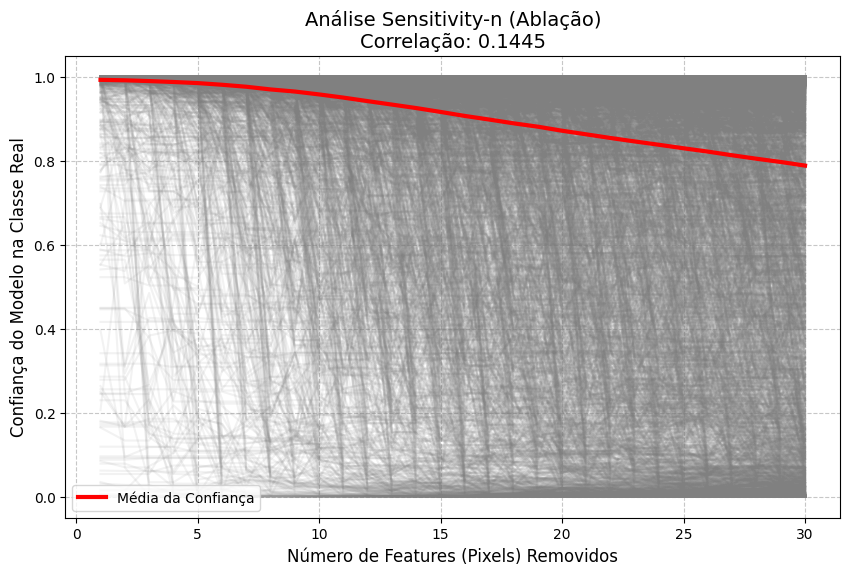

RESULTADOS SENSITIVITY-N
Amostras analisadas: 7000
Features removidas (max): 30
Correlação de Pearson: 0.1445


In [8]:
# 1. Definir o wrapper do explicador
# Esta função deve receber a imagem e a label, e devolver SÓ o mapa de importancia
def meu_explicador_ig(image_input, class_idx):
    explainer = IntegratedGradients()
    # Chama o teu explainer
    explanation = explainer.explain(
        validation_data=(image_input, None),
        model=modelo.modelo,
        class_index=class_idx
    )
    # Garante que retorna apenas array 2D/3D (sem batch dim extra se não preciso)
    return np.squeeze(explanation)

# 2. Preparar os dados (se o teu dataset estiver num objeto custom, extrai arrays numpy)
# Exemplo assumindo que tens X_test e y_test
# Se estiver no objeto 'modelo', adapta:
data_list = list(modelo.test_ds.as_numpy_iterator())

# 2. Separar as features e os targets usando zip
# X será uma lista de imagens, y será uma lista de labels
X_test, y_test = zip(*data_list)

# 3. Converter para arrays NumPy
X_test = np.array(X_test)
y_test = np.array(y_test)


# 3. CHAMAR A FUNÇÃO
# Removemos até 100 pixels, usando 20 imagens de teste
score_corr = analisar_sensitivity_n(
    model=modelo.modelo,
    images=X_test,
    labels=y_test,
    explainer_func=meu_explicador_ig,
    max_n=30,      # Quantos pixels remover no máximo
    num_samples=len(X_test)  # Quantas imagens testar (aumenta para 50+ no final)
)

In [9]:
def analisar_sensitivity_n_fast(model, images, labels, explainer_func, max_n=50, 
                               num_samples=20, baseline_val=0.0):
    """
    Versão ultra-otimizada com trade-off de memória.
    """
    # Configuração
    indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
    num_samples = len(indices)
    
    # Pré-alocação
    h, w = images[0].shape[:2]
    total_steps = num_samples * max_n
    global_data = np.zeros((total_steps, 2))  # [importance_sum, confidence]
    confidence_curves = np.zeros((num_samples, max_n))
    
    print(f"Processando {num_samples} amostras...")
    
    for i, idx in enumerate(tqdm(indices)):
        img = images[idx]
        if len(img.shape) == 2:
            img = img[..., np.newaxis]
        
        label = int(labels[idx])
        
        # Previsão inicial
        initial_conf = model.predict(img[np.newaxis, ...], verbose=0)[0, label]
        
        # Explicação
        attr_map = explainer_func(img[np.newaxis, ...], label)
        attr_map = np.squeeze(attr_map)
        
        # Normalizar e ordenar
        attr_norm = (attr_map - attr_map.min()) / (attr_map.max() - attr_map.min() + 1e-8)
        flat_attr = attr_norm.reshape(-1)
        sorted_idx = np.argsort(flat_attr)[::-1][:max_n]
        
        # Pré-computar modificações
        rows = sorted_idx // w
        cols = sorted_idx % w
        importance_cumsum = np.cumsum(flat_attr[sorted_idx])
        
        # Modificação incremental
        img_copy = img.copy()
        for step in range(max_n):
            # Modificar pixel
            img_copy[rows[step], cols[step]] = baseline_val
            
            # Previsão
            conf_new = model.predict(img_copy[np.newaxis, ...], verbose=0)[0, label]
            
            # Armazenar
            global_idx = i * max_n + step
            global_data[global_idx, 0] = importance_cumsum[step]
            global_data[global_idx, 1] = conf_new
            confidence_curves[i, step] = conf_new
    
    # Correlação
    correlation, _ = pearsonr(global_data[:, 0], initial_conf - global_data[:, 1])
    
    return correlation, confidence_curves

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [10]:
# Versão completa para resultados finais
results = analisar_sensitivity_n(
    model=modelo.modelo,
    images=X_test,
    labels=y_test,
    explainer_func=meu_explicador_ig,
    max_n=30,
    num_samples=len(X_test),
    batch_size=16
)

print(f"Correlação: {results['correlation']:.4f}")

TypeError: analisar_sensitivity_n() got an unexpected keyword argument 'batch_size'